# ATARI PROBLEMS

In [1]:
import gym
import random
import numpy as np

from skimage.transform import resize
from skimage.color import rgb2gray

import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from collections import deque

from matplotlib import pyplot as plt

seed = 0
np.random.seed(seed)
random.seed(seed)

### sudo python3 -m pip install gym[atari]
### sudo python3 -m pip install scikit-image

# Helper Function

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))
    
def pre_processing(observe):
    processed_observe = np.uint8(
        resize(rgb2gray(observe), (84, 84), mode='constant') * 255)
    return processed_observe

# EFFICIENT REPLAY MEMORY

In [3]:
class ReplayMemory:
    def __init__(self, memory_size=10000, per_alpha=0.2, per_beta0=0.4):       
        self.memory = SumTree(capacity=memory_size)
        self.memory_size = memory_size
        self.per_alpha = per_alpha
        self.per_beta0 = per_beta0
        self.per_beta = per_beta0
        self.per_epsilon = 1E-6
        self.prio_max = 0
    
    def anneal_per_importance_sampling(self, step, max_step):
        self.per_beta = self.per_beta0 + step*(1-self.per_beta0)/max_step

    def error2priority(self, errors):
        return np.power(np.abs(errors) + self.per_epsilon, self.per_alpha)

    def save_experience(self, state, action, reward, state_next, done):
        experience = (state, action, reward, state_next, done)
        self.memory.add(np.max([self.prio_max, self.per_epsilon]), experience)
        
    def retrieve_experience(self, batch_size):
        idx = None
        priorities = None
        w = None

        idx, priorities, experience = self.memory.sample(batch_size)
        sampling_probabilities = priorities / self.memory.total()
        w = np.power(self.memory.n_entries * sampling_probabilities, -self.per_beta)
        w = w / w.max()
        return idx, priorities, w, experience
    
    def update_experience_weight(self, idx, errors ):
        priorities = self.error2priority(errors)
        for i in range(len(idx)):
            self.memory.update(idx[i], priorities[i])
        self.prio_max = max(priorities.max(), self.prio_max)
        
class SumTree:
    def __init__(self, capacity=100000):
        self.capacity = capacity
        self.tree = np.zeros(2*capacity - 1)
        self.data = np.zeros(capacity, dtype=object)

        self.write = 0
        self.n_entries = 0

        self.tree_len = len(self.tree)

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1

        if left >= self.tree_len:
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            right = left + 1
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1

        return idx, self.tree[idx], self.data[data_idx]

    def sample(self, batch_size):
        batch_idx = [None] * batch_size
        batch_priorities = [None] * batch_size
        batch = [None] * batch_size
        segment = self.total() / batch_size

        a = [segment*i for i in range(batch_size)]
        b = [segment * (i+1) for i in range(batch_size)]
        s = np.random.uniform(a, b)

        for i in range(batch_size):
            (batch_idx[i], batch_priorities[i], batch[i]) = self.get(s[i])

        return batch_idx, batch_priorities, batch

# DEEP Q LEARNING AGENT

In [8]:
class DQNAgent:
    def __init__(self, n_action, obs_dim = (84, 84, 4,), seed=0,
                 discount_factor = 0.995, epsilon_decay = 0.999, epsilon_min = 0.1,
                 learning_rate = 0.00025, # STEP SIZE
                 batch_size = 32, 
                 memory_size = 400000, update_target_rate = 10000,
                 target_mode = 'DDQN', memory_mode = 'PER', archi_mode='NODUELING'):
        self.seed = seed 
        self.obs_dim = obs_dim
        self.n_action = n_action

        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.train_start = 50000

        self.archi_mode = archi_mode
        self.target_mode = target_mode
        self.memory_mode = memory_mode
        self.update_target_rate = update_target_rate
        if memory_mode == 'PER':
            self.memory = ReplayMemory(memory_size=memory_size)
        else:
            self.memory = deque(maxlen=memory_size)
                    
        self.g = tf.Graph()
        with self.g.as_default():
            self.build_placeholders()
            self.build_model()
            self.build_loss()
            self.build_update_operation()
            self.init_session()        
    
    def build_placeholders(self):
        self.obs_ph = tf.placeholder(tf.float32, (None,) + self.obs_dim, 'obs')
        self.target_ph = tf.placeholder(tf.float32, (None, self.n_action), 'target')
        self.batch_weights_ph = tf.placeholder(tf.float32,(None, self.n_action), name="batch_weights")
        self.learning_rate_ph = tf.placeholder(tf.float32, (), 'lr')        
    
    def build_model(self):        
        with tf.variable_scope('q_prediction'):
            out = tf.layers.conv2d (self.obs_ph,
                            filters=32,
                            kernel_size=[8, 8],
                            strides=[4, 4],
                            activation=tf.nn.relu,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=0),
                            name="conv1")
            
            out = tf.layers.conv2d (out,
                            filters=64,
                            kernel_size=[4, 4],
                            strides=[2, 2],
                            activation=tf.nn.relu,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=0),
                            name="conv2")
            
            out = tf.layers.conv2d (out,
                            filters=64,
                            kernel_size=[3, 3],
                            strides=[1, 1],
                            activation=tf.nn.relu,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=0),
                            name="conv3")
            
            out = tf.contrib.layers.flatten(out)
            out = tf.layers.dense(out, 512, activation=tf.nn.relu,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=0),
                                  name="hidden")
            
            if self.archi_mode == 'DUELING':
                value = tf.layers.dense(out, 1, # Linear Layer
                                      kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='value')
                advantage = tf.layers.dense(out, self.n_action, # Linear Layer
                                      kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='advantage')
                self.q_predict = value + advantage - tf.reduce_mean(advantage,axis = 1,keepdims=True)
            else:
                self.q_predict = tf.layers.dense(out, self.n_action,
                                                 kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed),
                                                 name='q_predict')
                        
        with tf.variable_scope('q_target'):
            out = tf.layers.conv2d (self.obs_ph,
                            filters=32,
                            kernel_size=[8, 8],
                            strides=[4, 4],
                            activation=tf.nn.relu,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=0),
                            name="conv1")
            
            out = tf.layers.conv2d (out,
                            filters=64,
                            kernel_size=[4, 4],
                            strides=[2, 2],
                            activation=tf.nn.relu,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=0),
                            name="conv2")
            
            out = tf.layers.conv2d (out,
                            filters=64,
                            kernel_size=[3, 3],
                            strides=[1, 1],
                            activation=tf.nn.relu,
                            kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=0),
                            name="conv3")
            
            out = tf.contrib.layers.flatten(out)
            out = tf.layers.dense(out, 512, activation=tf.nn.relu,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=0),
                                  name="hidden")
            
            if self.archi_mode == 'DUELING':
                value = tf.layers.dense(out, 1, # Linear Layer
                                      kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='value')
                advantage = tf.layers.dense(out, self.n_action, # Linear Layer
                                      kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed), name='advantage')
                self.q_predict_old = value + advantage - tf.reduce_mean(advantage,axis = 1,keepdims=True)
            else:
                self.q_predict_old = tf.layers.dense(out, self.n_action,
                                                 kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed=self.seed),
                                                 name='q_predict')
                
        self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_prediction')
        self.weights_old = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_target')

    def build_loss(self):
        self.errors = self.target_ph - self.q_predict
        self.loss = 0.5*tf.reduce_mean(self.batch_weights_ph*tf.square(self.target_ph - self.q_predict))
        self.optim = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate_ph, epsilon=1e-2).minimize(self.loss)
            
    def build_update_operation(self):
        update_ops = []
        for var, var_old in zip(self.weights, self.weights_old):
            update_ops.append(var_old.assign(var))
        self.update_ops = update_ops
        
    def init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        
        self.saver = tf.train.Saver()
        self.sess.run(tf.global_variables_initializer())
        self.sess.run(self.update_ops)
        
    def save_model(self, path = "./save_model/dqn_model"):
        self.saver.save(self.sess, path)
        
    def restore_model(self, path = "./save_model/"):
        with self.g.as_default():
            self.saver.restore(self.sess,tf.train.latest_checkpoint('./save_model/'))
            self.weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_prediction')
            self.weights_old = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_target')
        
    def update_target(self):
        self.sess.run(self.update_ops)
    
    def update_memory(self, step, max_step):
        if self.memory_mode == 'PER':
            self.memory.anneal_per_importance_sampling(step,max_step)
        
    def update_policy(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
    def get_prediction_old(self, obs): 
        q_value_old = self.sess.run(self.q_predict_old,feed_dict={self.obs_ph:obs})        
        return q_value_old
        
    def get_prediction(self, obs):        
        q_value = self.sess.run(self.q_predict,feed_dict={self.obs_ph:obs})        
        return q_value
    
    def get_action(self, obs):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_action)
        else:
            q_value = self.get_prediction(obs)
            return np.argmax(q_value[0])

    def add_experience(self, obs, action, reward, next_obs, done):
        if self.memory_mode == 'PER':
            self.memory.save_experience(obs, action, reward, next_obs, done)
        else:
            self.memory.append((obs, action, reward, next_obs, done))

    def train_model(self):
        loss = np.nan
        
        if self.memory_mode == 'PER':
            n_entries = self.memory.memory.n_entries
        else:
            n_entries = len(self.memory)
            
        if n_entries > self.train_start:
            
            if self.memory_mode == 'PER':
                # PRIORITIZED EXPERIENCE REPLAY
                idx, priorities, w, mini_batch = self.memory.retrieve_experience(self.batch_size)
                batch_weights = np.transpose(np.tile(w, (self.n_action, 1)))
            else:
                mini_batch = random.sample(self.memory, self.batch_size)
                batch_weights = np.ones((self.batch_size, self.n_action))

            observations = np.zeros((self.batch_size,)+ self.obs_dim)
            next_observations = np.zeros((self.batch_size,)+ self.obs_dim)
            actions, rewards, dones = [], [], []

            for i in range(self.batch_size):
                observations[i] = np.float32(mini_batch[i][0] / 255.) # SCALE
                actions.append(mini_batch[i][1])
                rewards.append(mini_batch[i][2])
                next_observations[i] = np.float32(mini_batch[i][3] / 255.)
                dones.append(mini_batch[i][4])

            target = self.get_prediction(observations)
            if self.target_mode == 'DDQN':
                bast_a = np.argmax(self.get_prediction(next_observations),axis=1)
            next_q_value = self.get_prediction_old(next_observations)

            # BELLMAN UPDATE RULE 
            for i in range(self.batch_size):
                if dones[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    if self.target_mode == 'DDQN':
                        target[i][actions[i]] = rewards[i] + self.discount_factor * next_q_value[i][bast_a[i]]
                    else:
                        target[i][actions[i]] = rewards[i] + self.discount_factor * (np.amax(next_q_value[i]))

            loss, errors, _ = self.sess.run([self.loss, self.errors, self.optim], 
                                 feed_dict={self.obs_ph:observations,self.target_ph:target,self.learning_rate_ph:self.learning_rate,self.batch_weights_ph:batch_weights})
            errors = errors[np.arange(len(errors)), actions]
            
            if self.memory_mode == 'PER':
                # PRIORITIZED EXPERIENCE REPLAY
                self.memory.update_experience_weight(idx, errors)
            
        return loss
    


# DEFINE ENVIRONMENT AND AGENT

In [9]:
env = gym.make('BreakoutDeterministic-v4')
env.seed(seed)
max_t = env.spec.max_episode_steps
agent = DQNAgent(env.action_space.n)

[2018-05-21 14:04:39,326] Making new env: BreakoutDeterministic-v4


# TRAIN

In [10]:
DOTRAIN = False
if DOTRAIN:
    avg_return_list = deque(maxlen=100)
    avg_loss_list = deque(maxlen=100)
    nepisodes = 10
    display_step = 10
    global_step  = 0
    for i in range(nepisodes+1):

        obs = env.reset()
        for _ in range(random.randint(1, 30)):
            obs, _, _, _ = env.step(1)

        state = pre_processing(obs)
        history = np.stack((state, state, state, state), axis=2)
        history = np.reshape([history], (1, 84, 84, 4))

        done = False
        dead = False

        start_life = 5    

        total_reward = 0
        total_loss = 0

        for t in range(max_t):
            
            global_step += 1
            action = agent.get_action(np.float32(history / 255.0))
            if action == 0: # Stop
                atari_action = 1
            elif action == 1: # Left
                atari_action = 2
            else: # Right
                atari_action = 3

            next_obs, reward, done, info = env.step(atari_action)
            cliped_reward = np.clip(reward,-1,1)

            next_state = pre_processing(next_obs)
            next_state = np.reshape([next_state], (1, 84, 84, 1))
            next_history = np.append(next_state, history[:, :, :, :3], axis=3)

            if start_life > info['ale.lives']:
                    dead = True
                    start_life = info['ale.lives']

            agent.add_experience(history,action,cliped_reward,next_history,dead)

            loss = agent.train_model()
            agent.update_memory(t,max_t)
            agent.update_policy()
            if global_step % agent.update_target_rate == 0:
                agent.update_target()

            if dead:
                dead = False
            else:
                obs = next_obs
                history = next_history

            total_reward += reward
            total_loss += loss

            if done:
                break

        avg_return_list.append(total_reward)
        avg_loss_list.append(total_loss)

        if (i%display_step)==0:
            print('{} loss : {:.3f}, return : {:.3f}, eps : {:.3f}'.format(i, np.mean(avg_loss_list), np.mean(avg_return_list), agent.epsilon))

    agent.save_model("./save_model/my_model/my_dqn_model")

# Play 

[2018-05-21 14:04:41,632] Making new env: BreakoutDeterministic-v4


score: 158.0



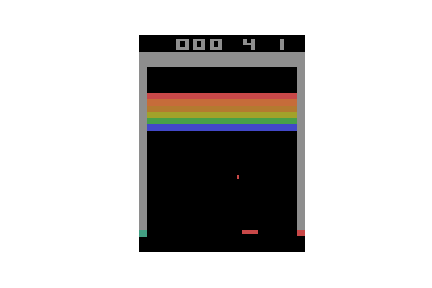
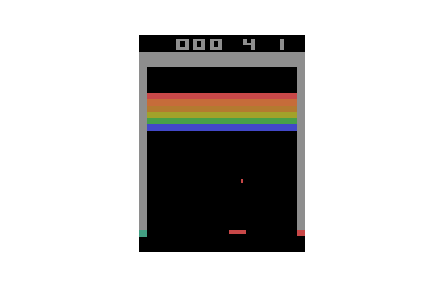
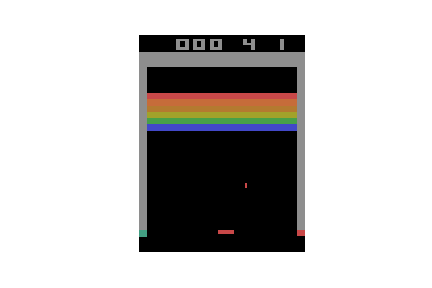
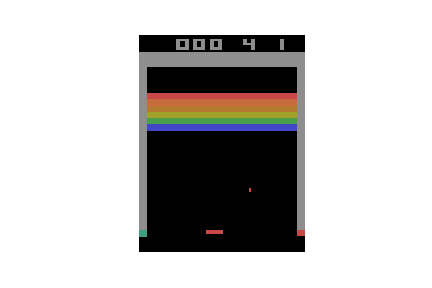
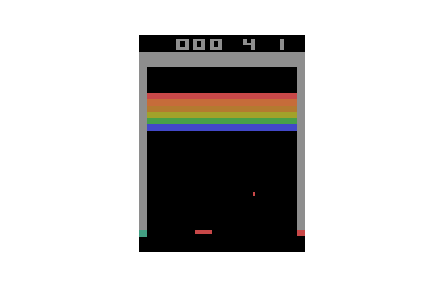
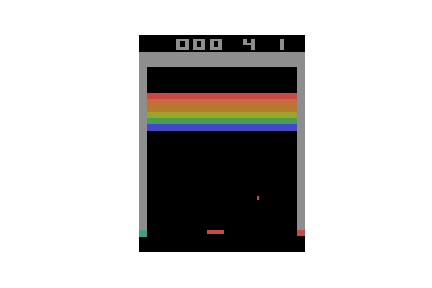
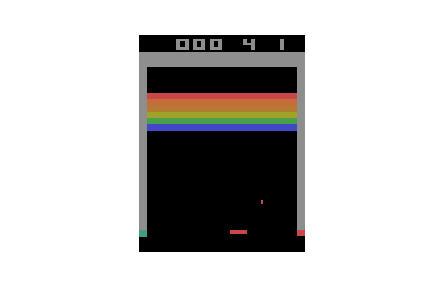
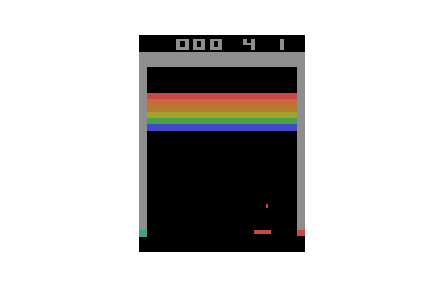
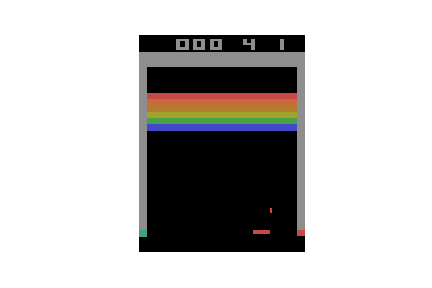
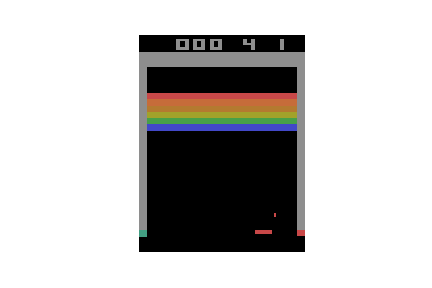
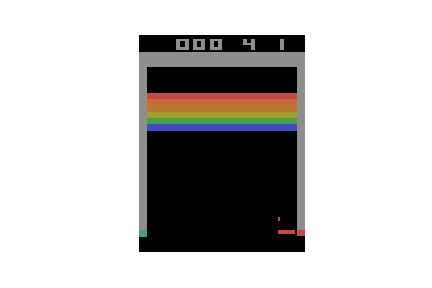
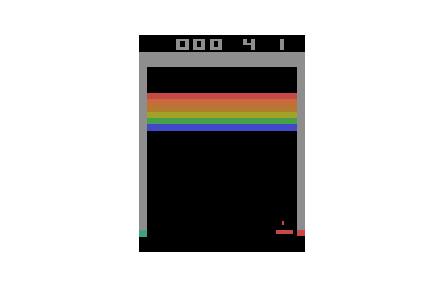
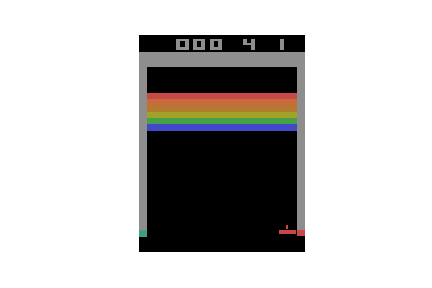
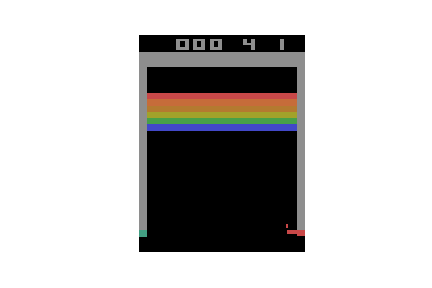
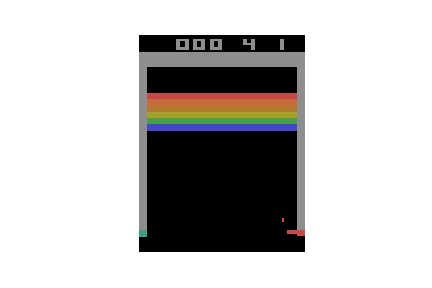
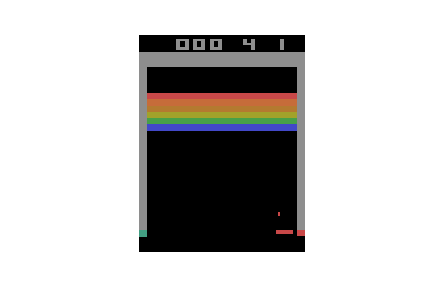
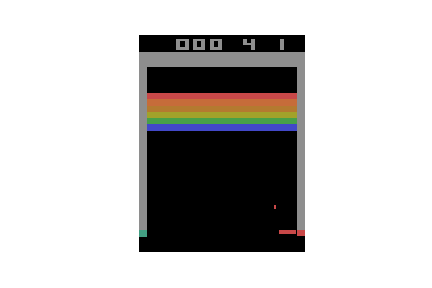
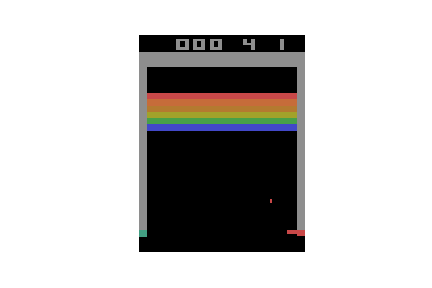
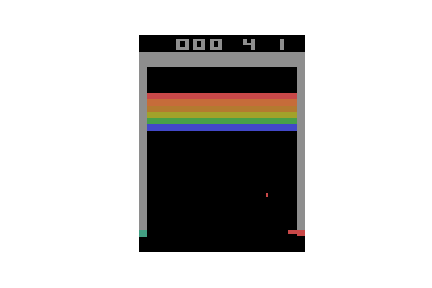
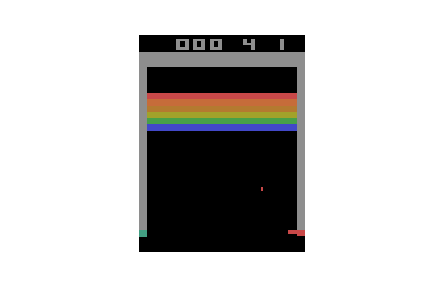
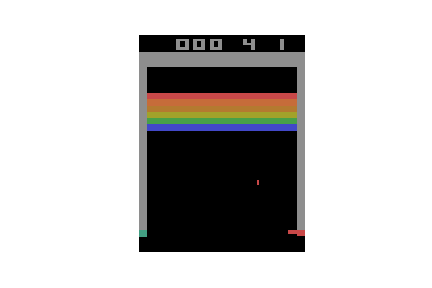
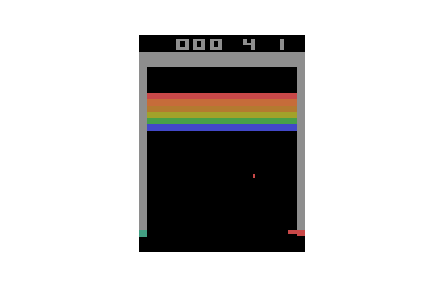
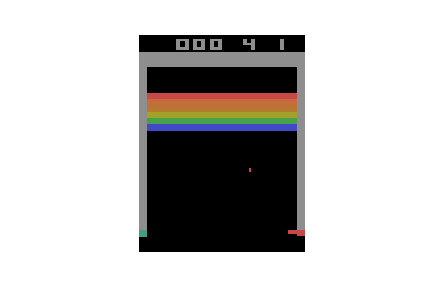
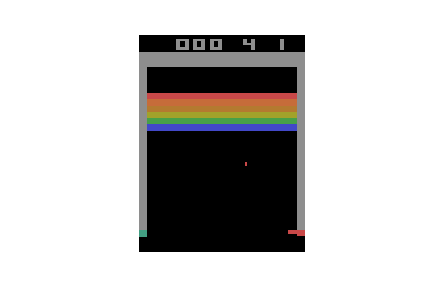
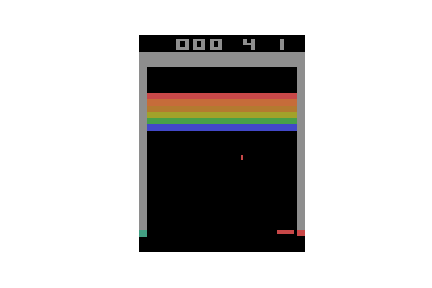
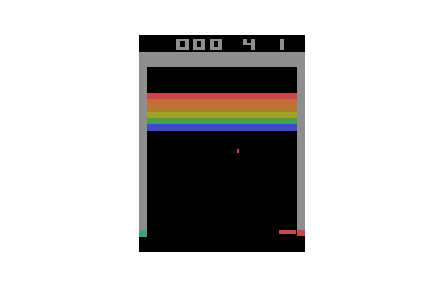
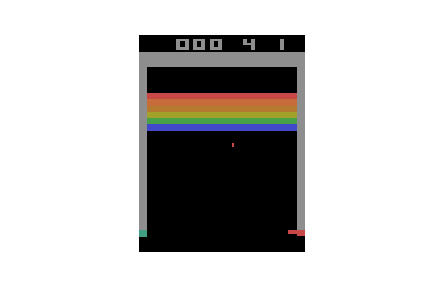
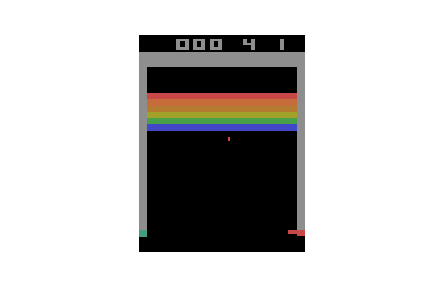
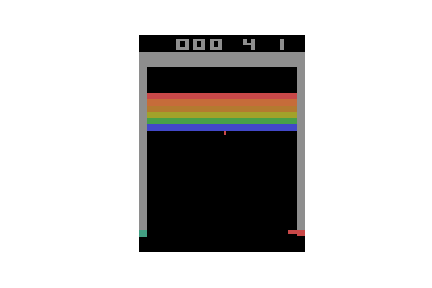
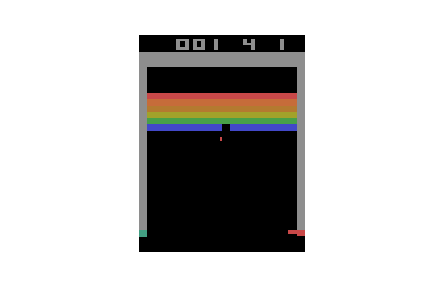
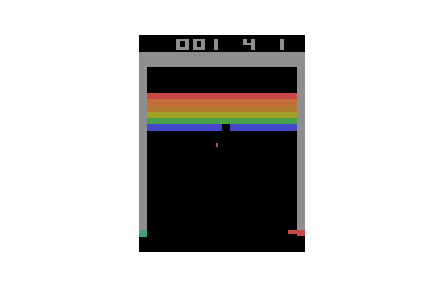
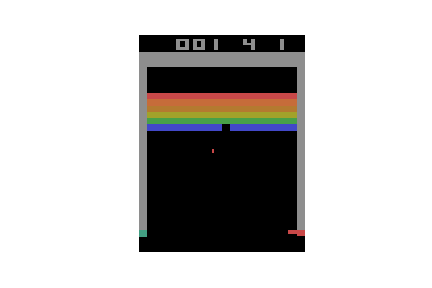
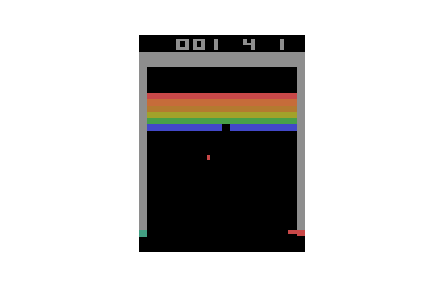
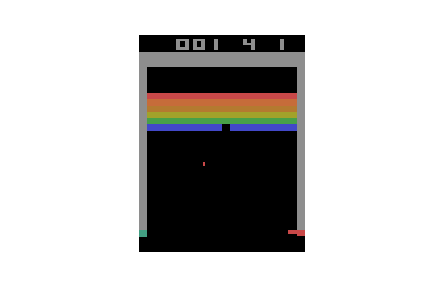
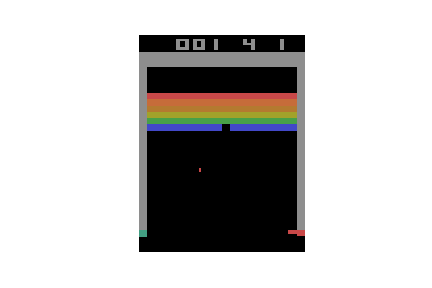
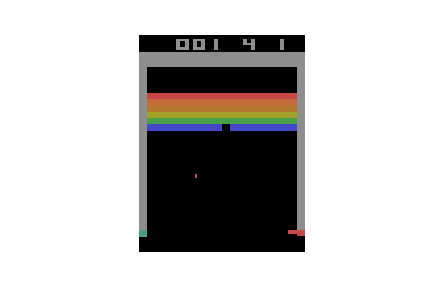
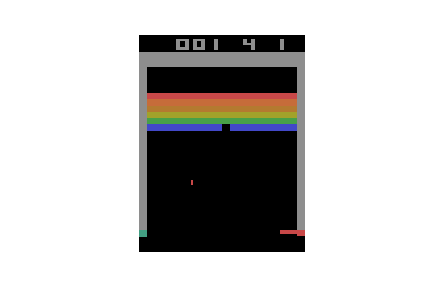
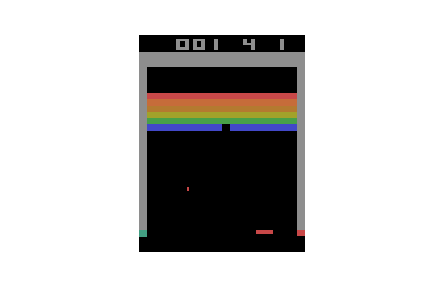
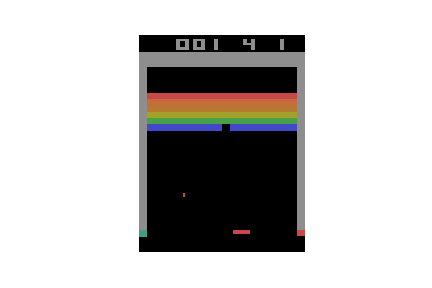
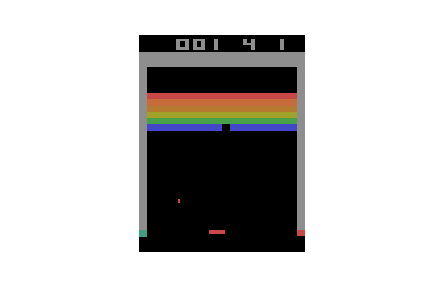
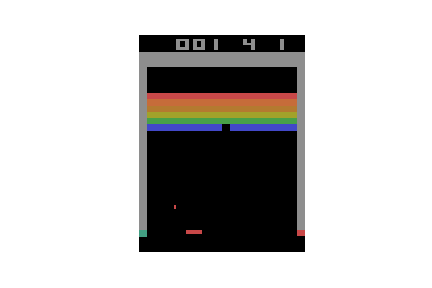
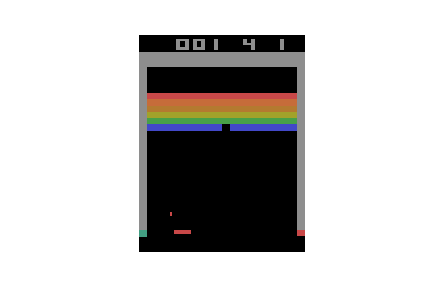
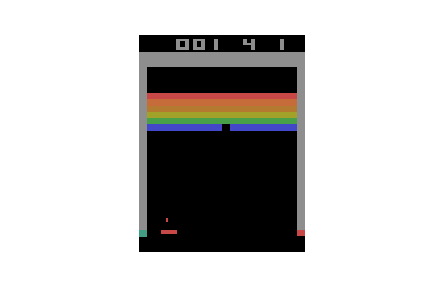
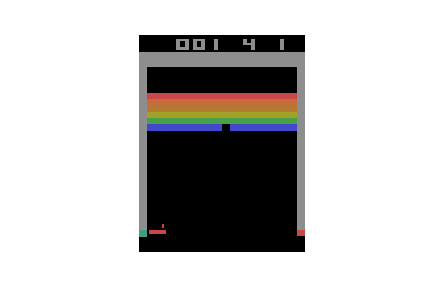
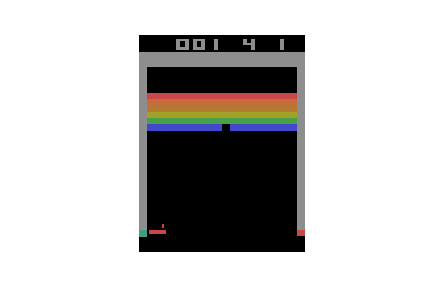
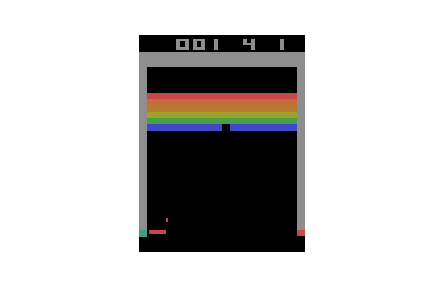
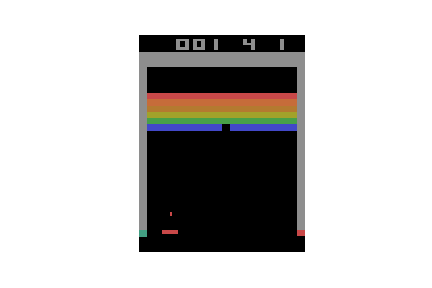
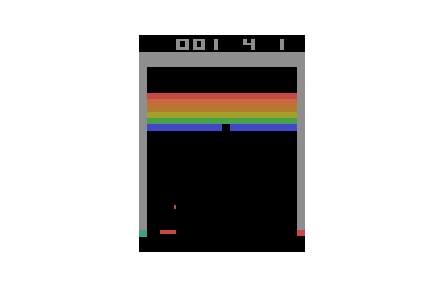
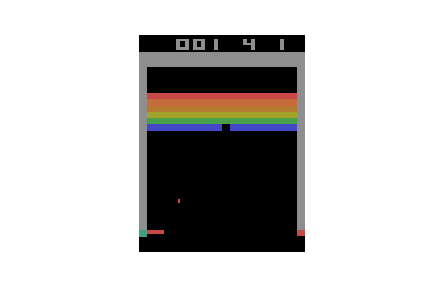
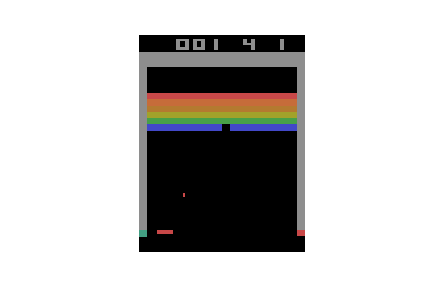
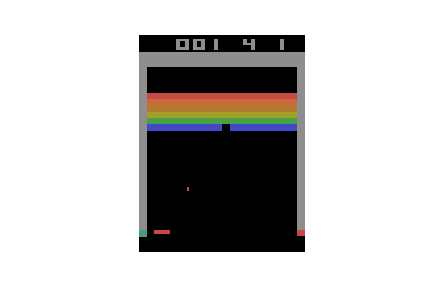
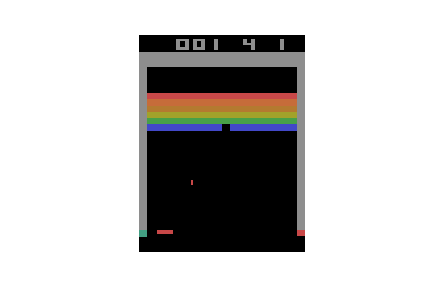
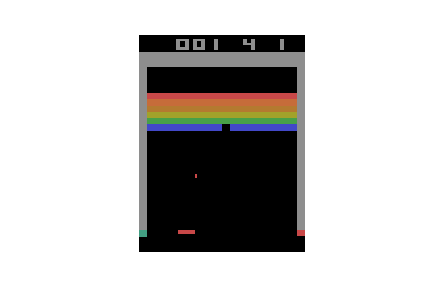
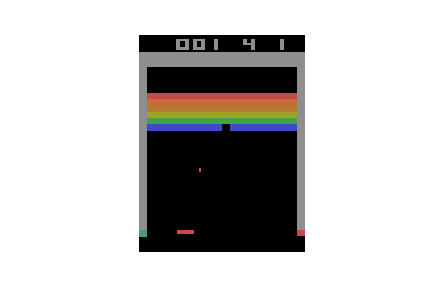
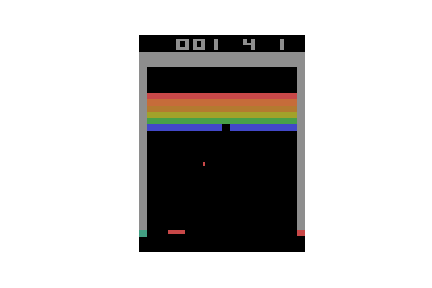
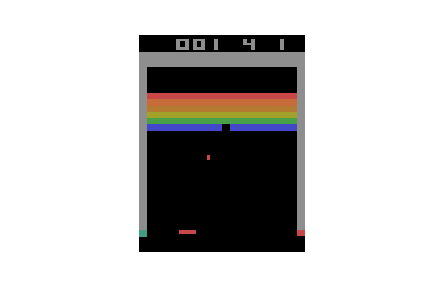
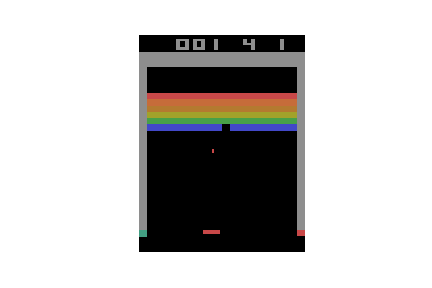
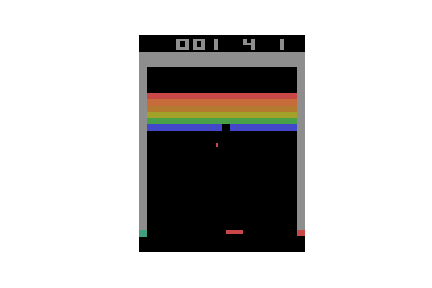
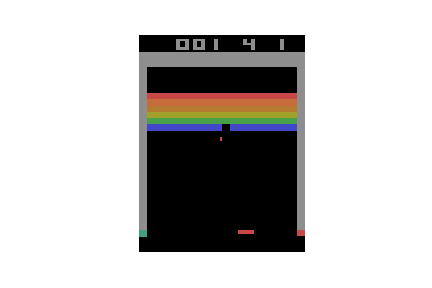
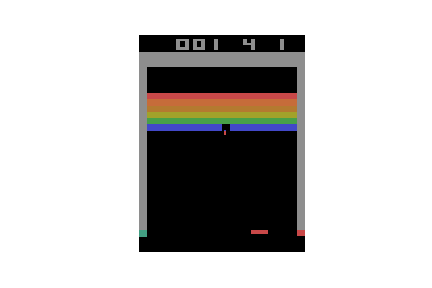
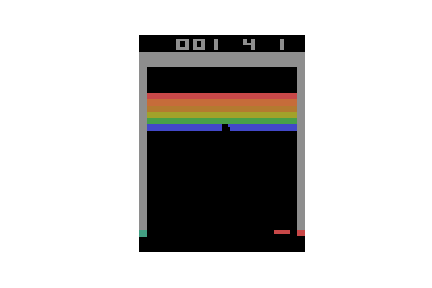
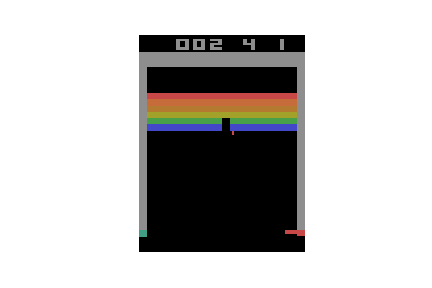
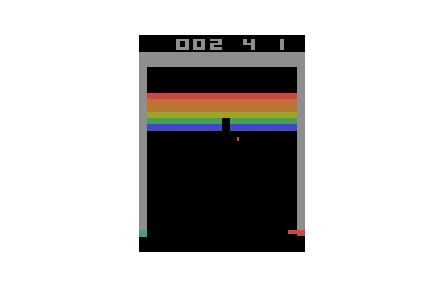
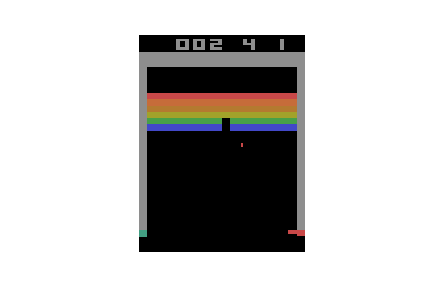
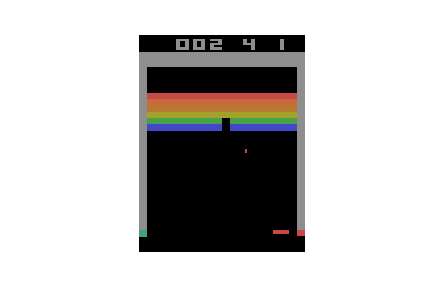
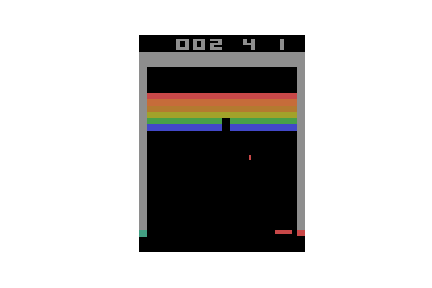
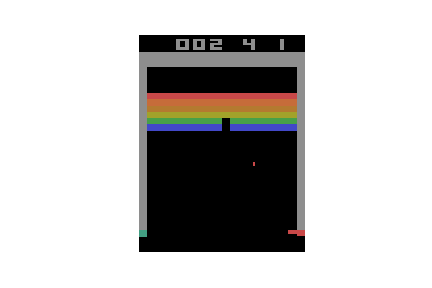
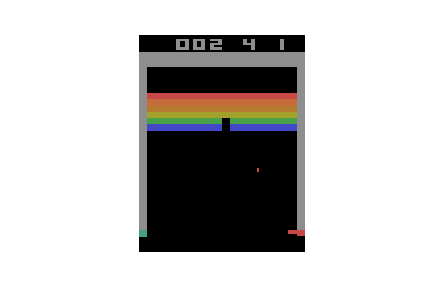
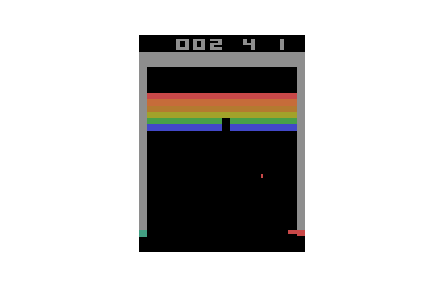
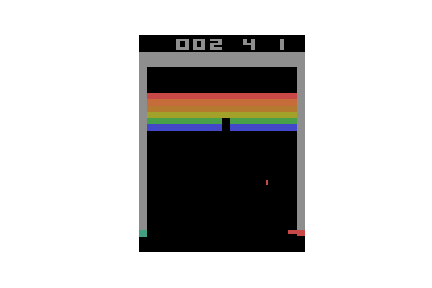
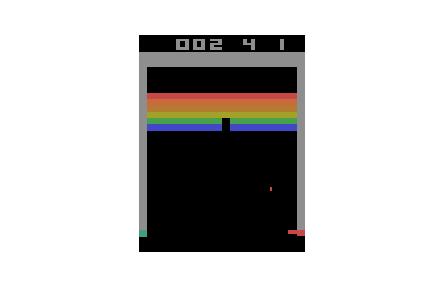
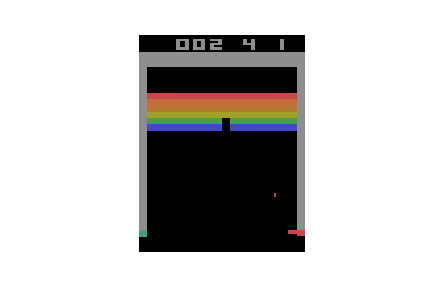
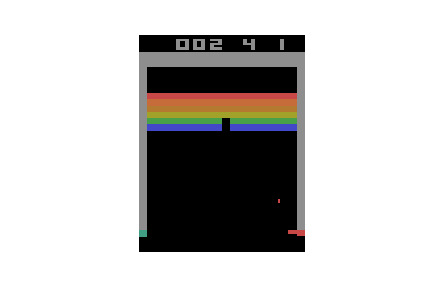
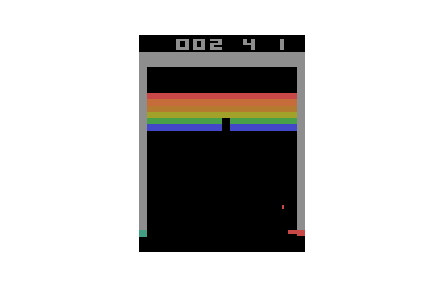
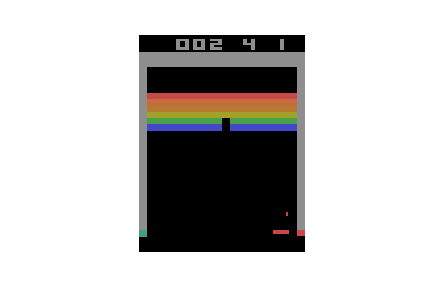
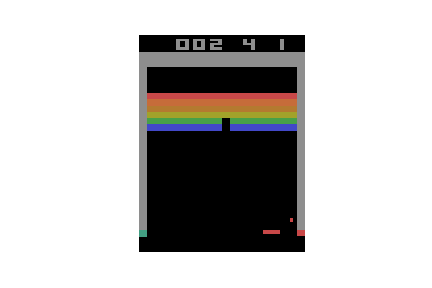
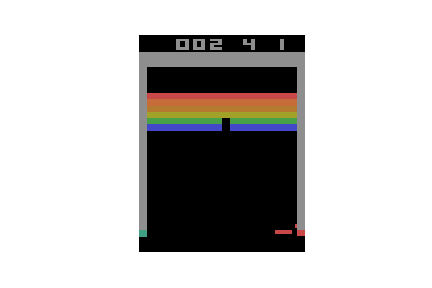
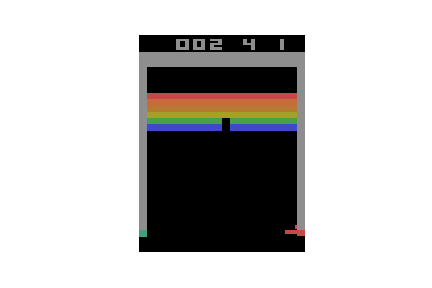
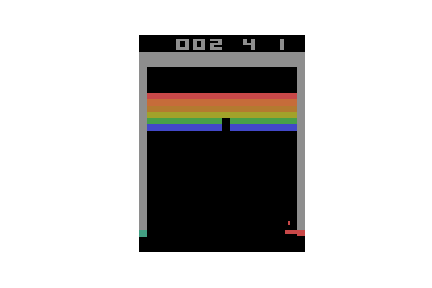
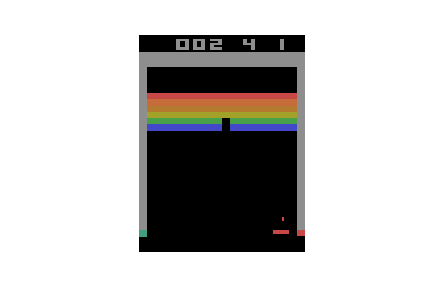
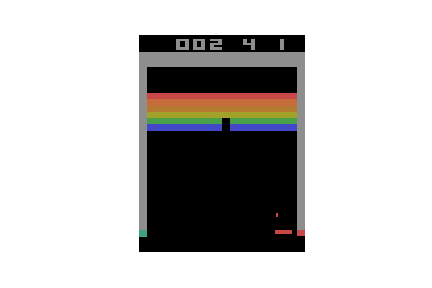
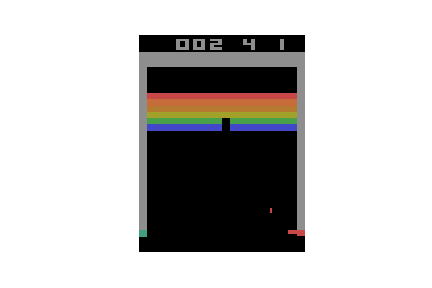
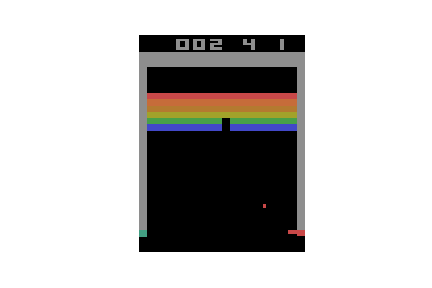
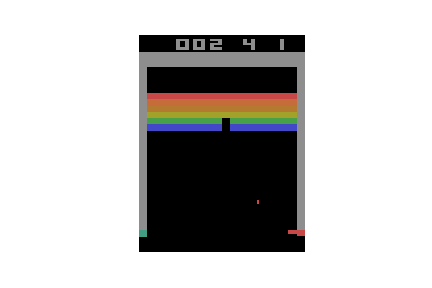
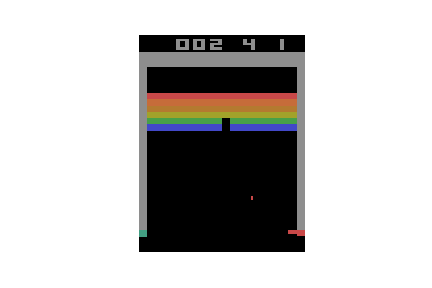
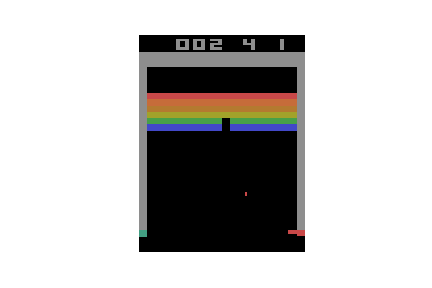
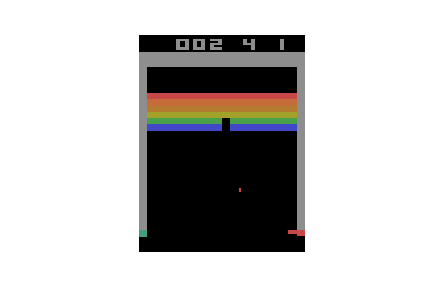
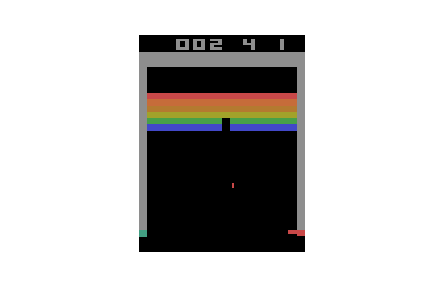
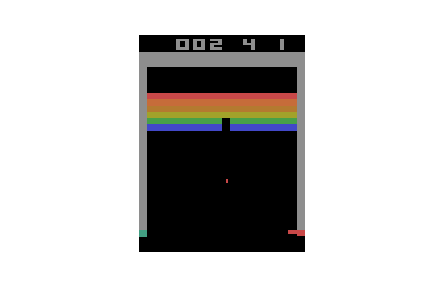
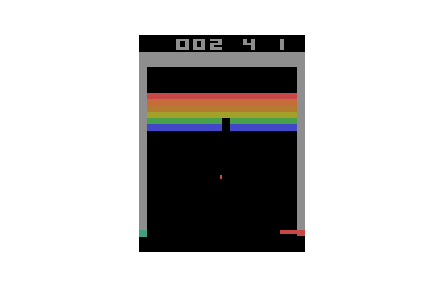
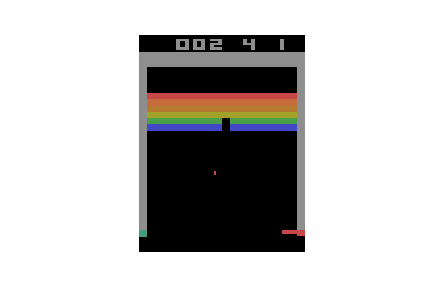
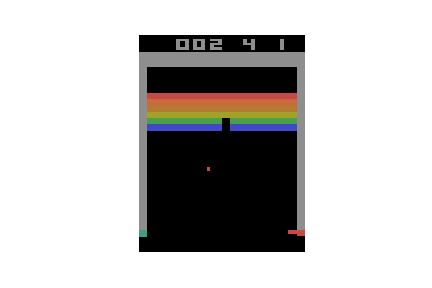
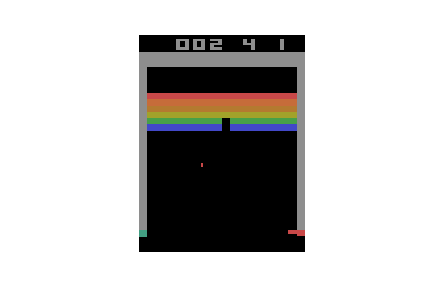
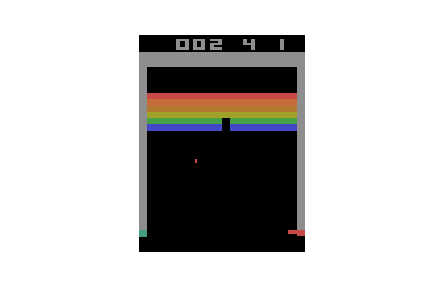
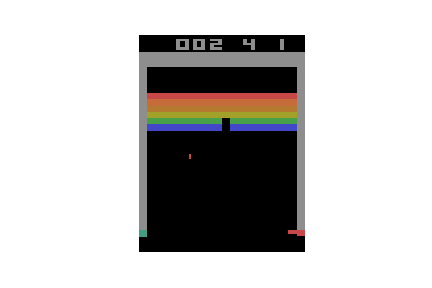
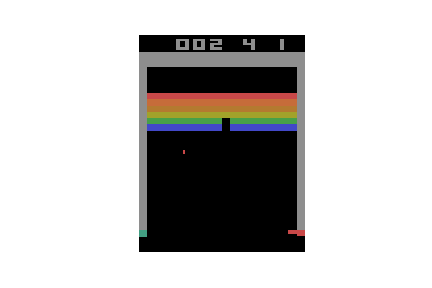
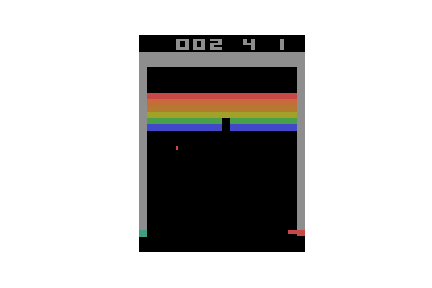
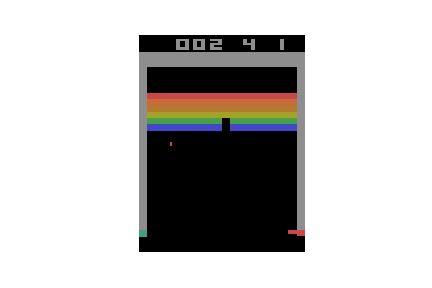
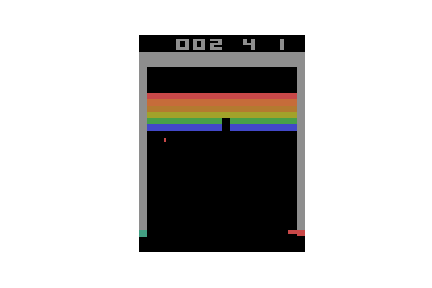
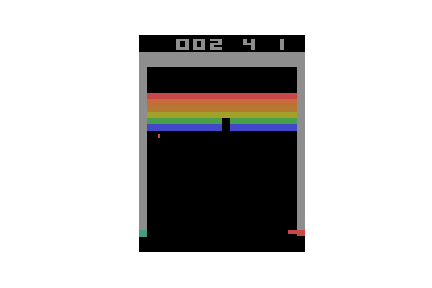
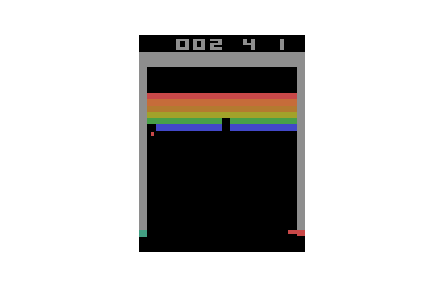
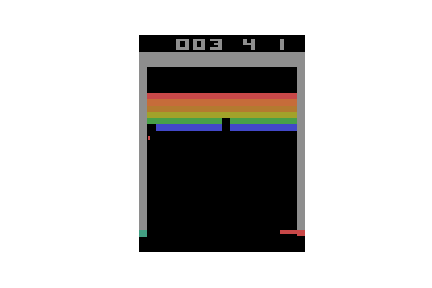
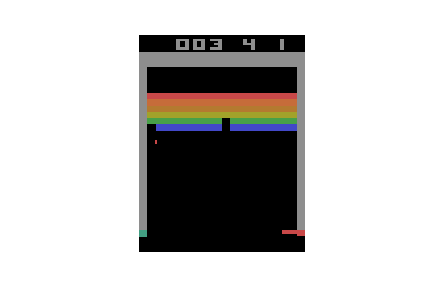
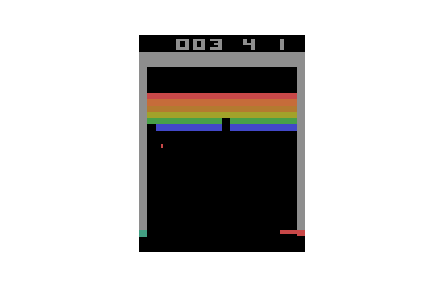
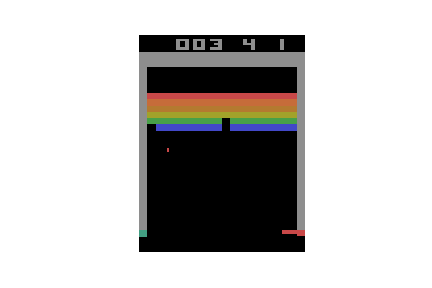
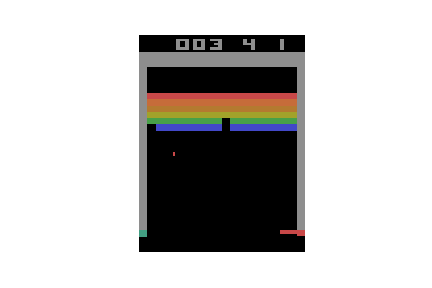
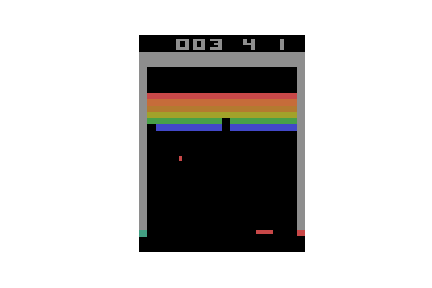
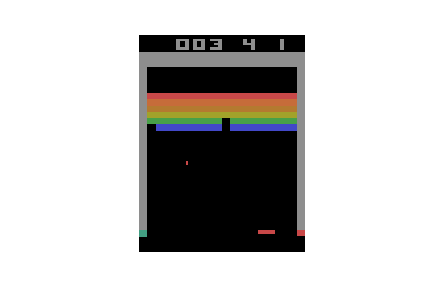
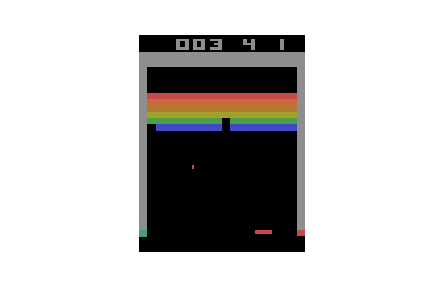
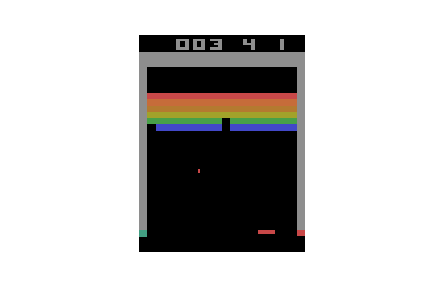
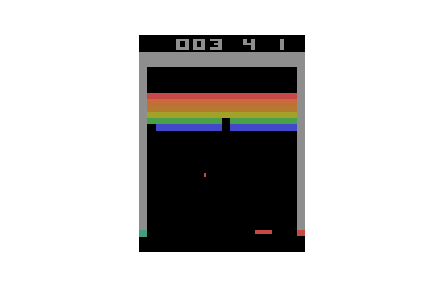
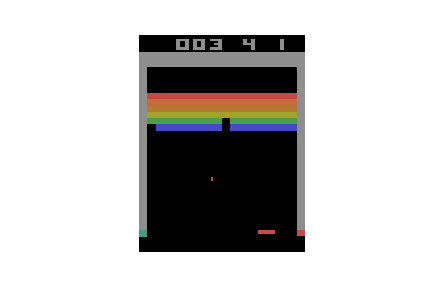
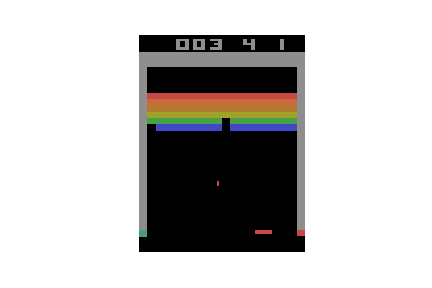
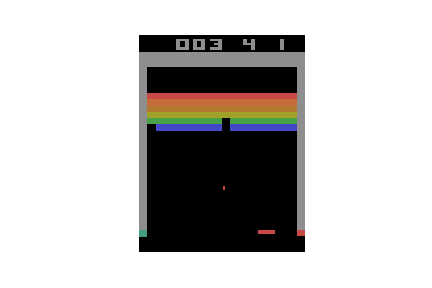
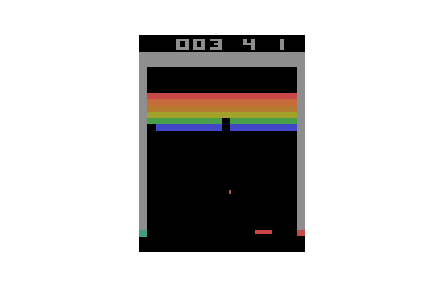
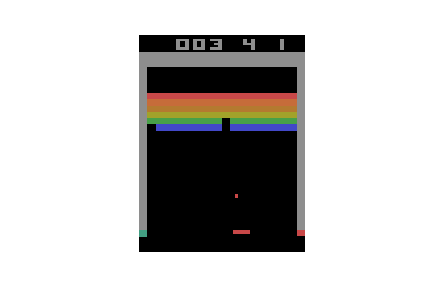
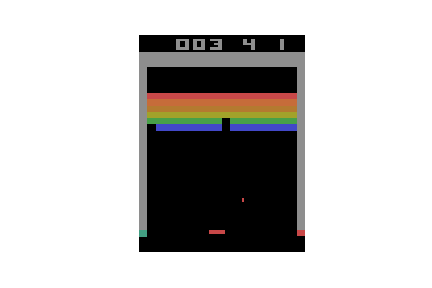
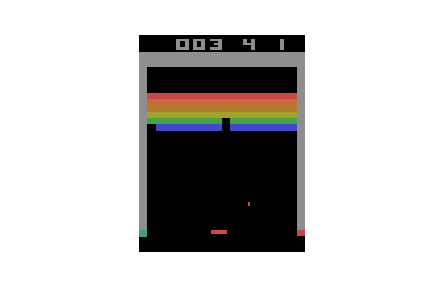
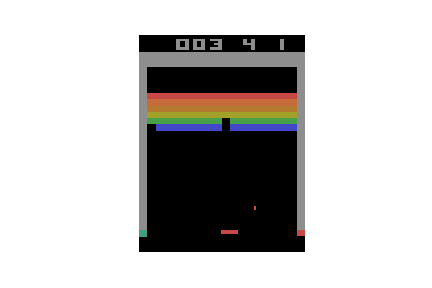
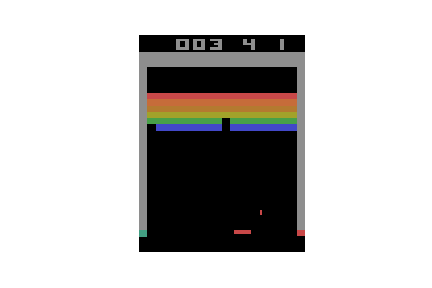
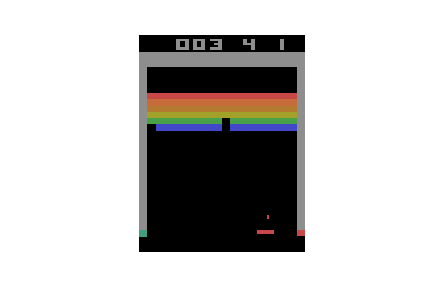
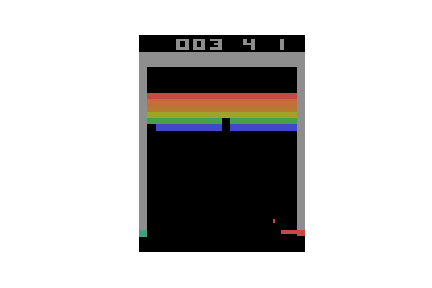
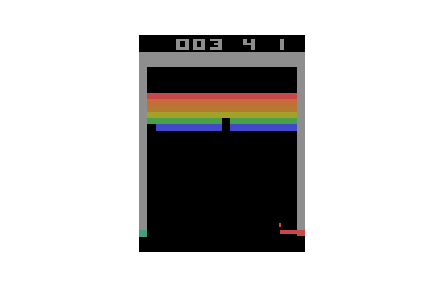
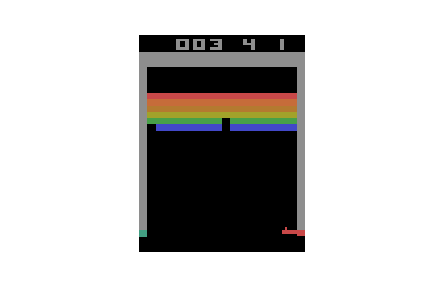
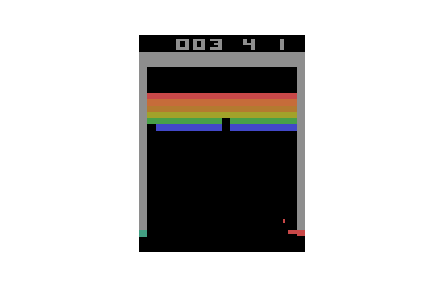
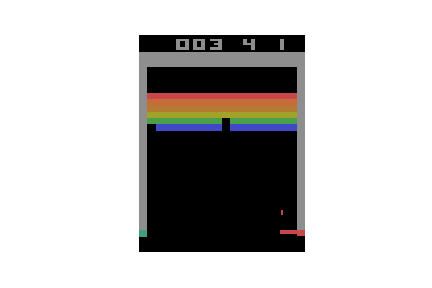
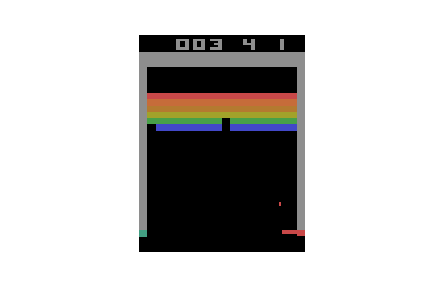
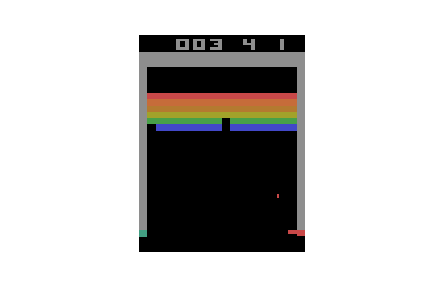
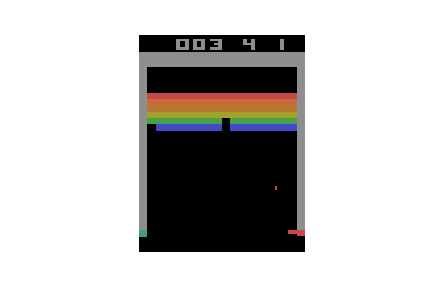
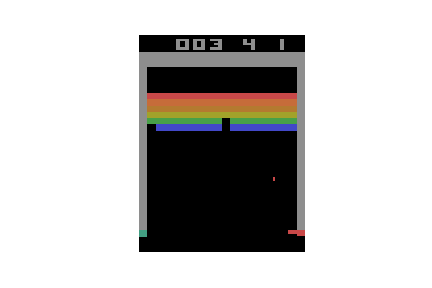
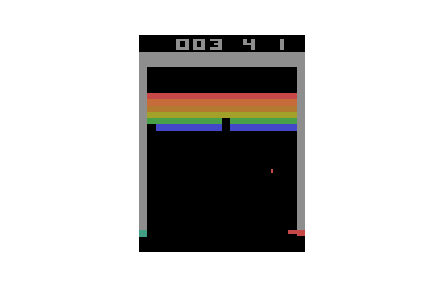
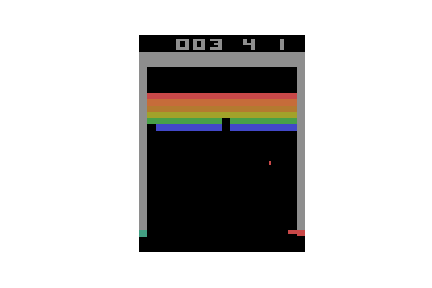
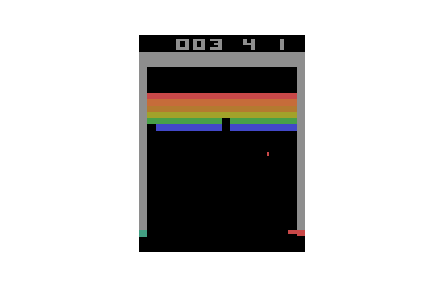
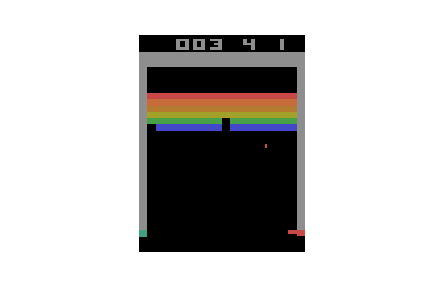
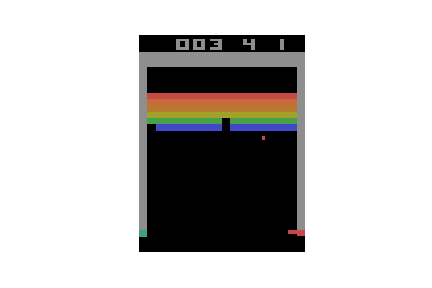
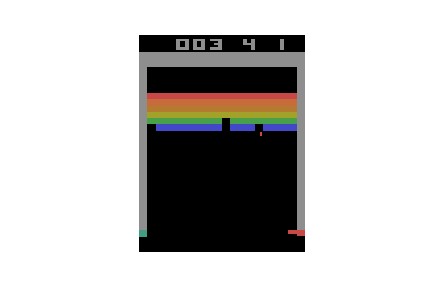
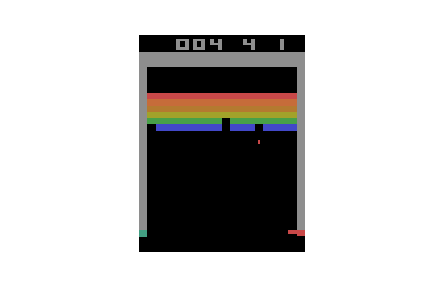
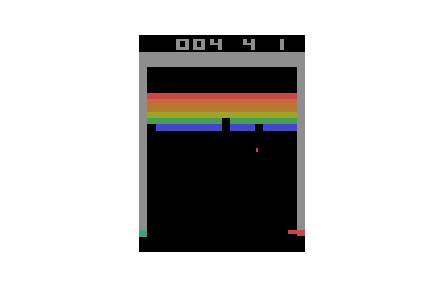
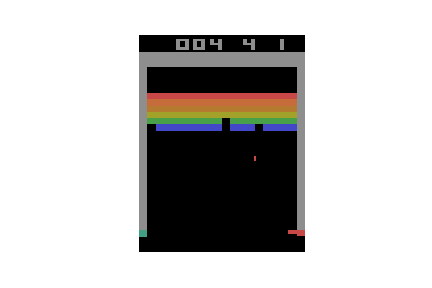
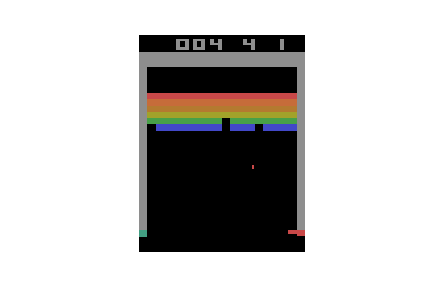
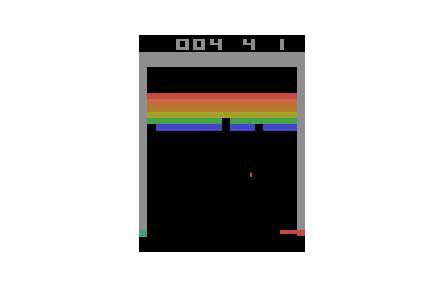
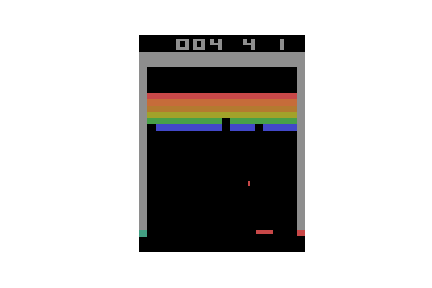
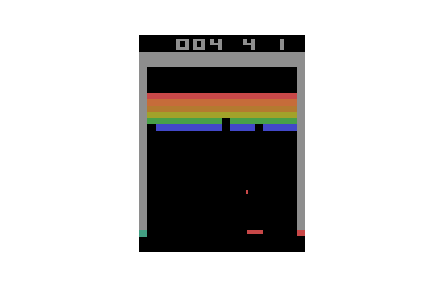
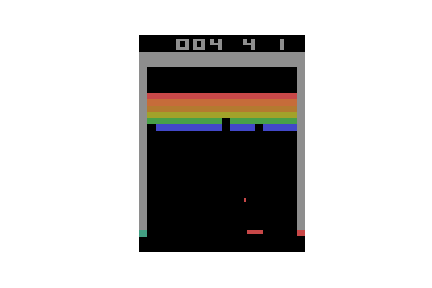
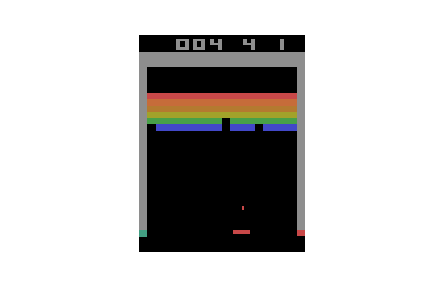
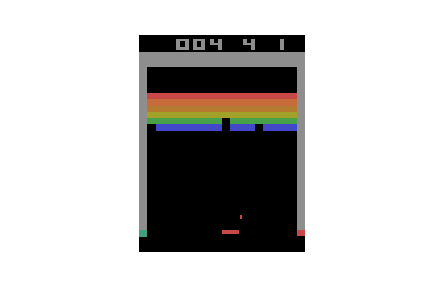
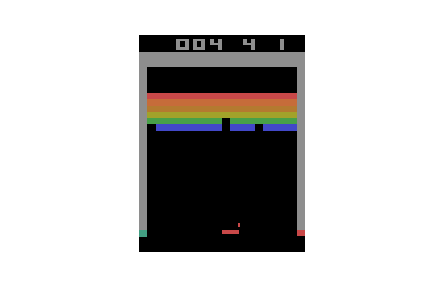
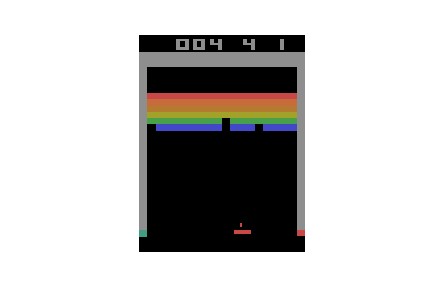
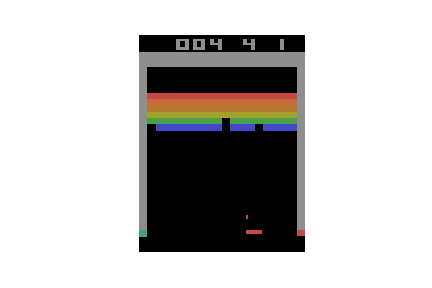
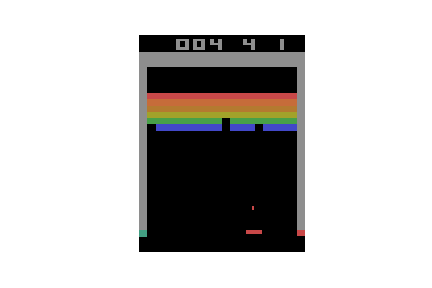
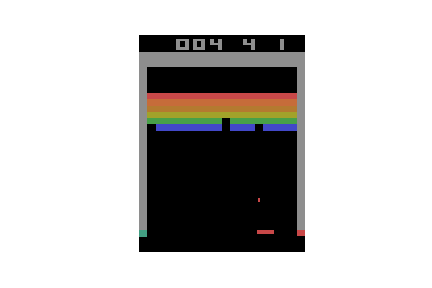
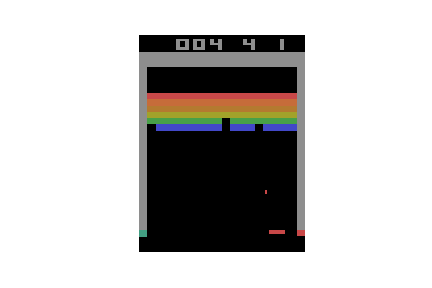
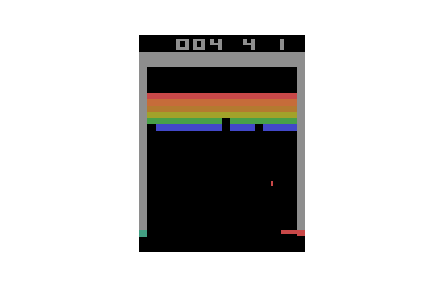
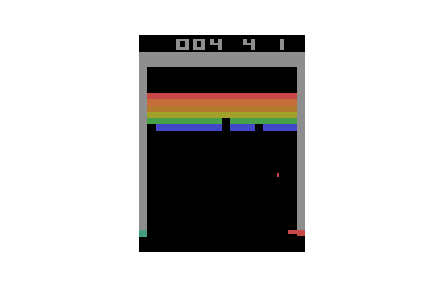
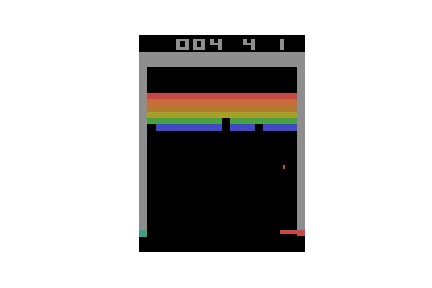
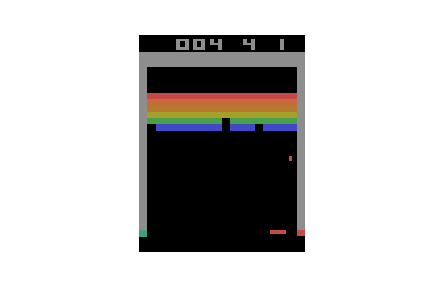
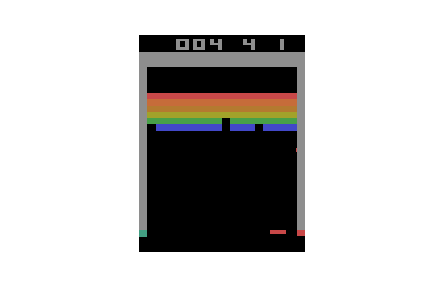
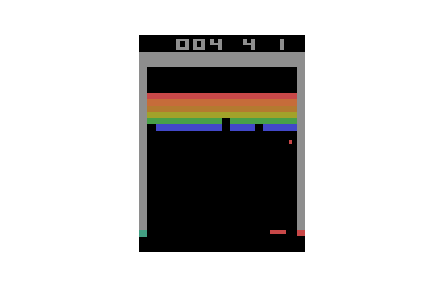
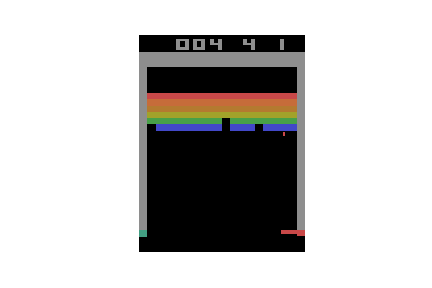
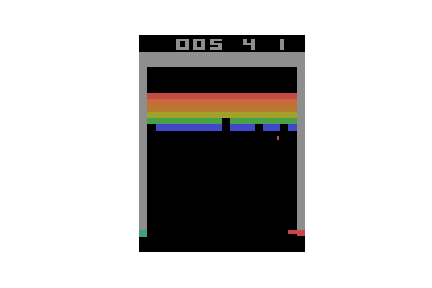
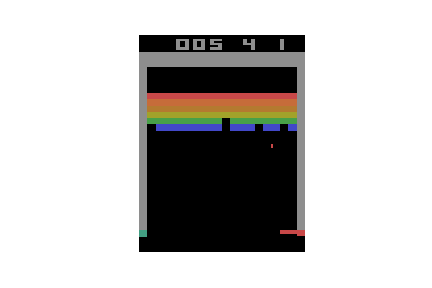
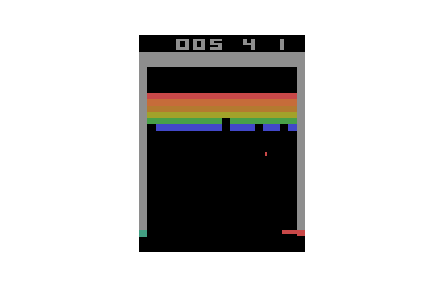
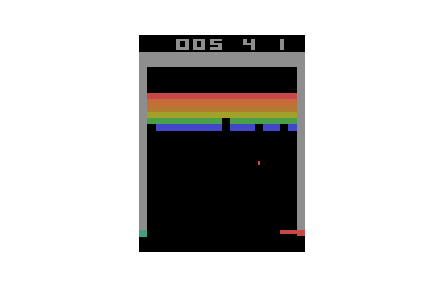
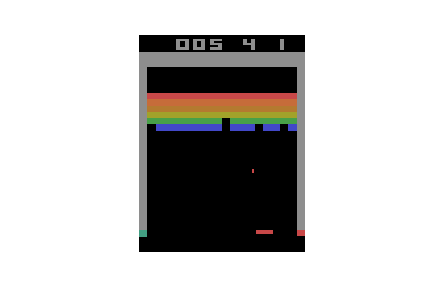
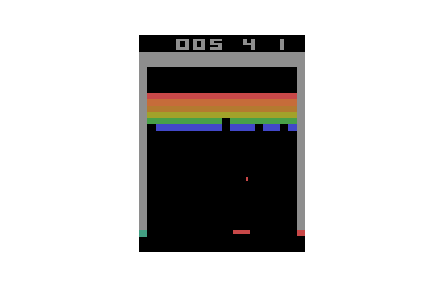
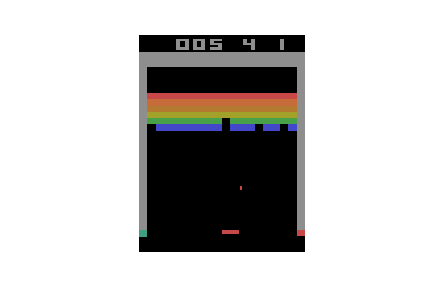
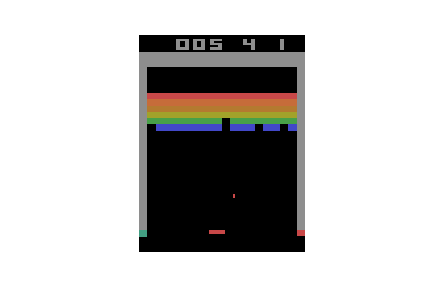
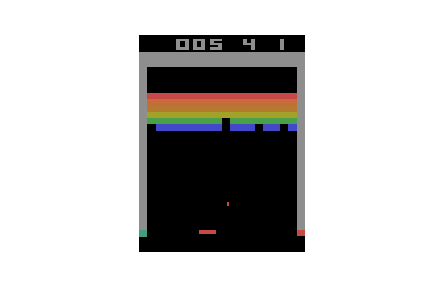
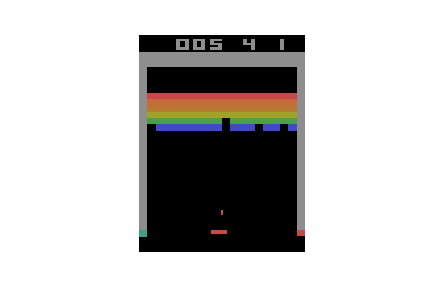
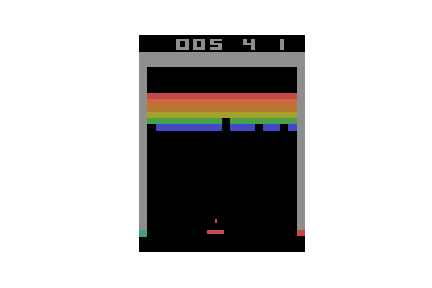
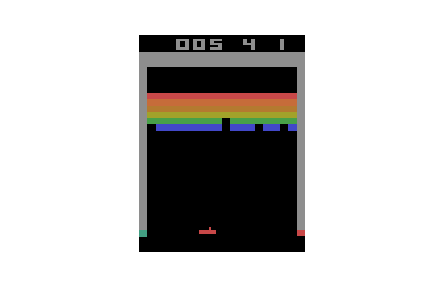
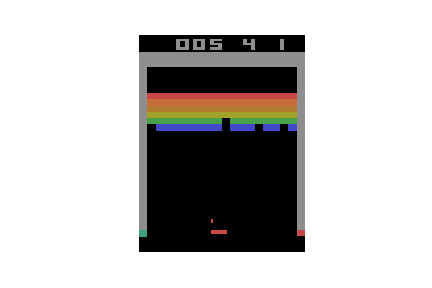
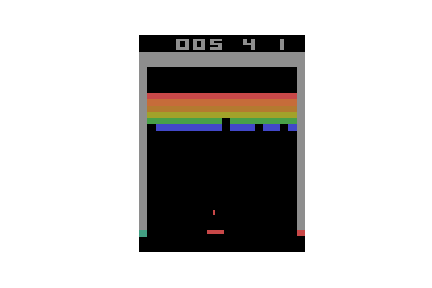
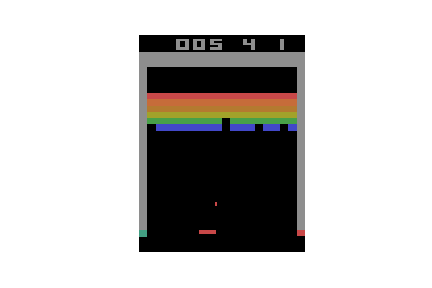
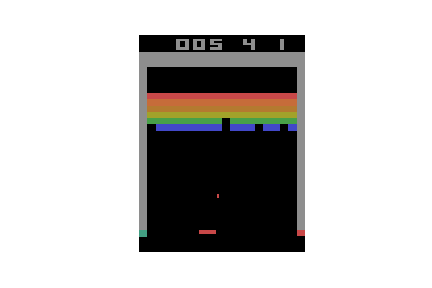
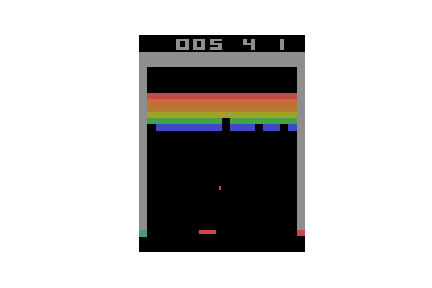
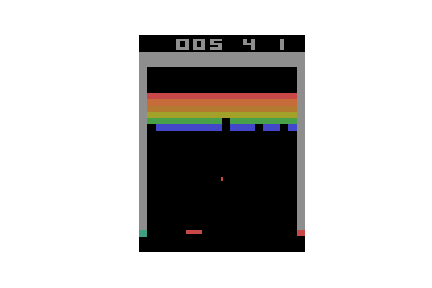
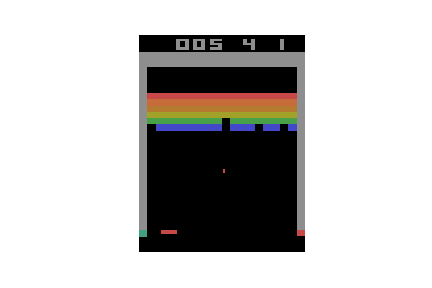
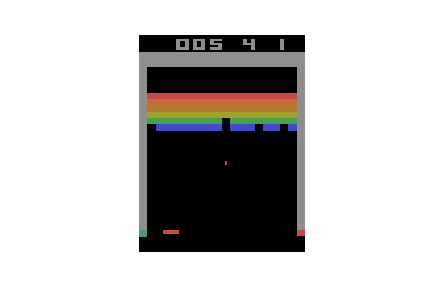
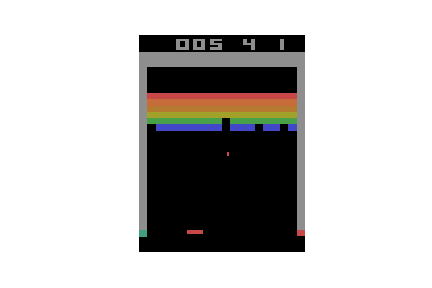
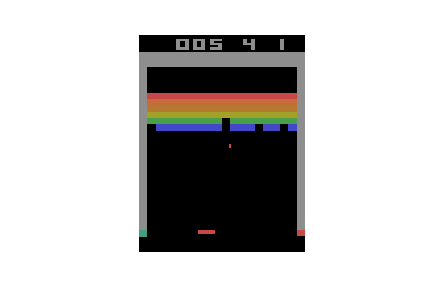
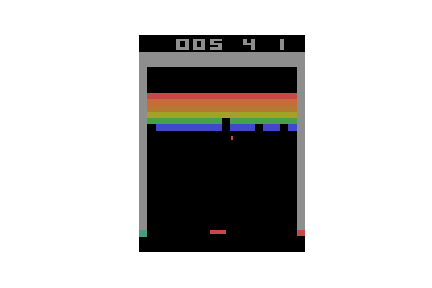
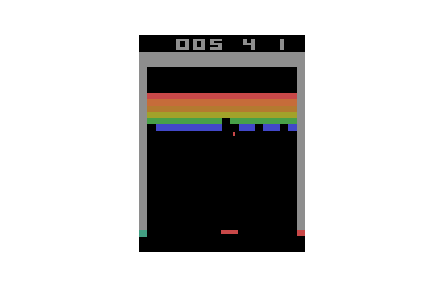
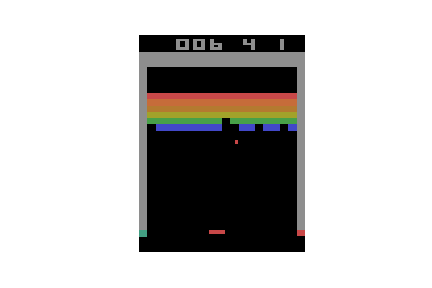
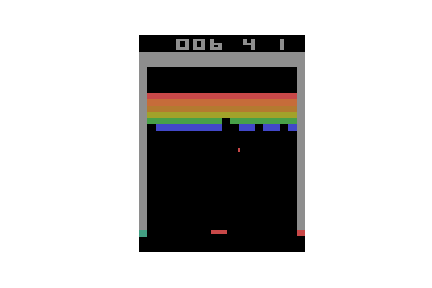
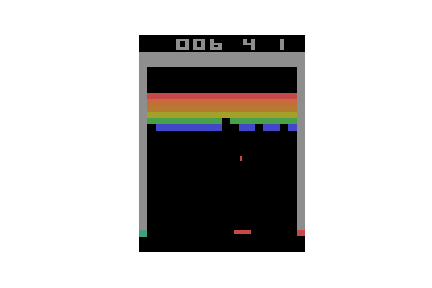
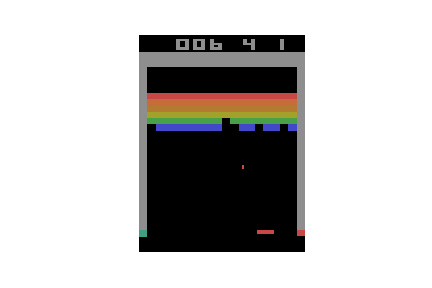
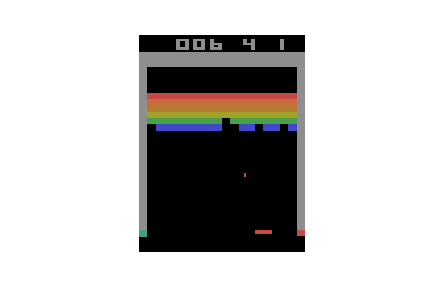
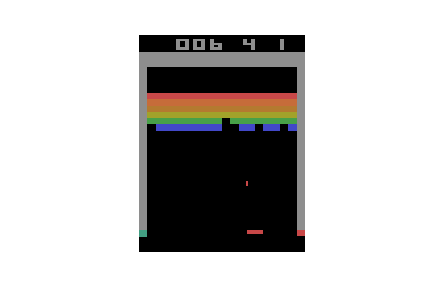
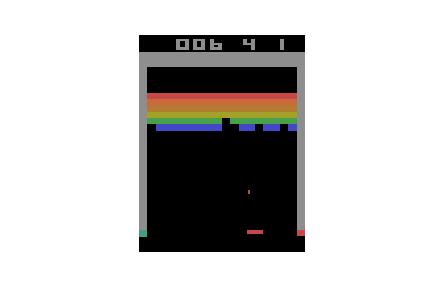
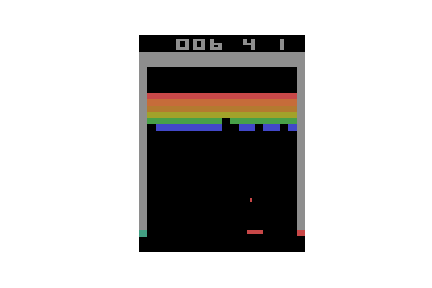
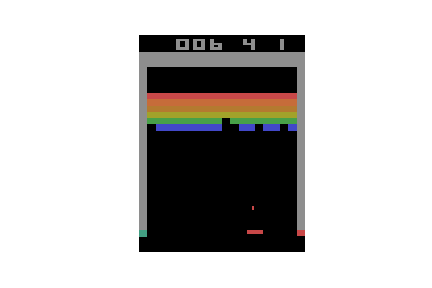
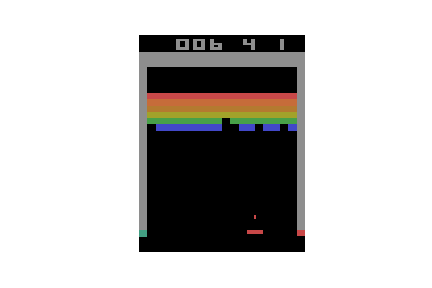
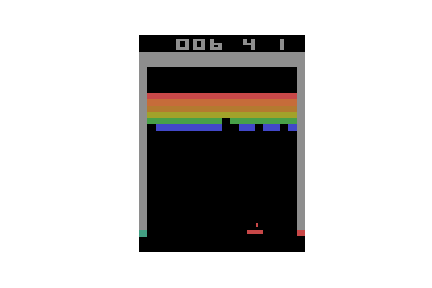
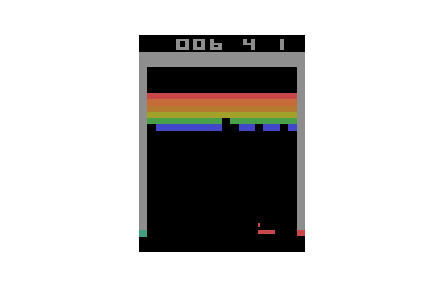
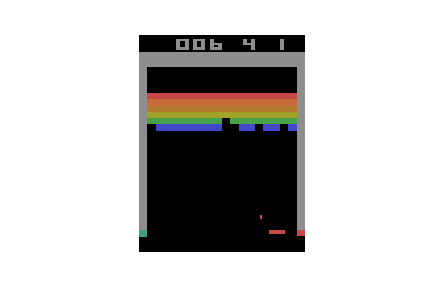
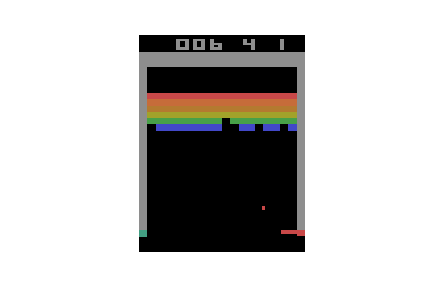
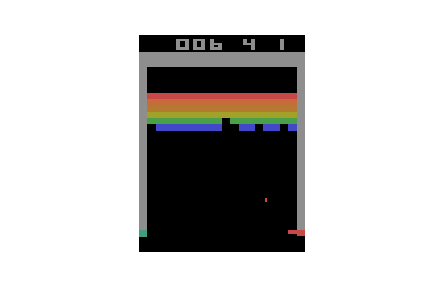
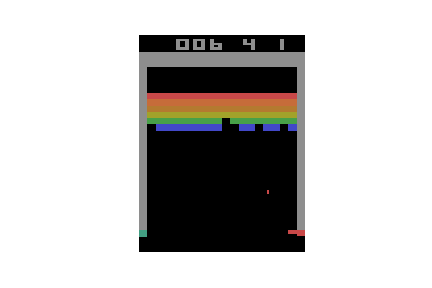
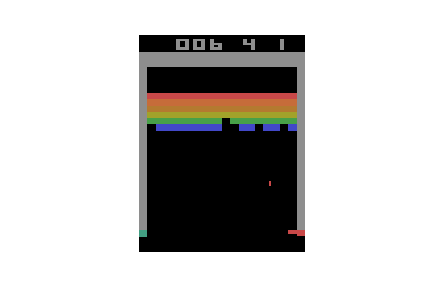
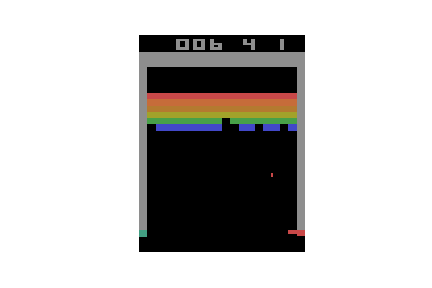
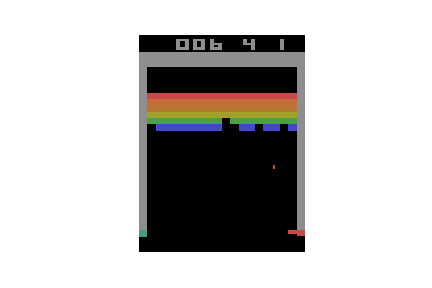
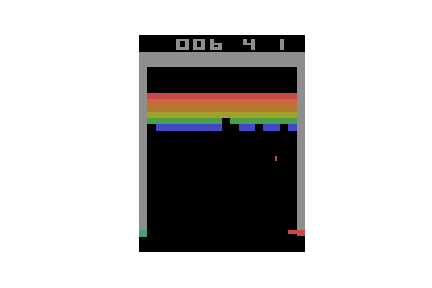
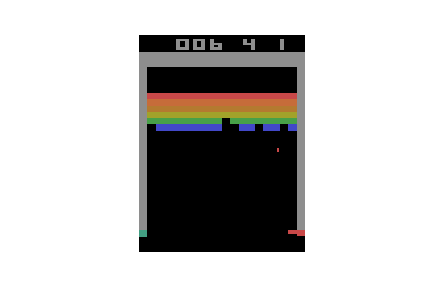
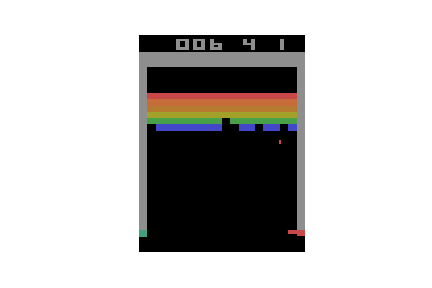
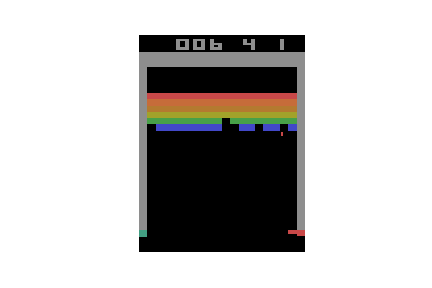
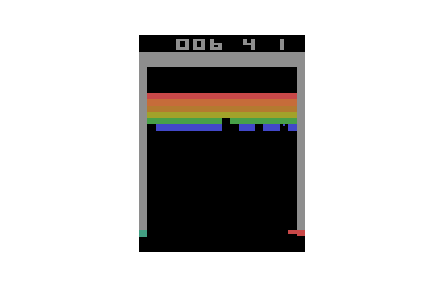
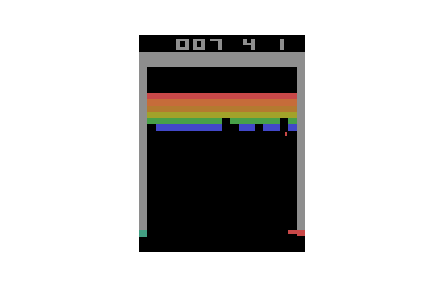
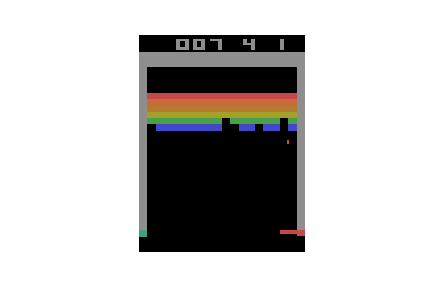
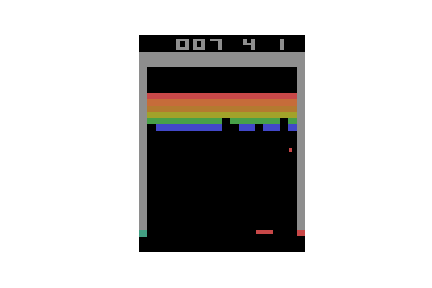
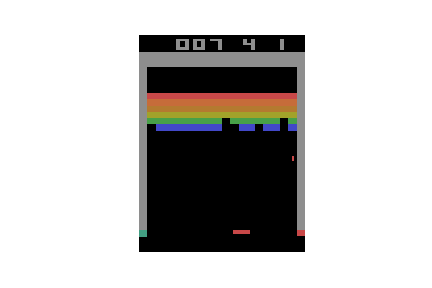
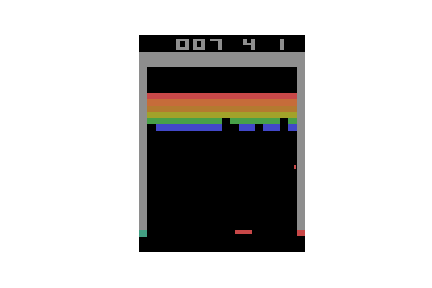
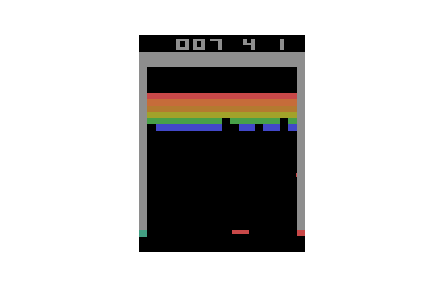
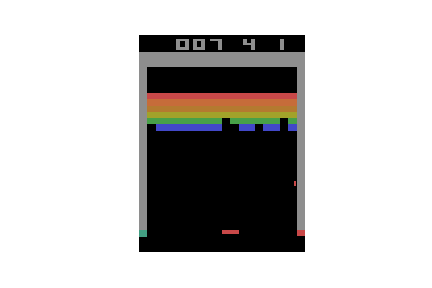
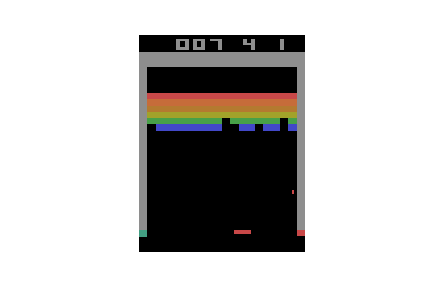
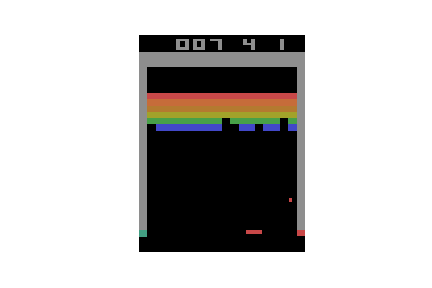
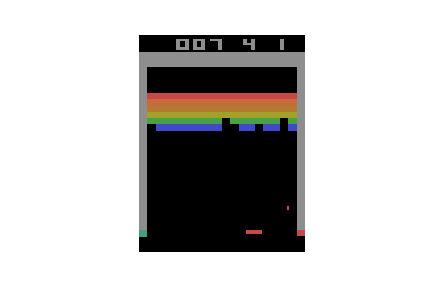
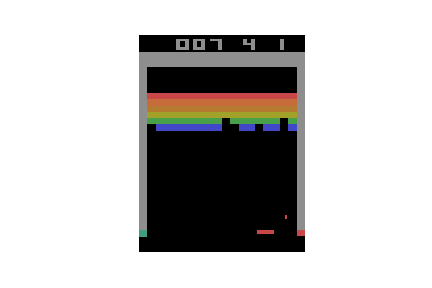
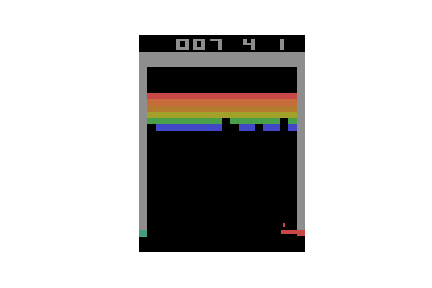
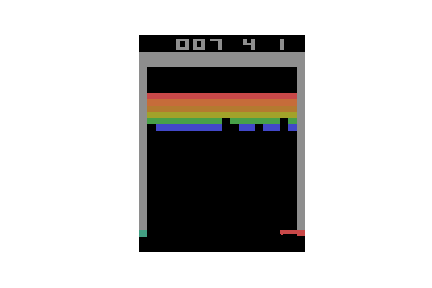
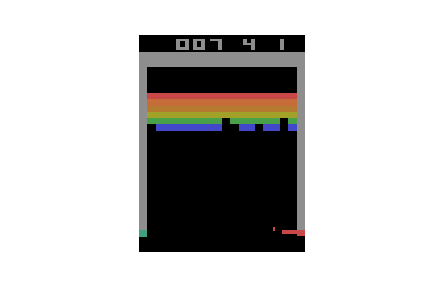
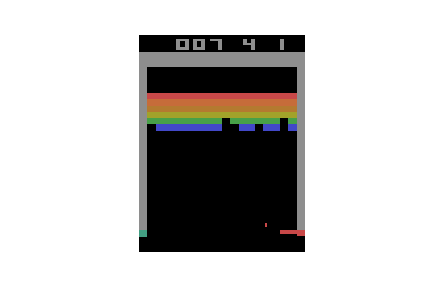
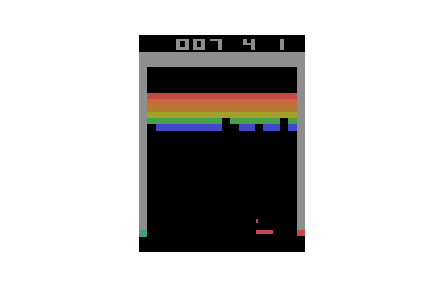
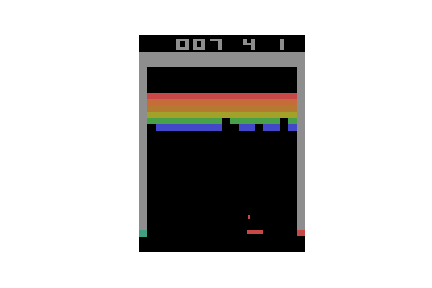
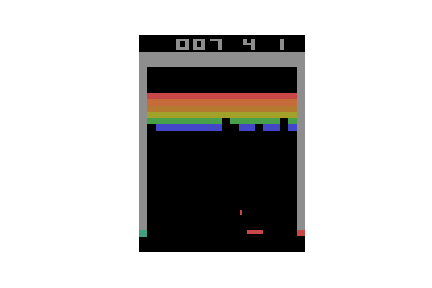
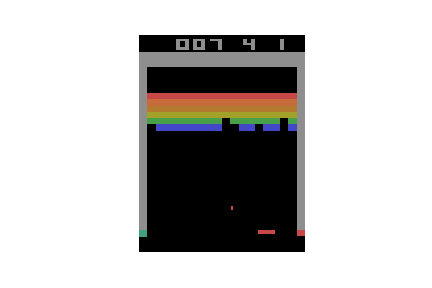
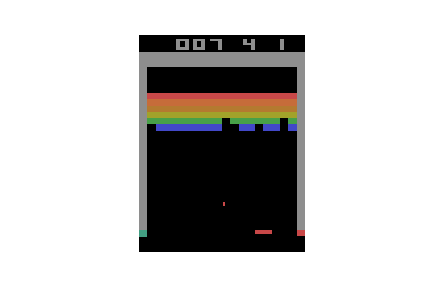
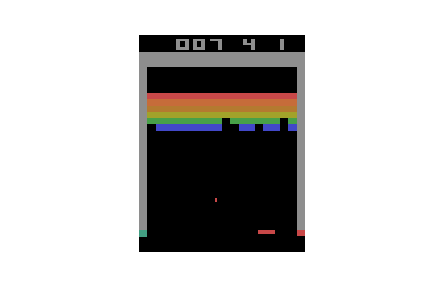
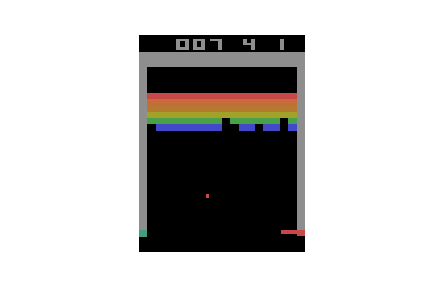
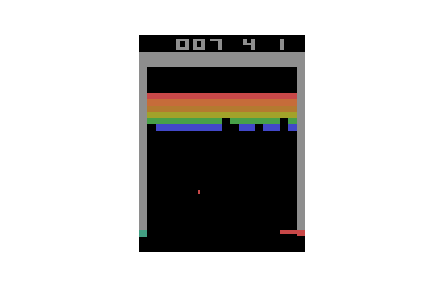
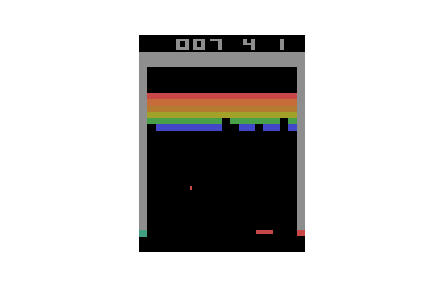
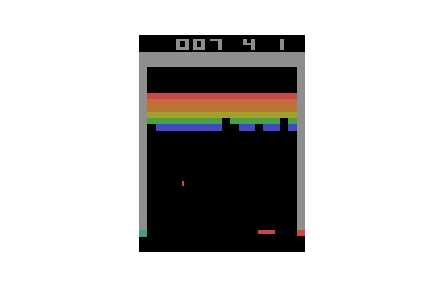
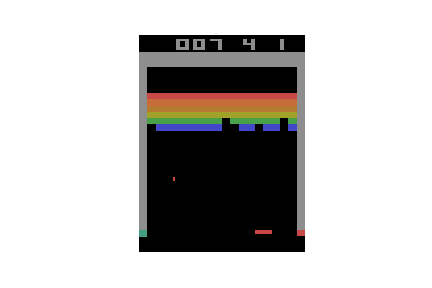
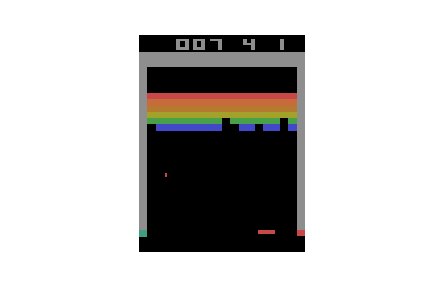
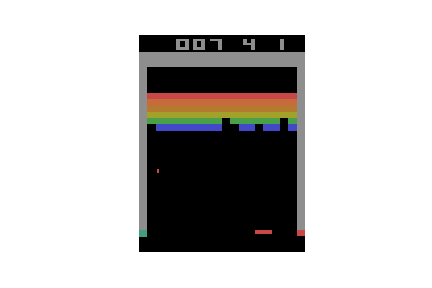
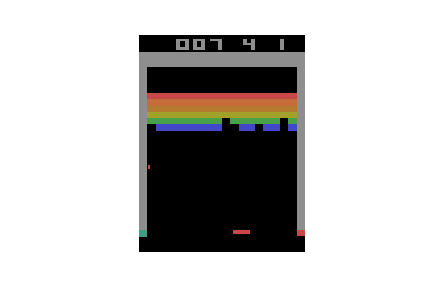
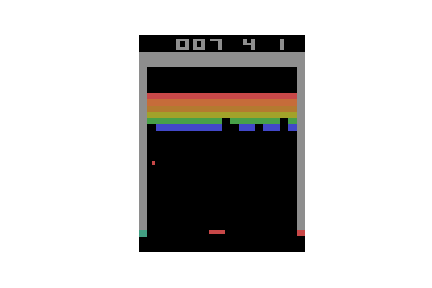
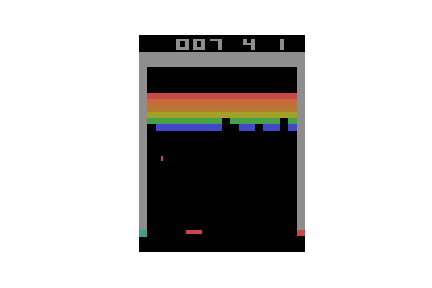
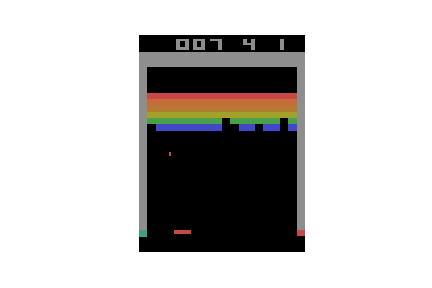
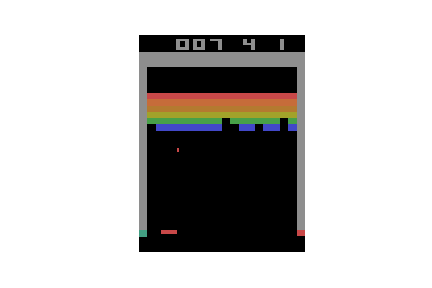
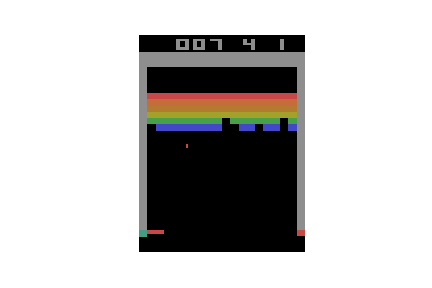
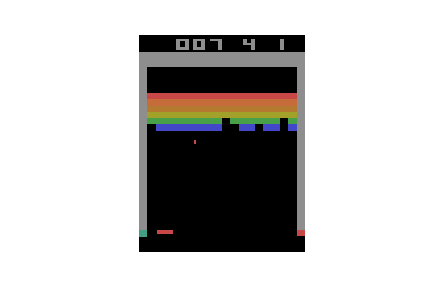
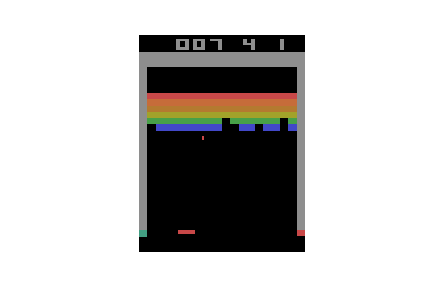
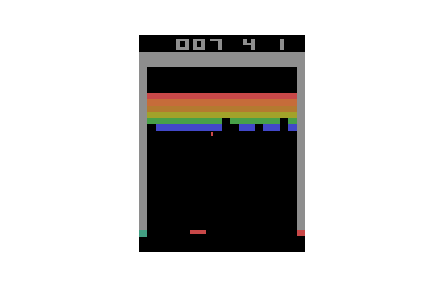
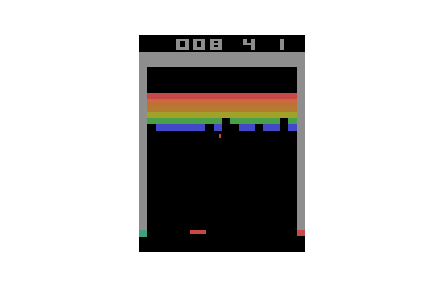
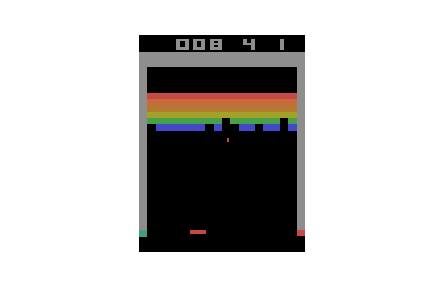
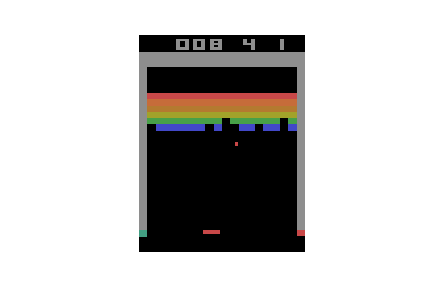
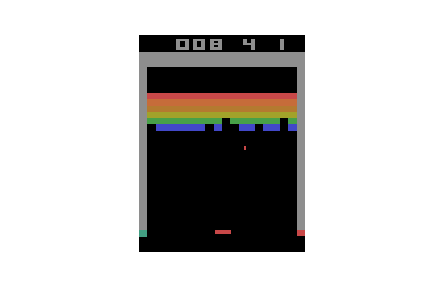
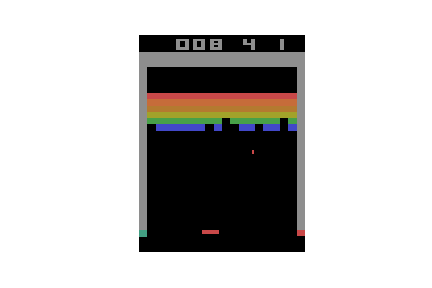
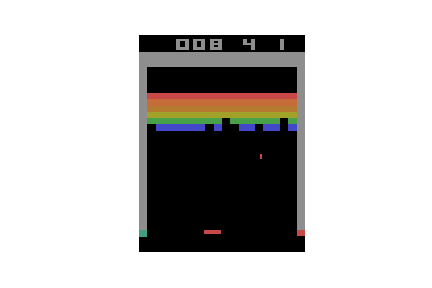
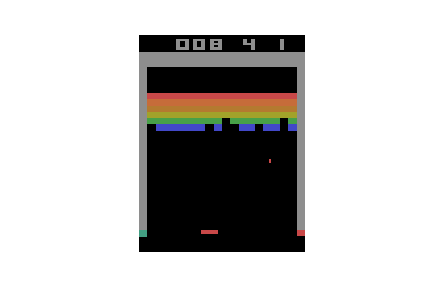
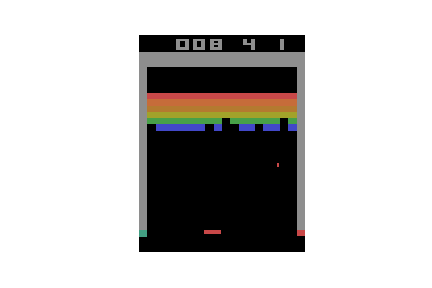
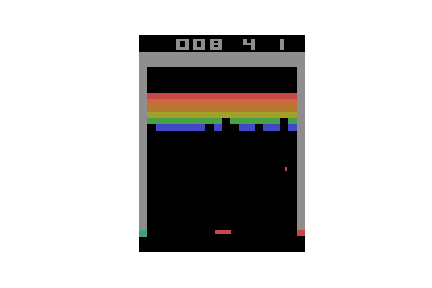
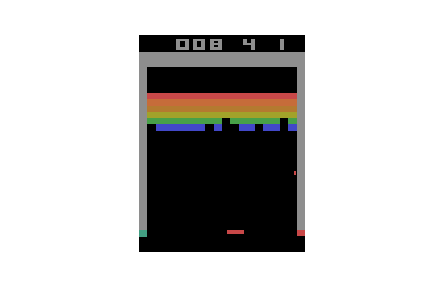
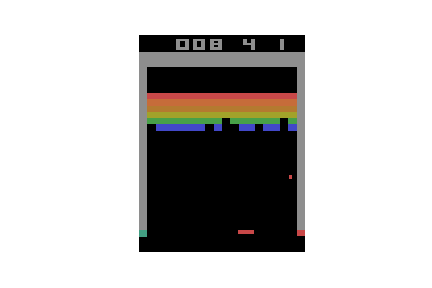
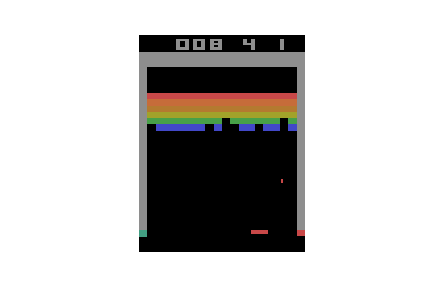
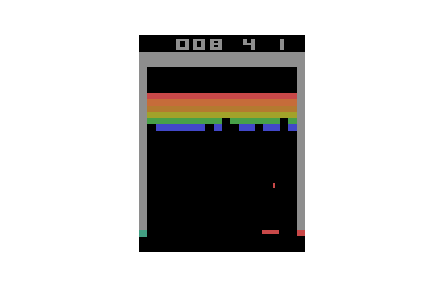
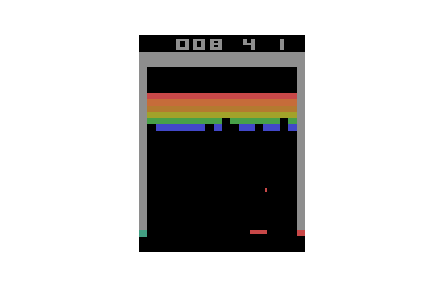
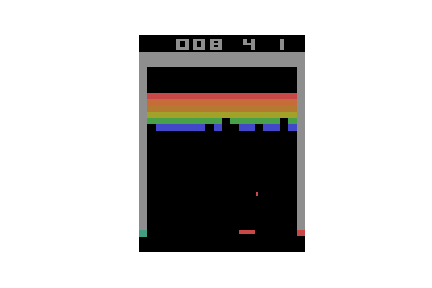
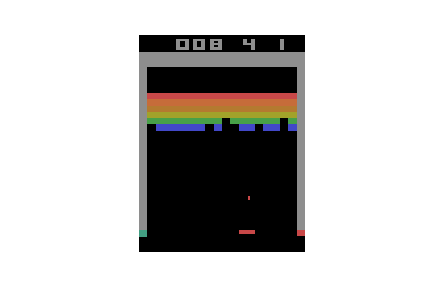
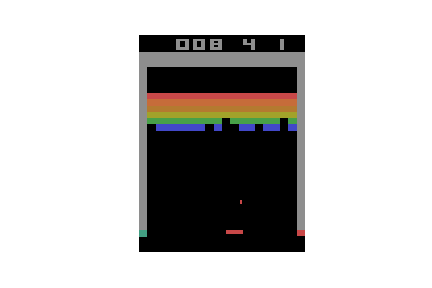
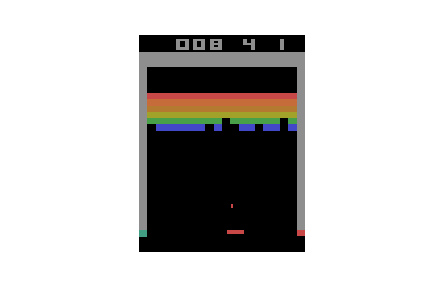
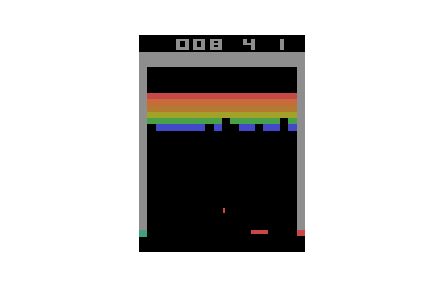
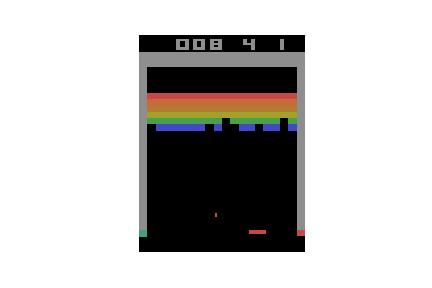
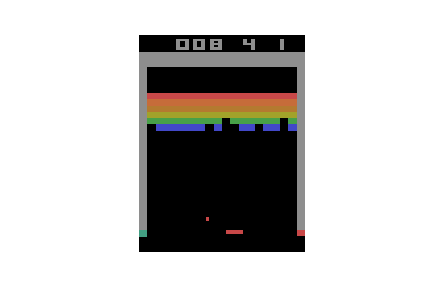
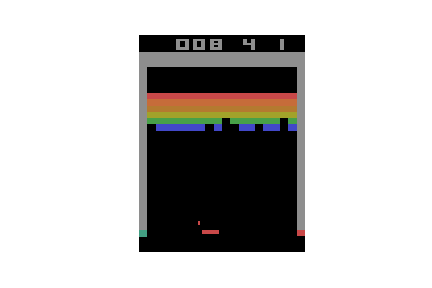
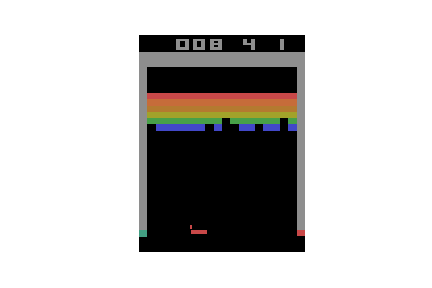
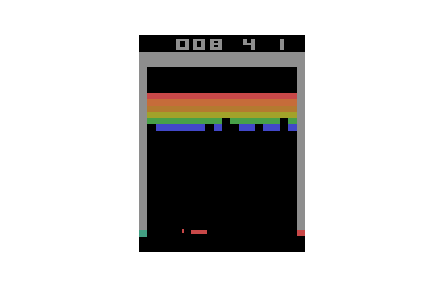
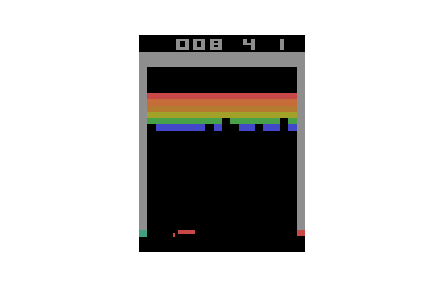
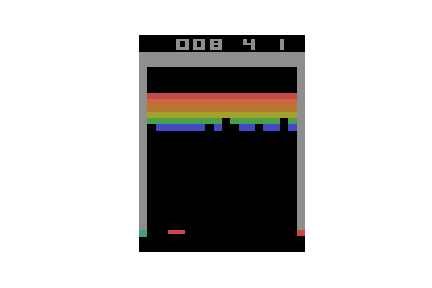
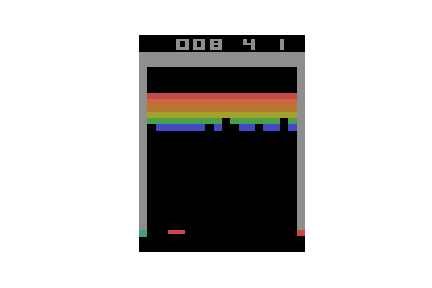
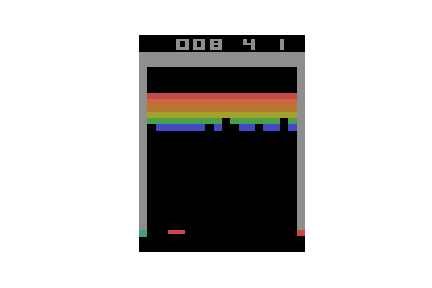
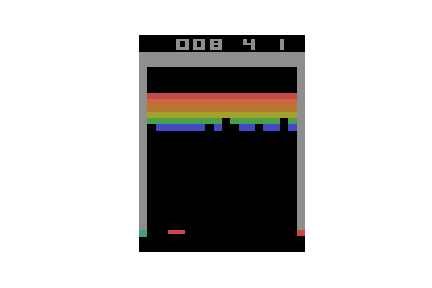
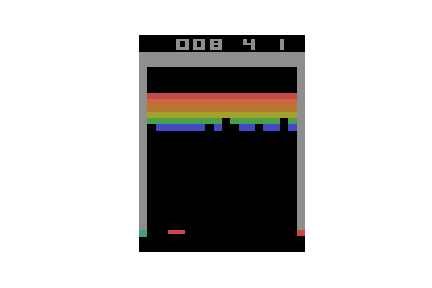
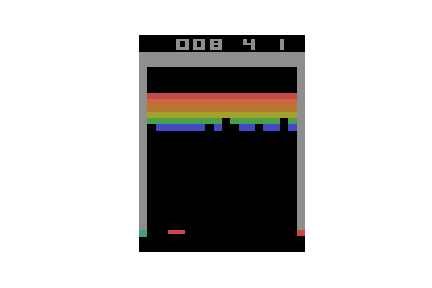
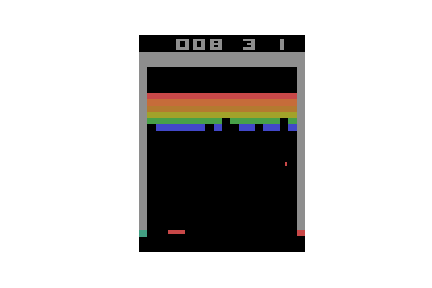
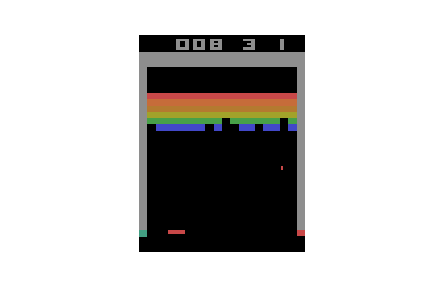
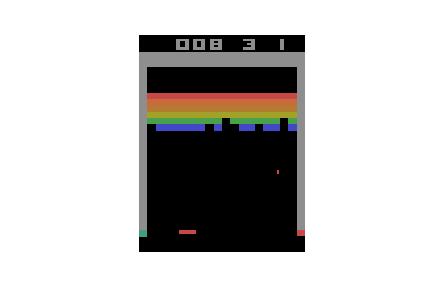
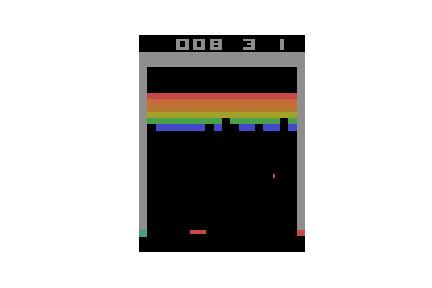
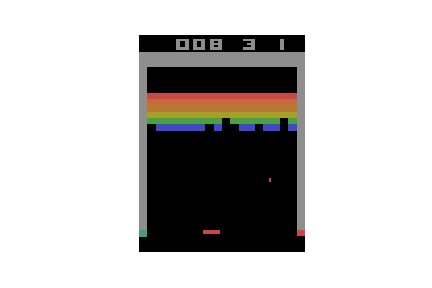
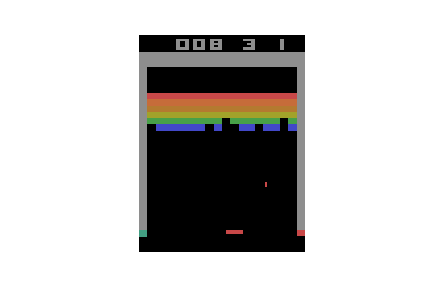
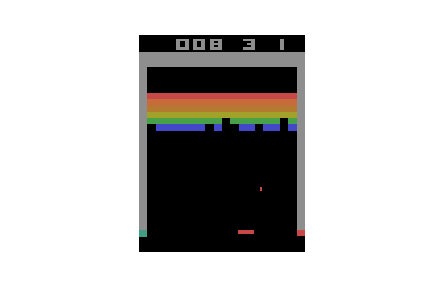
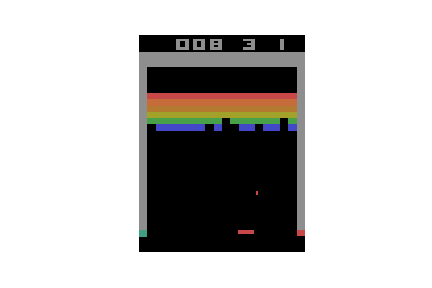
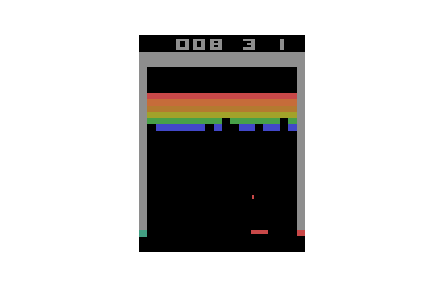
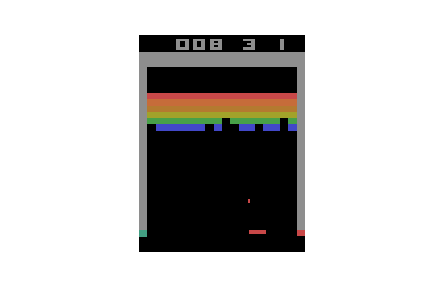
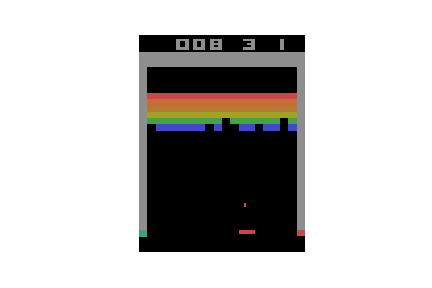
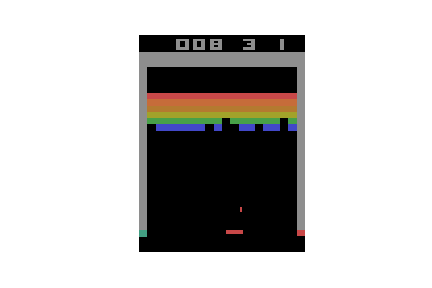
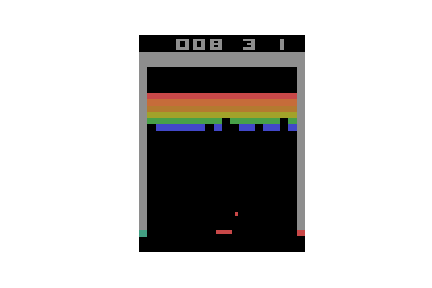
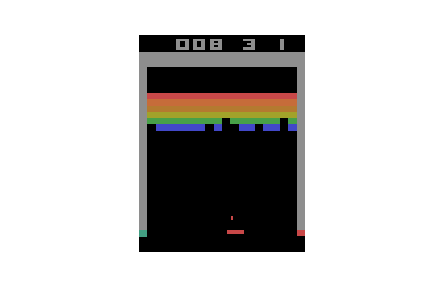
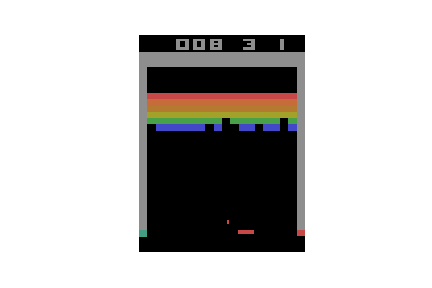
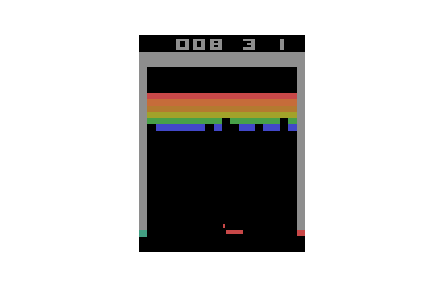
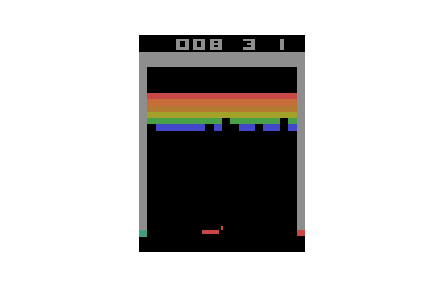
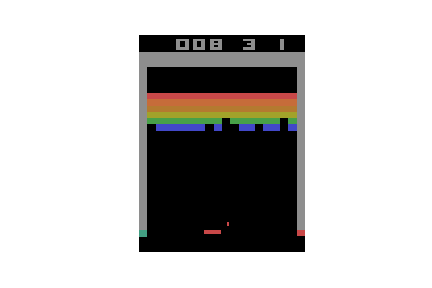
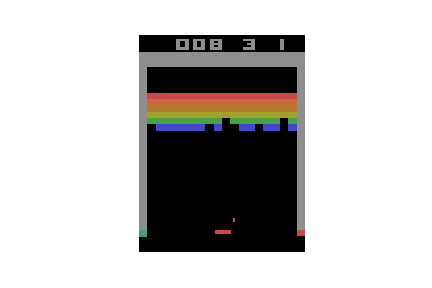
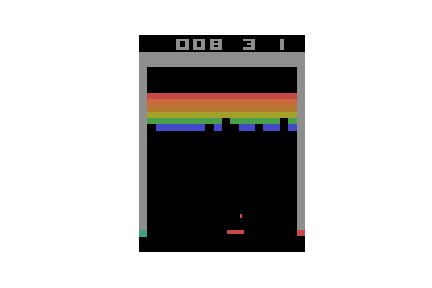
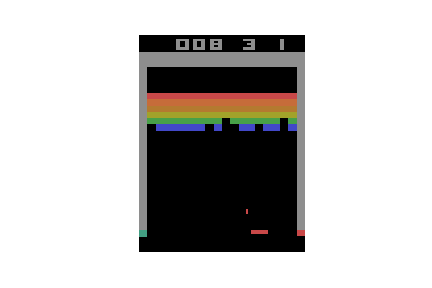
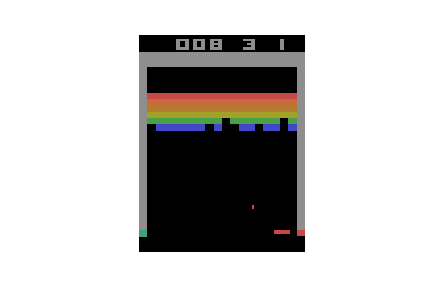
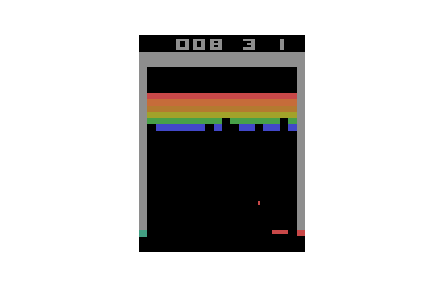
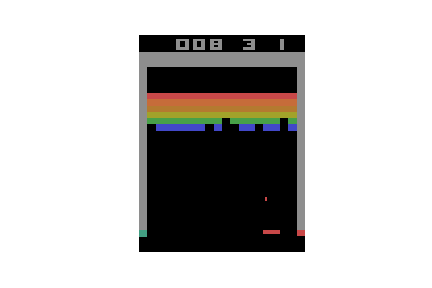
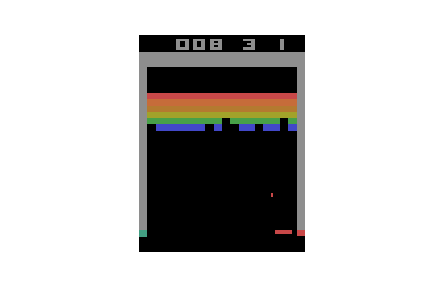
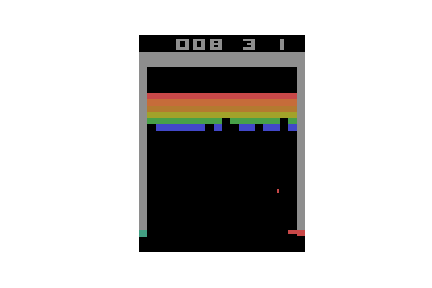
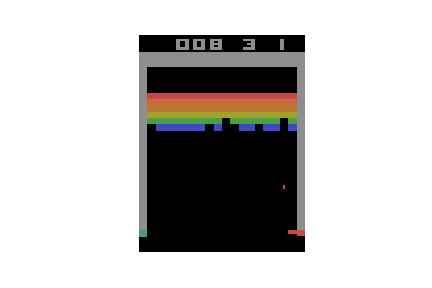
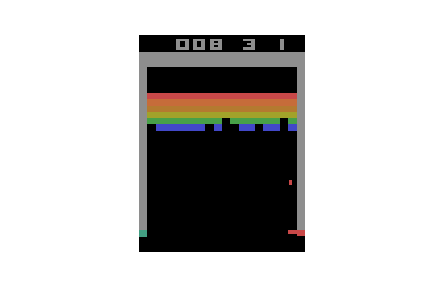
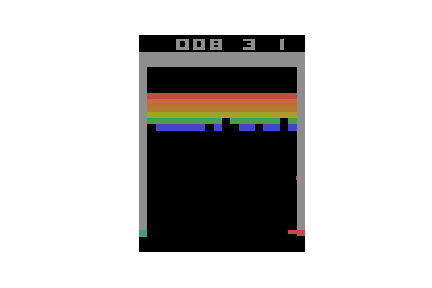
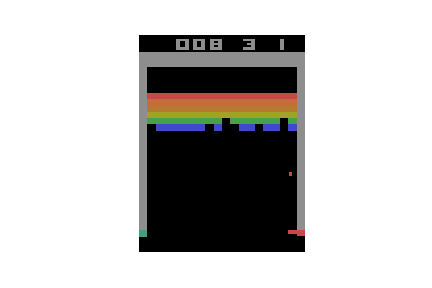
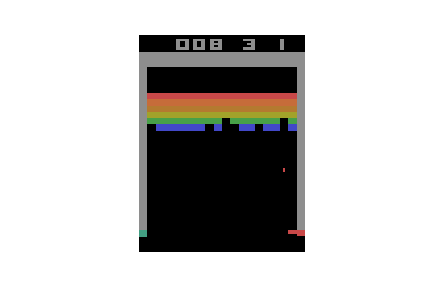
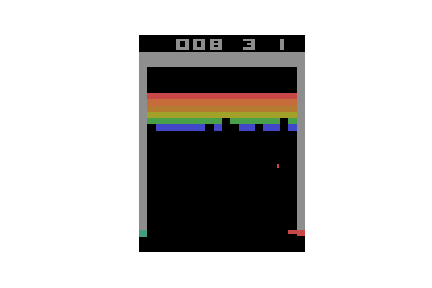
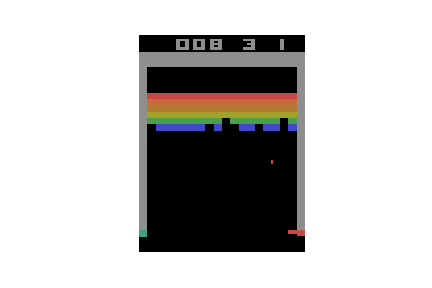
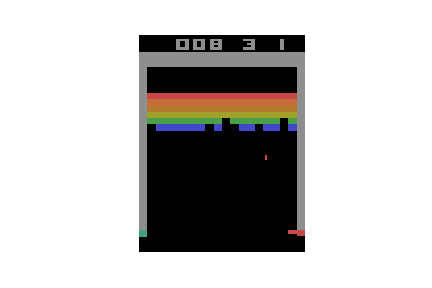
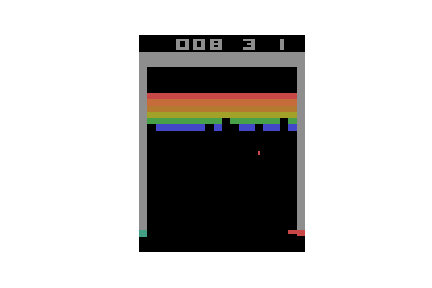
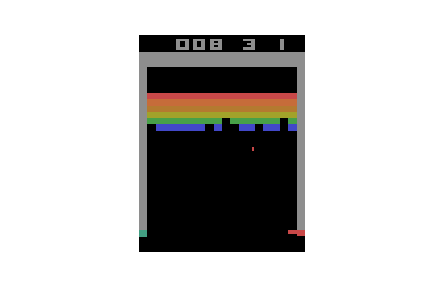
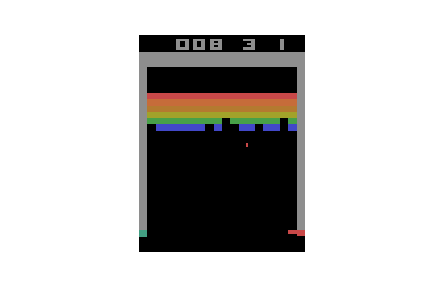
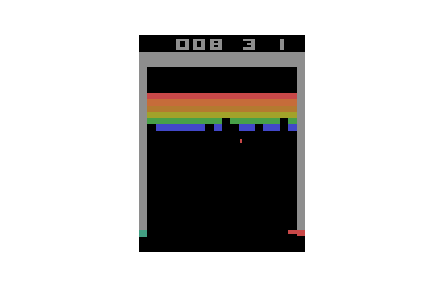
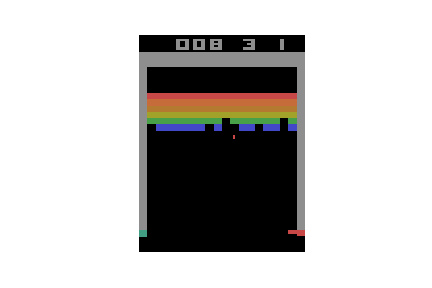
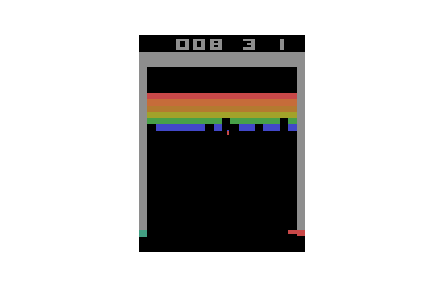
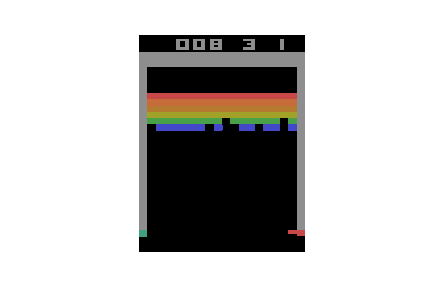
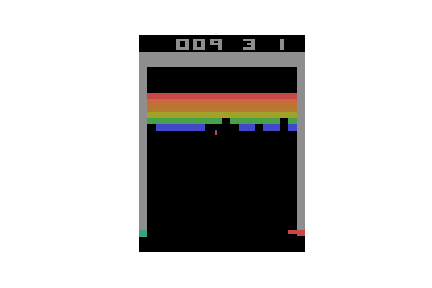
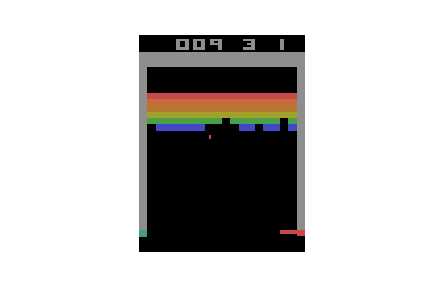
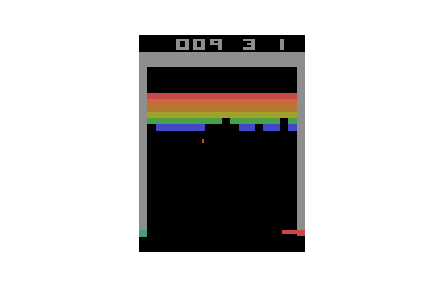
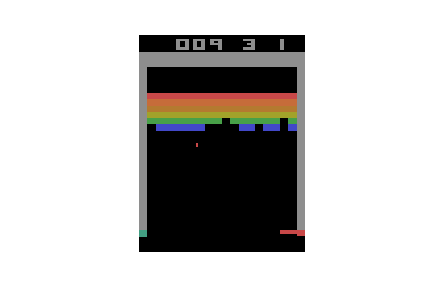
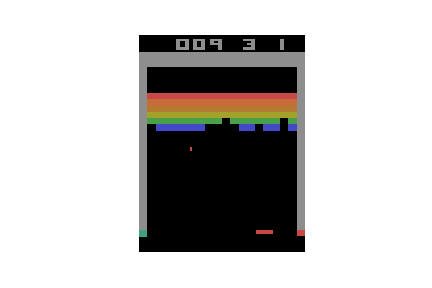
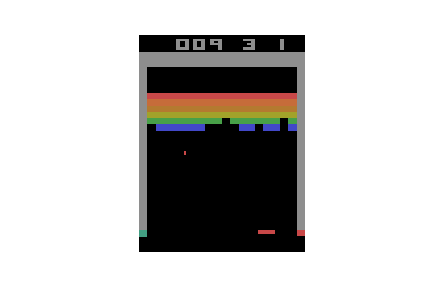
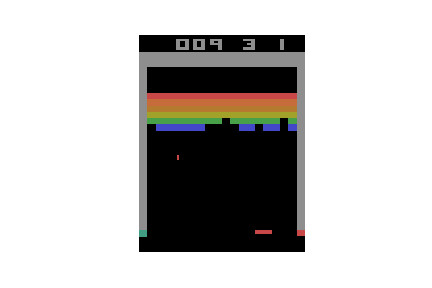
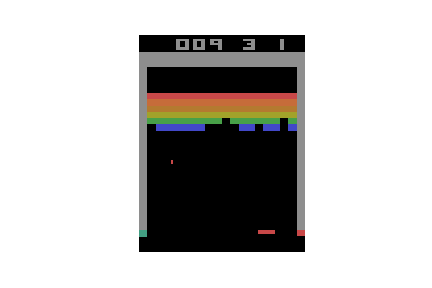
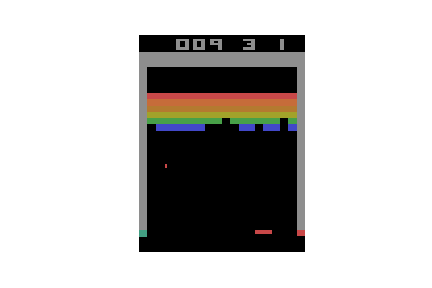
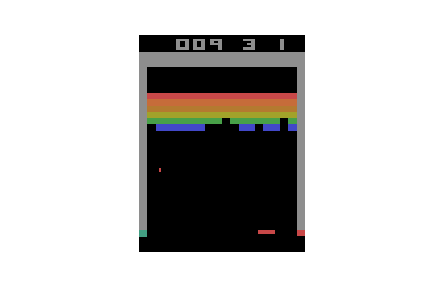
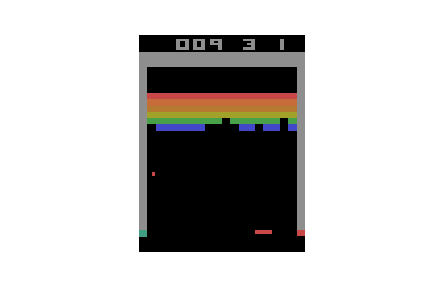
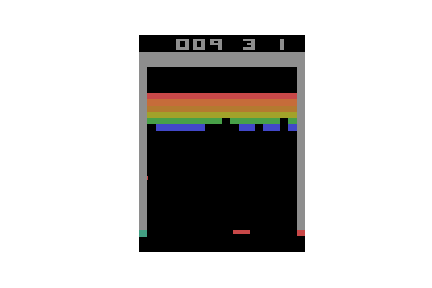
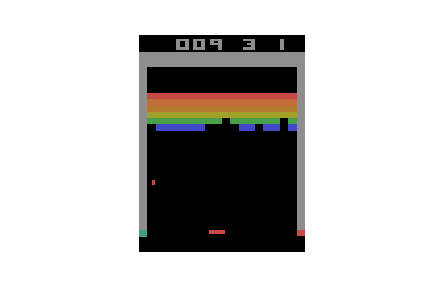
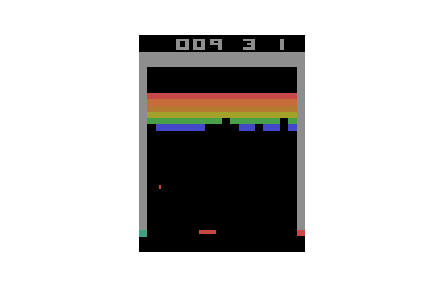
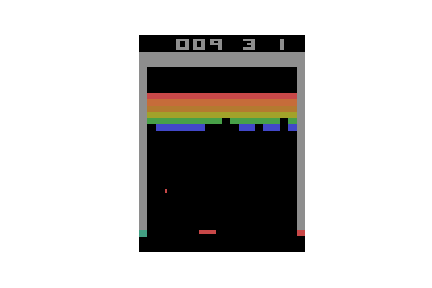
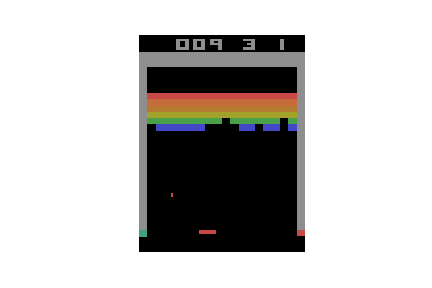
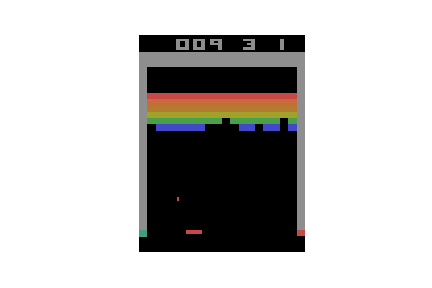
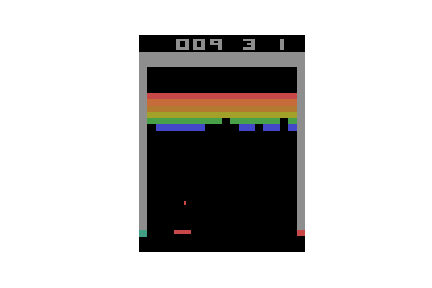
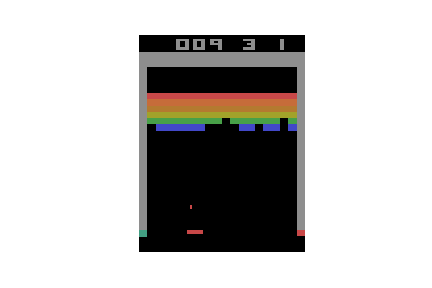
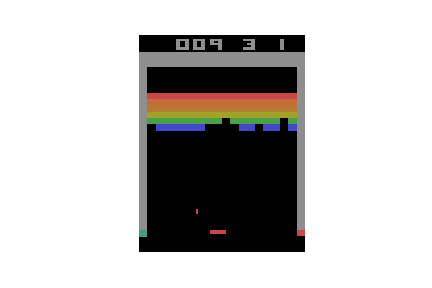
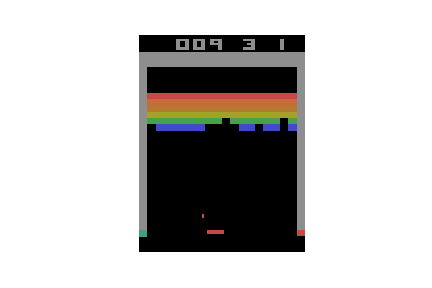
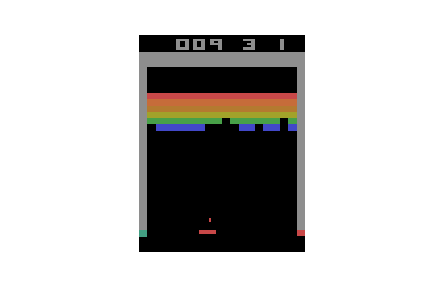
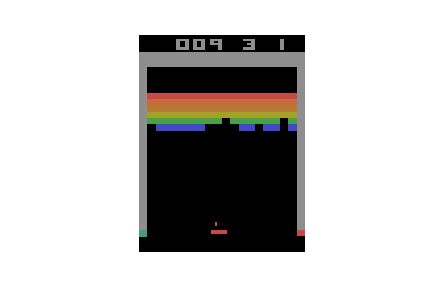
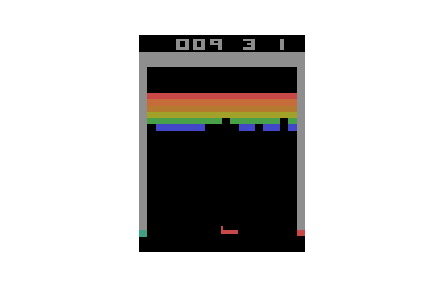
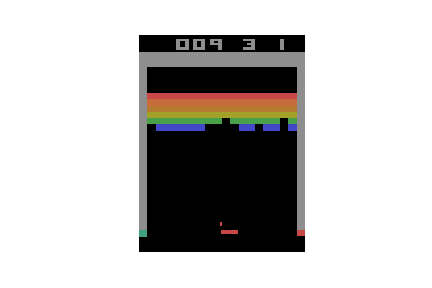
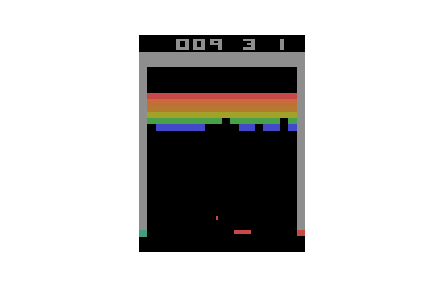
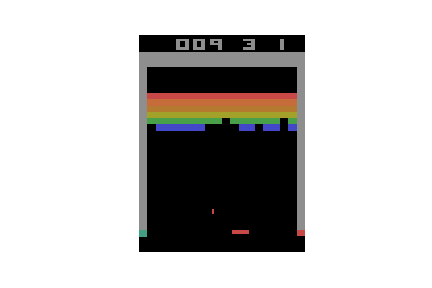
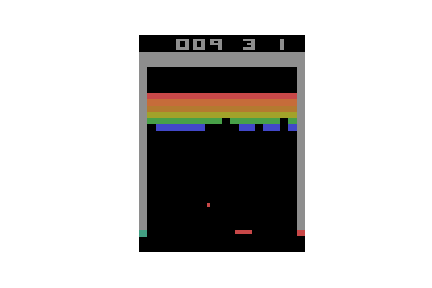
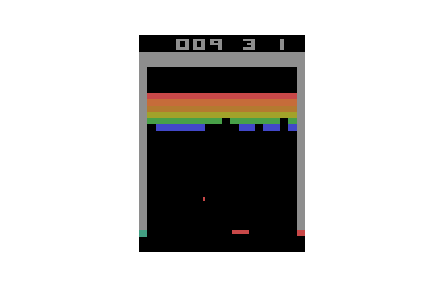
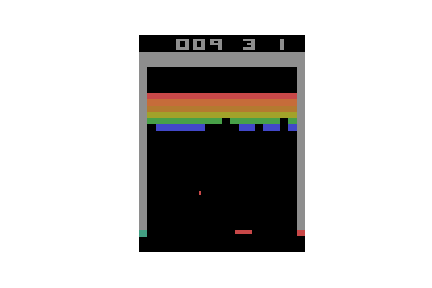
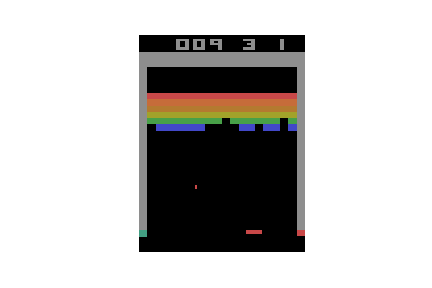
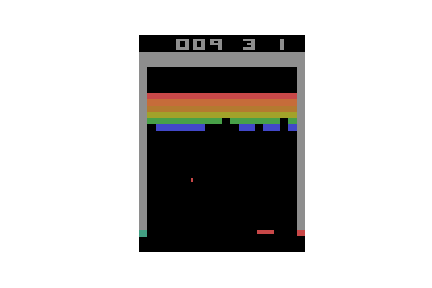
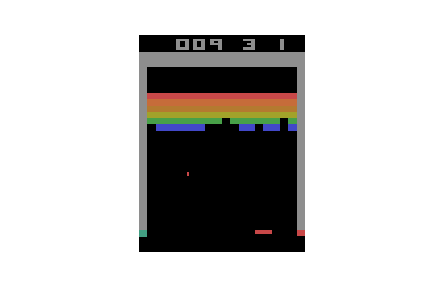
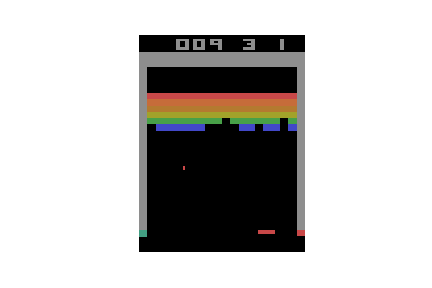
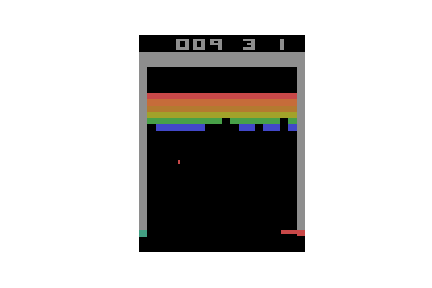
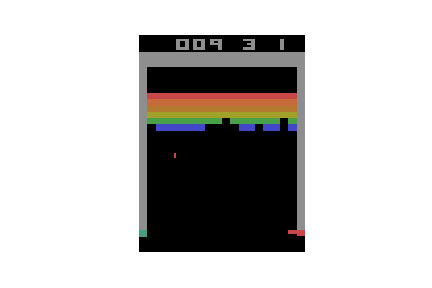
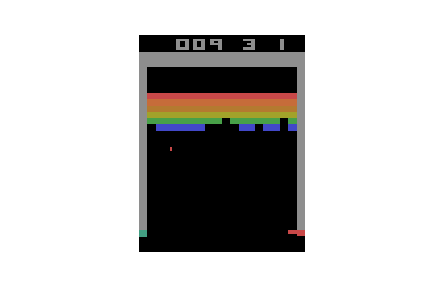
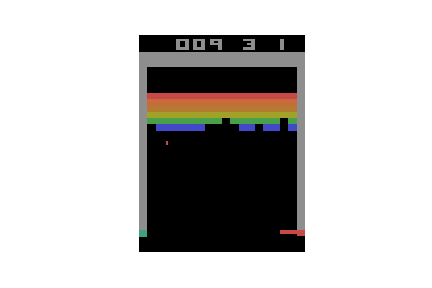
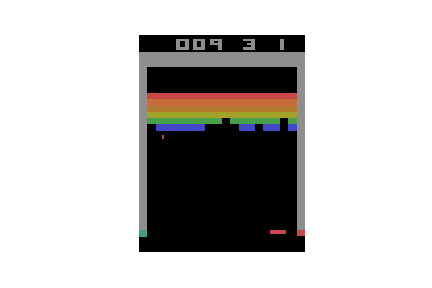
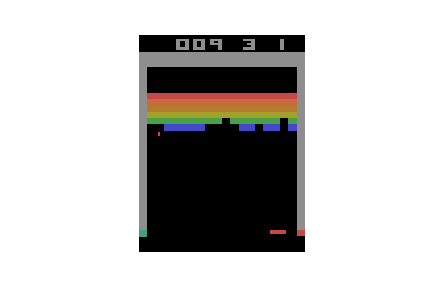
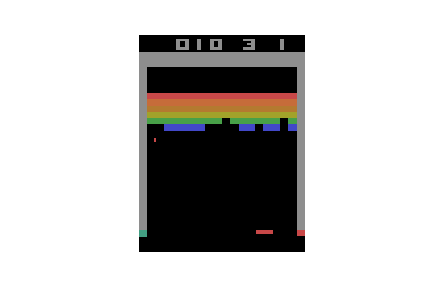
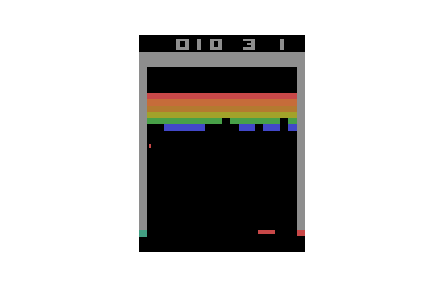
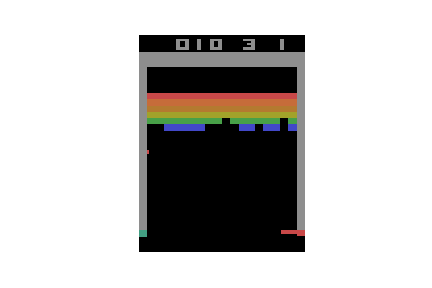
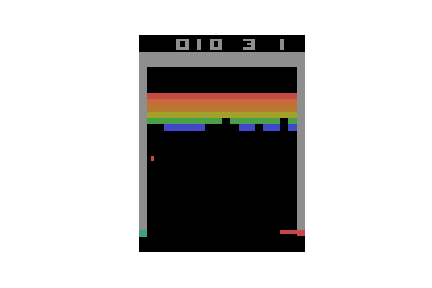
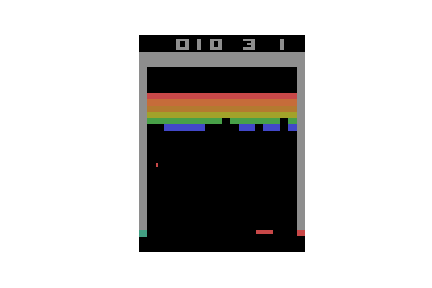
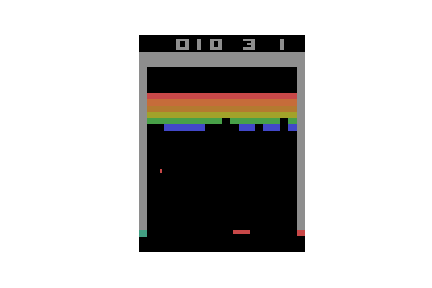
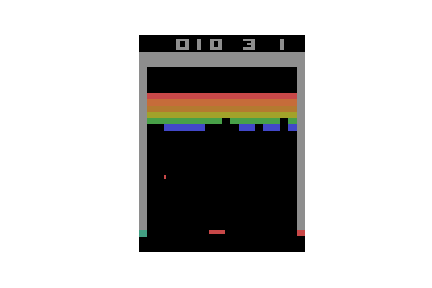
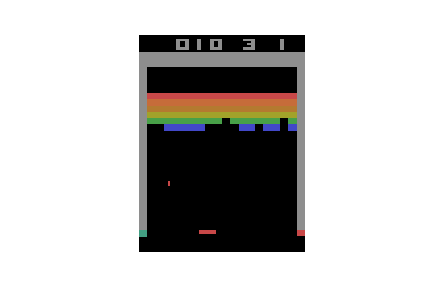
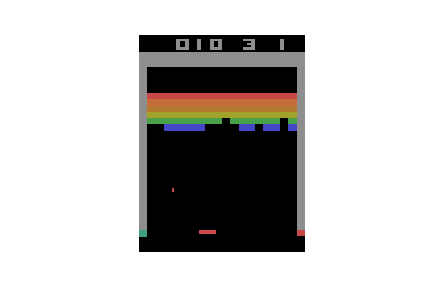
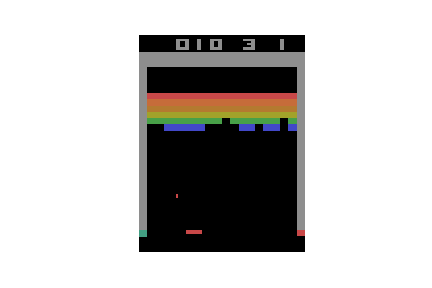
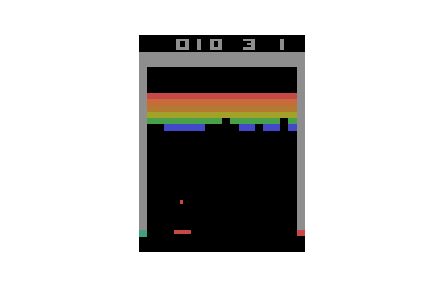
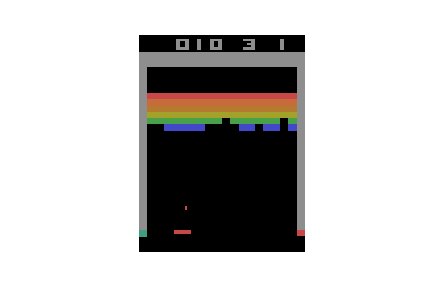
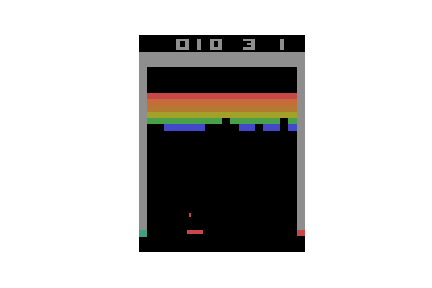
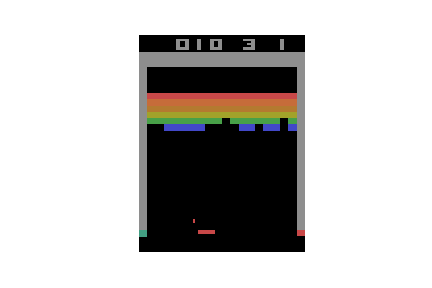
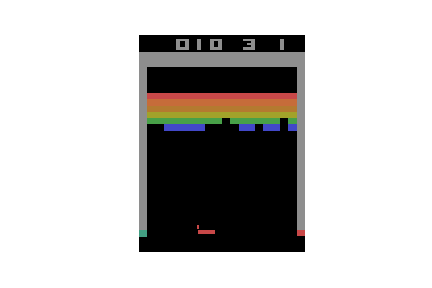
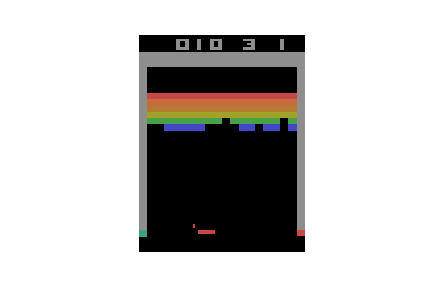
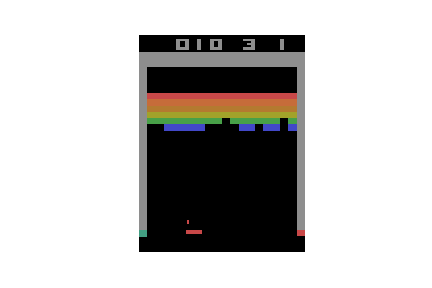
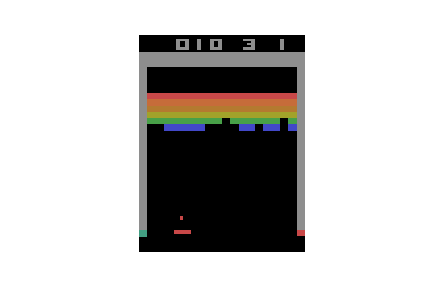
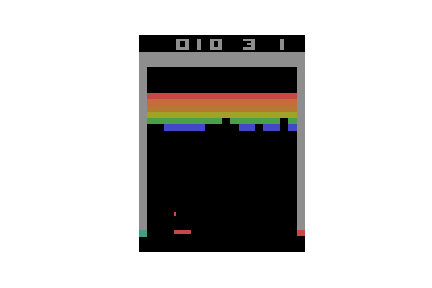
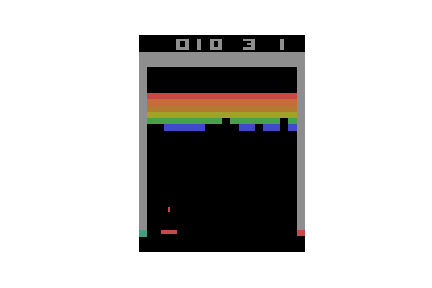
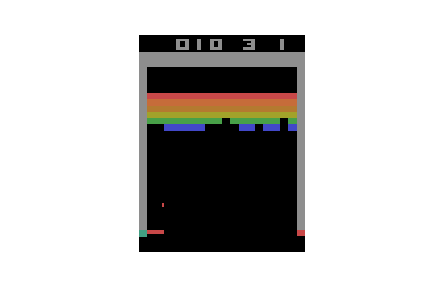
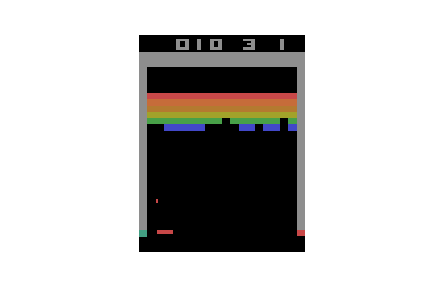
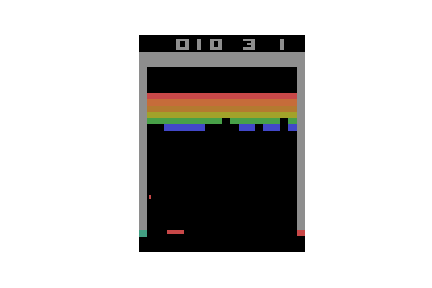
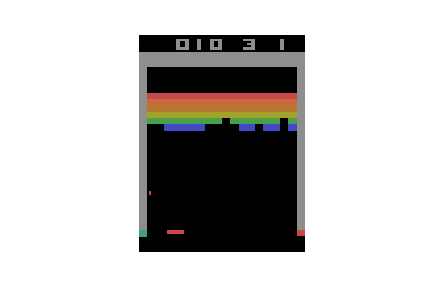
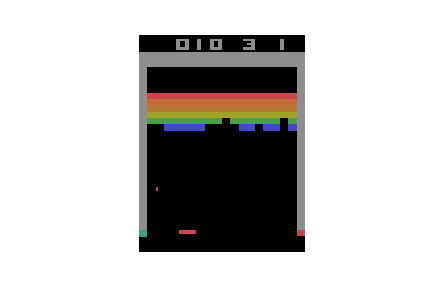
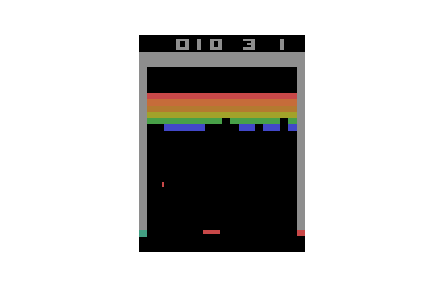
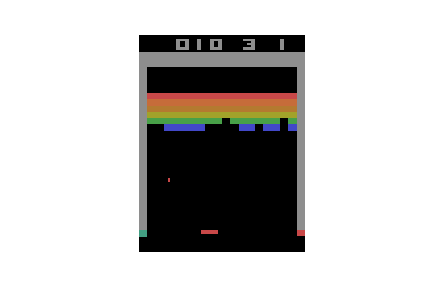
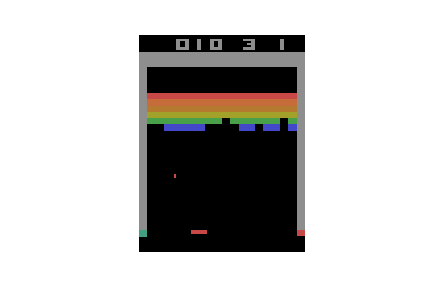
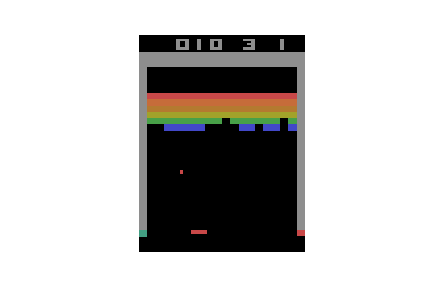
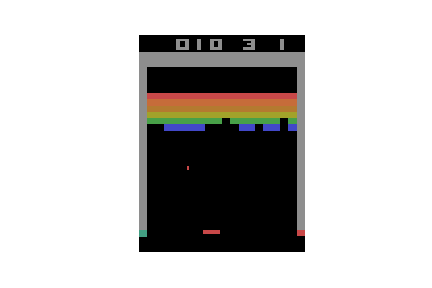
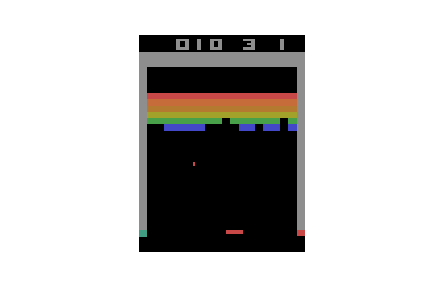
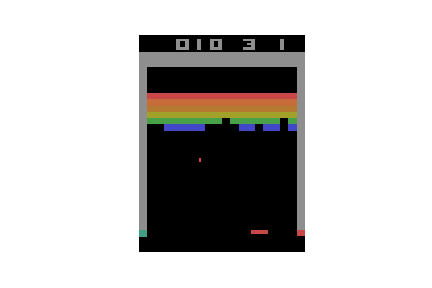
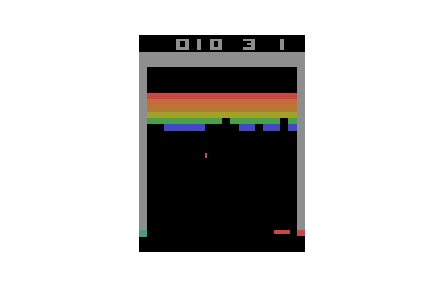
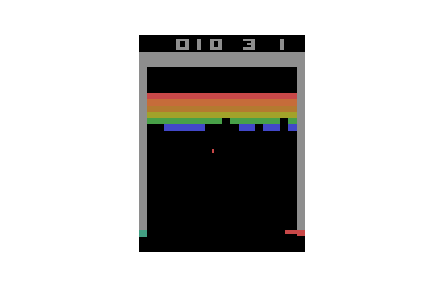
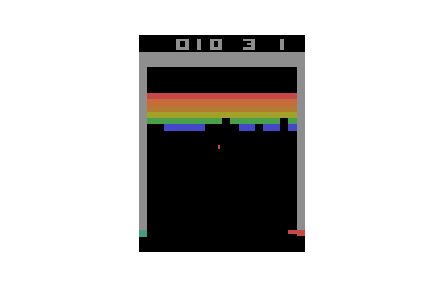
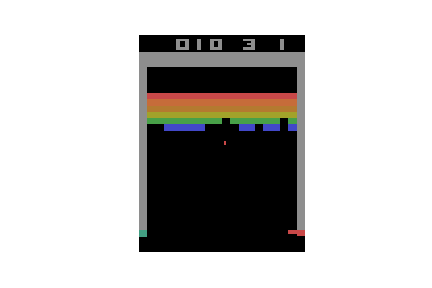
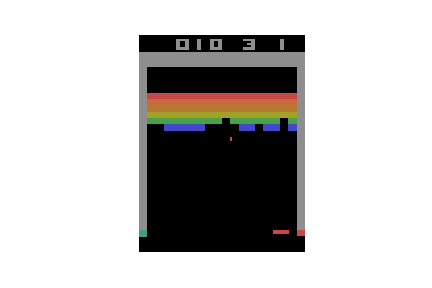
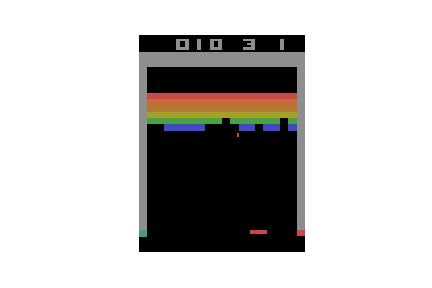
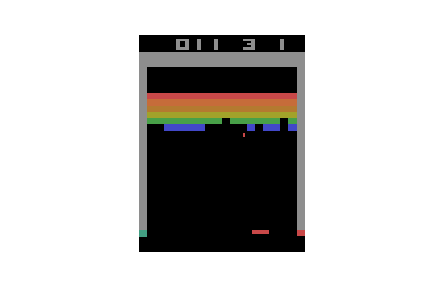
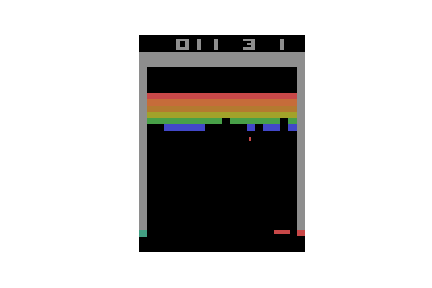
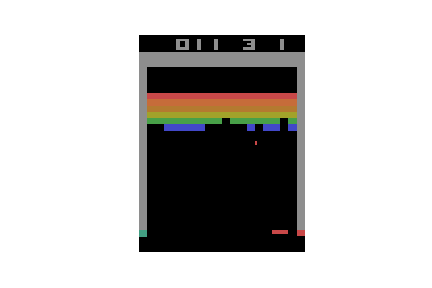
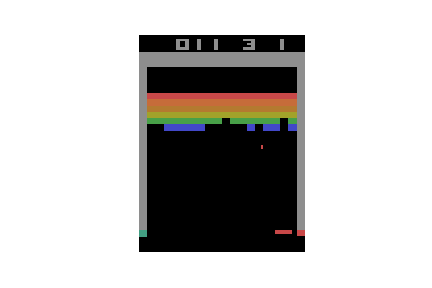
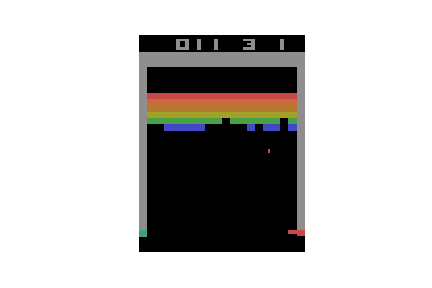
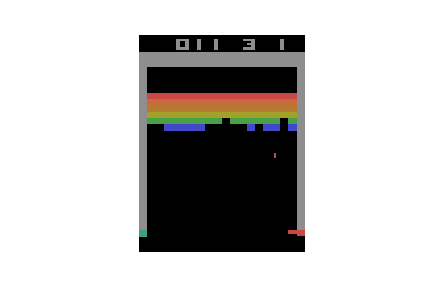
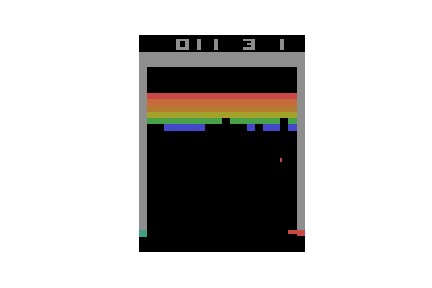
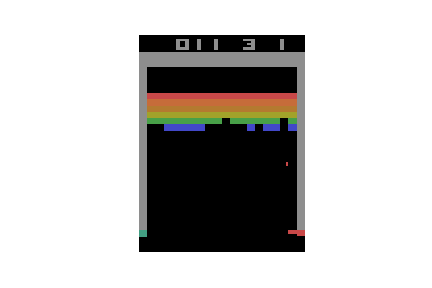
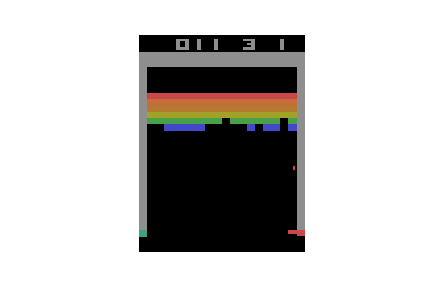
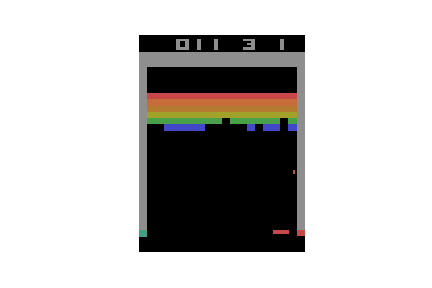
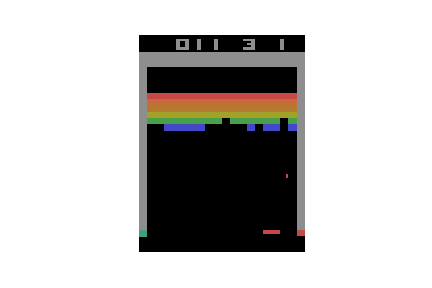
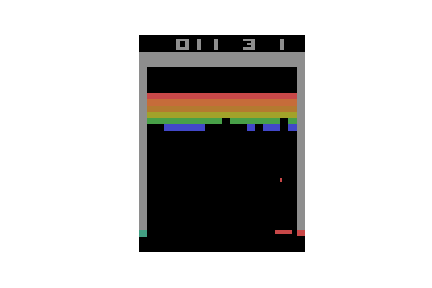
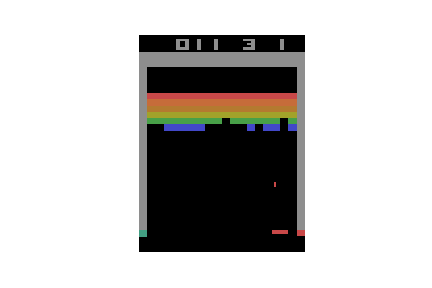
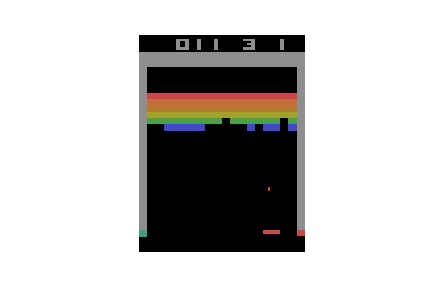
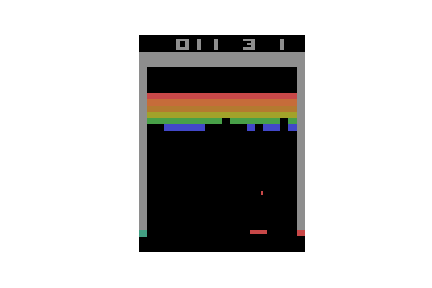
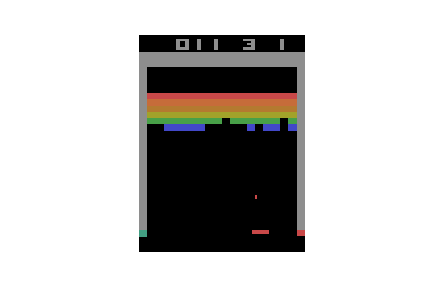
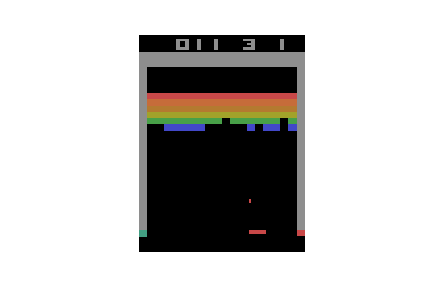
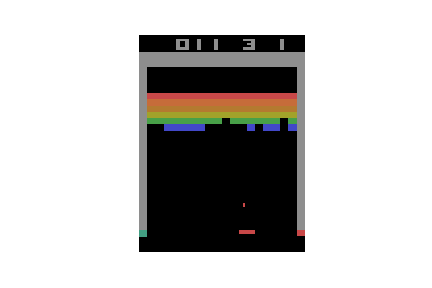
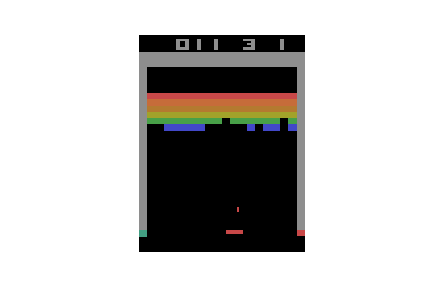
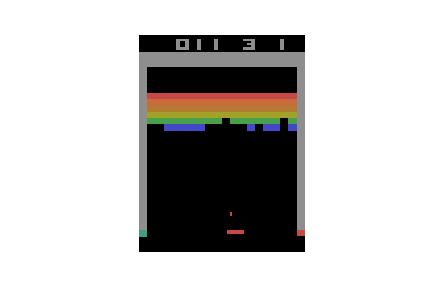
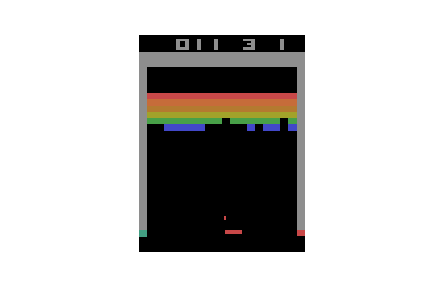
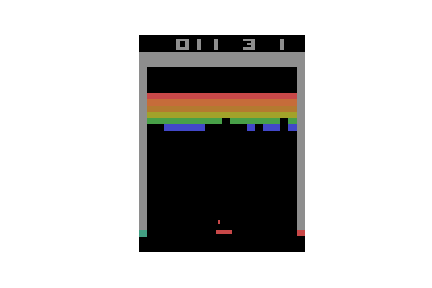
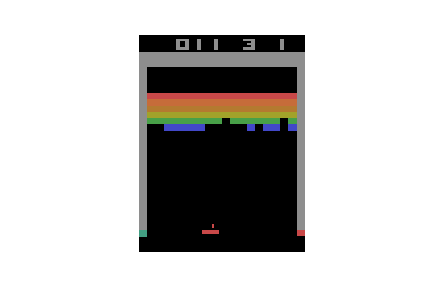
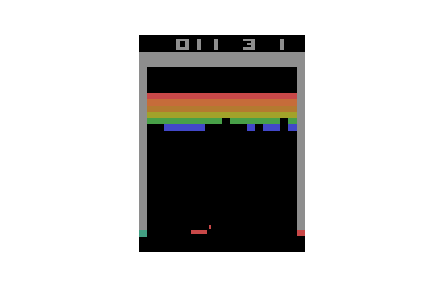
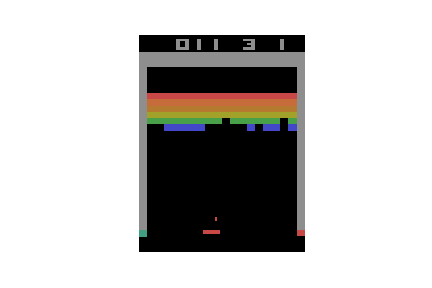
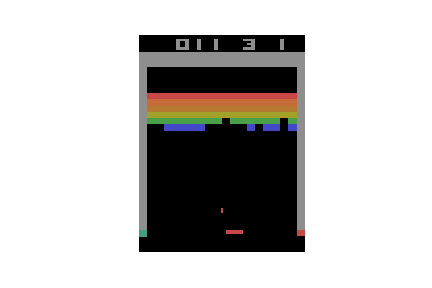
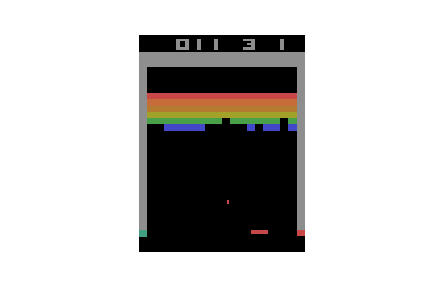
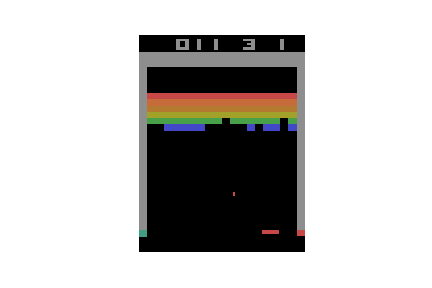
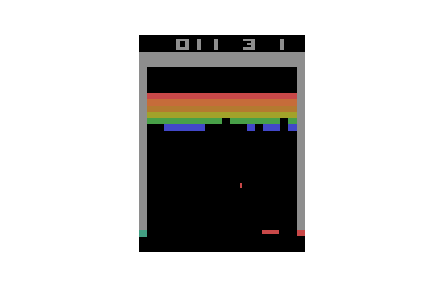
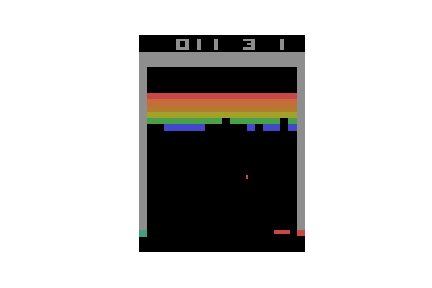
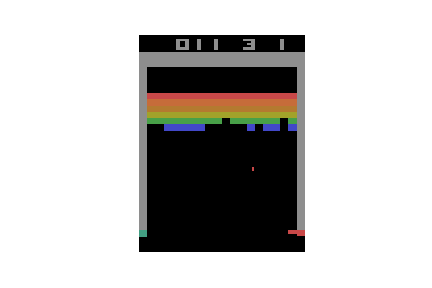
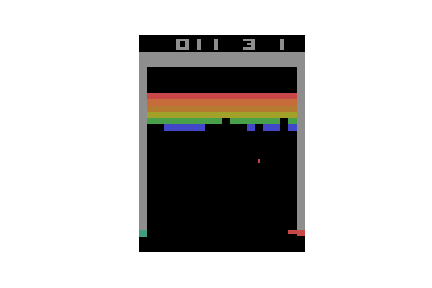
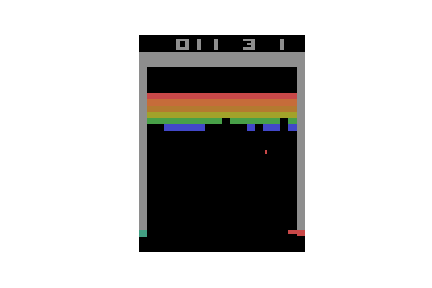
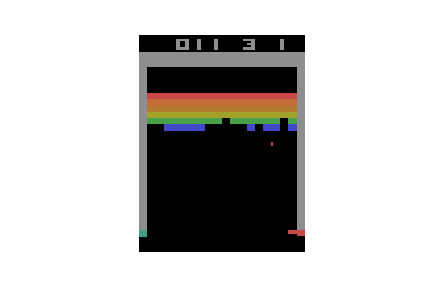
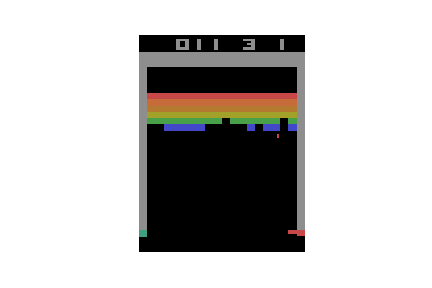
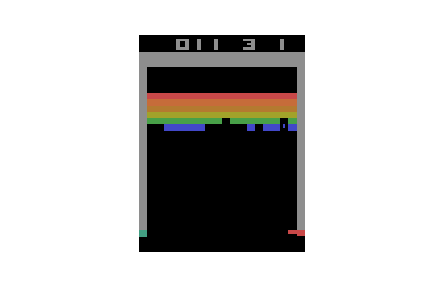
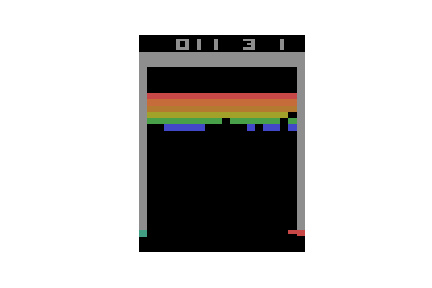
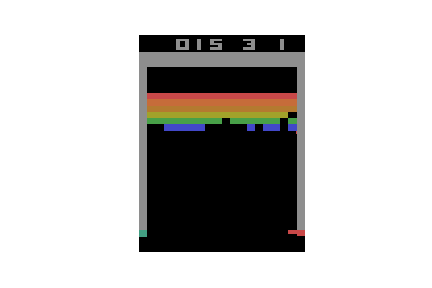
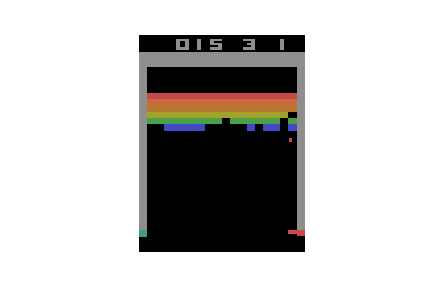
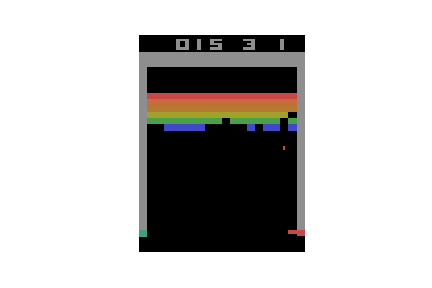
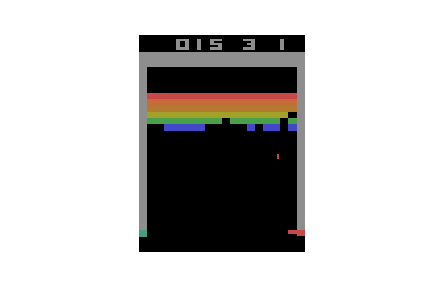
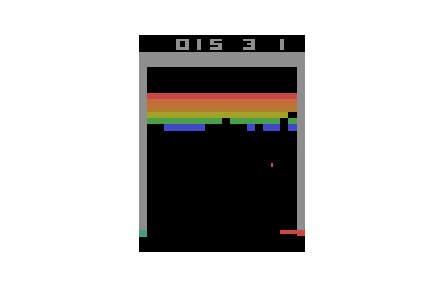
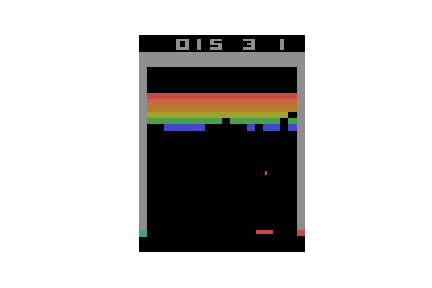
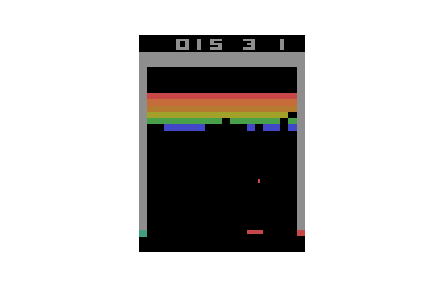
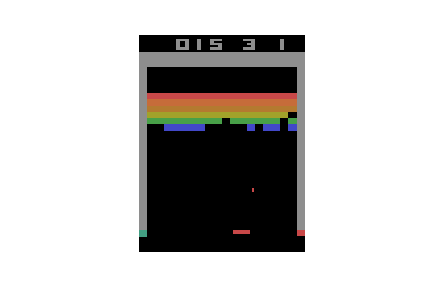
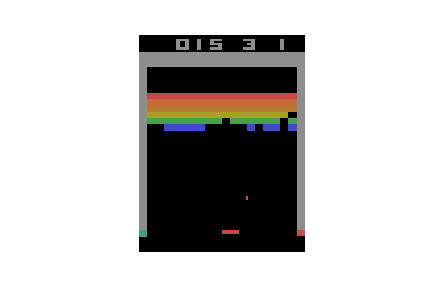
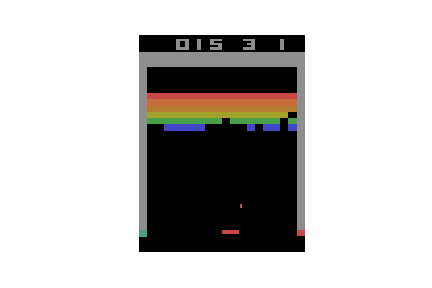
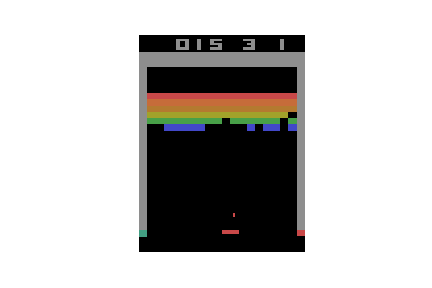
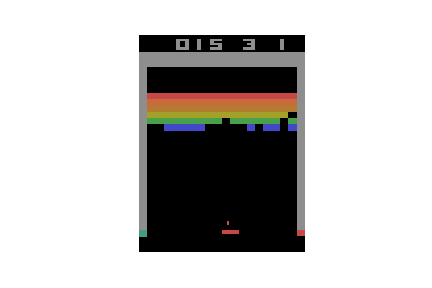
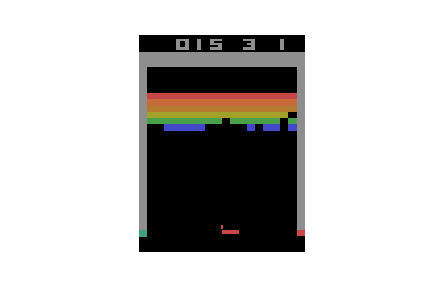
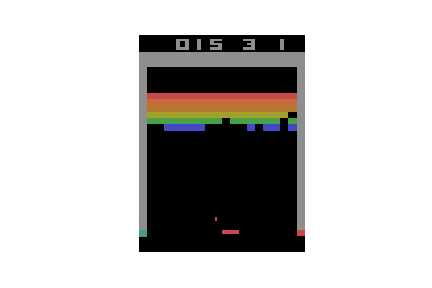
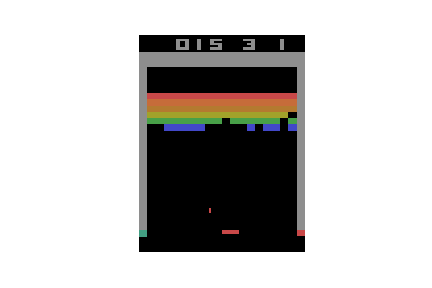
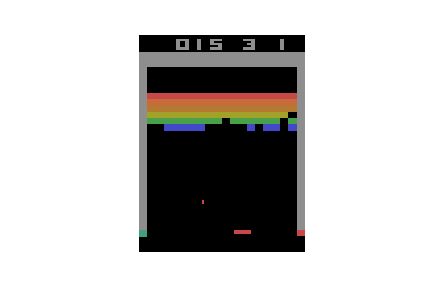
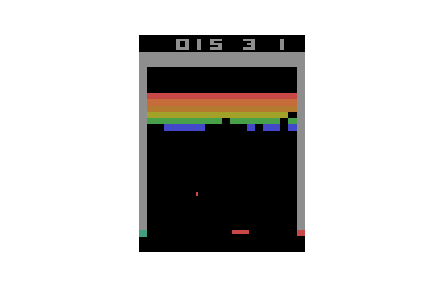
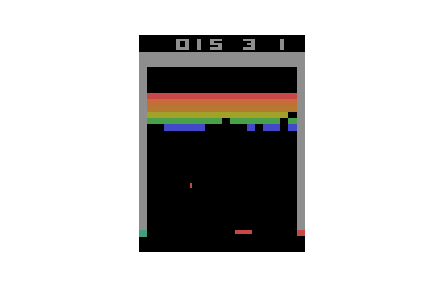
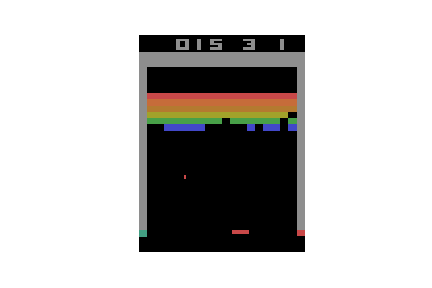
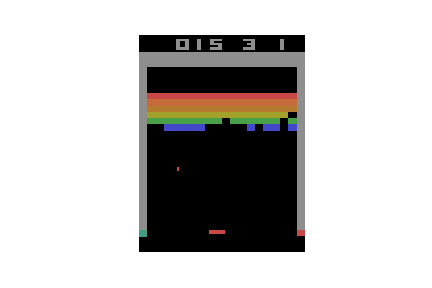
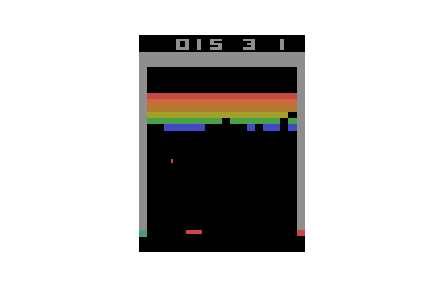
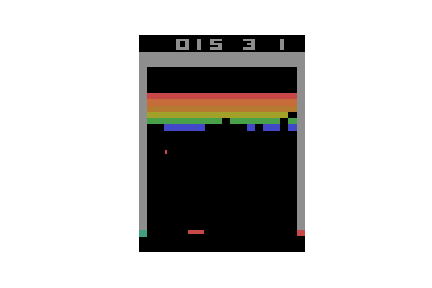
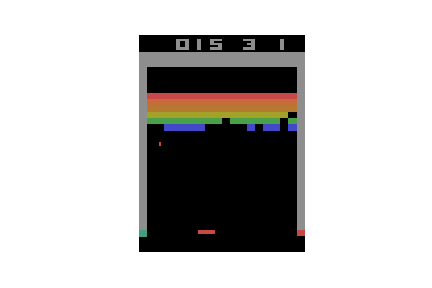
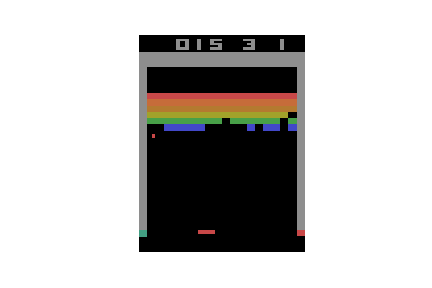
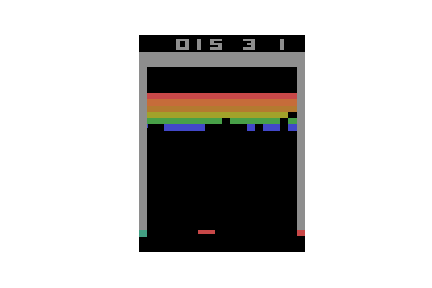
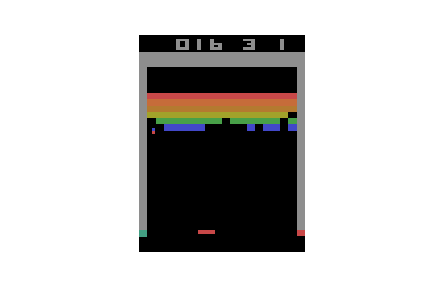
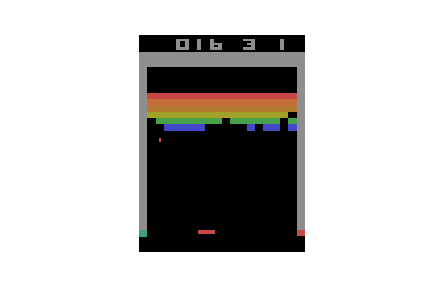
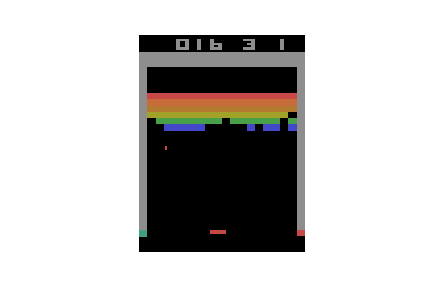
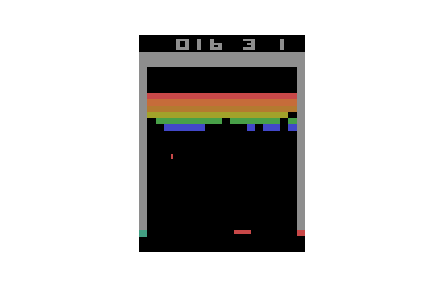
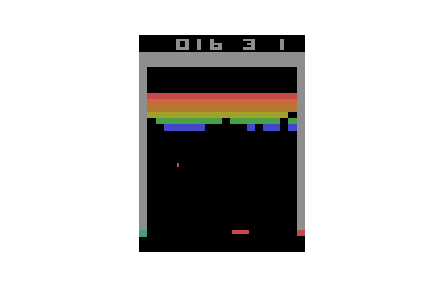
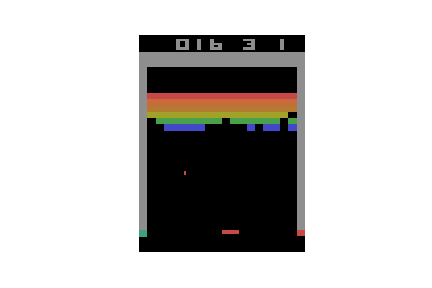
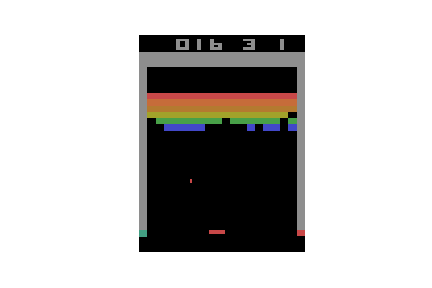
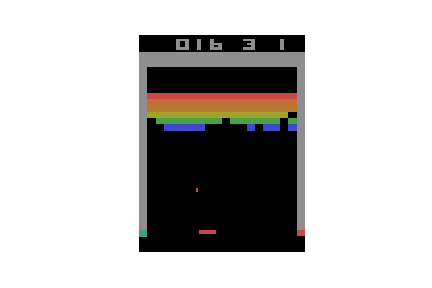
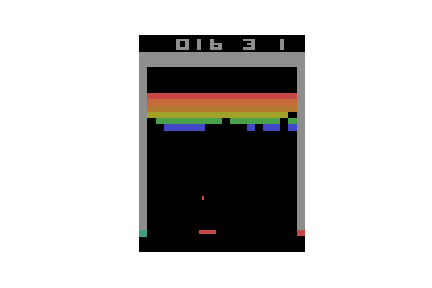
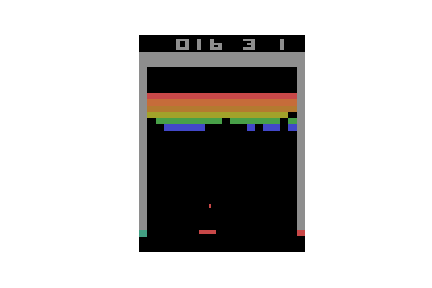
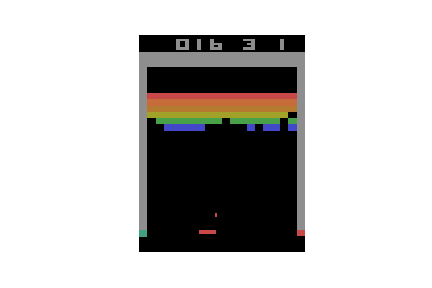
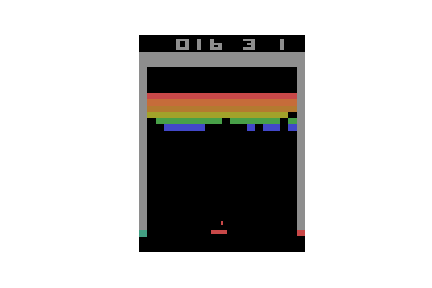
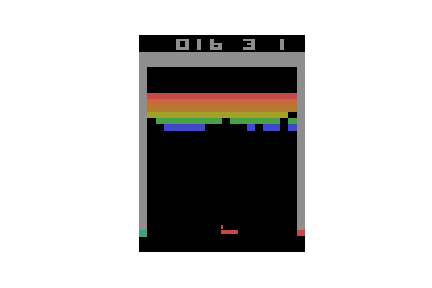
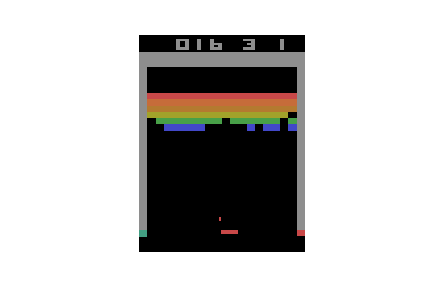
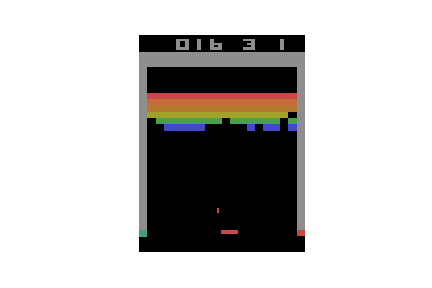
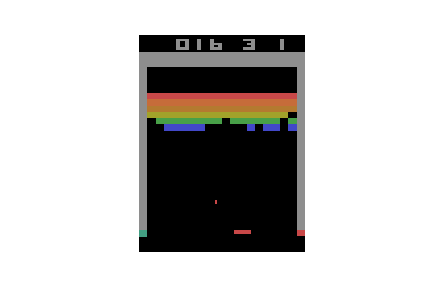
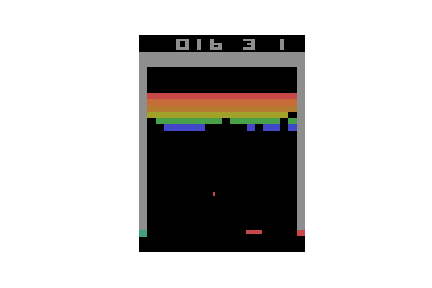
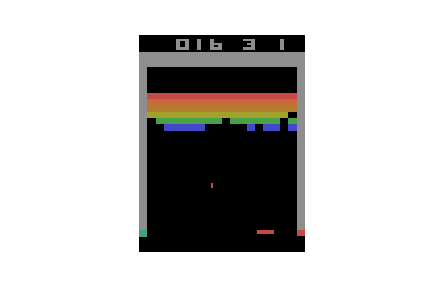
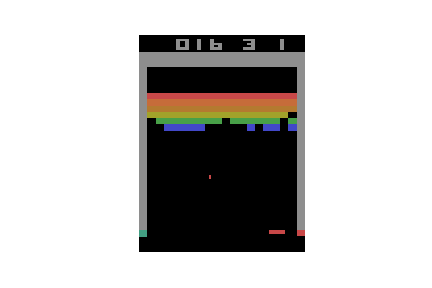
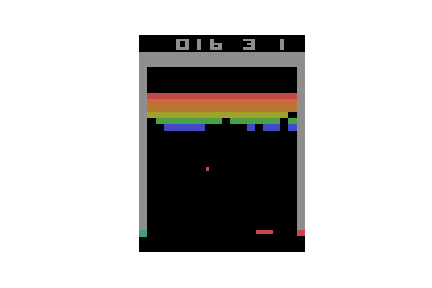
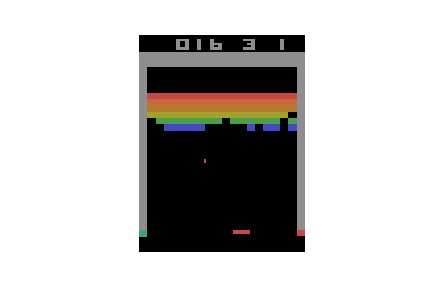
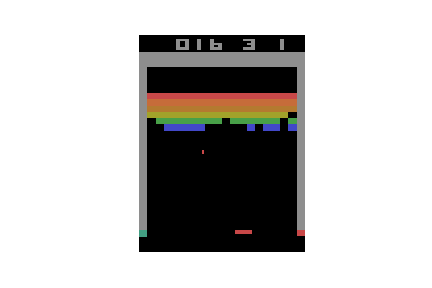
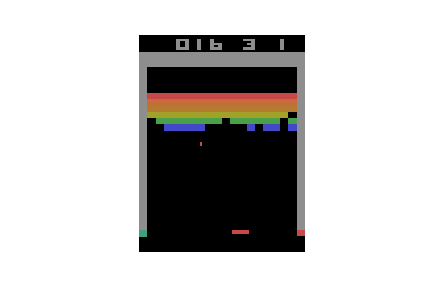
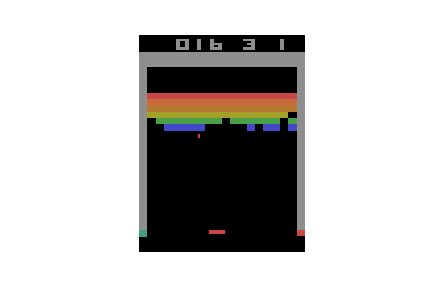
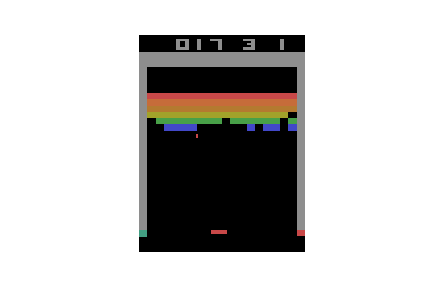
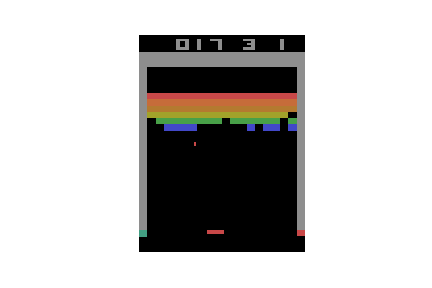
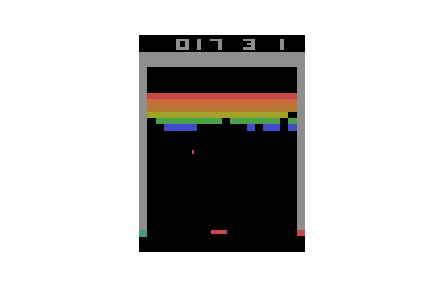
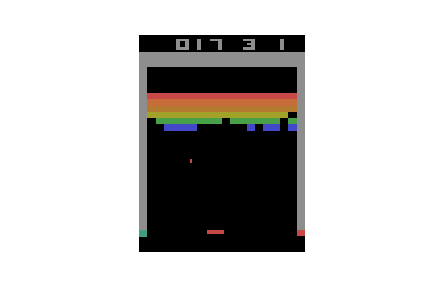
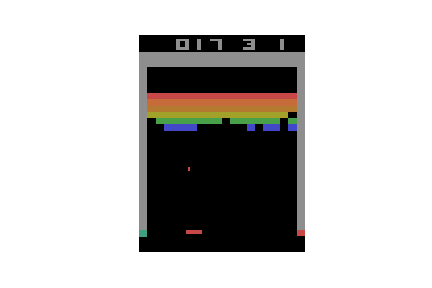
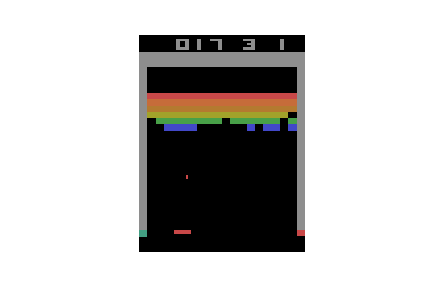
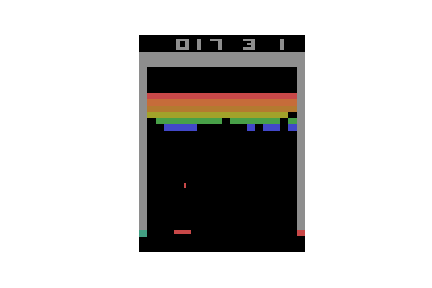
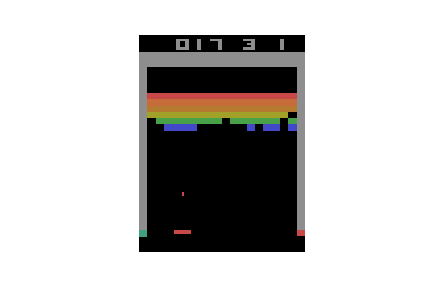
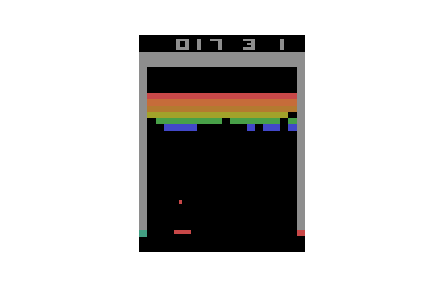
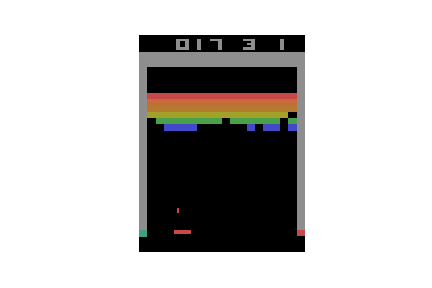
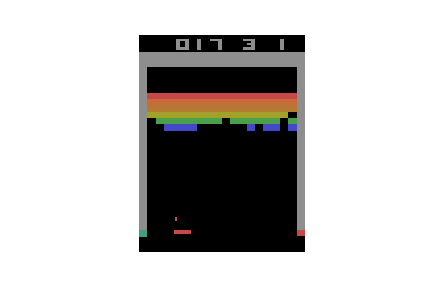
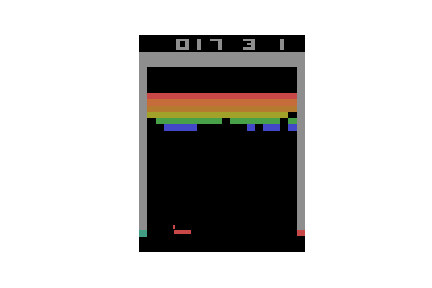
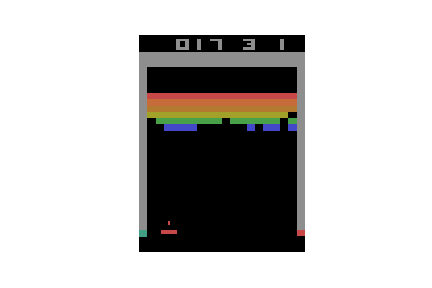
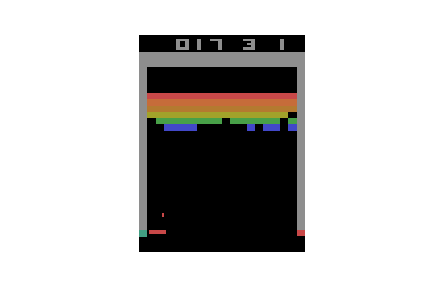
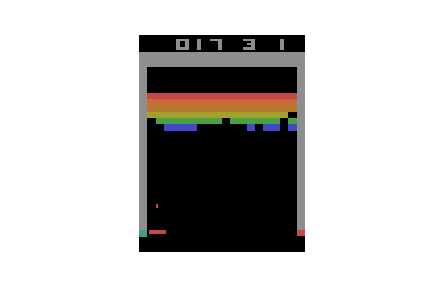
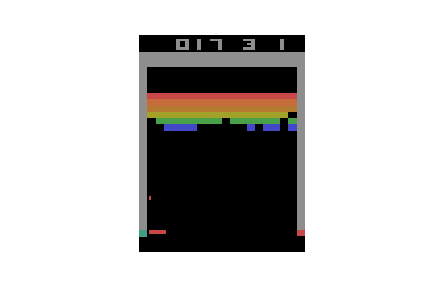
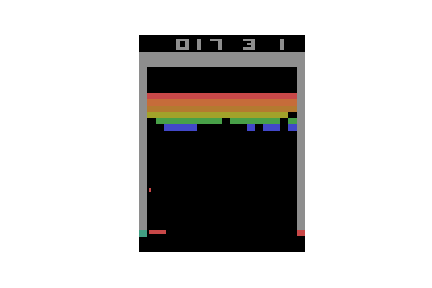
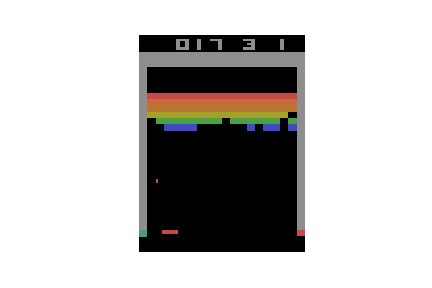
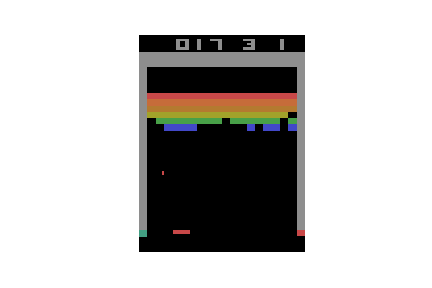
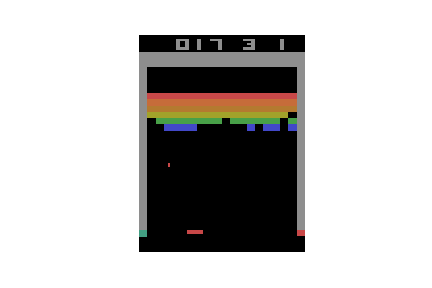
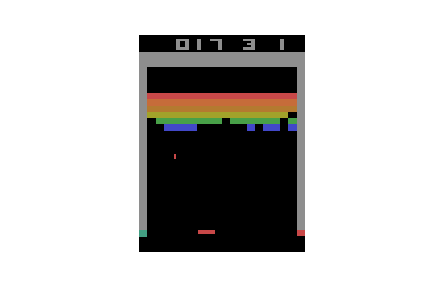
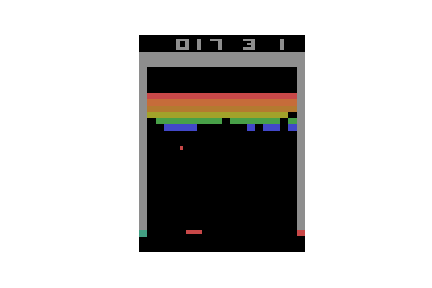
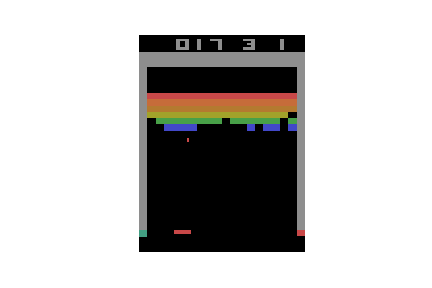
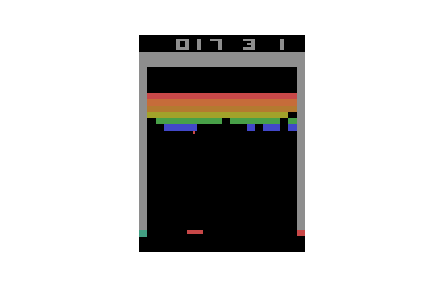
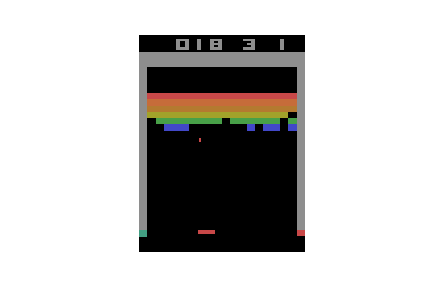
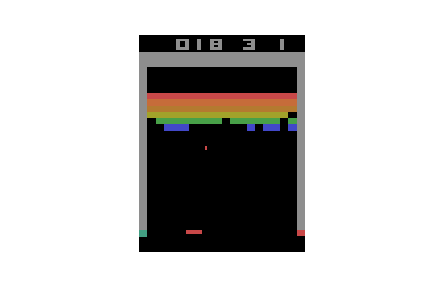
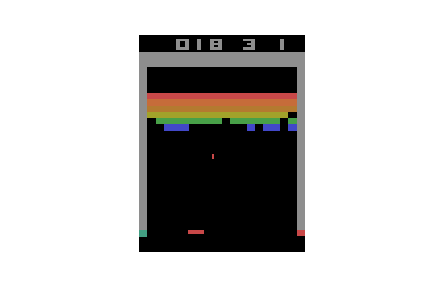
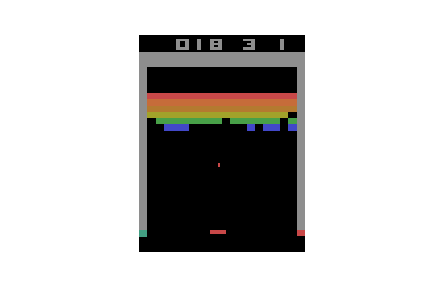
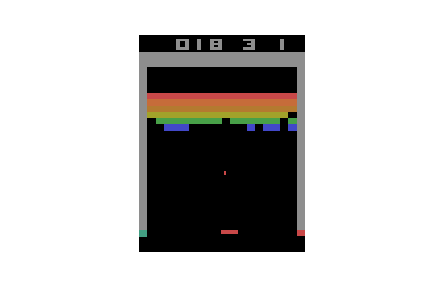
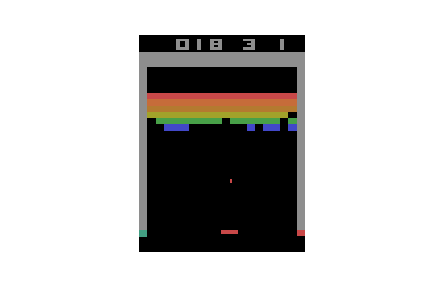
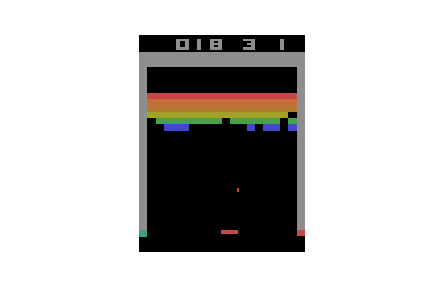
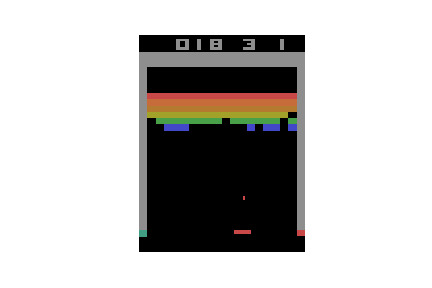
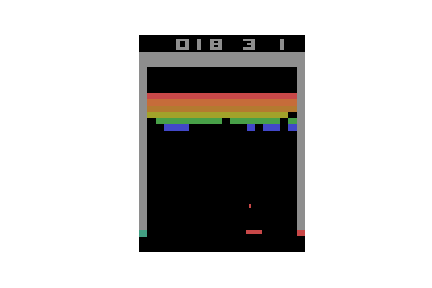
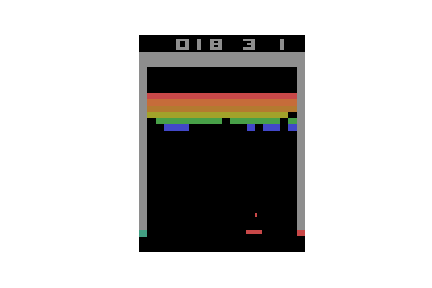
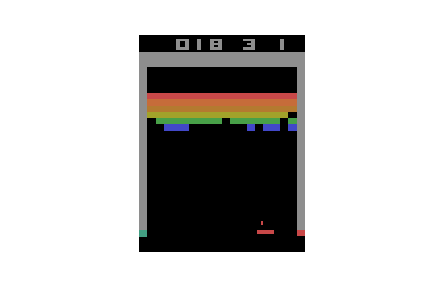
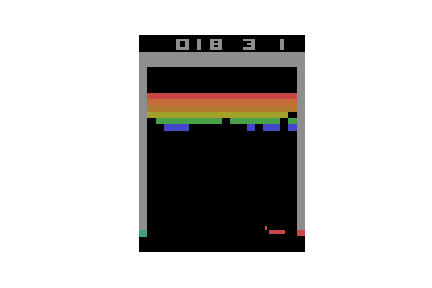
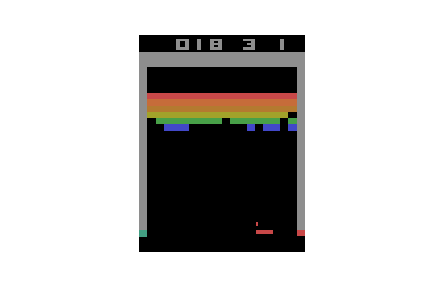
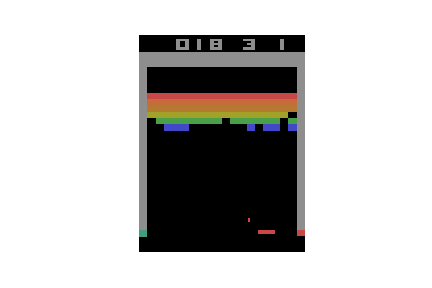
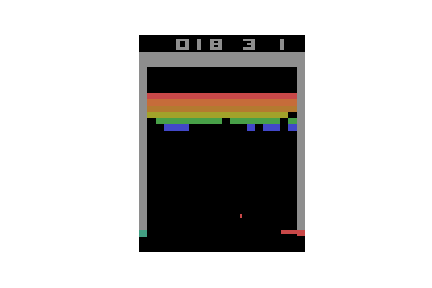
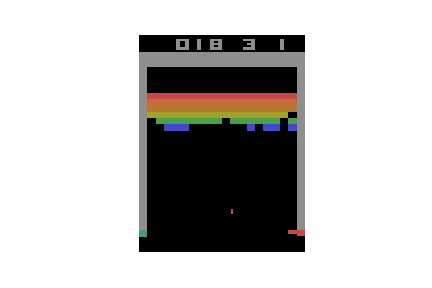
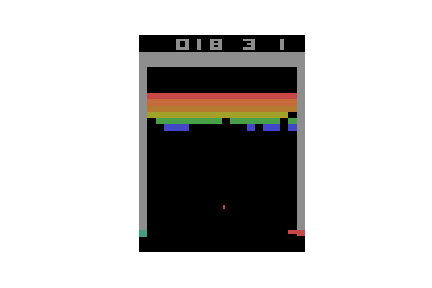
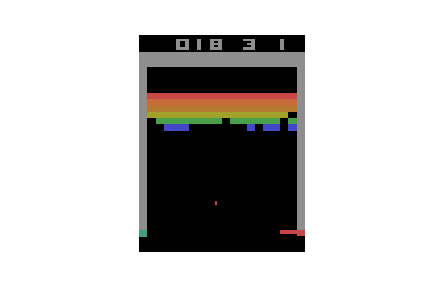
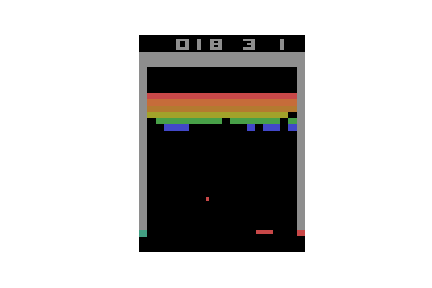
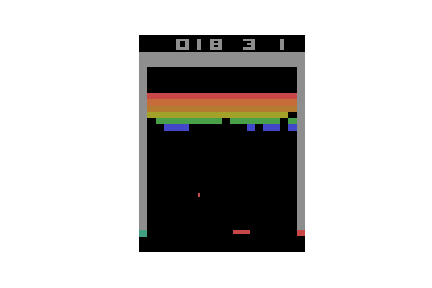
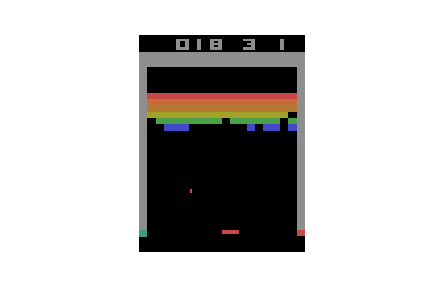
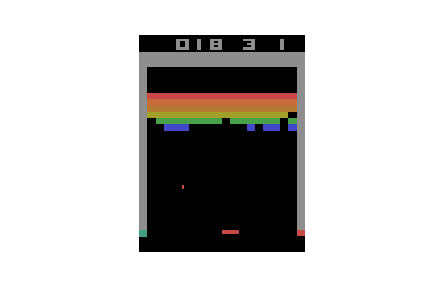
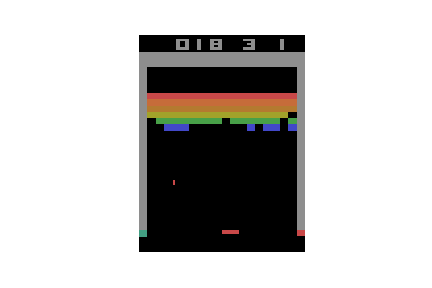
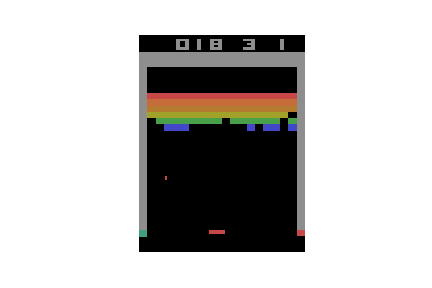
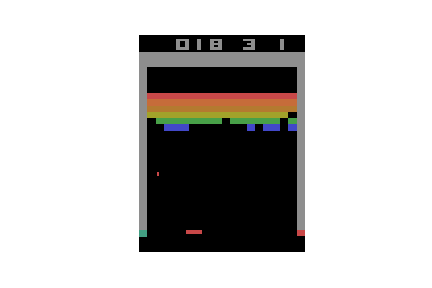
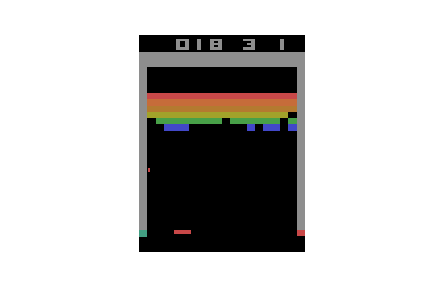
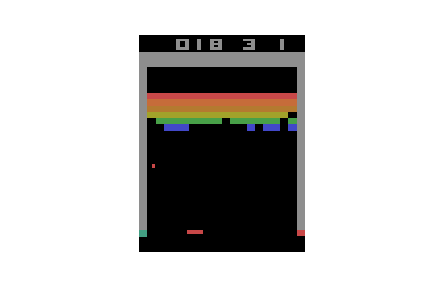
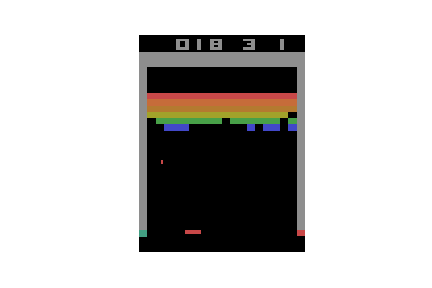
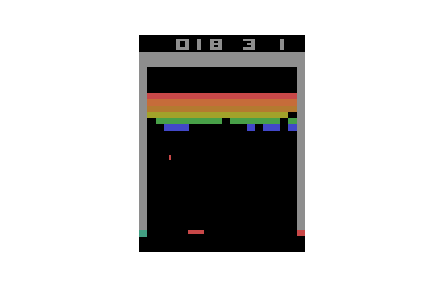
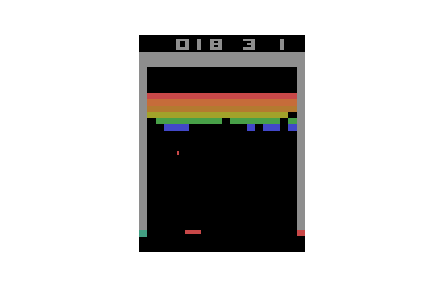
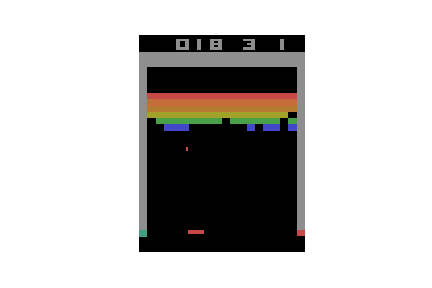
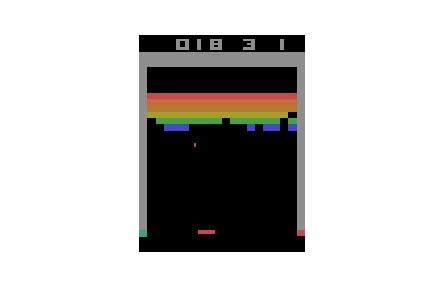
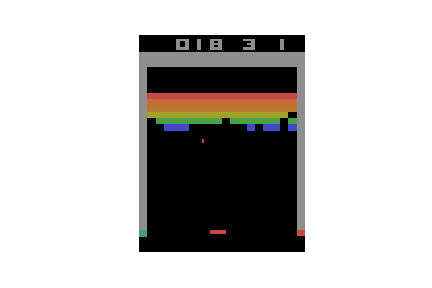
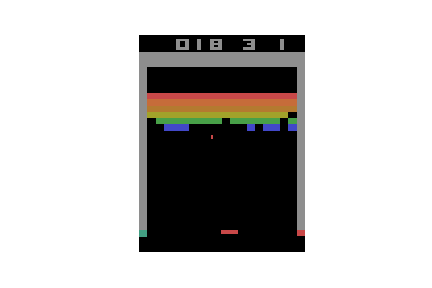
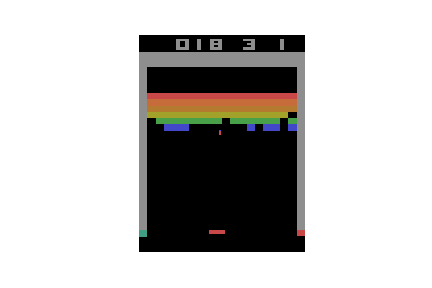
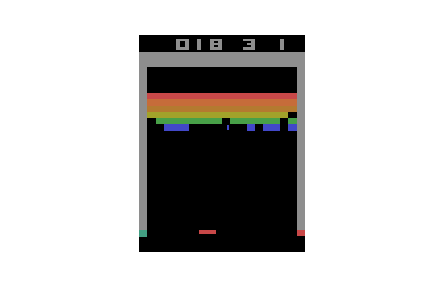
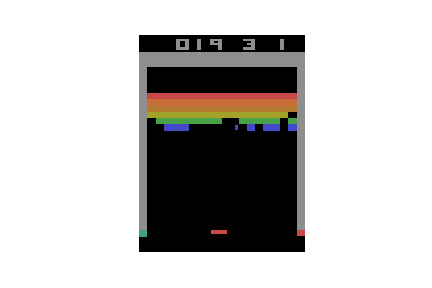
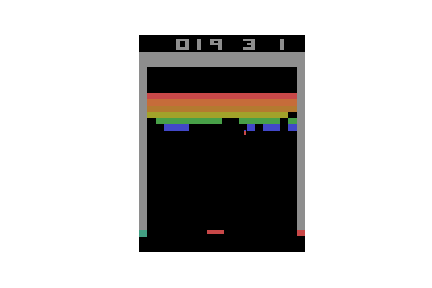
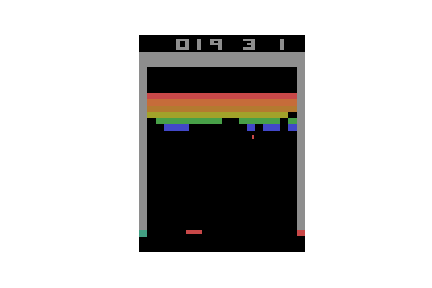
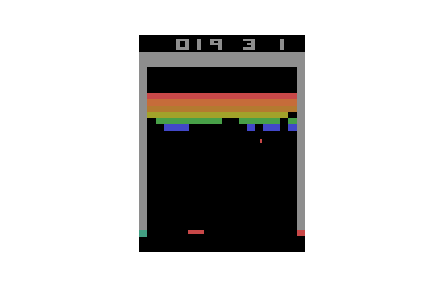
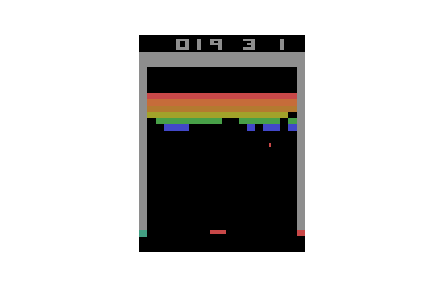
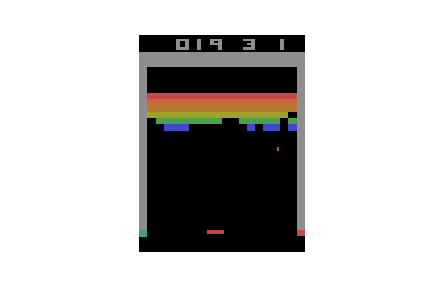
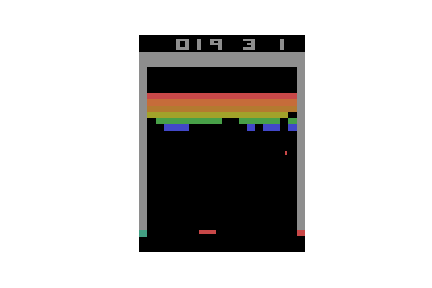
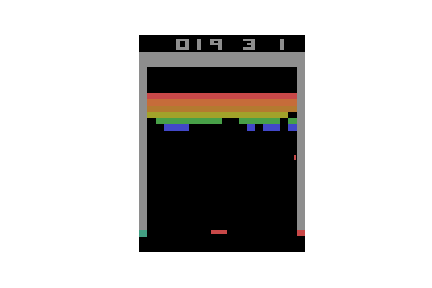
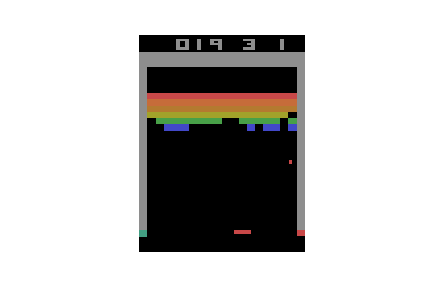
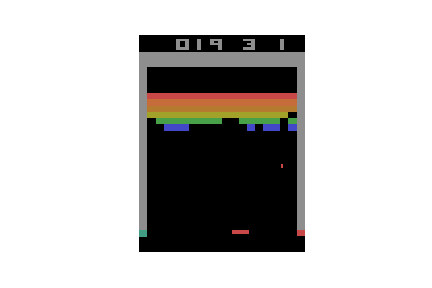
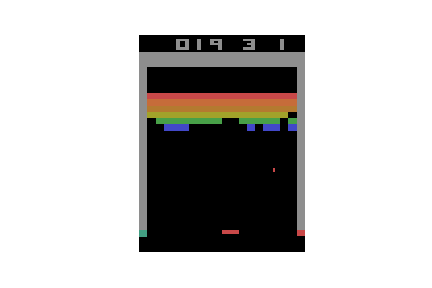
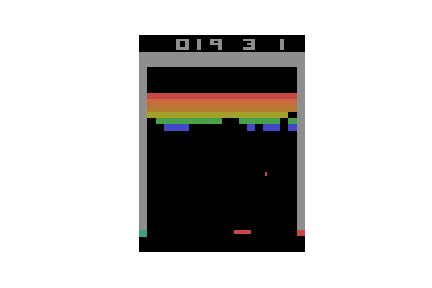
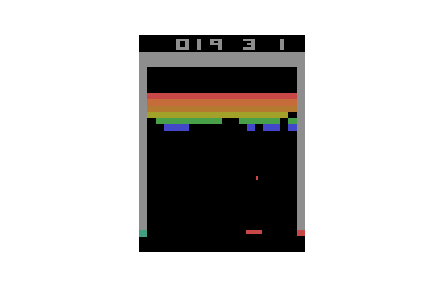
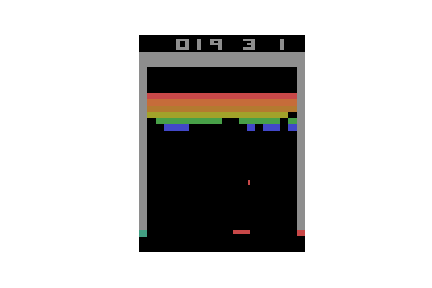
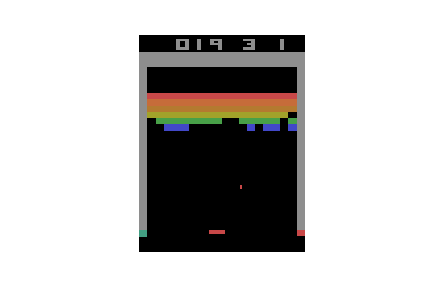
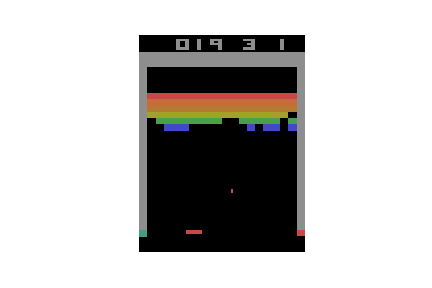
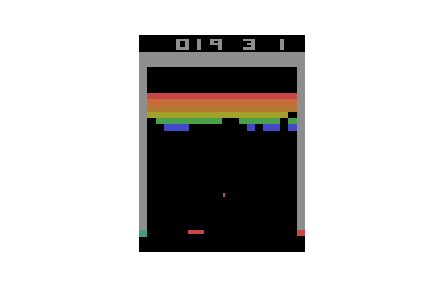
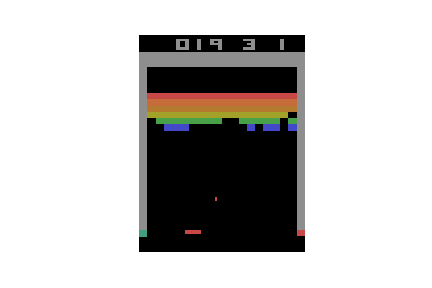
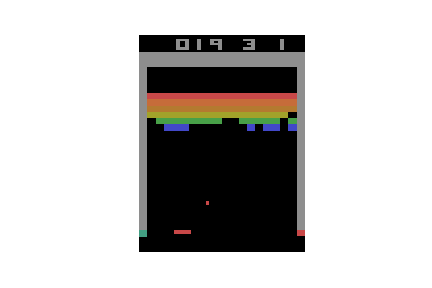
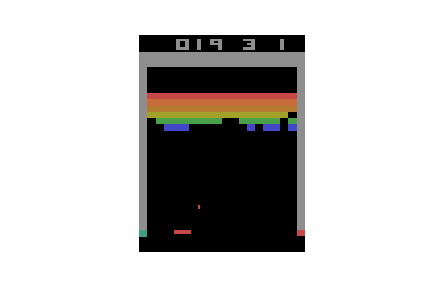
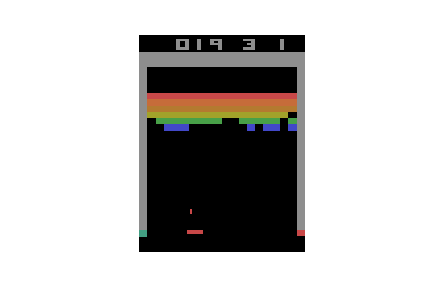
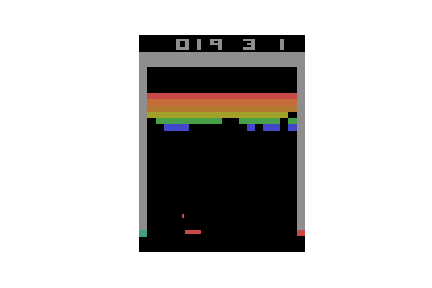
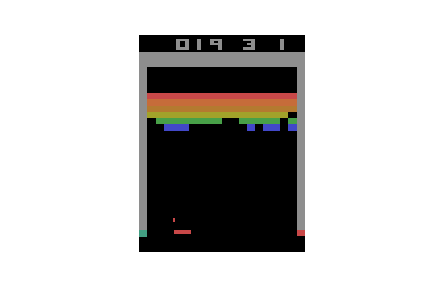
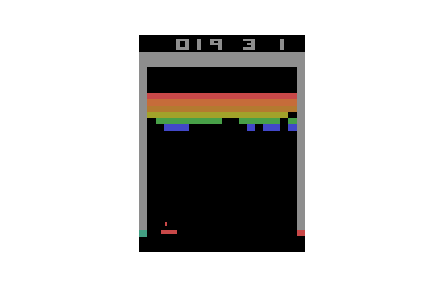
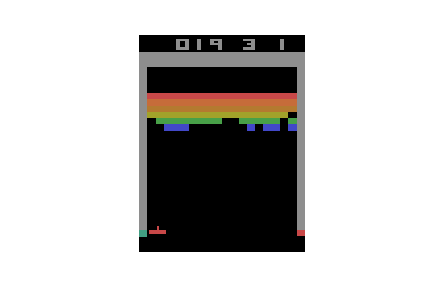
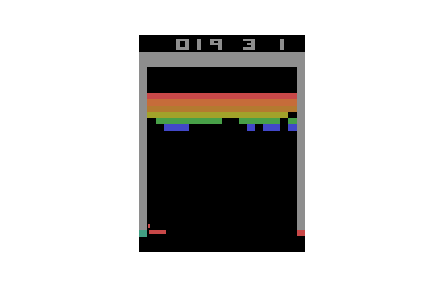
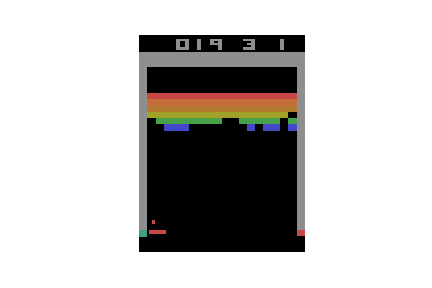
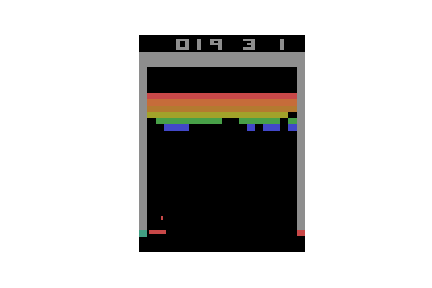
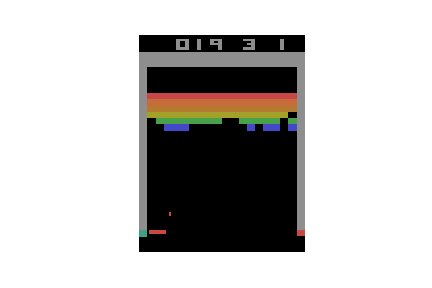
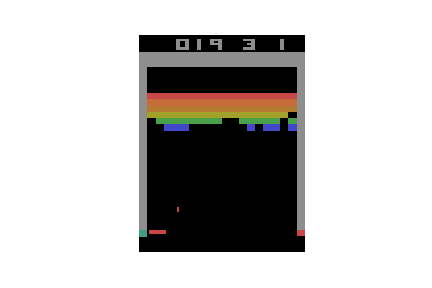
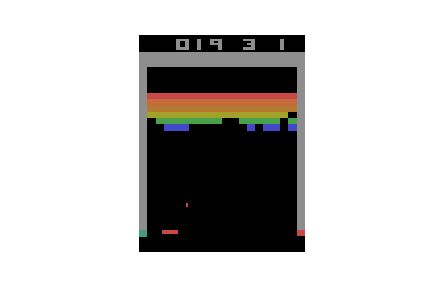
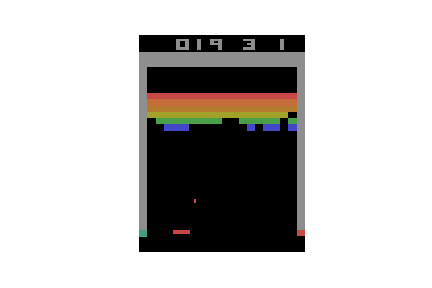
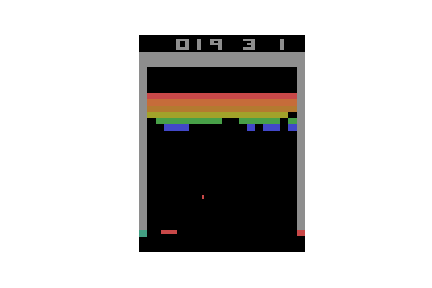
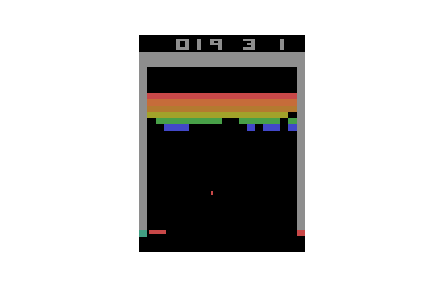
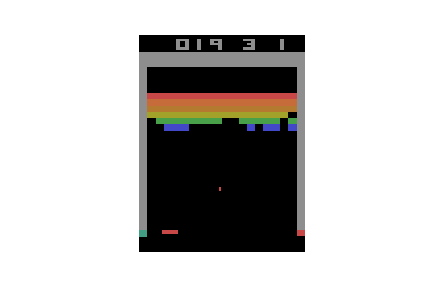
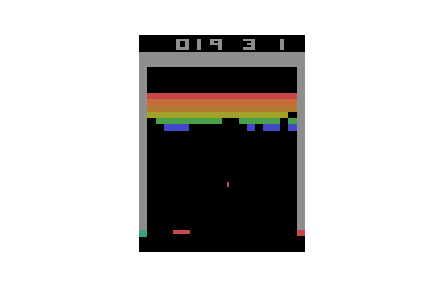
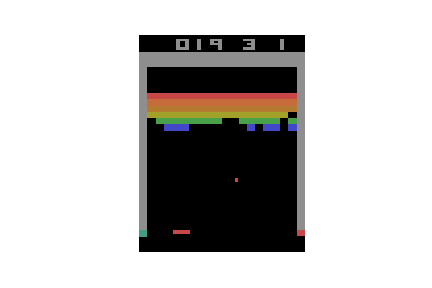
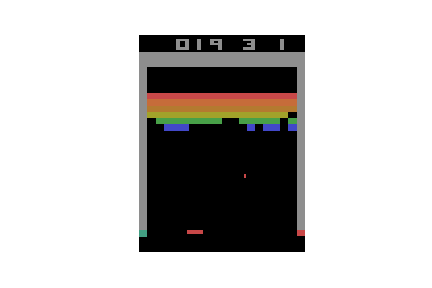
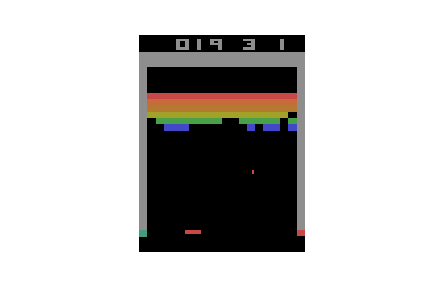
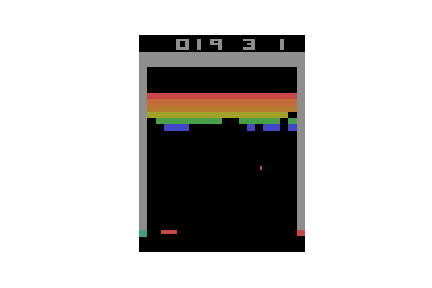
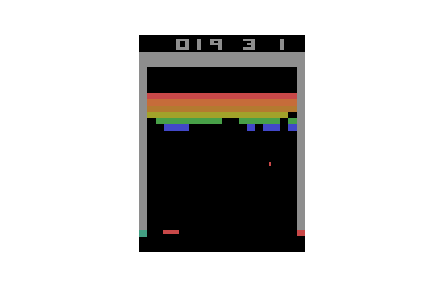
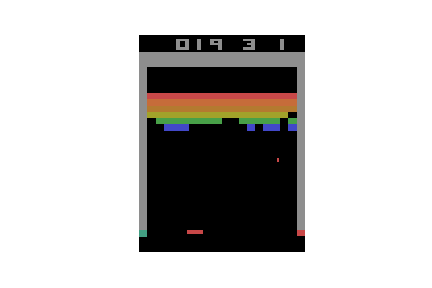
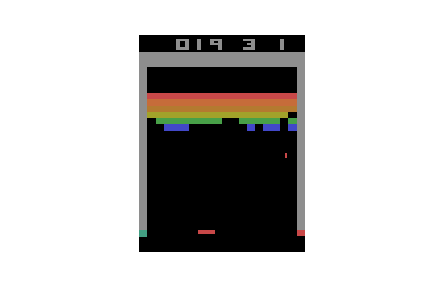
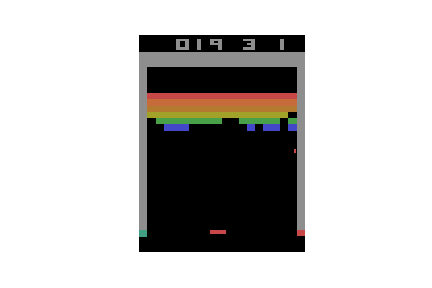
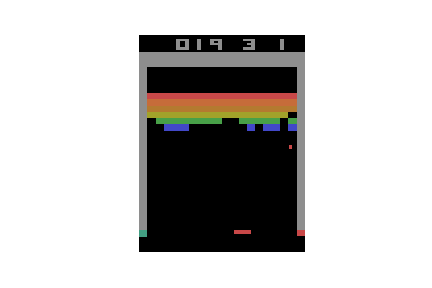
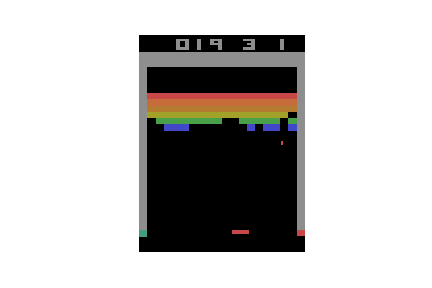
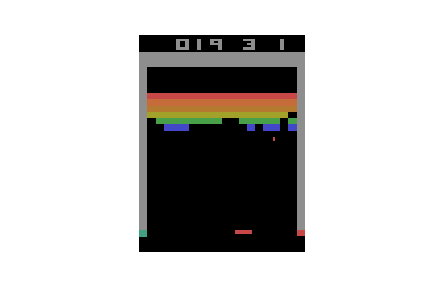
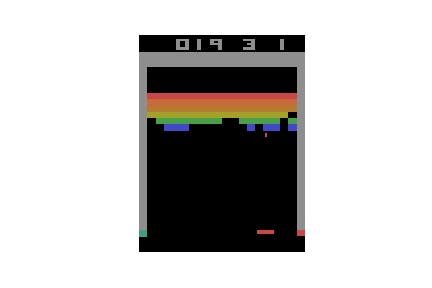
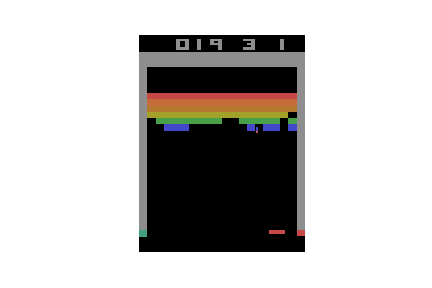
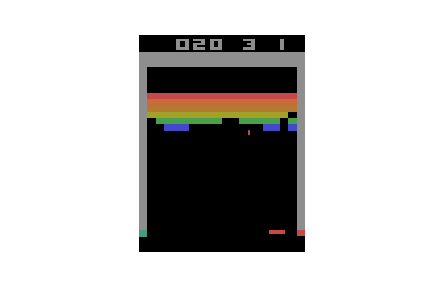
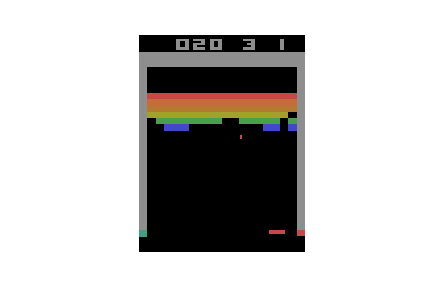
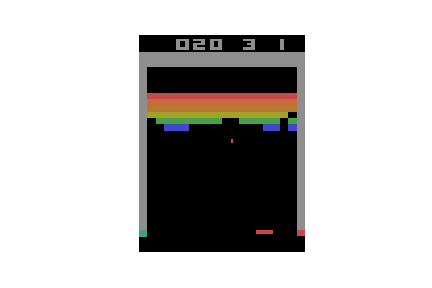
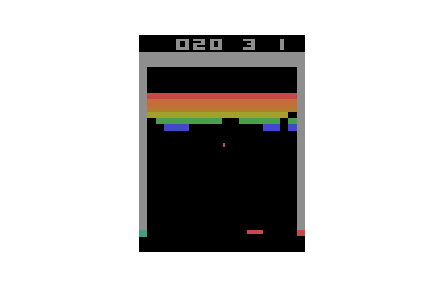
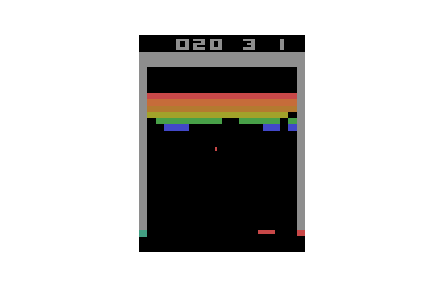
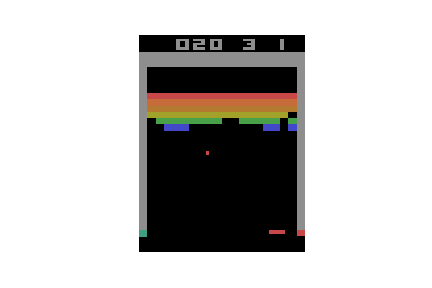
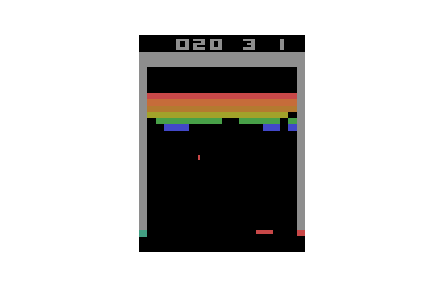
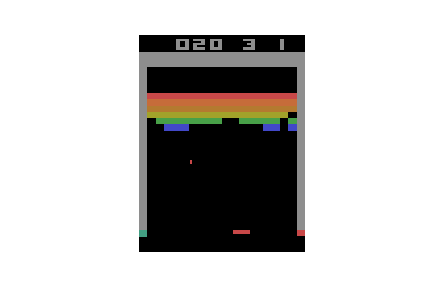
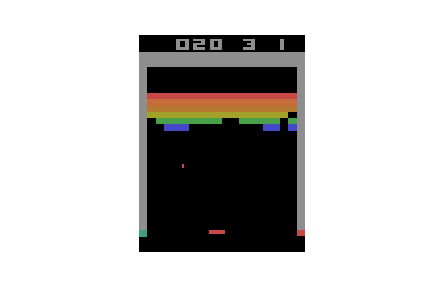
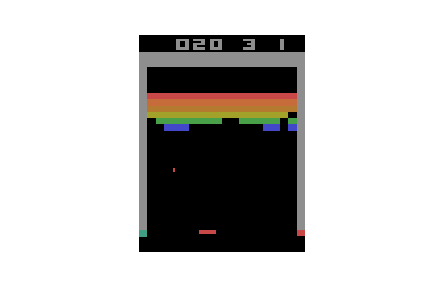
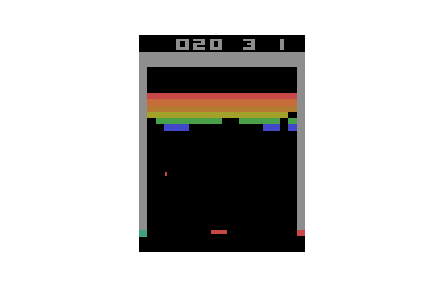
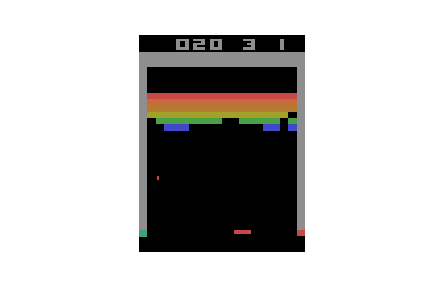
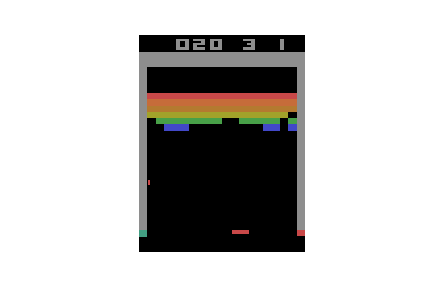
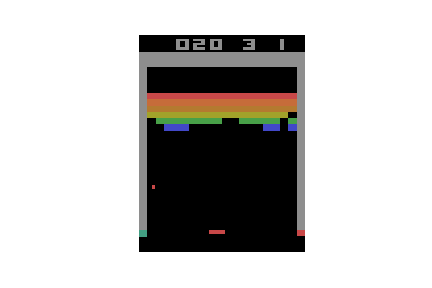
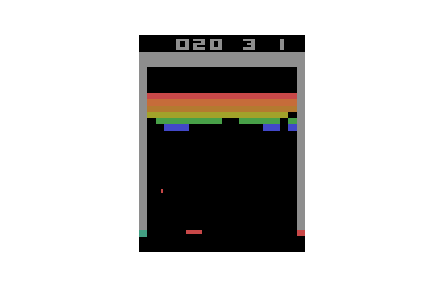
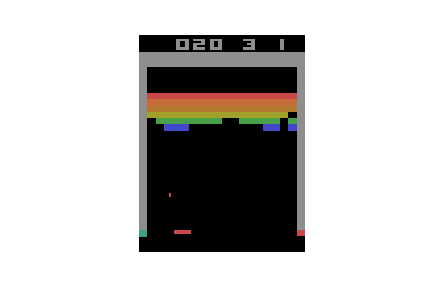
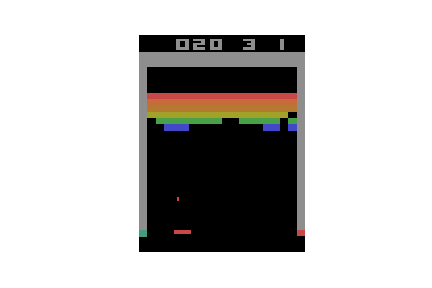
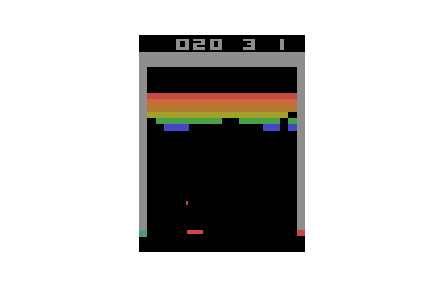
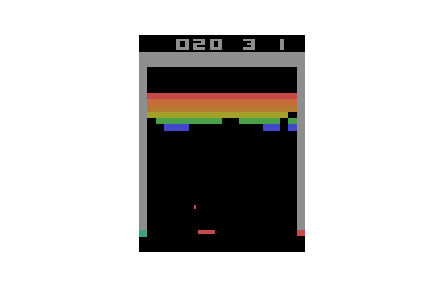
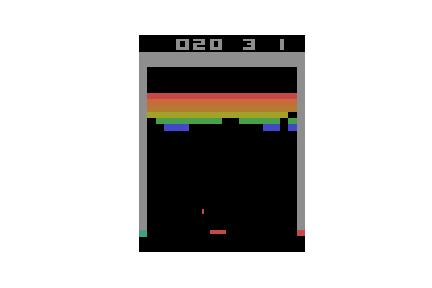
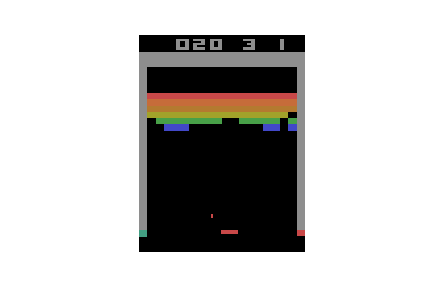
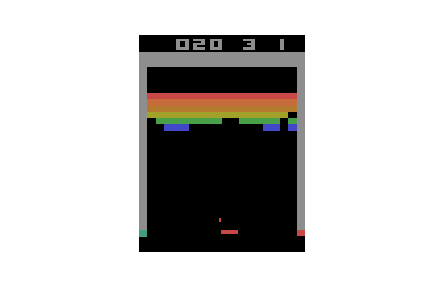
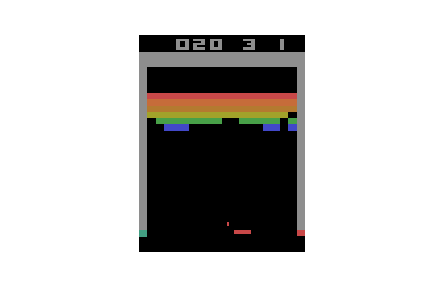
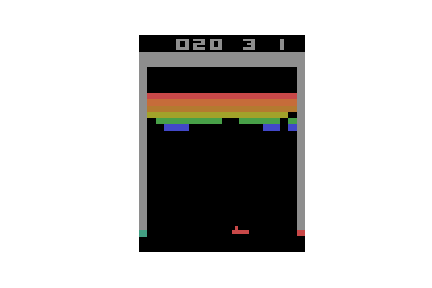
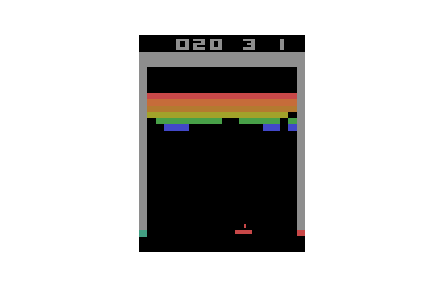
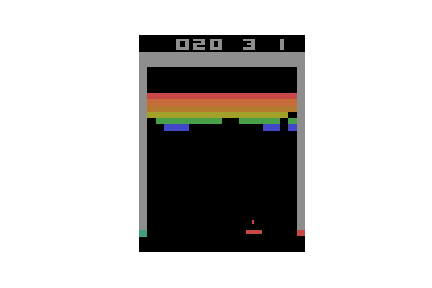
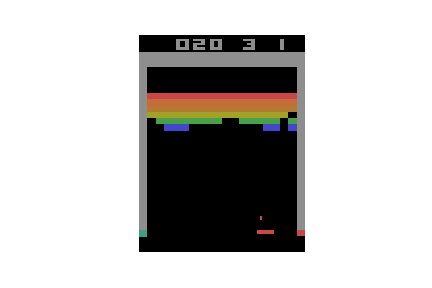
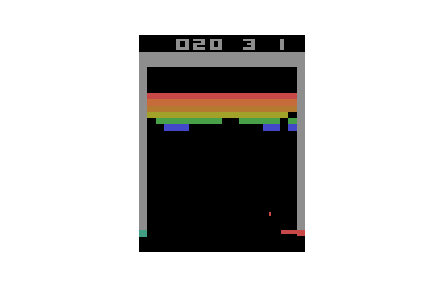
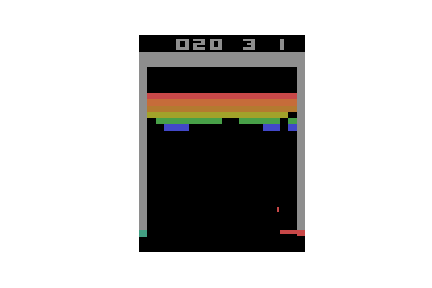
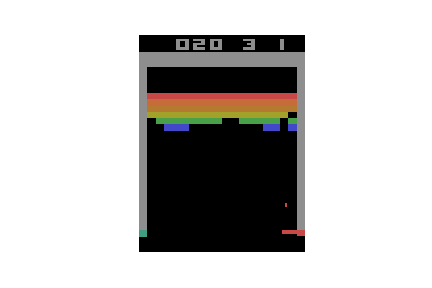
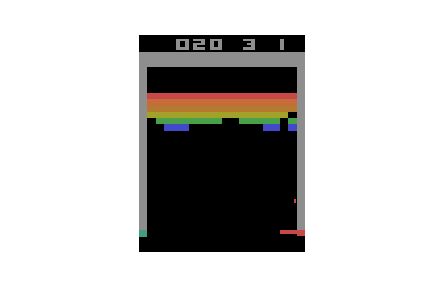
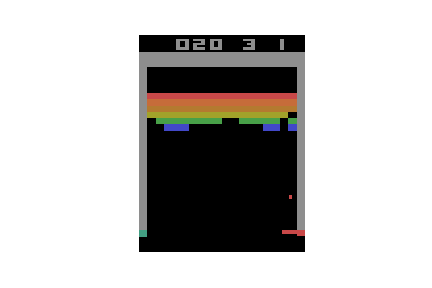
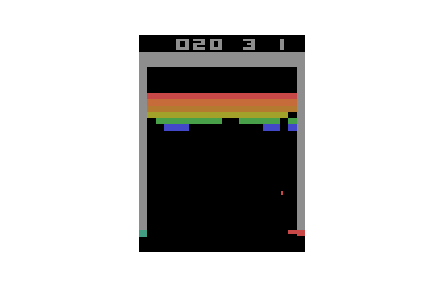
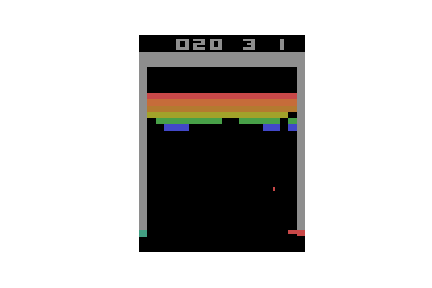
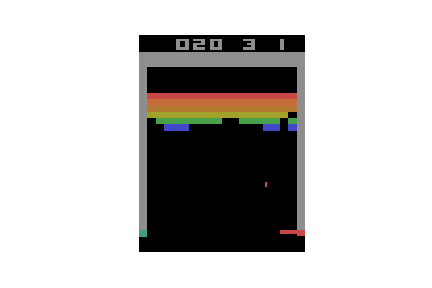
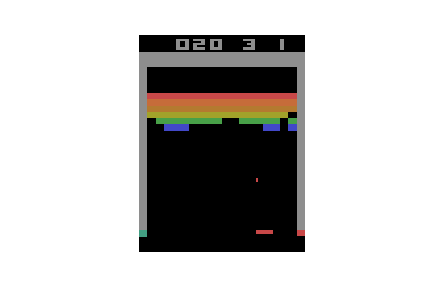
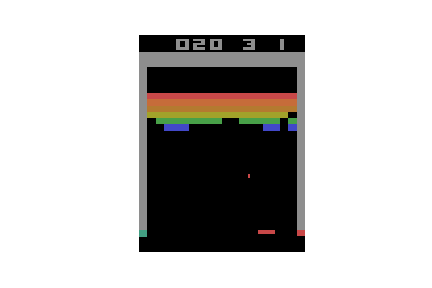
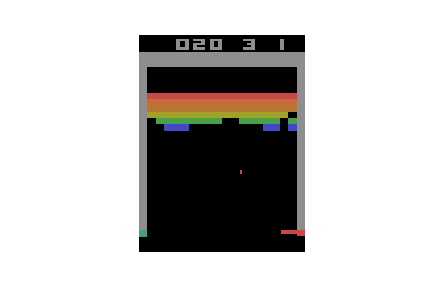
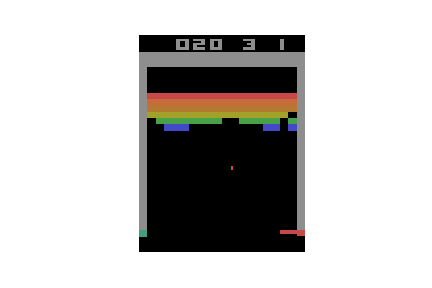
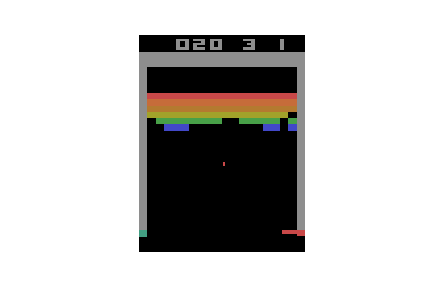
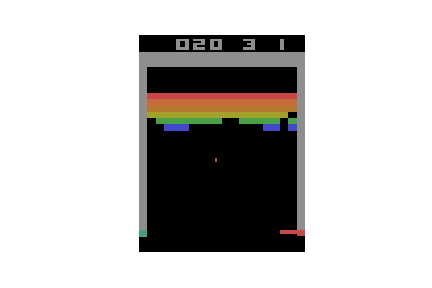
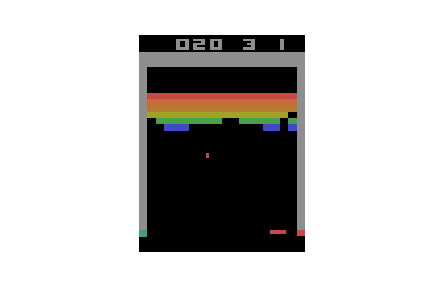
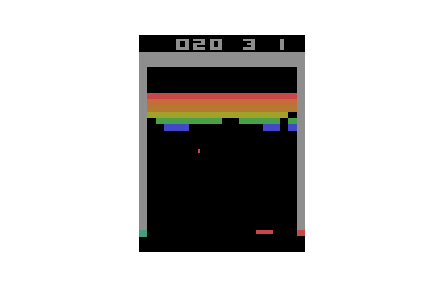
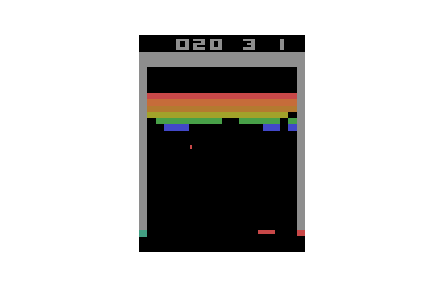
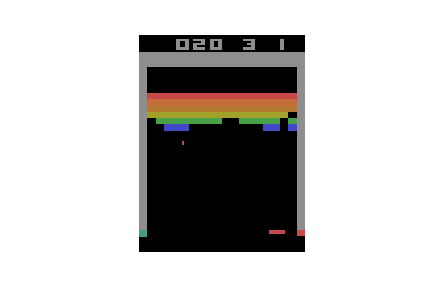
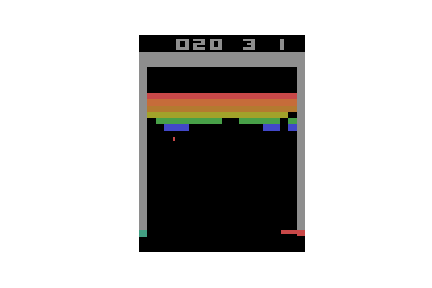
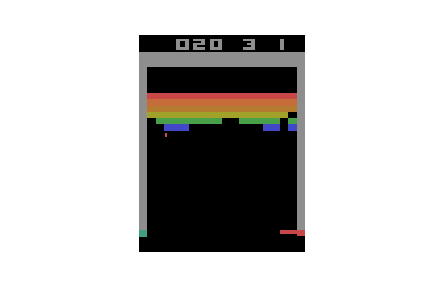
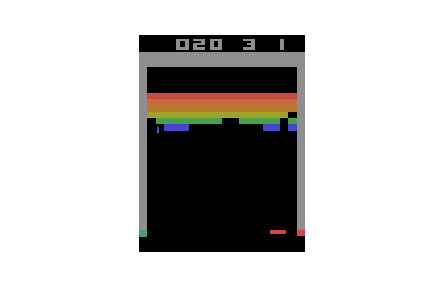
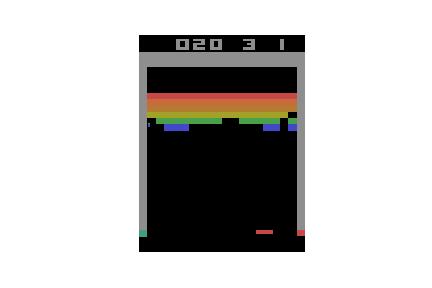
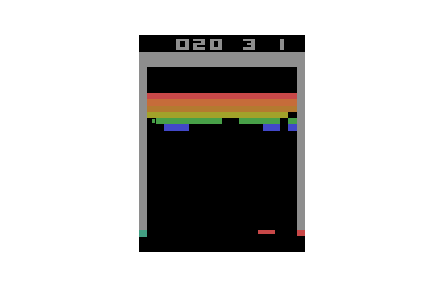
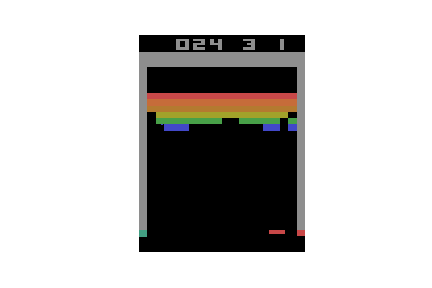
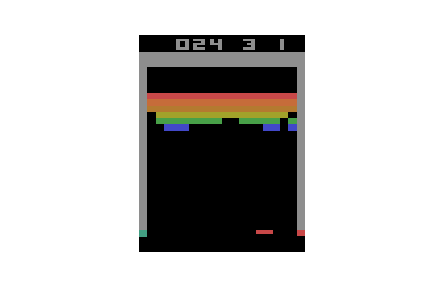
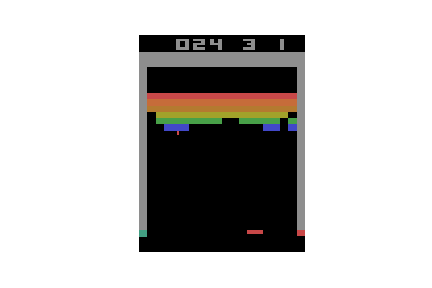
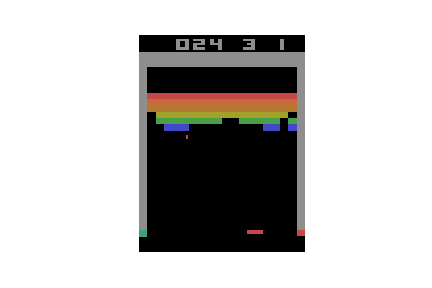
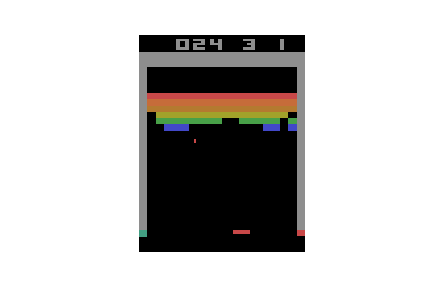
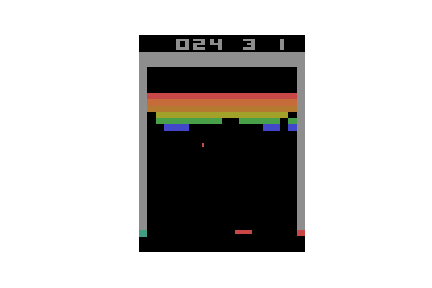
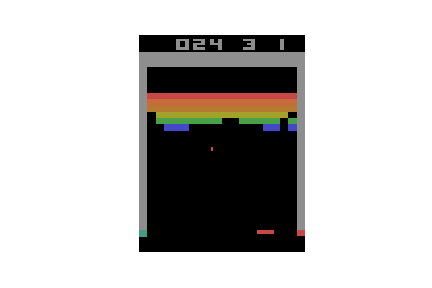
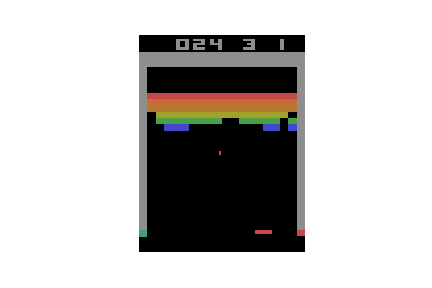
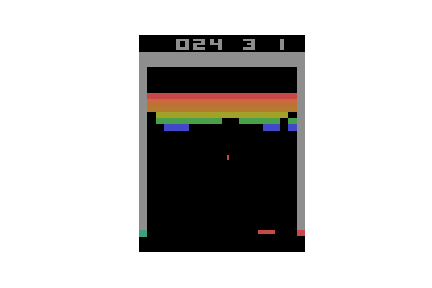
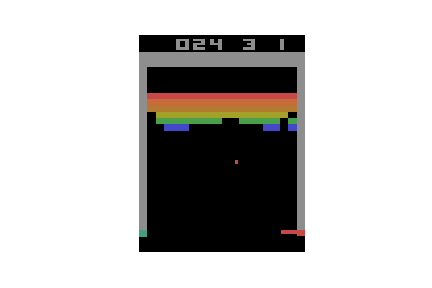
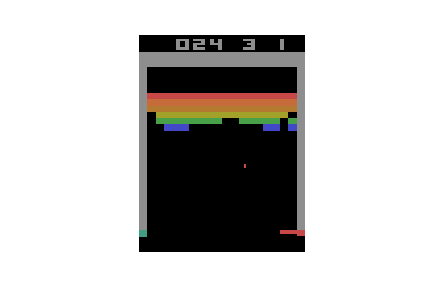
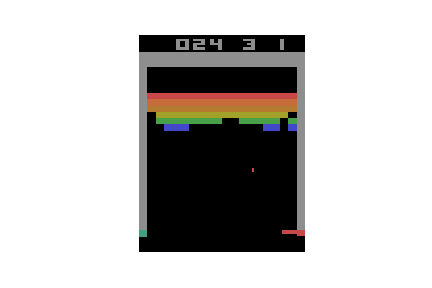
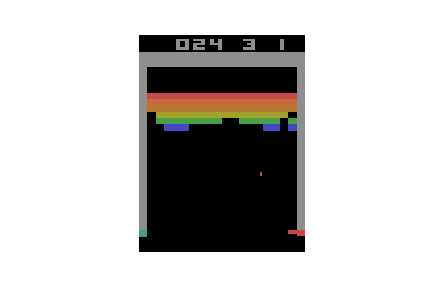
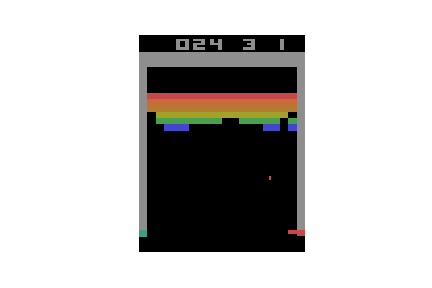
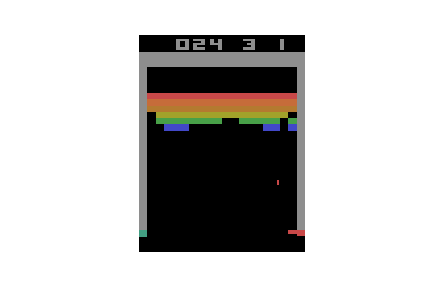
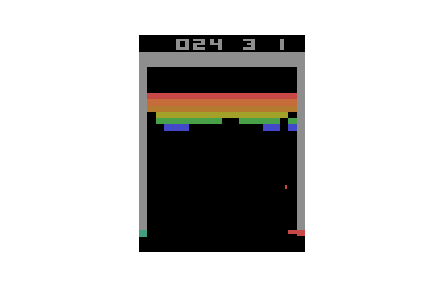
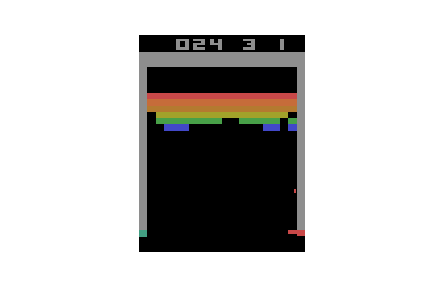
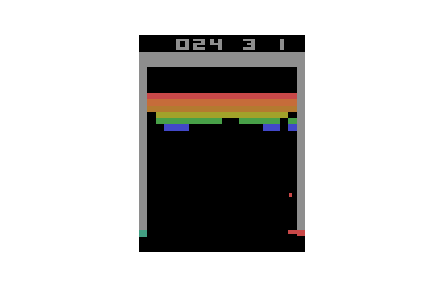
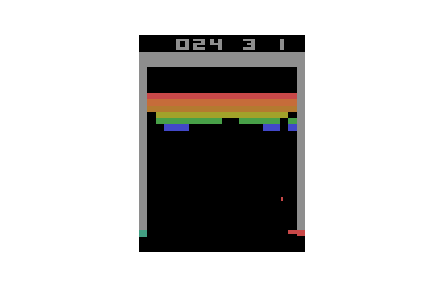
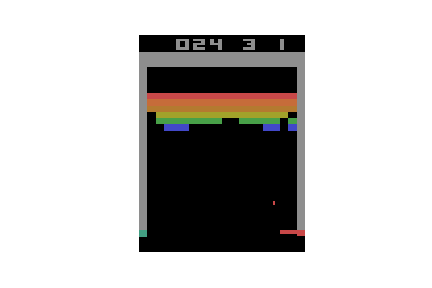
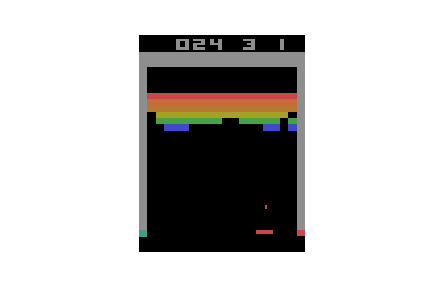
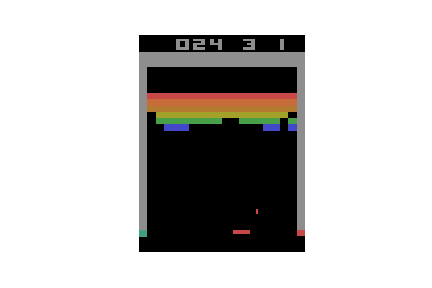
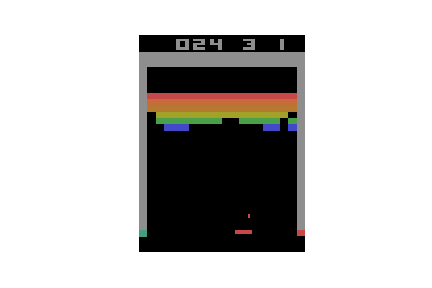
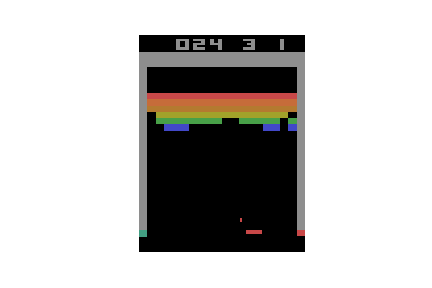
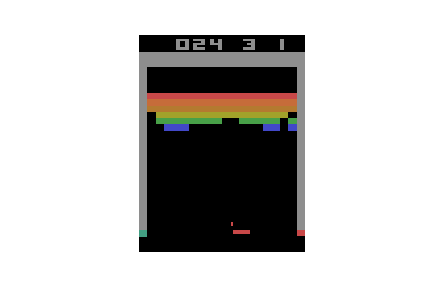
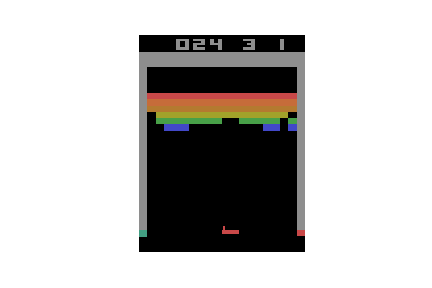
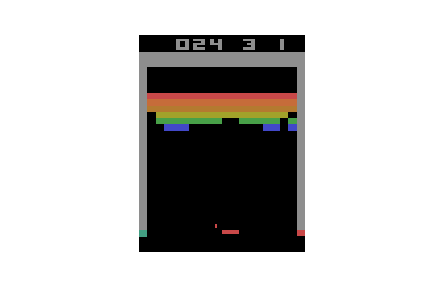
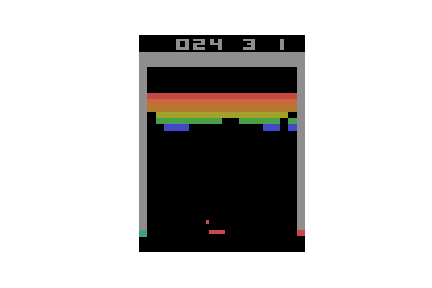
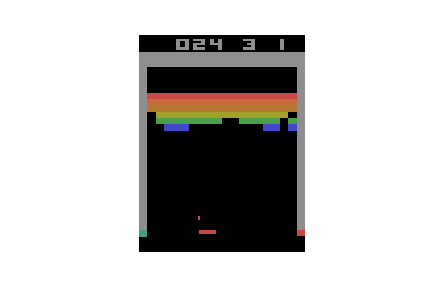
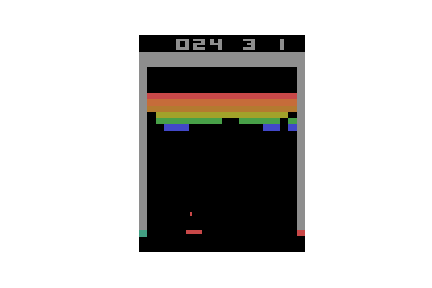
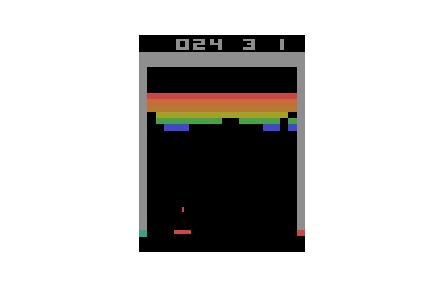
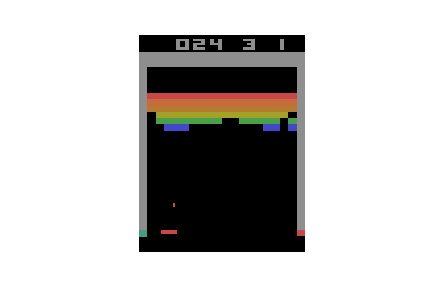
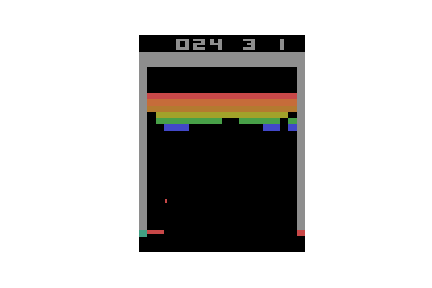
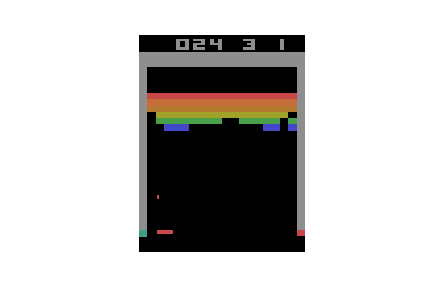
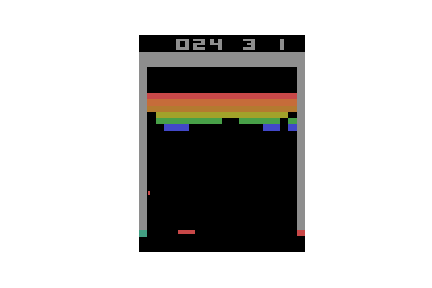
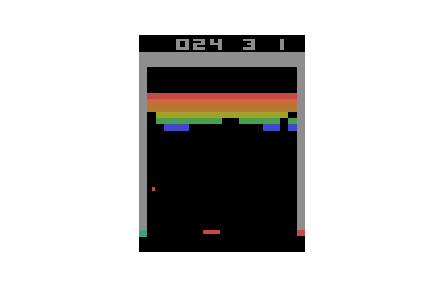
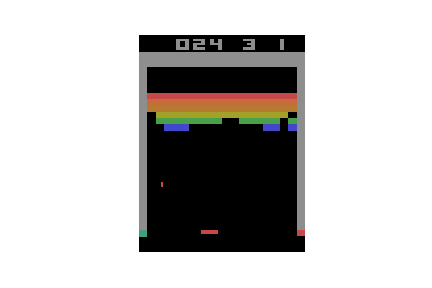
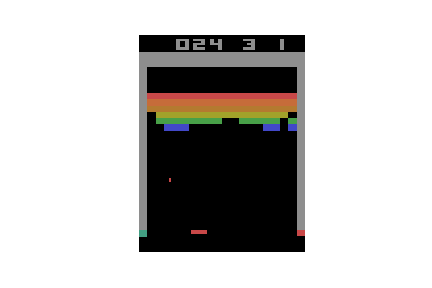
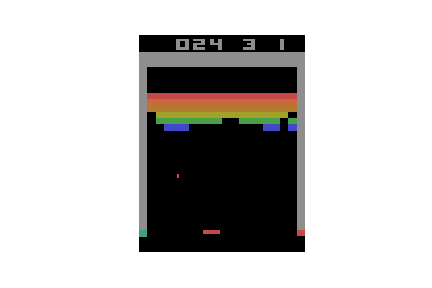
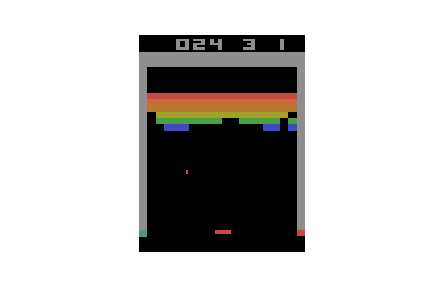
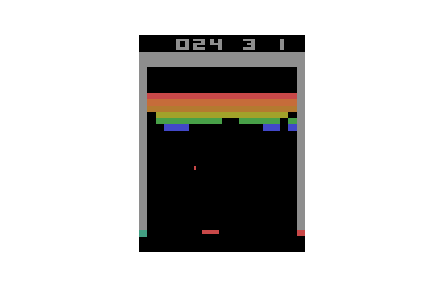
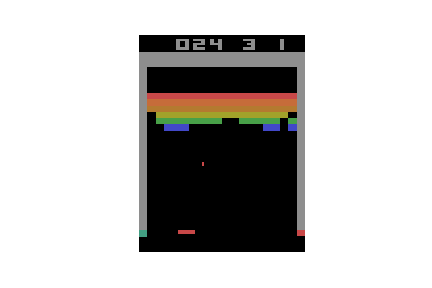
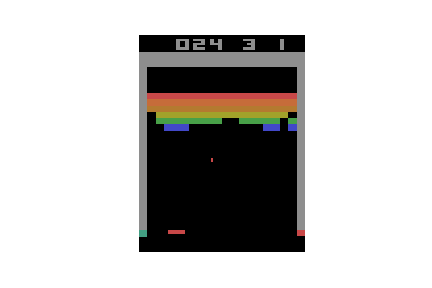
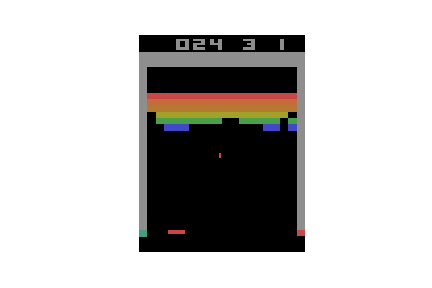
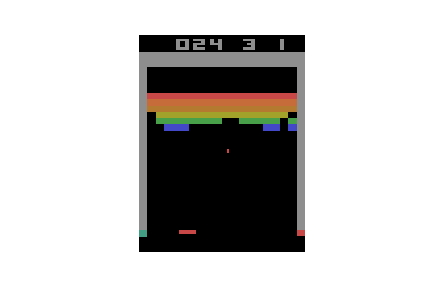
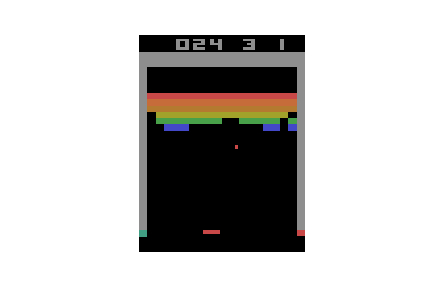
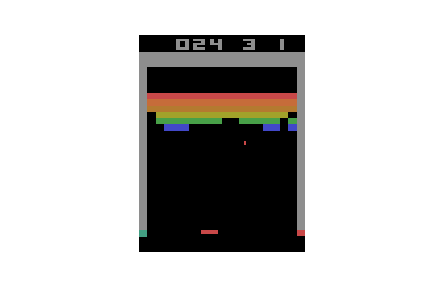
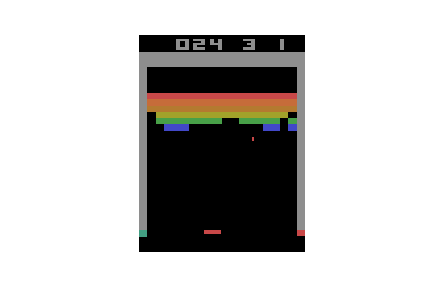
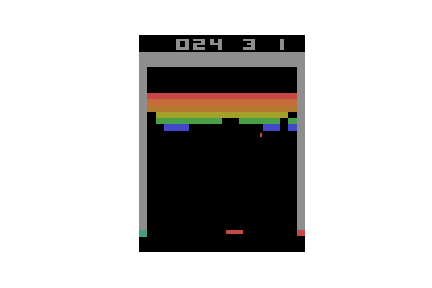
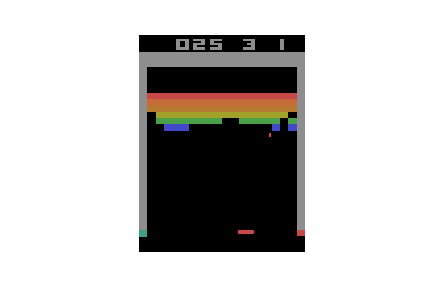
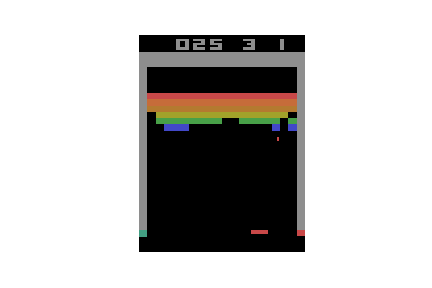
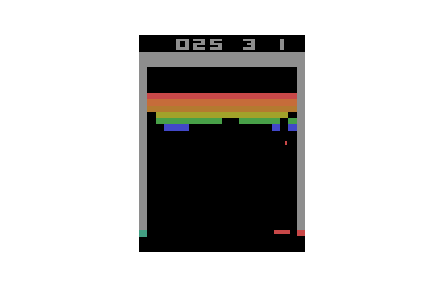
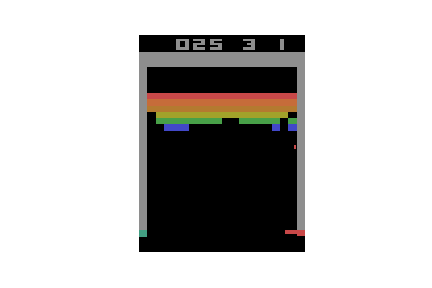
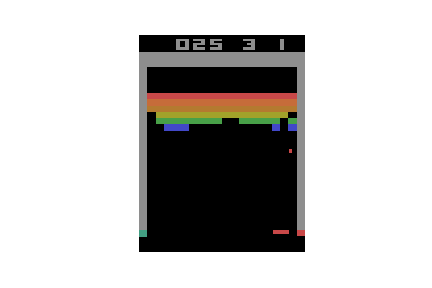
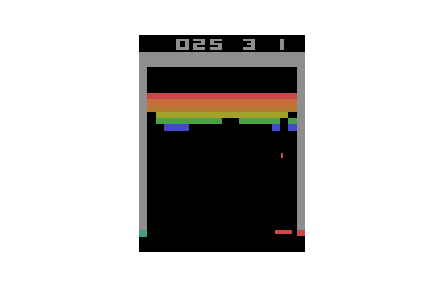
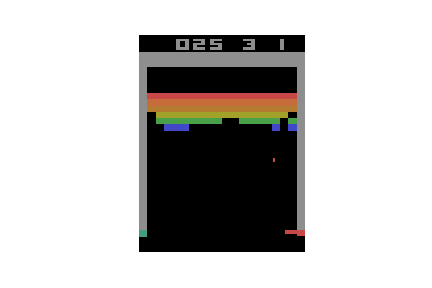
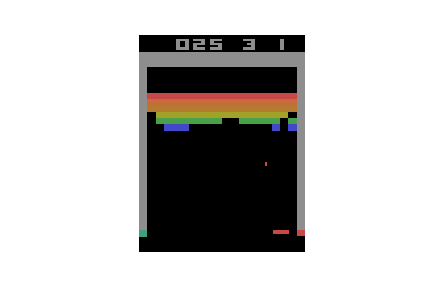
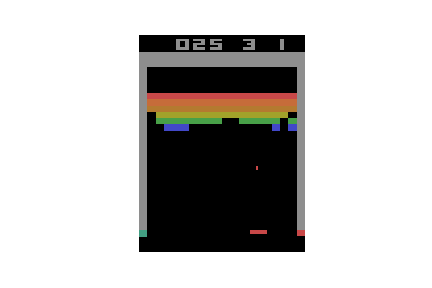
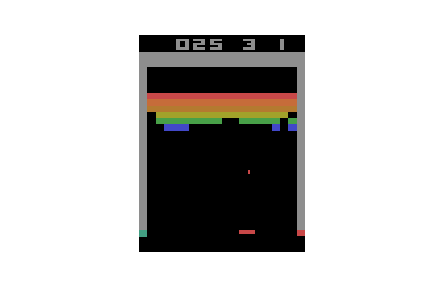
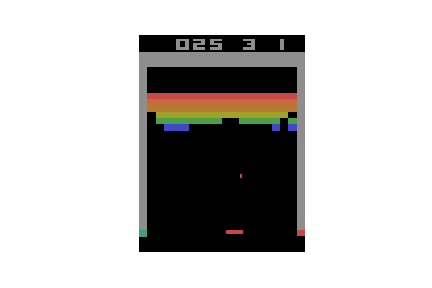
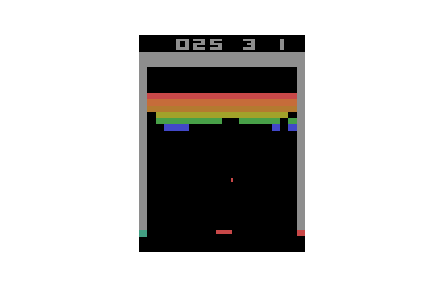
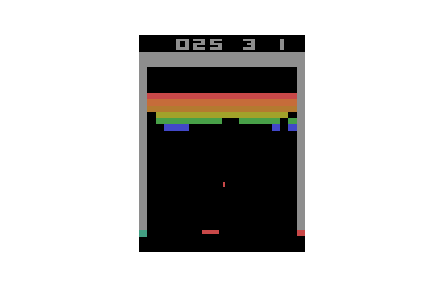
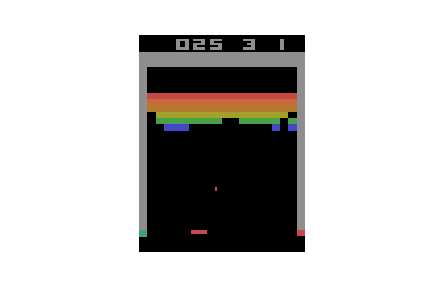
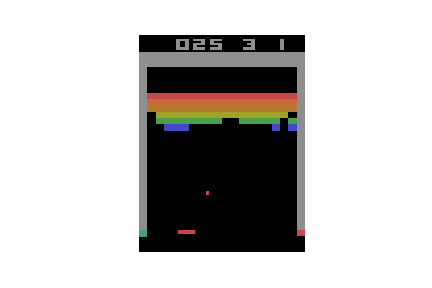
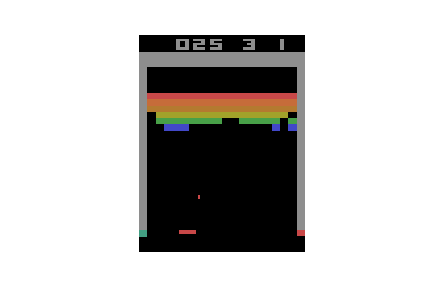
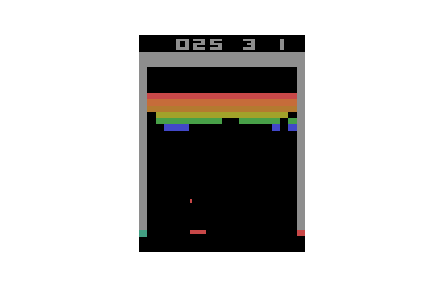
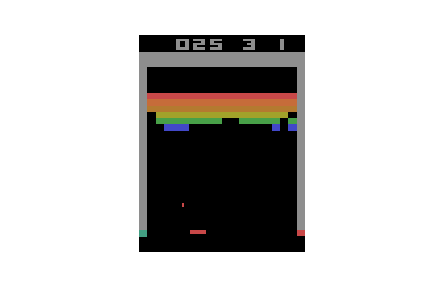
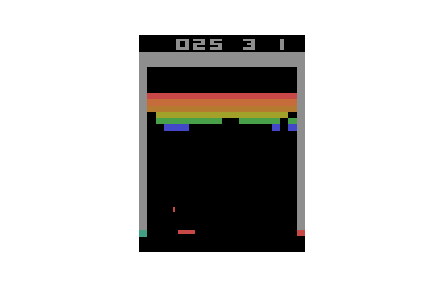
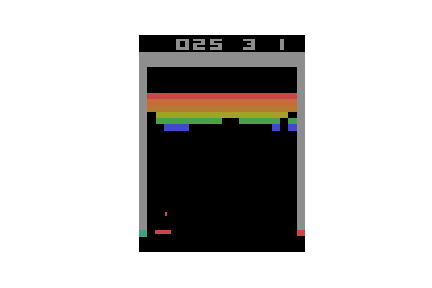
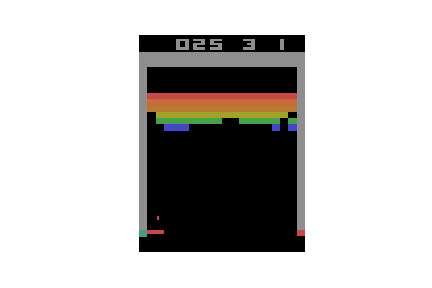
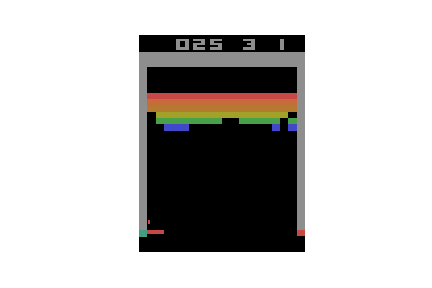
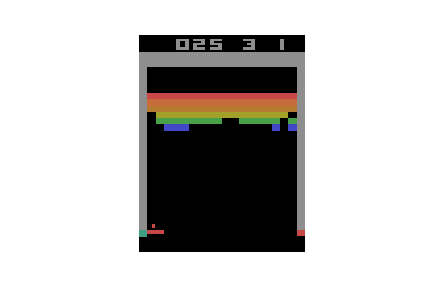
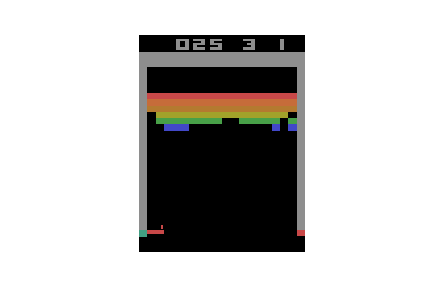
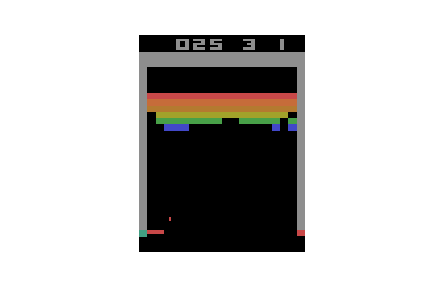
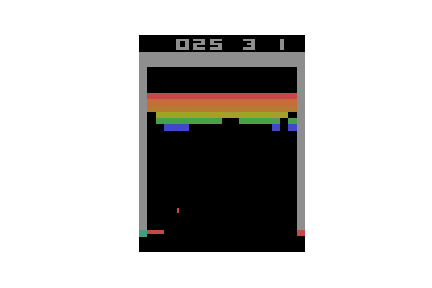
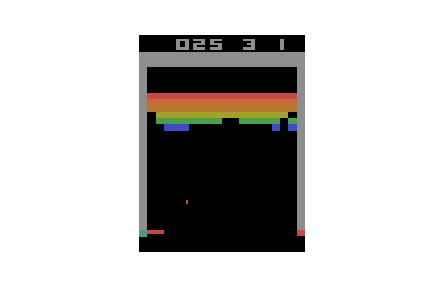
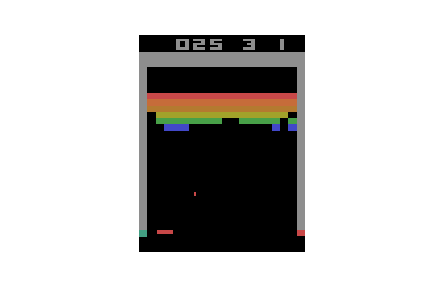
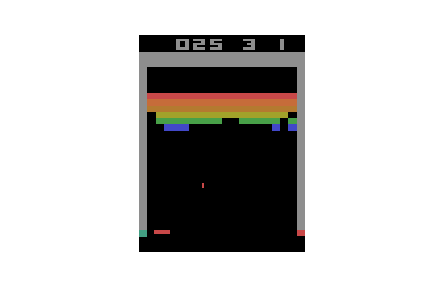
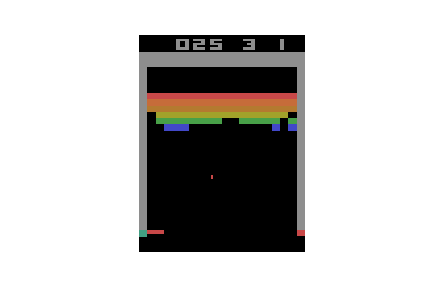
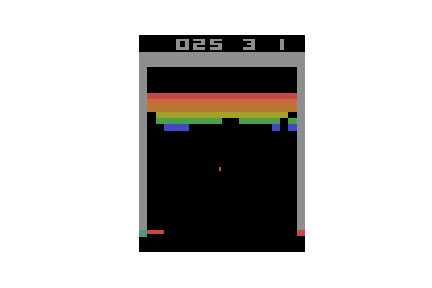
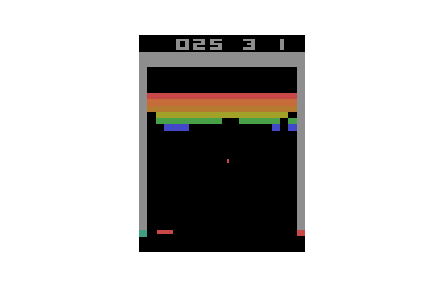
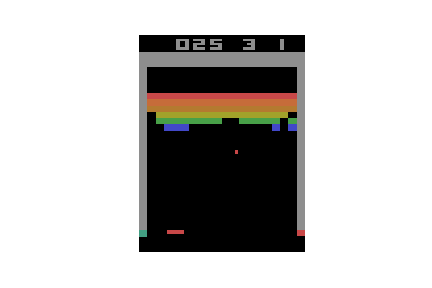
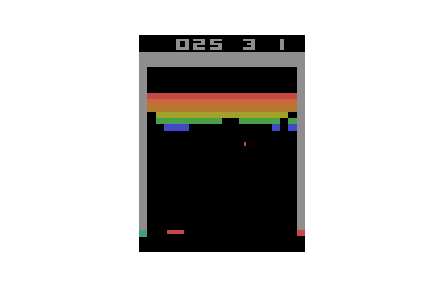
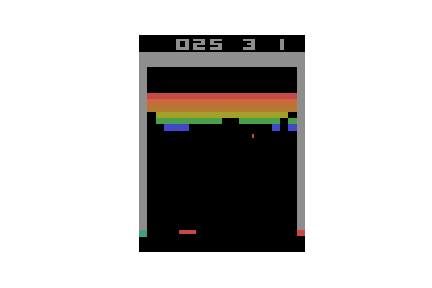
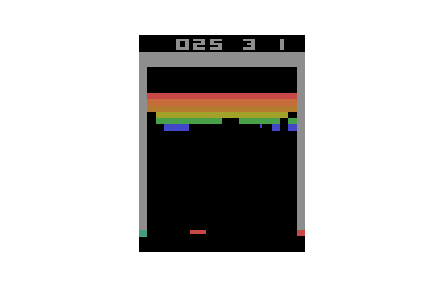
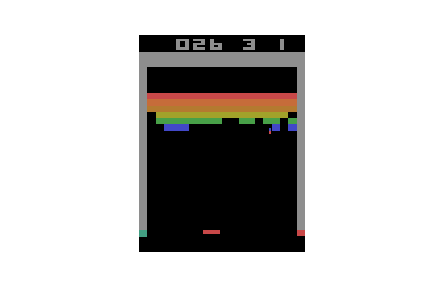
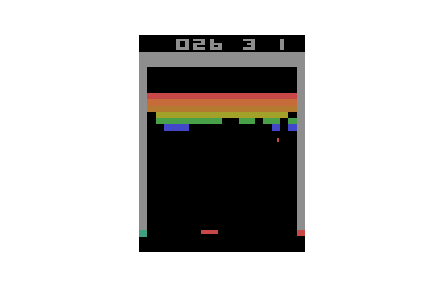
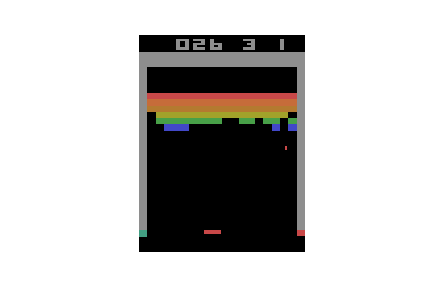
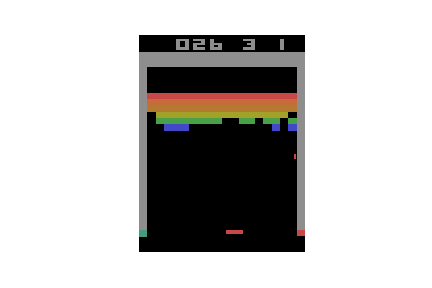
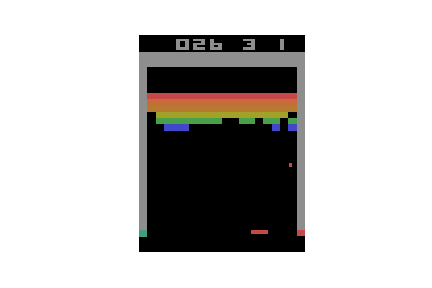
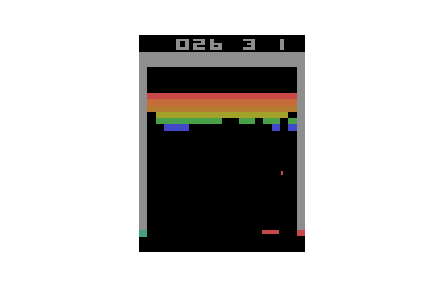
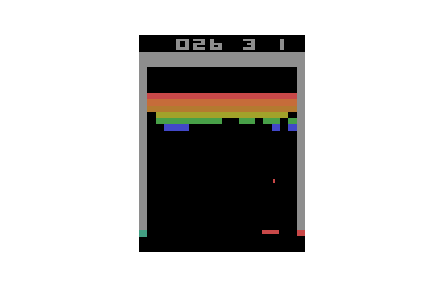
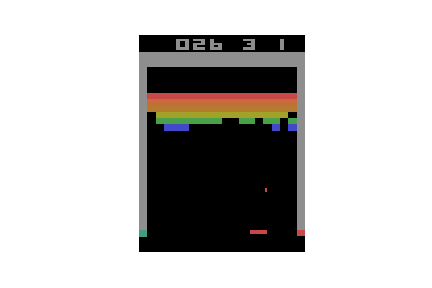
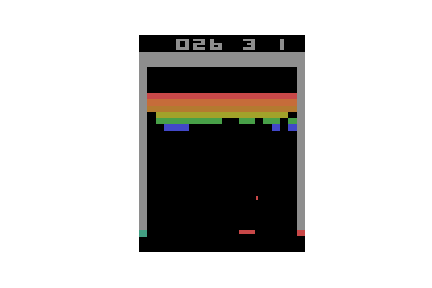
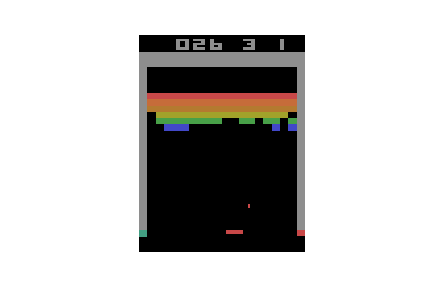
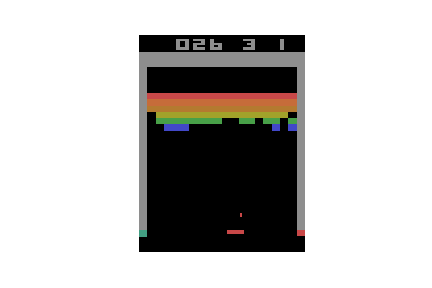
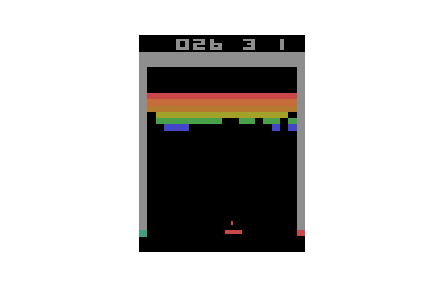
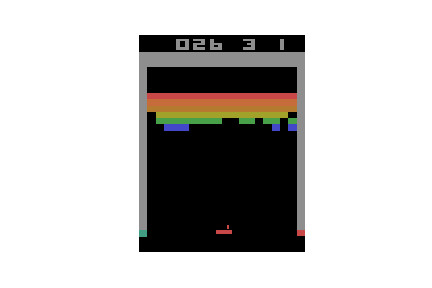
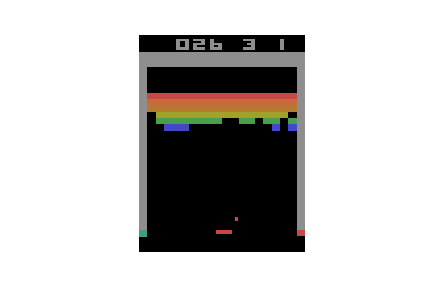
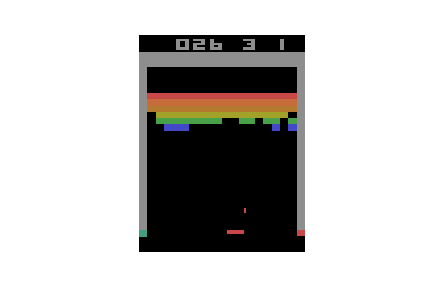
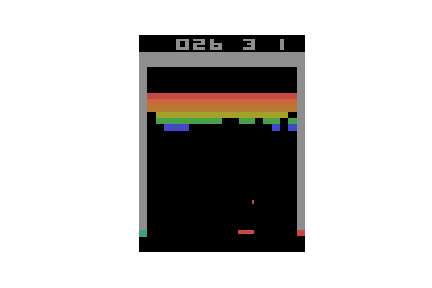
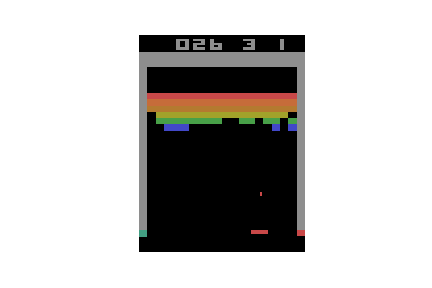
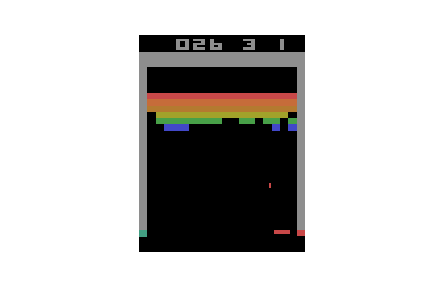
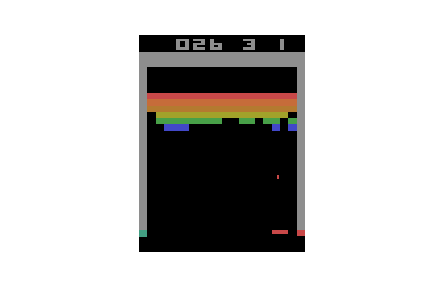
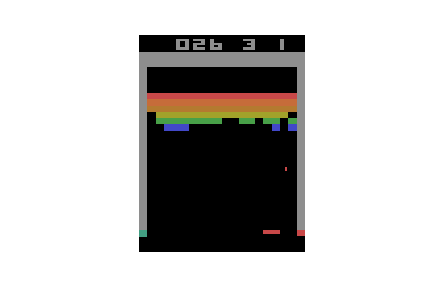
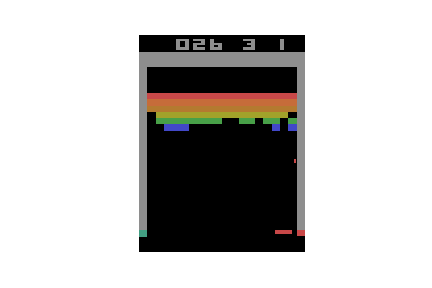
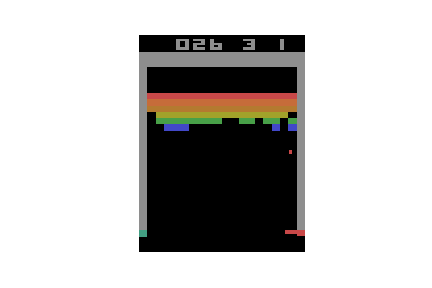
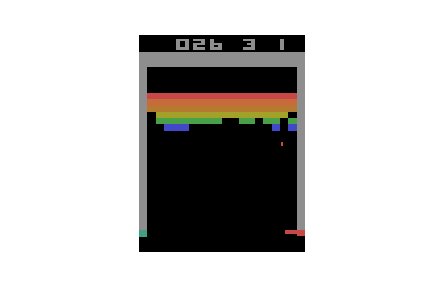
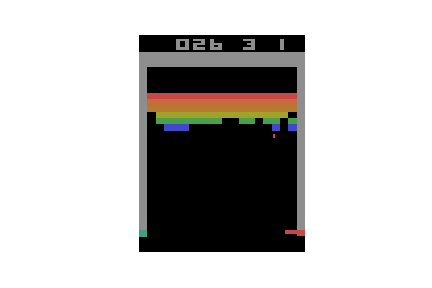
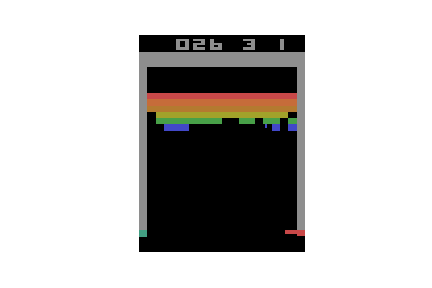
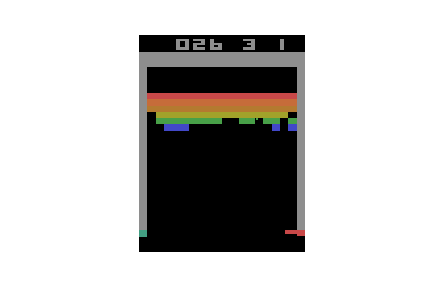
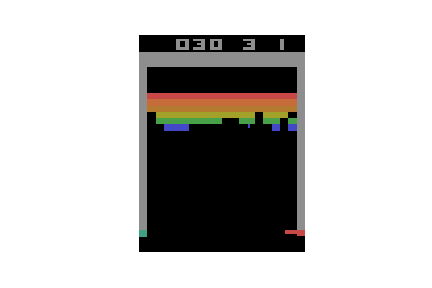
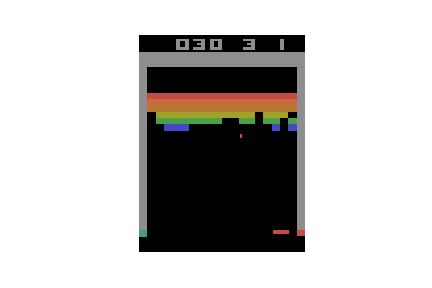
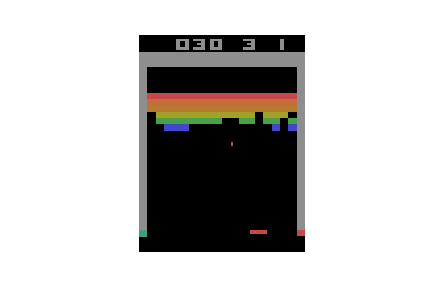
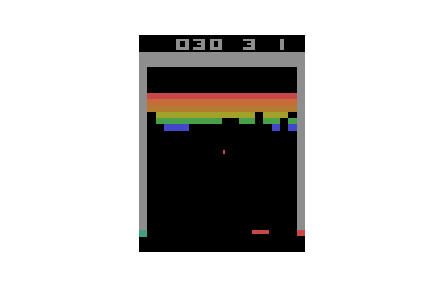
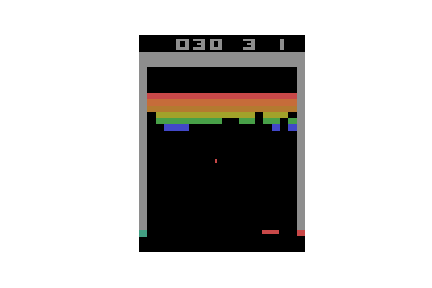
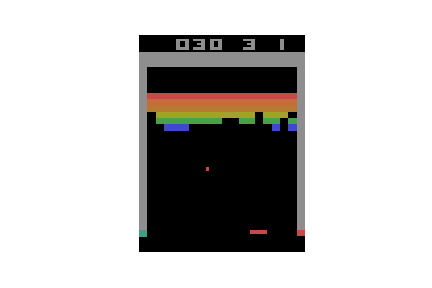
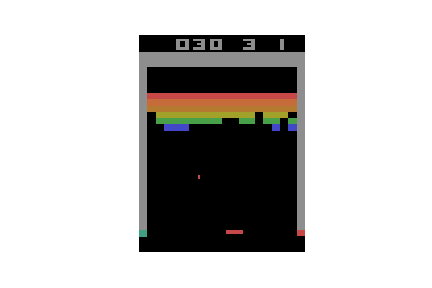
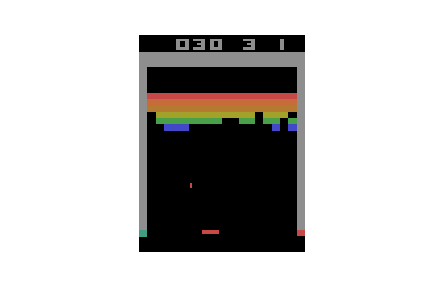
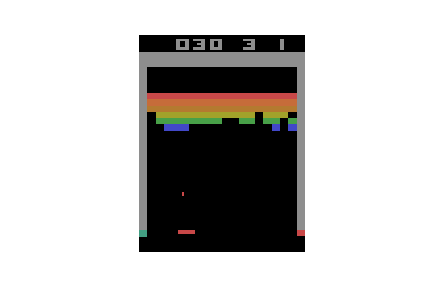
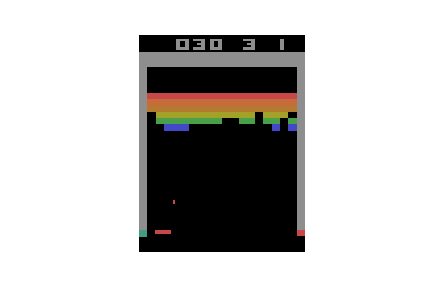
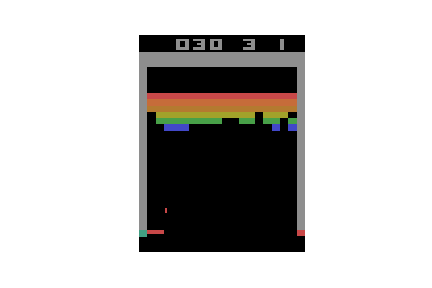
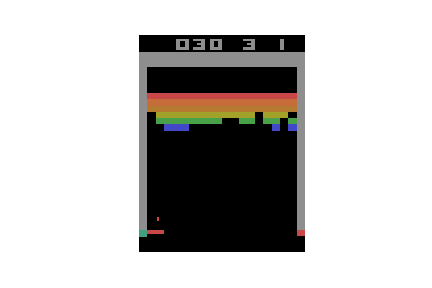
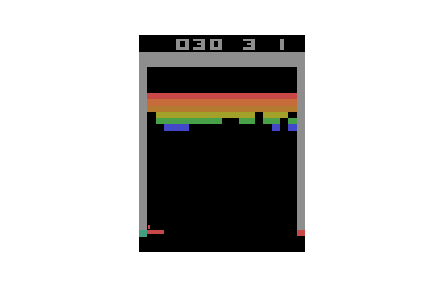
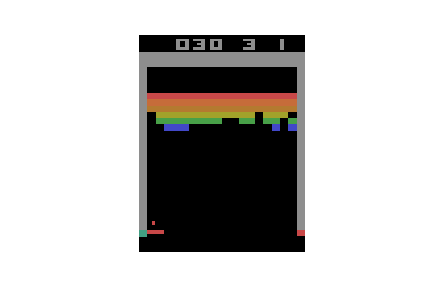
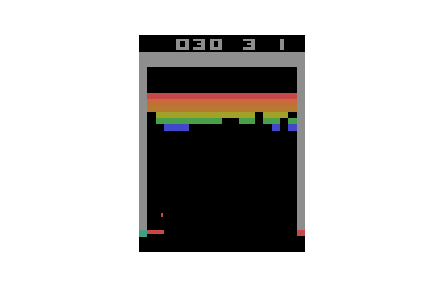
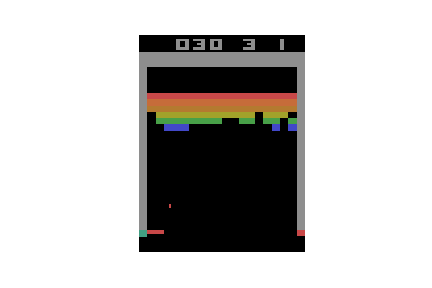
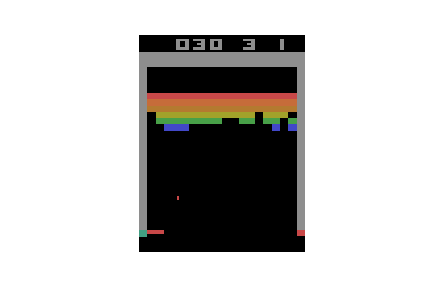
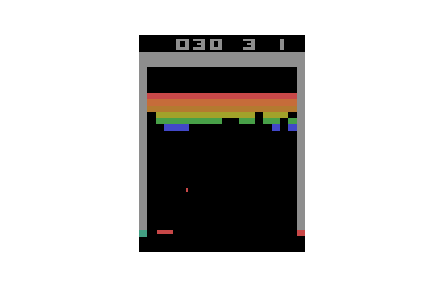
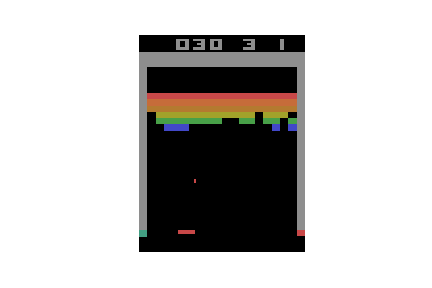
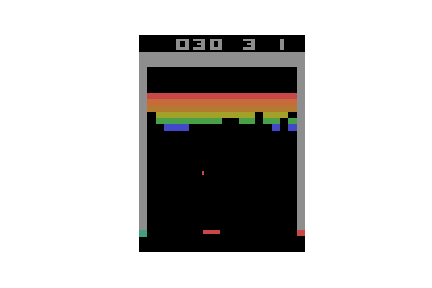
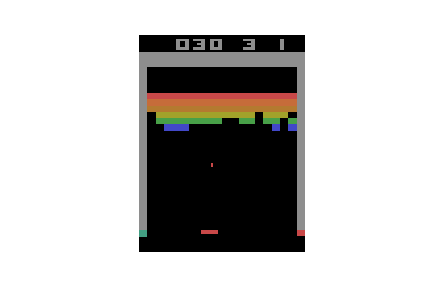
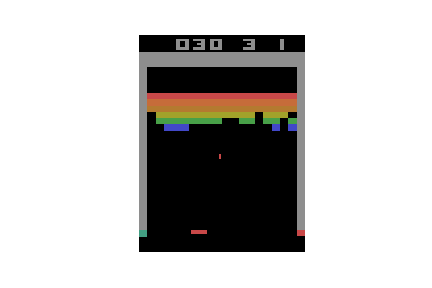
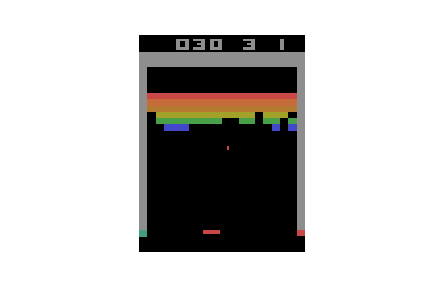
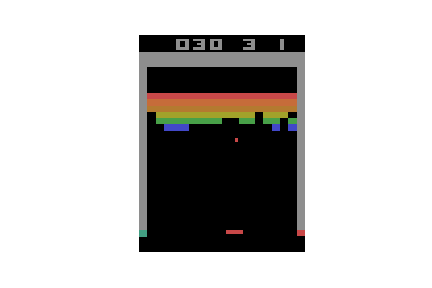
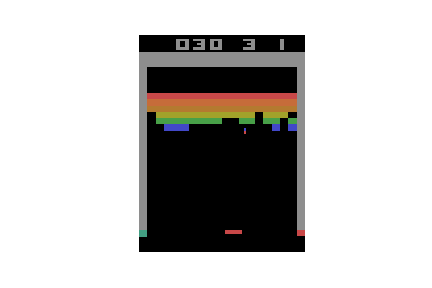
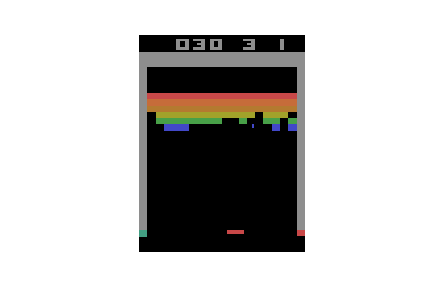
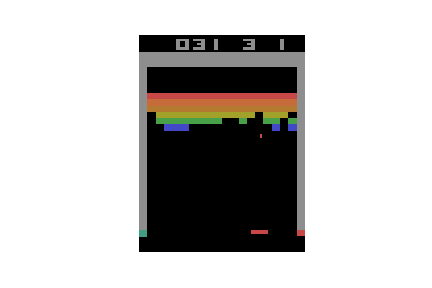
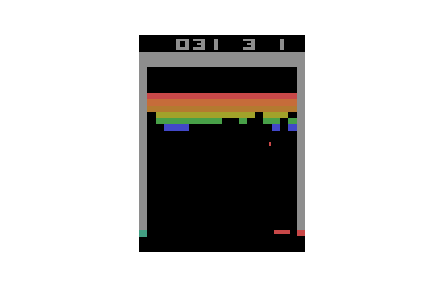
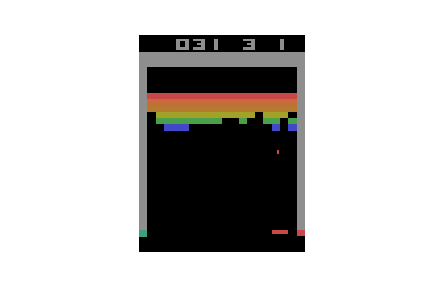
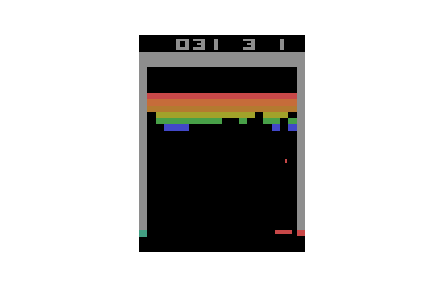
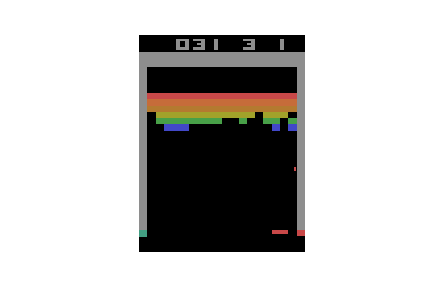
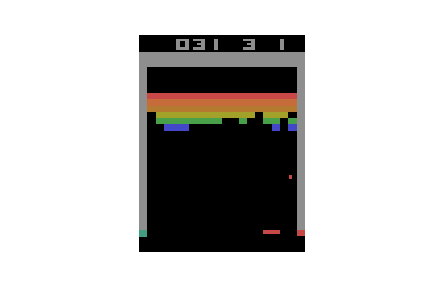
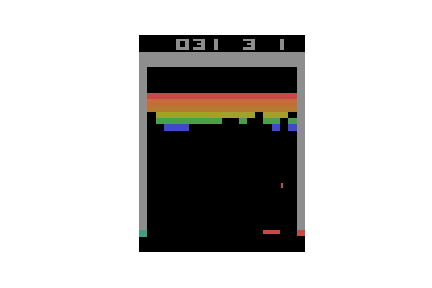
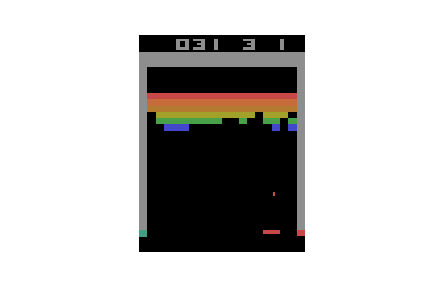
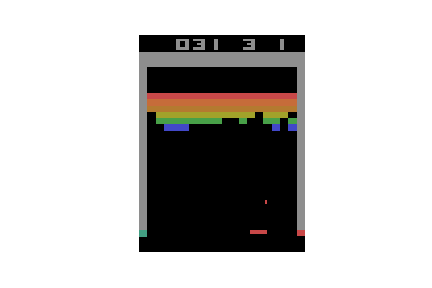
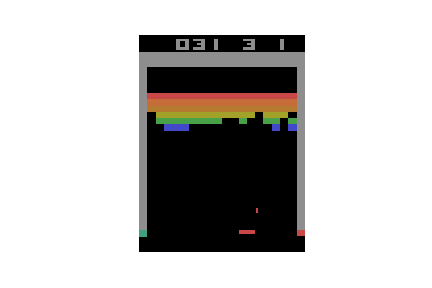
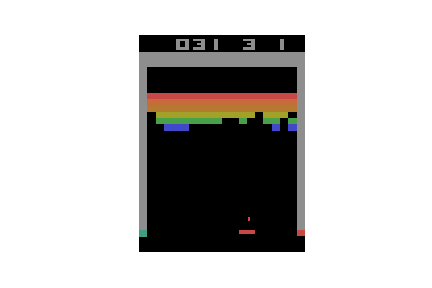
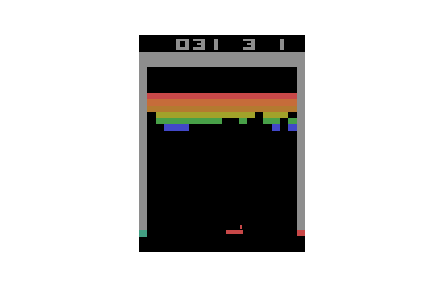
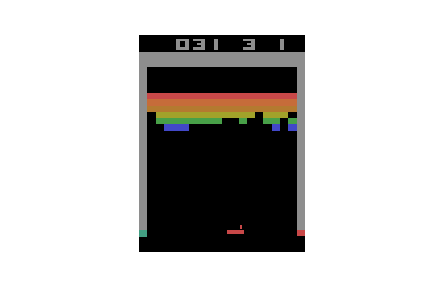
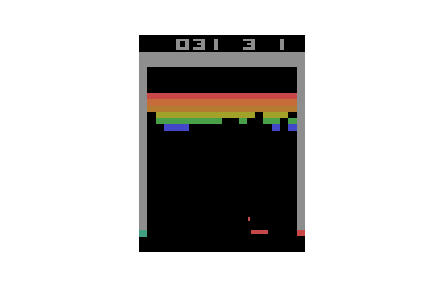
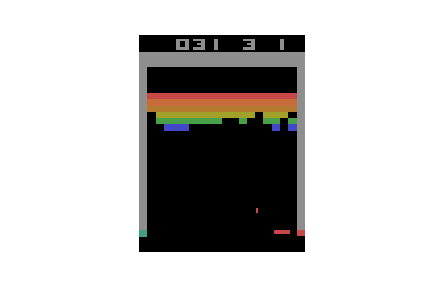
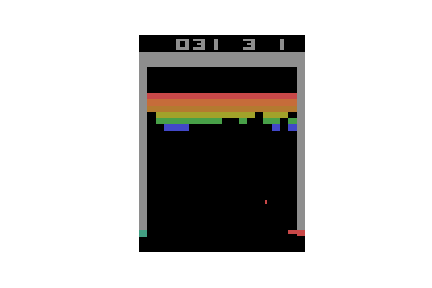
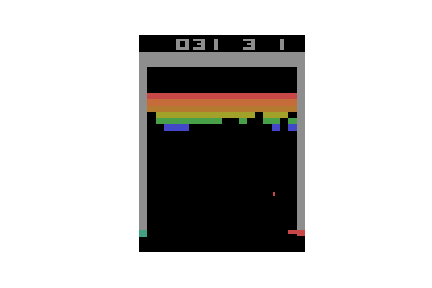
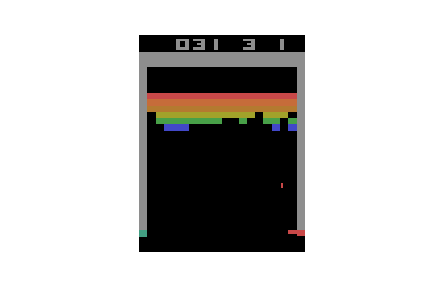
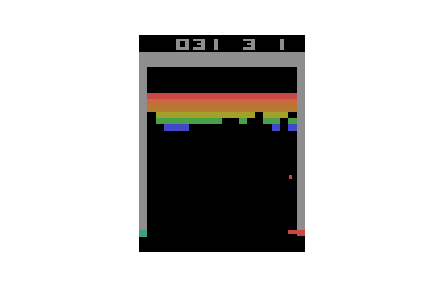
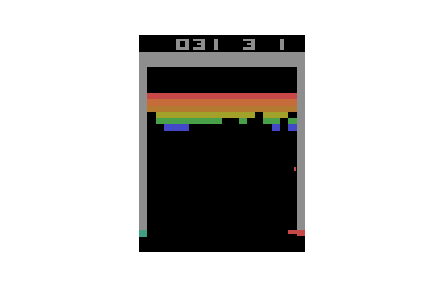
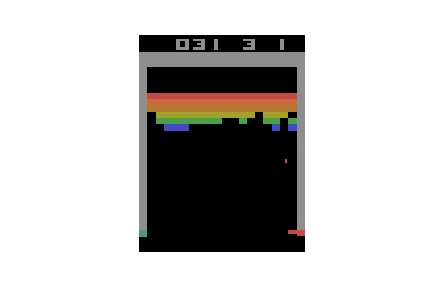
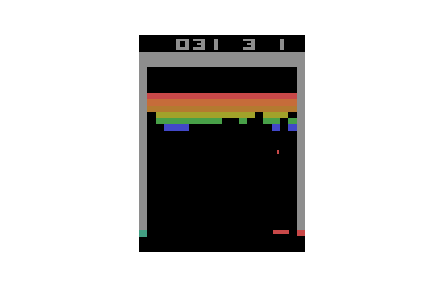
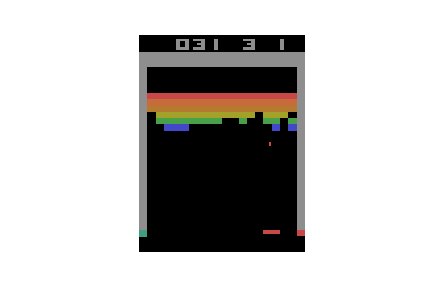
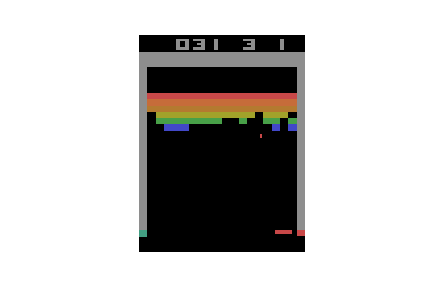
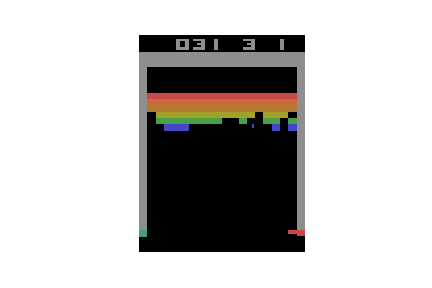
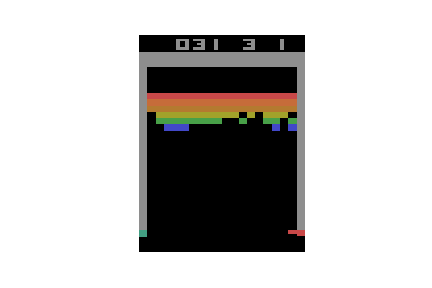
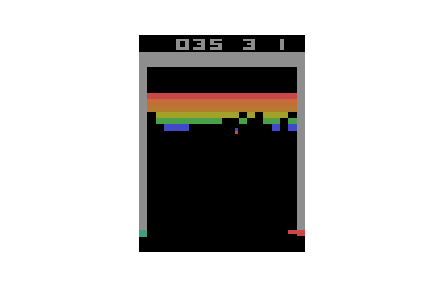
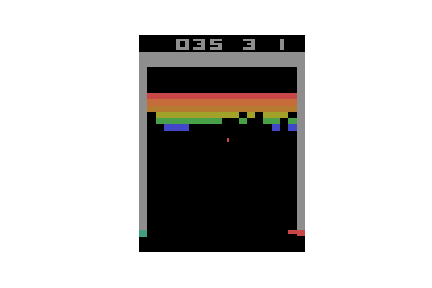
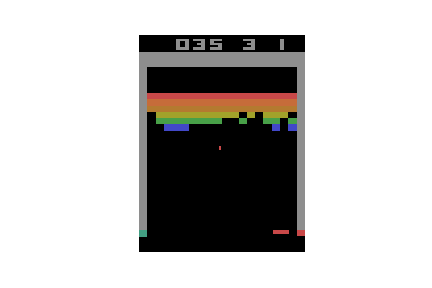
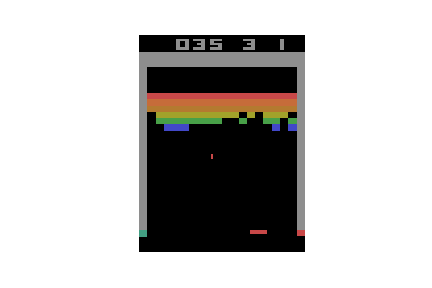
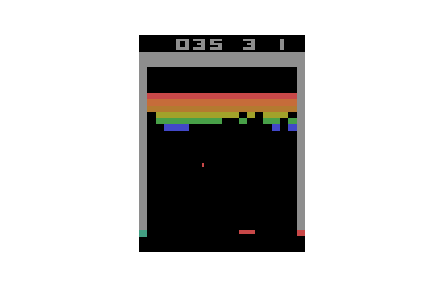
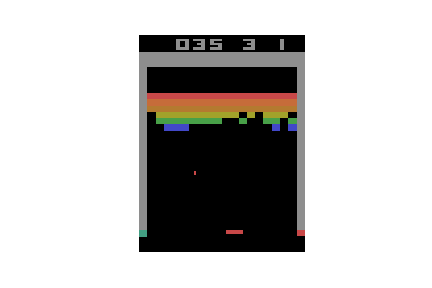
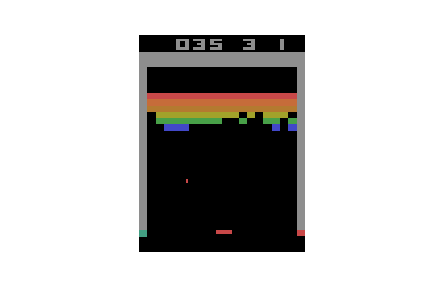
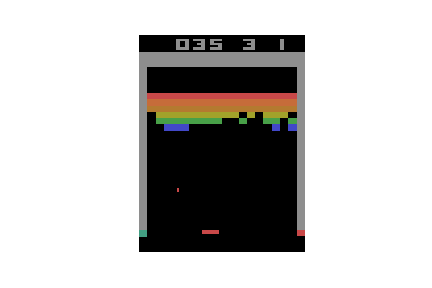
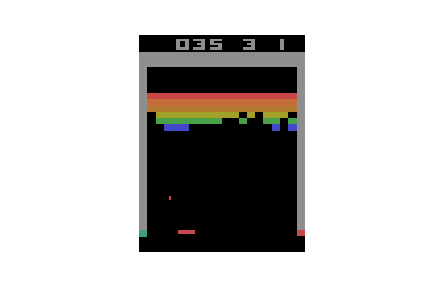
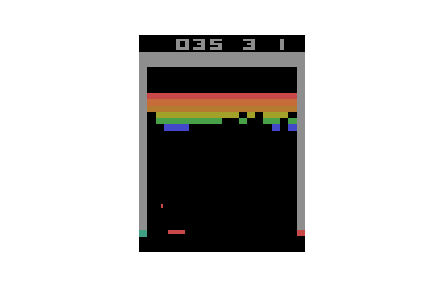
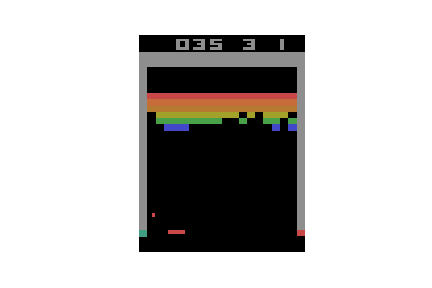
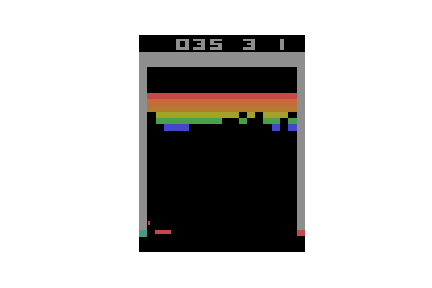
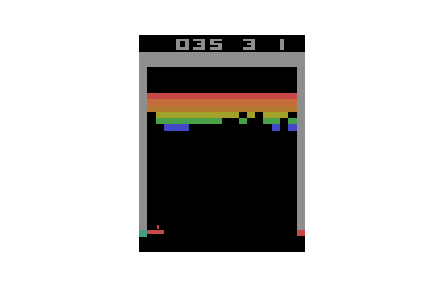
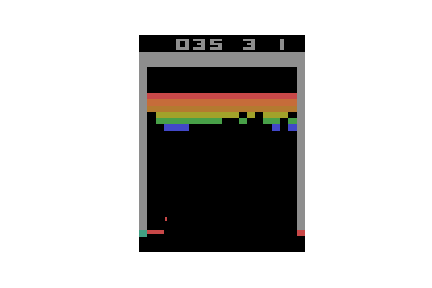
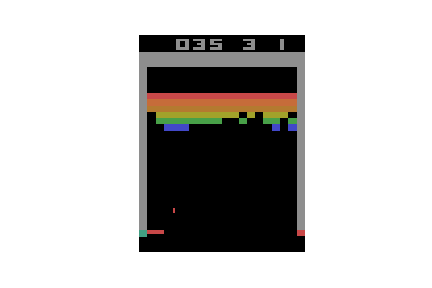
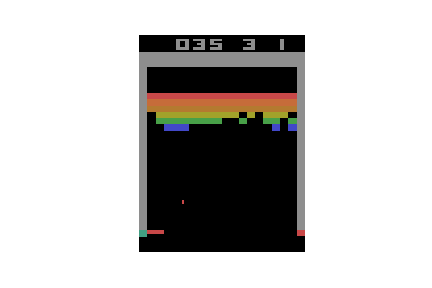
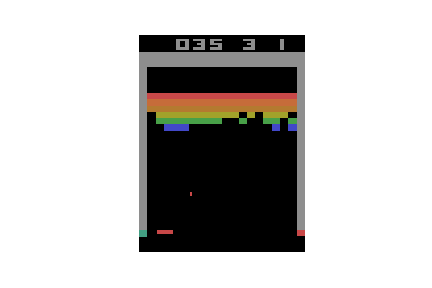
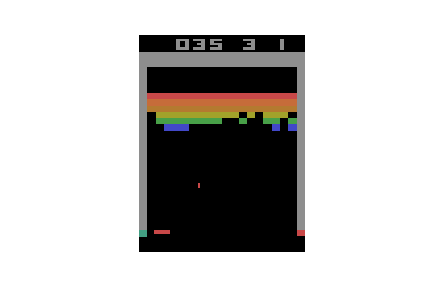
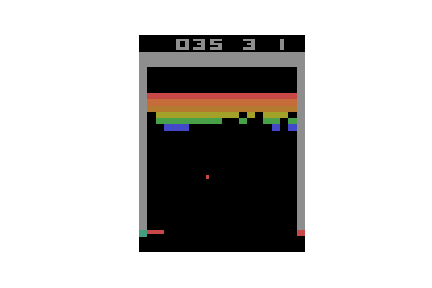
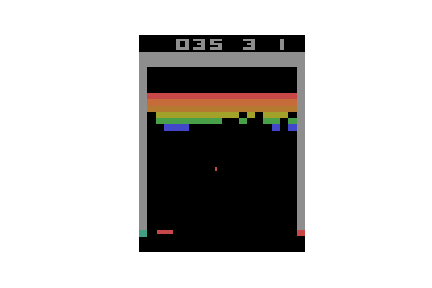
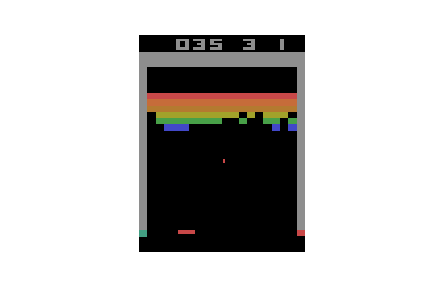
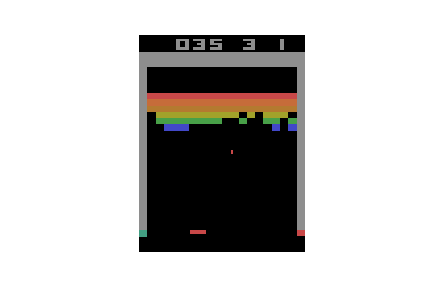
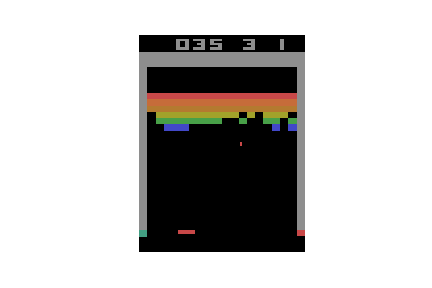
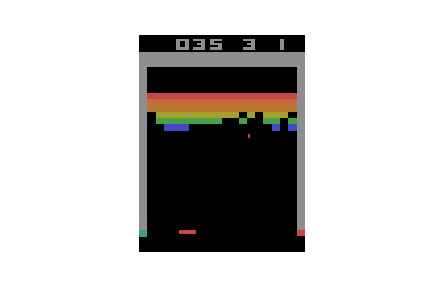
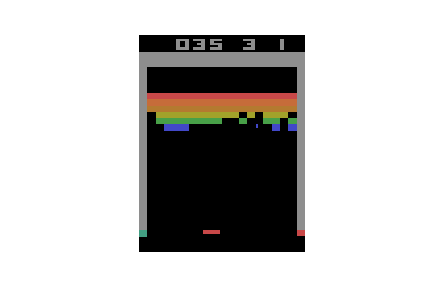
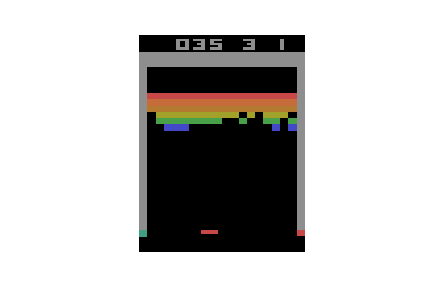
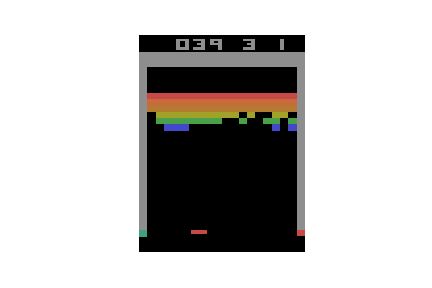
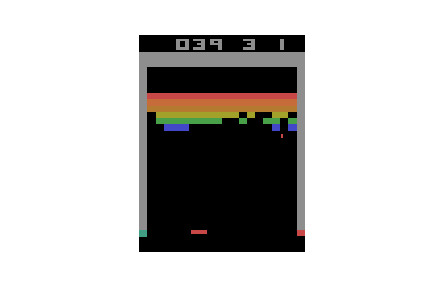
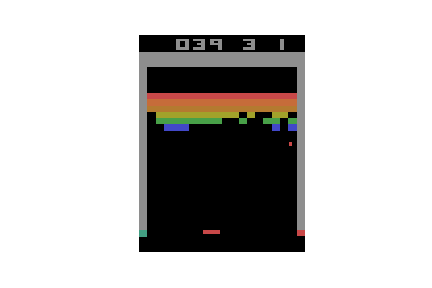
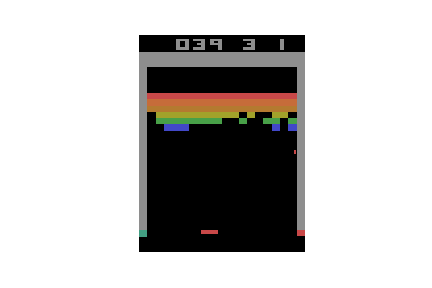
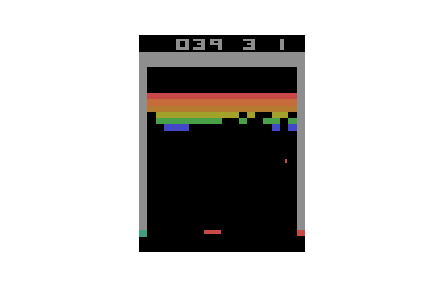
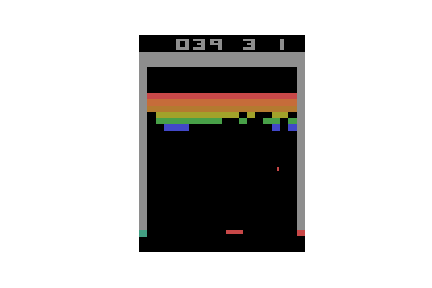
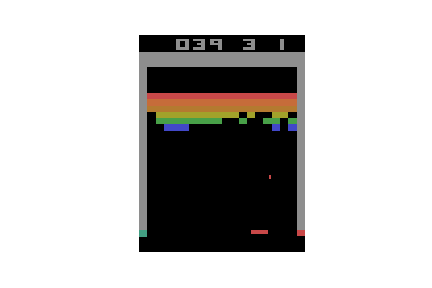
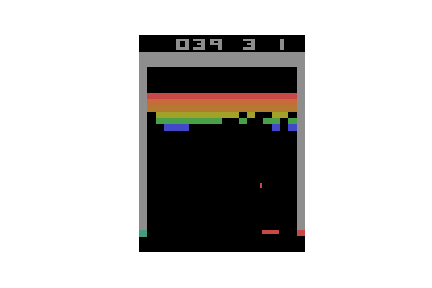
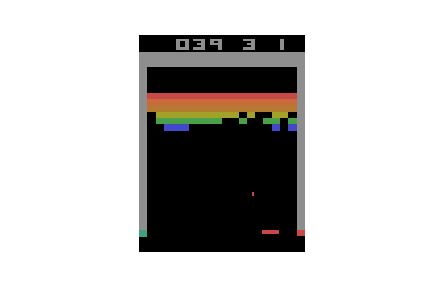
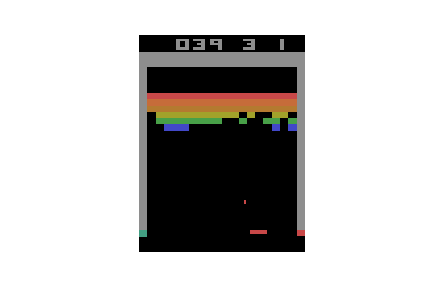
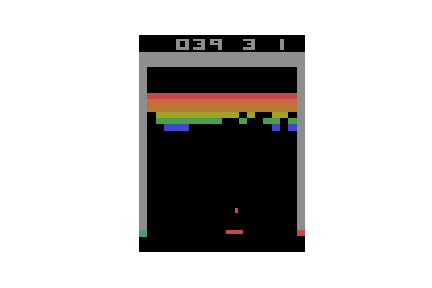
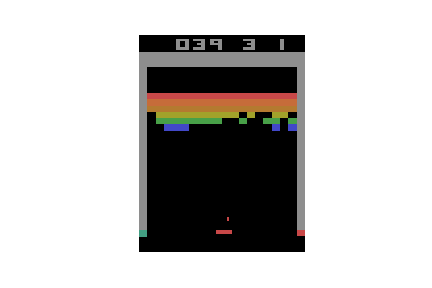
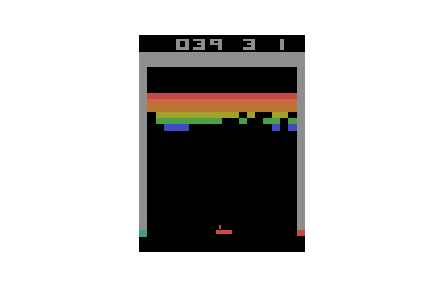
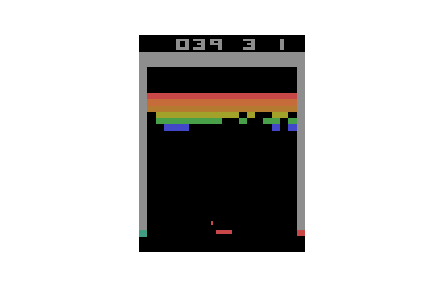
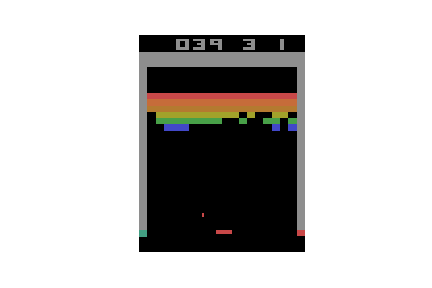
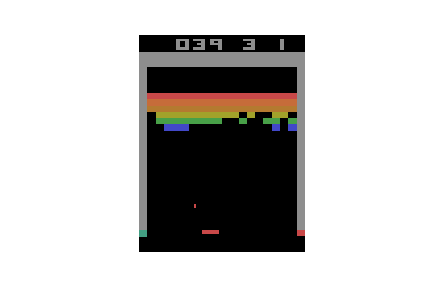
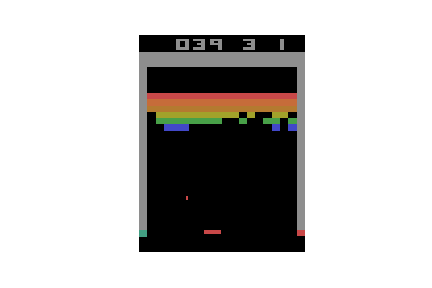
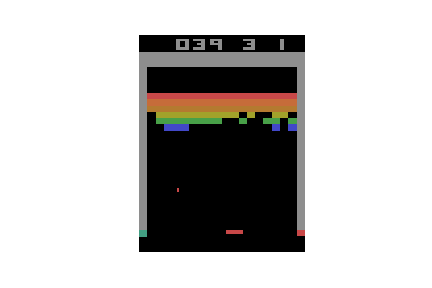
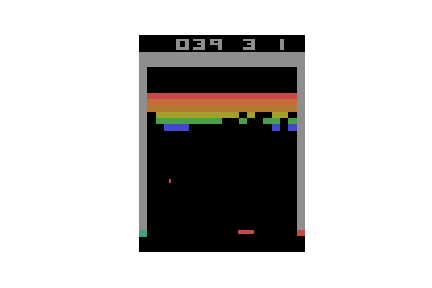
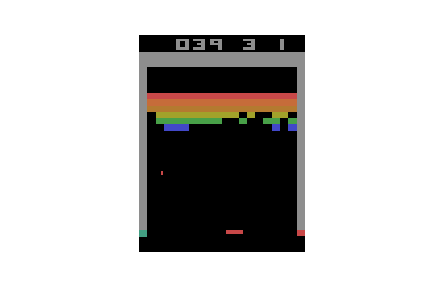
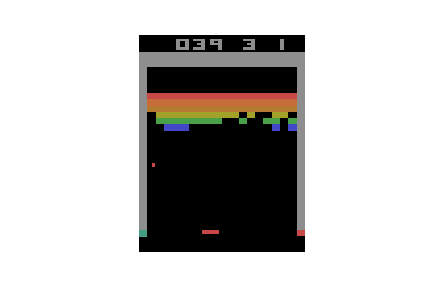
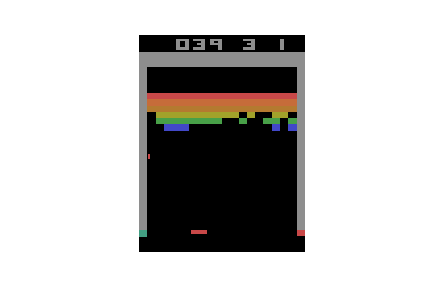
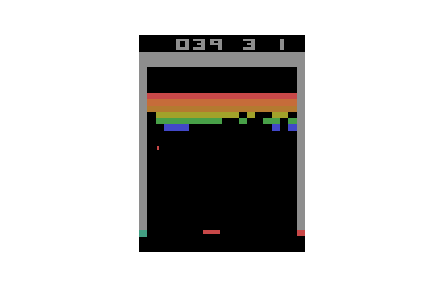
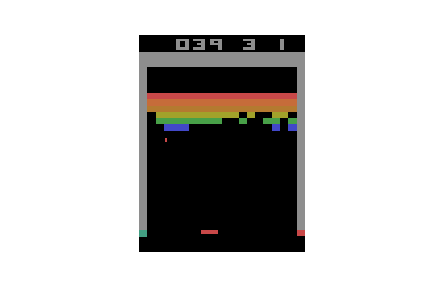
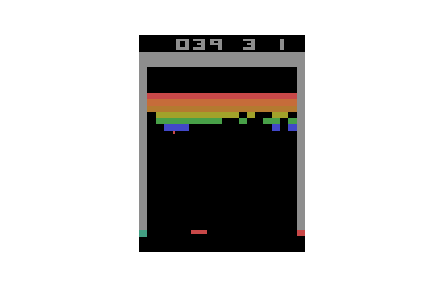
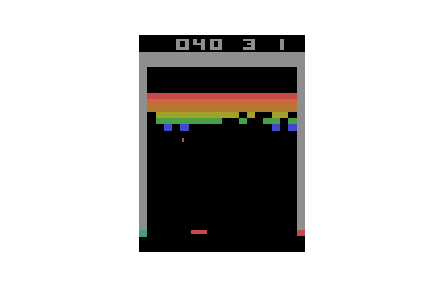
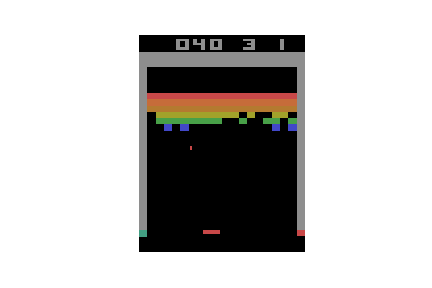
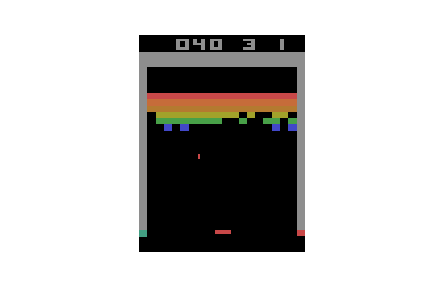
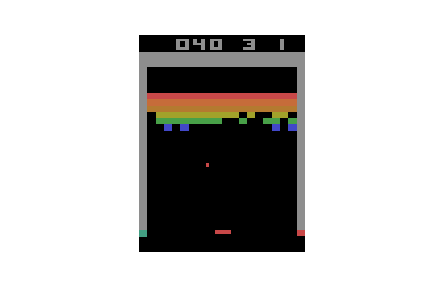
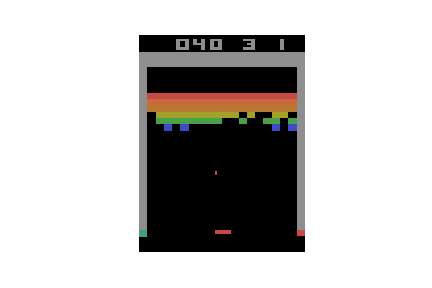
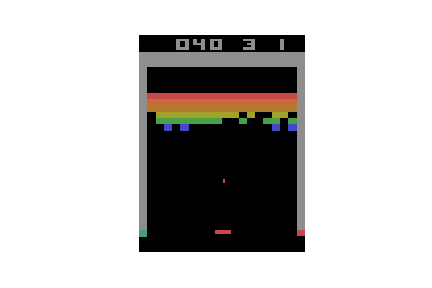
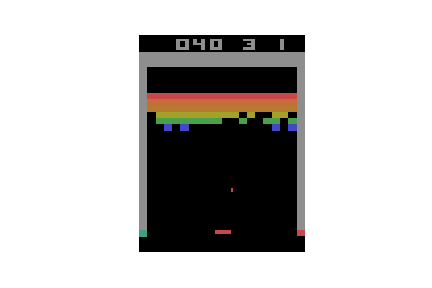
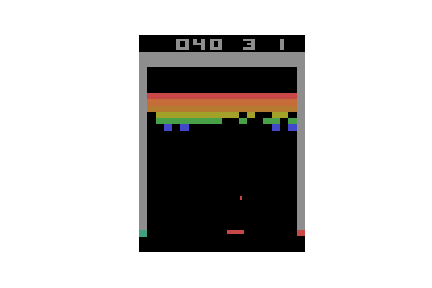
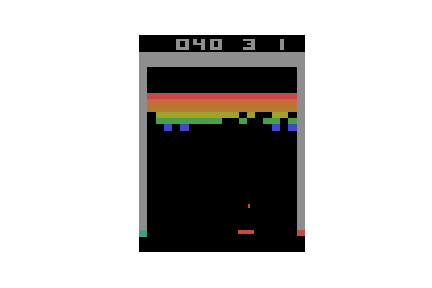
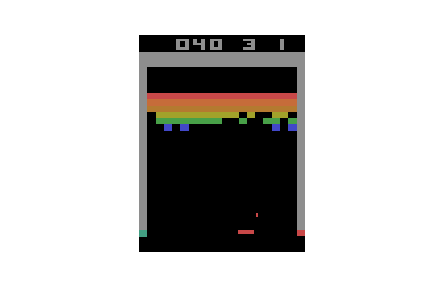
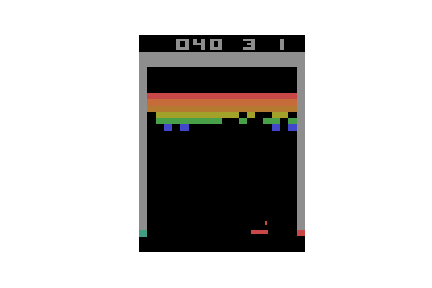
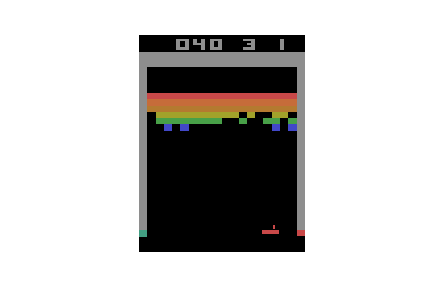
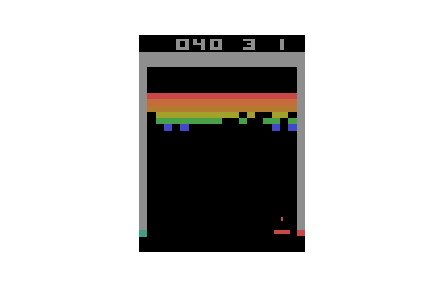
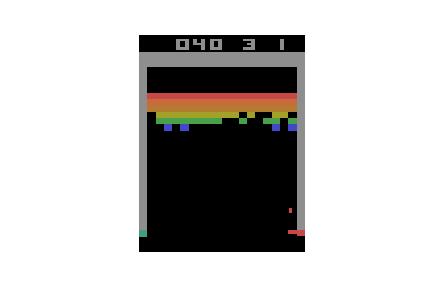
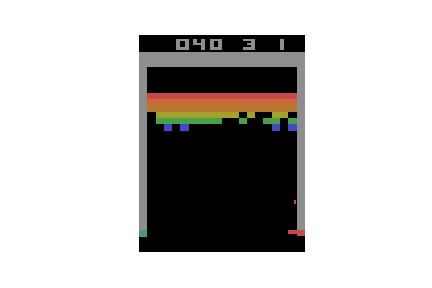
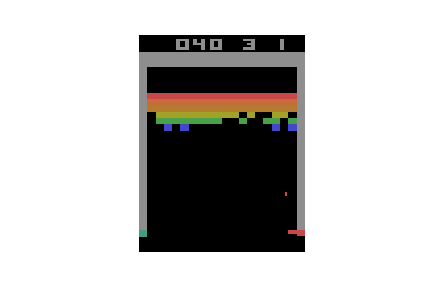
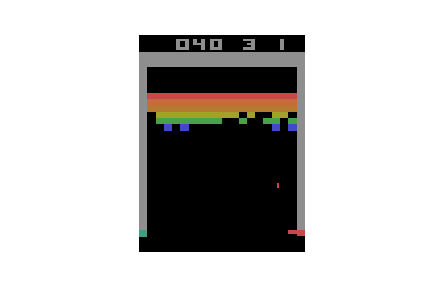
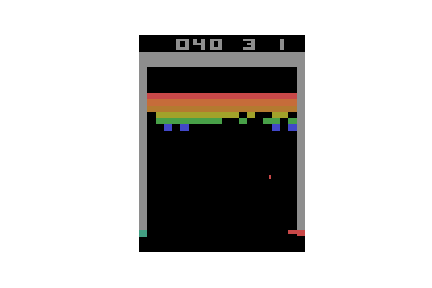
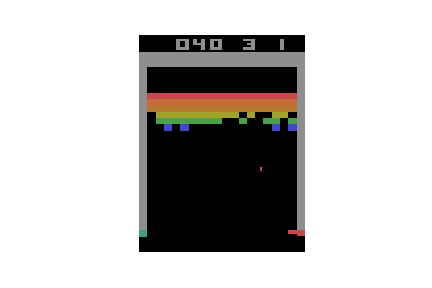
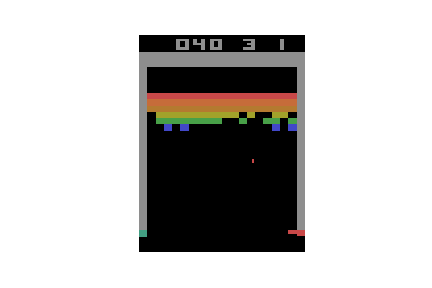
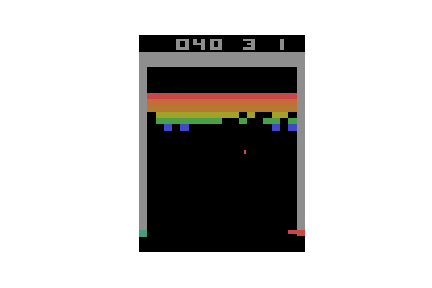
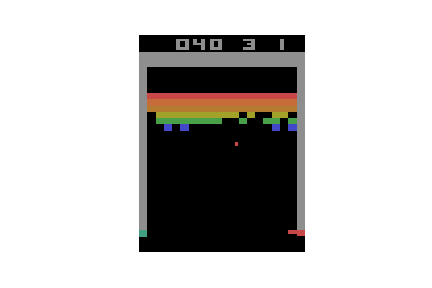
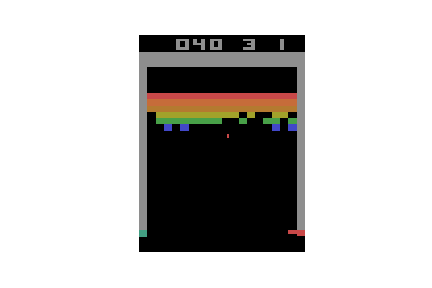
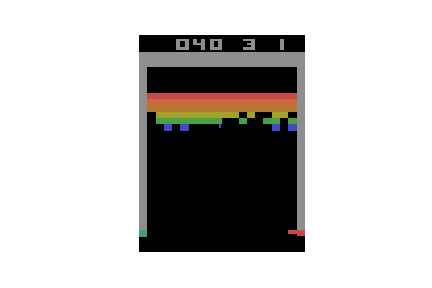
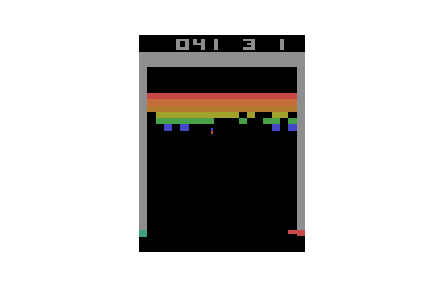
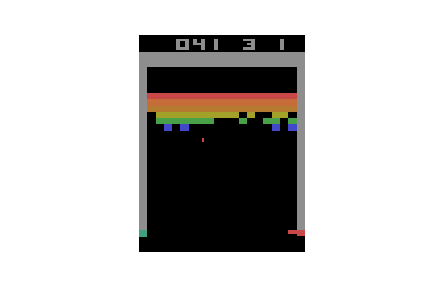
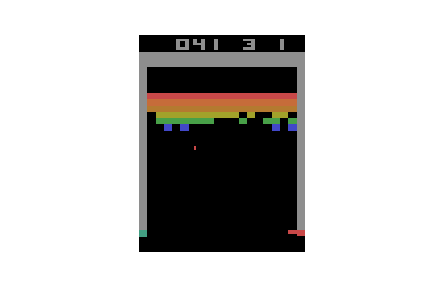
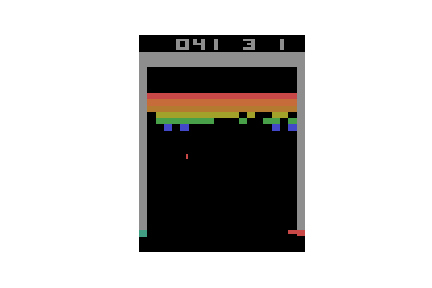
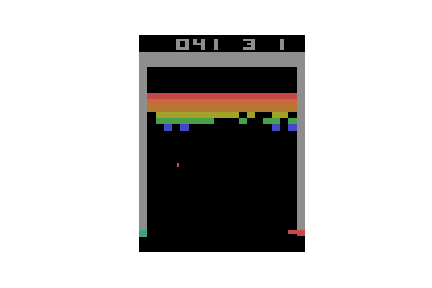
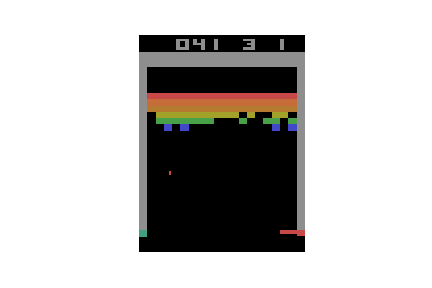
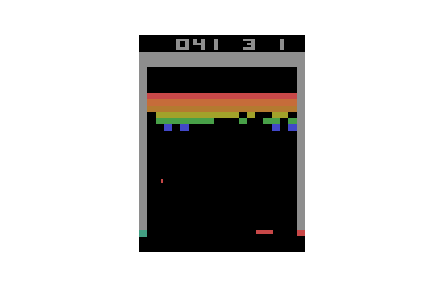
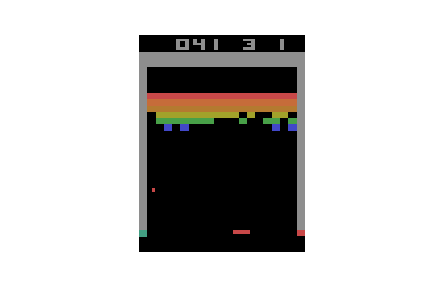
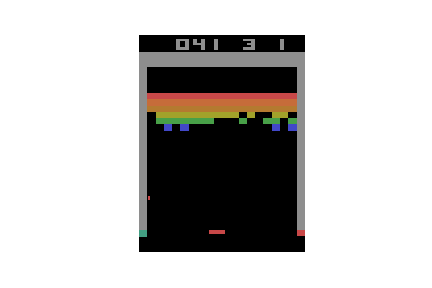
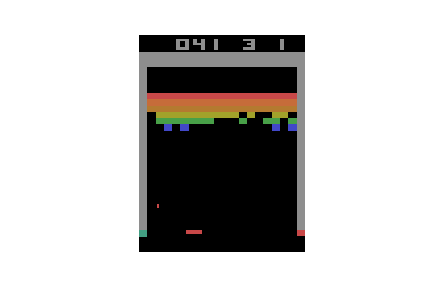
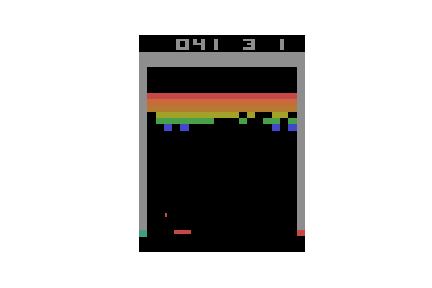
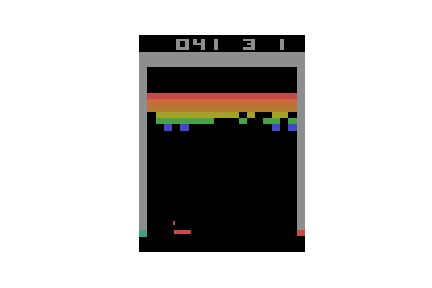
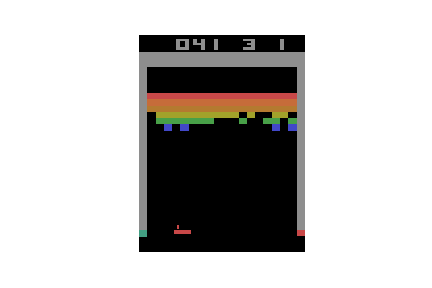
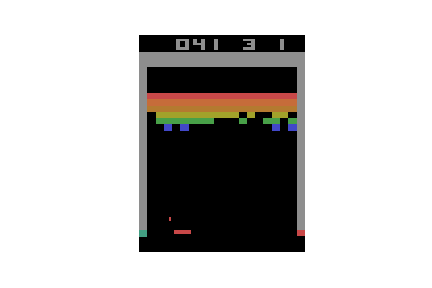
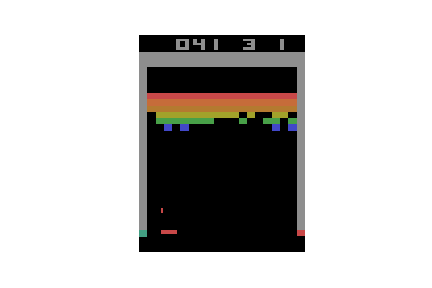
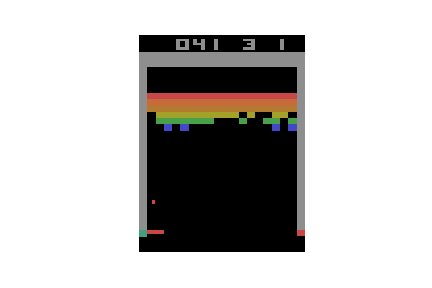
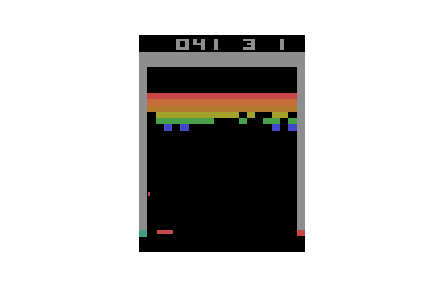
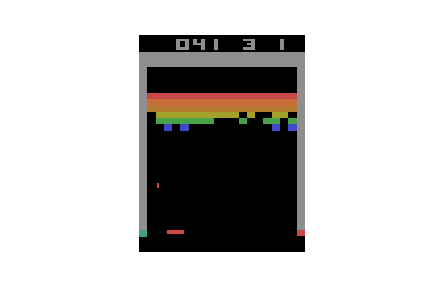
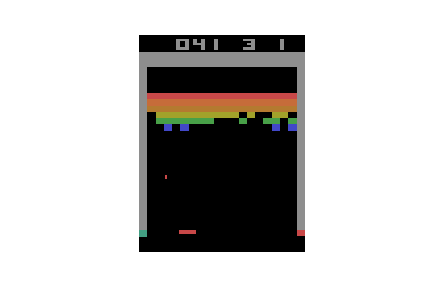
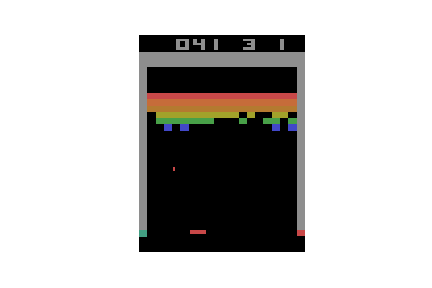
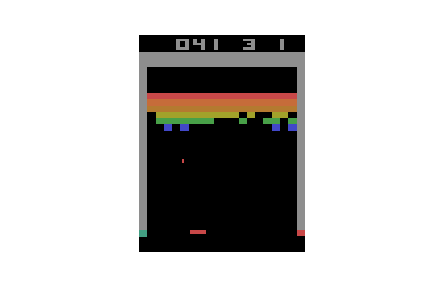
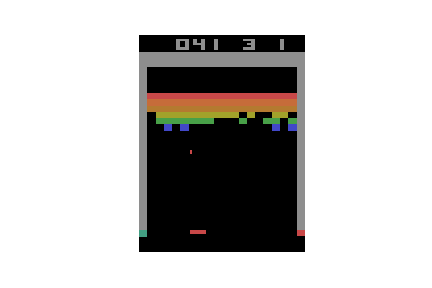
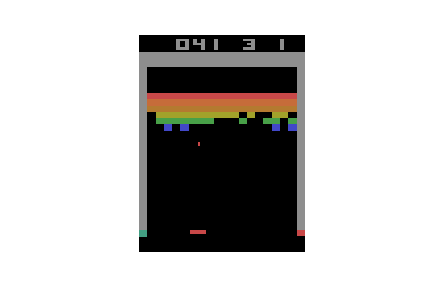
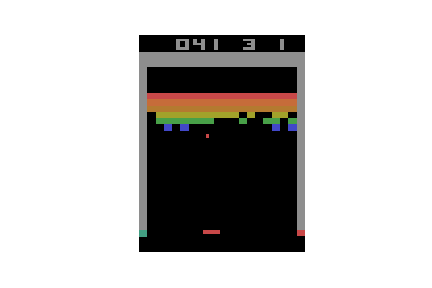
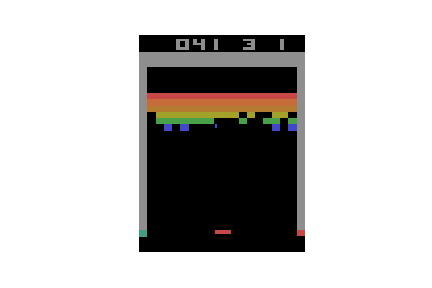
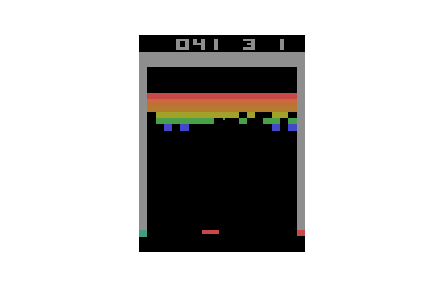
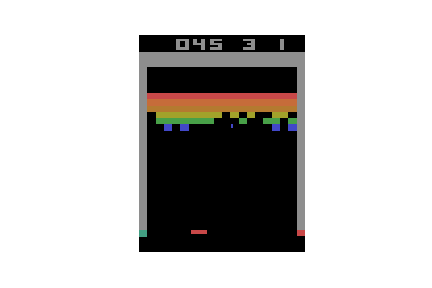
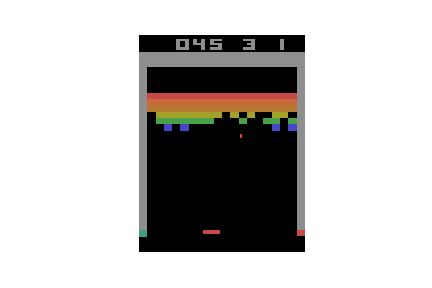
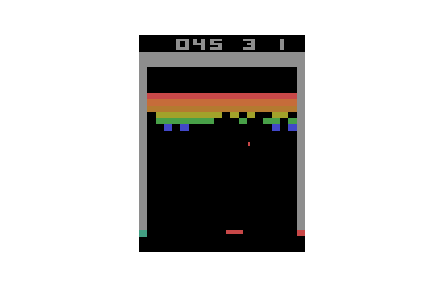
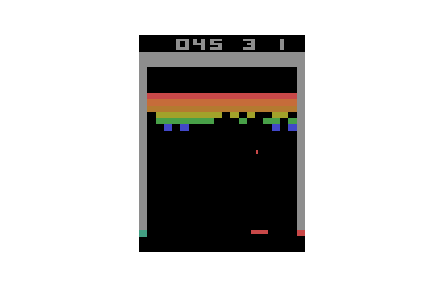
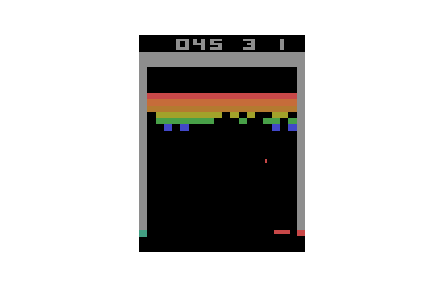
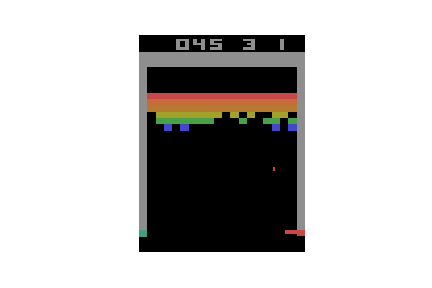
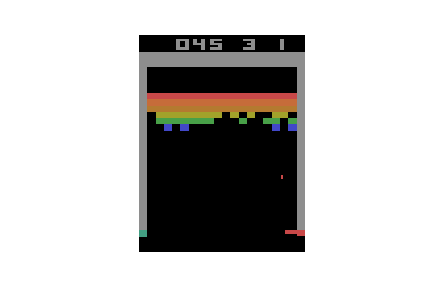
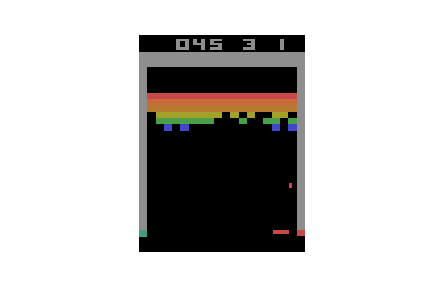
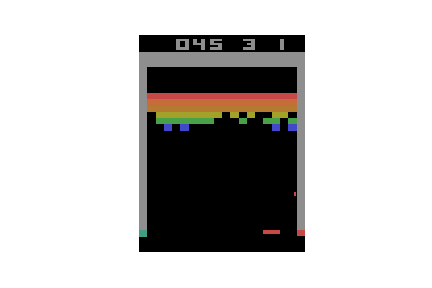
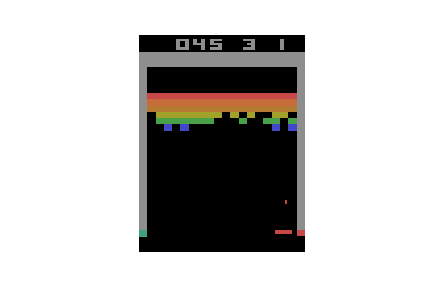
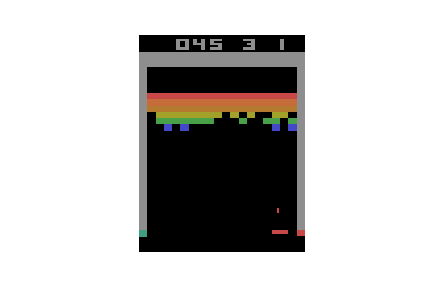
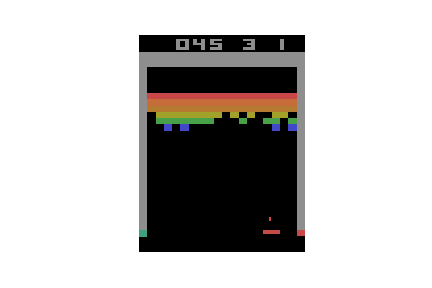
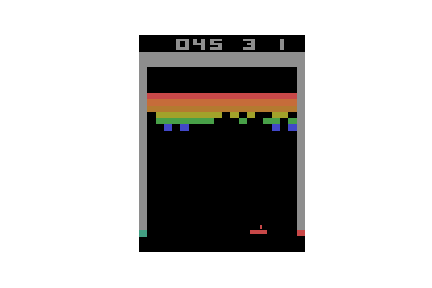
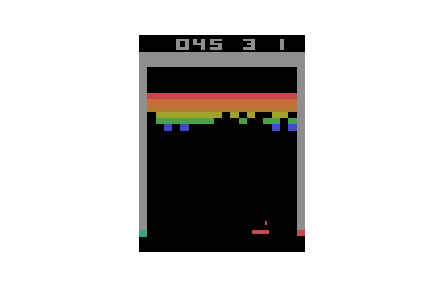
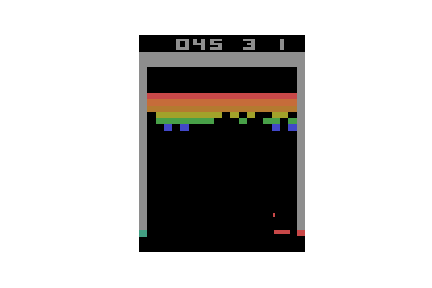
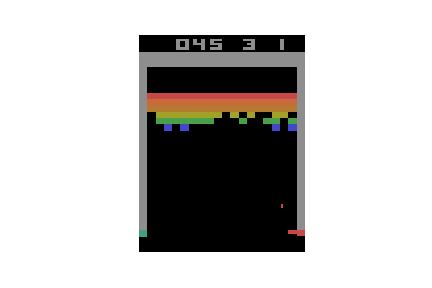
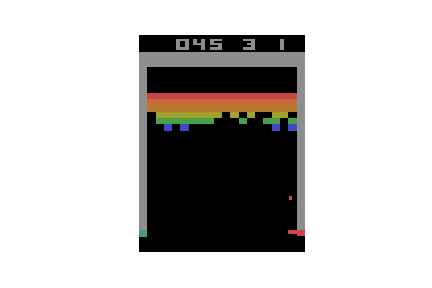
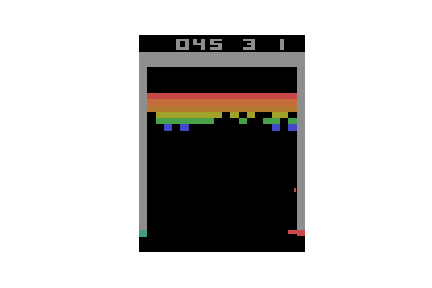
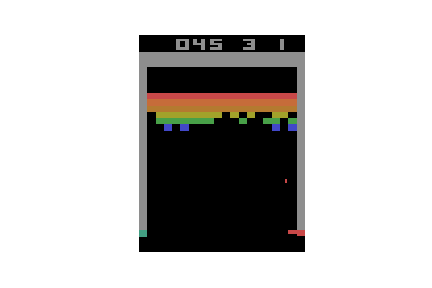
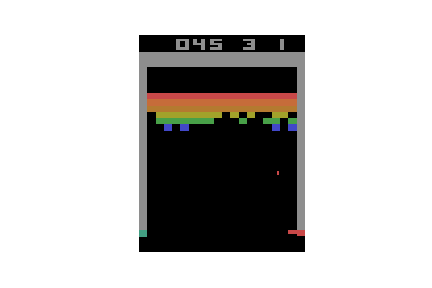
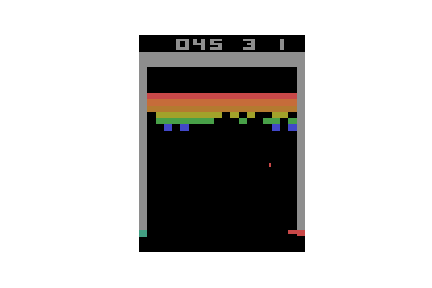
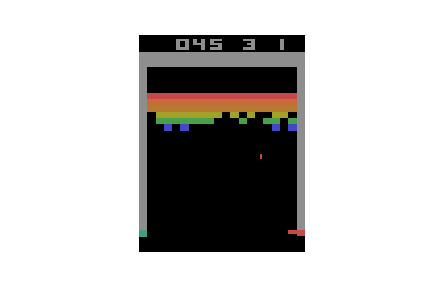
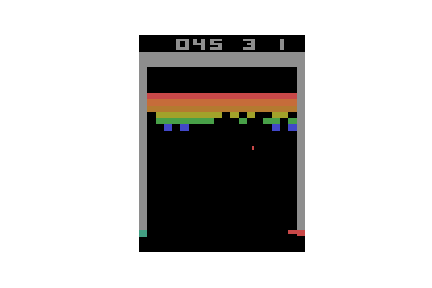
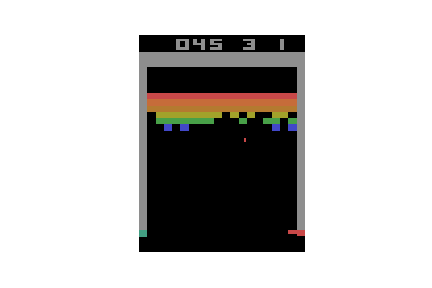
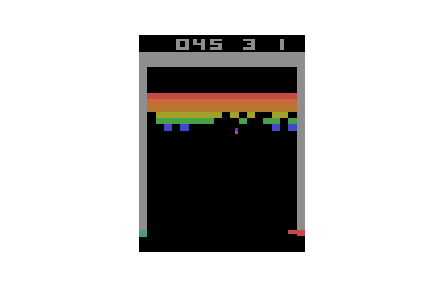
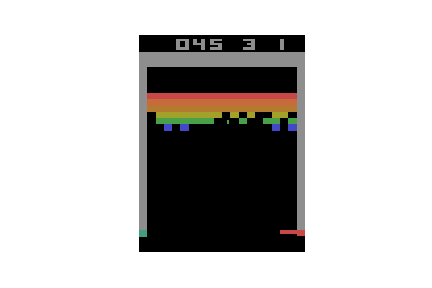
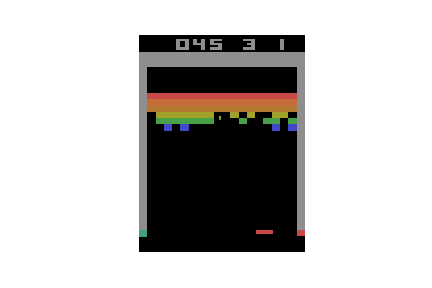
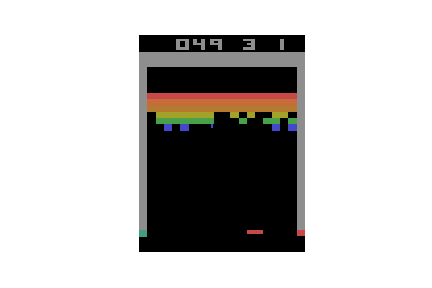
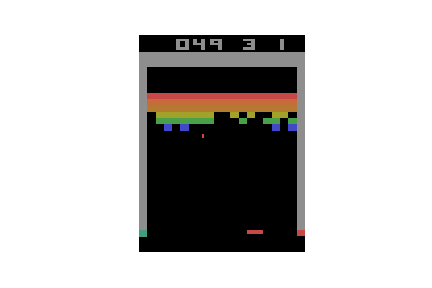
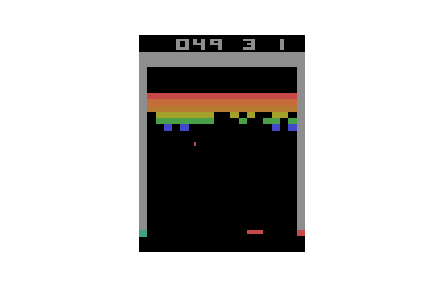
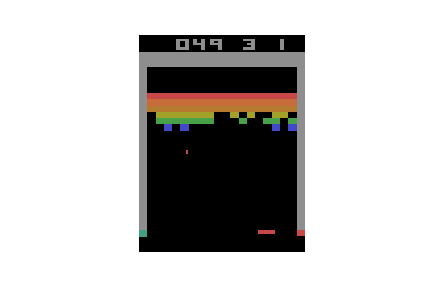
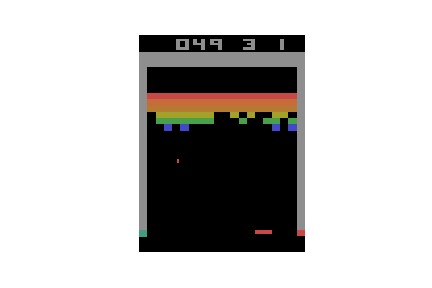
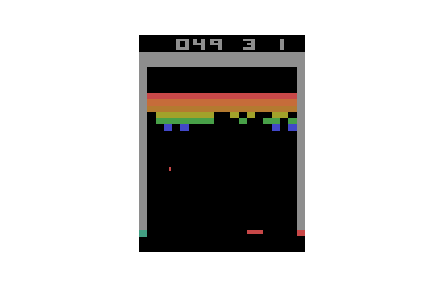
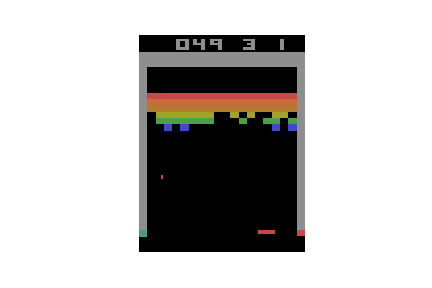
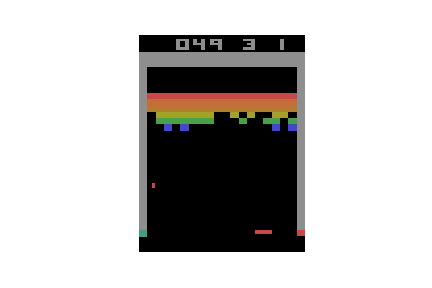
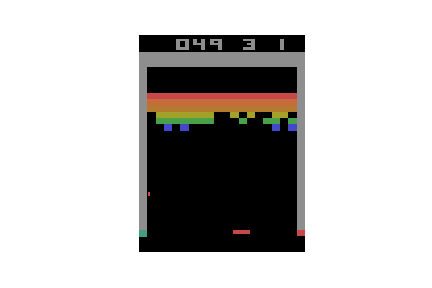
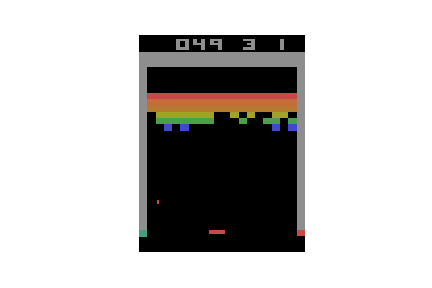
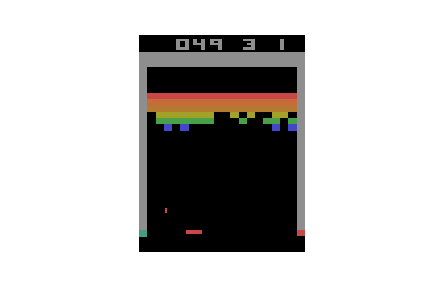
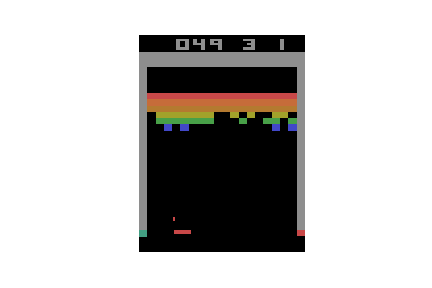
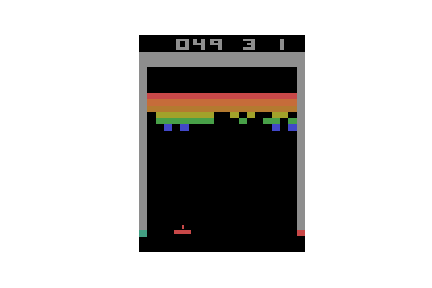
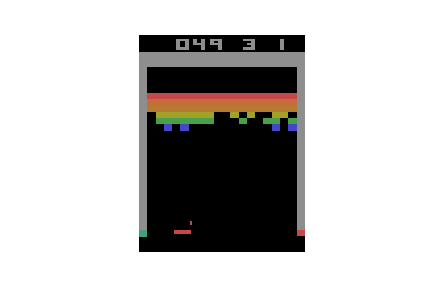
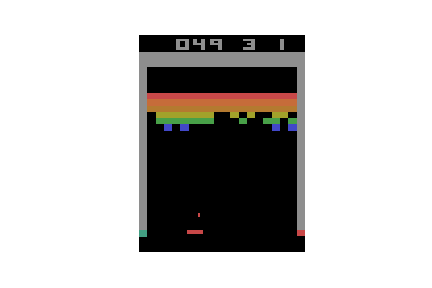
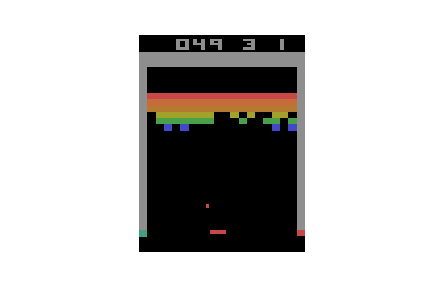
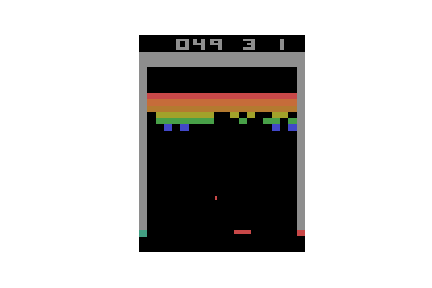
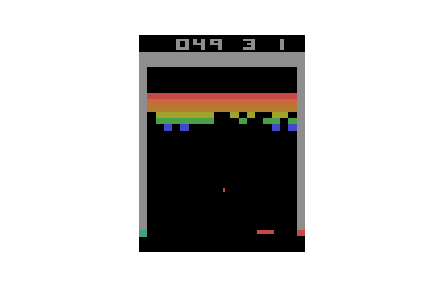
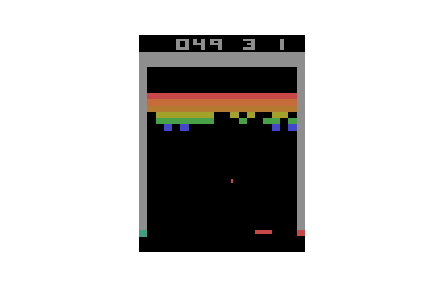
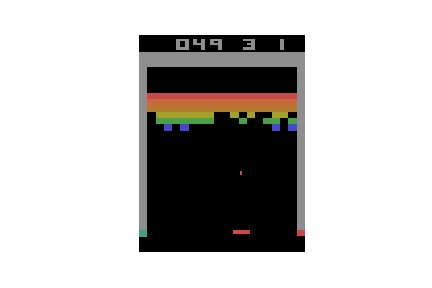
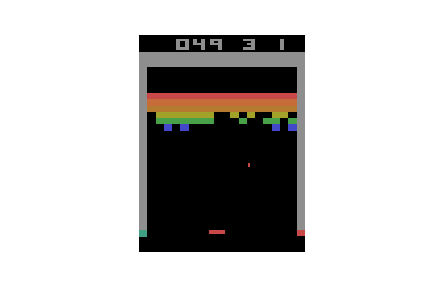
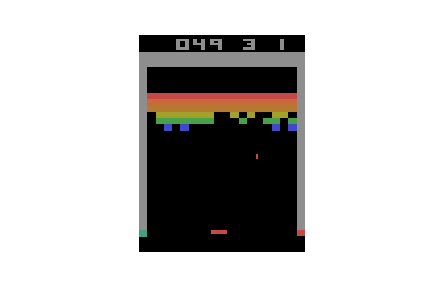
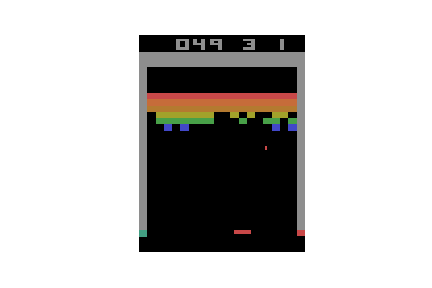
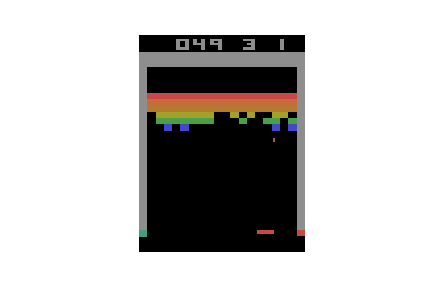
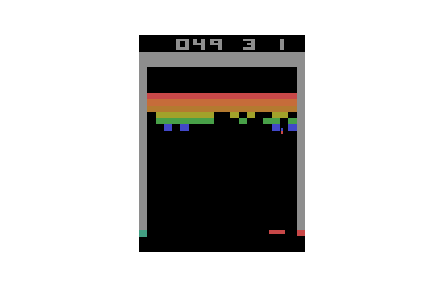
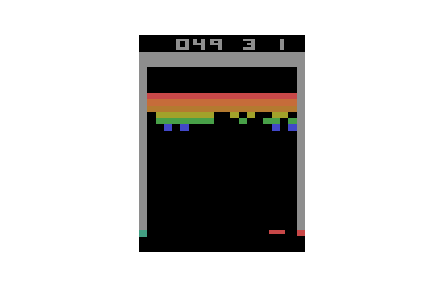
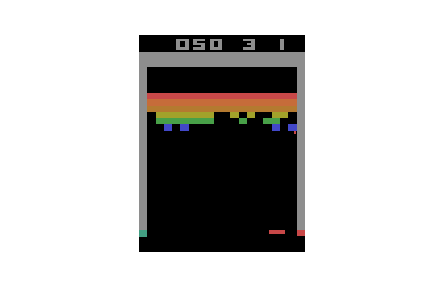
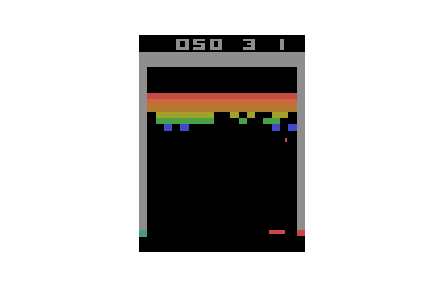
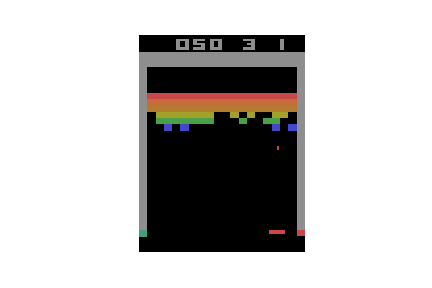
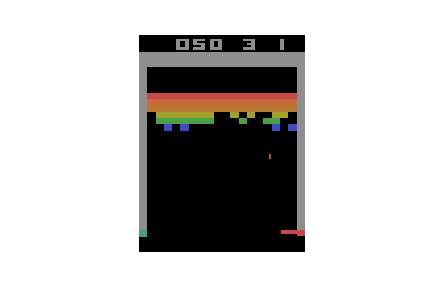
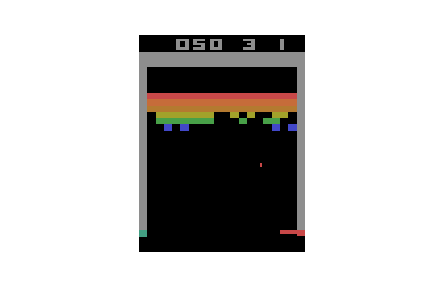
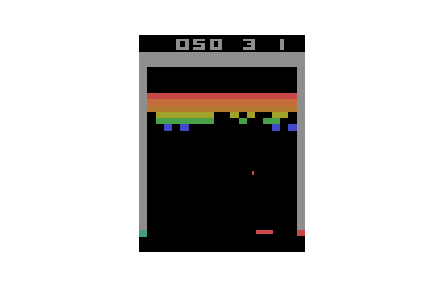
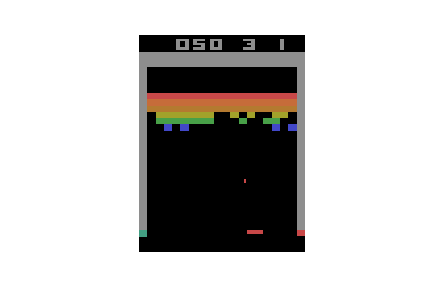
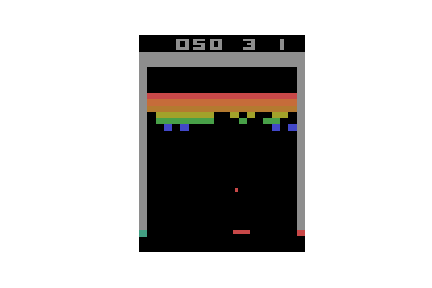
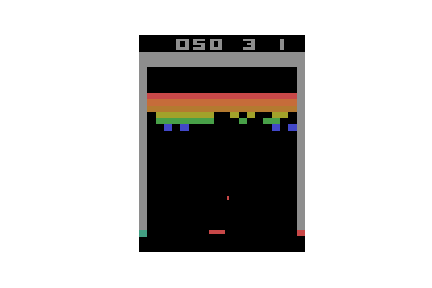
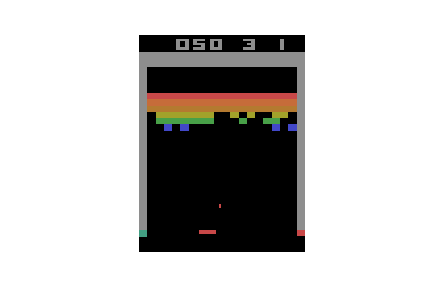
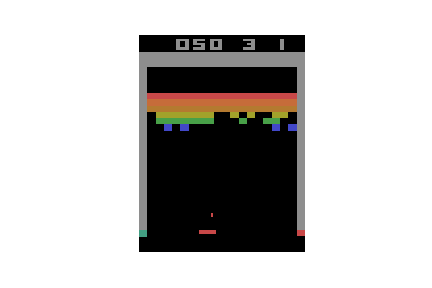
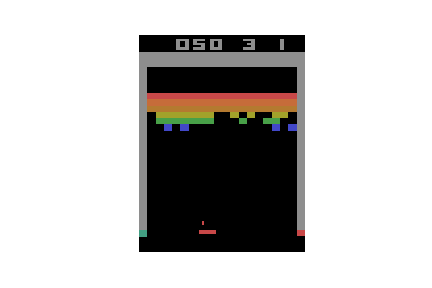
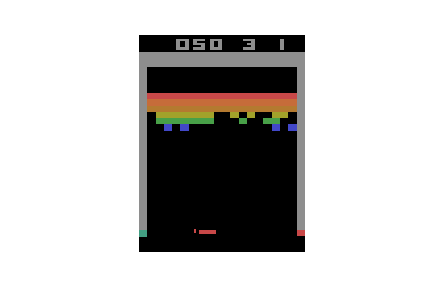
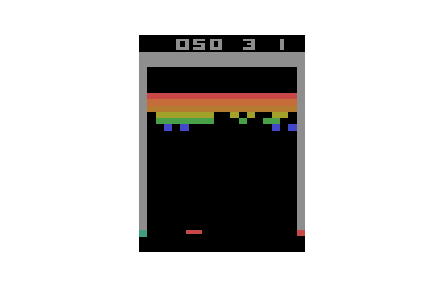
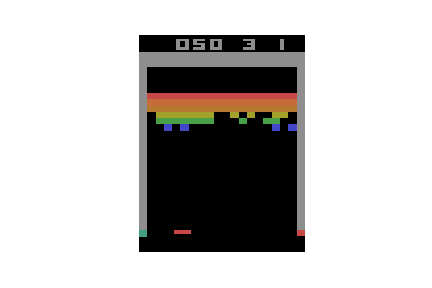
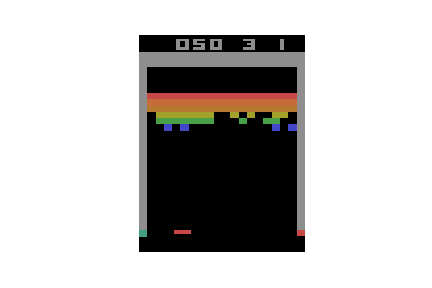
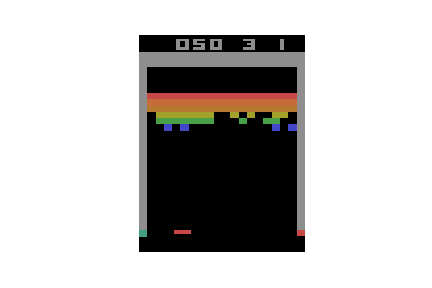
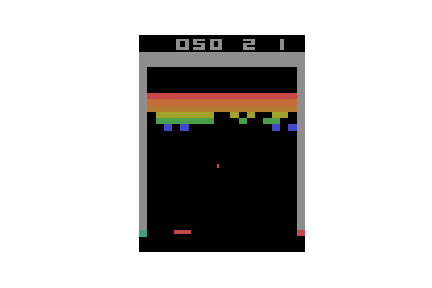
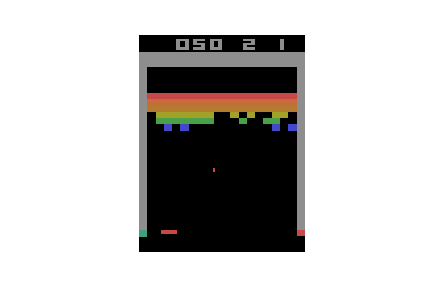
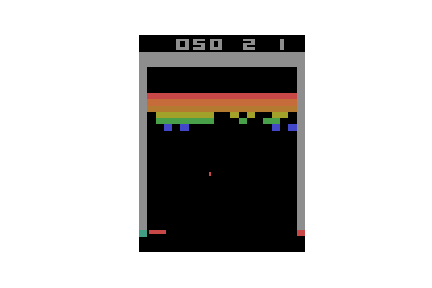
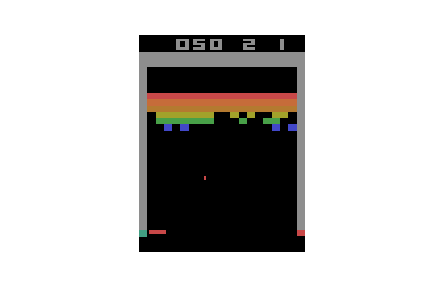
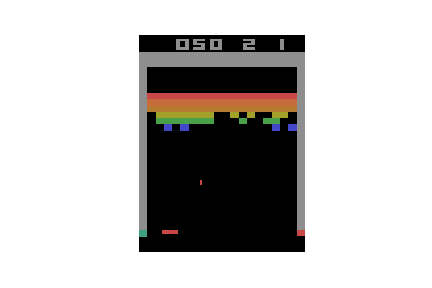
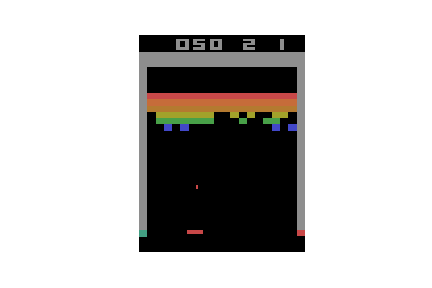
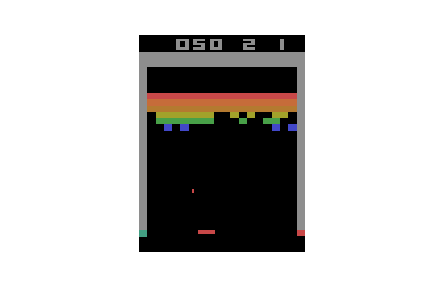
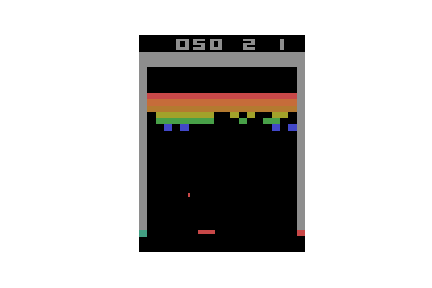
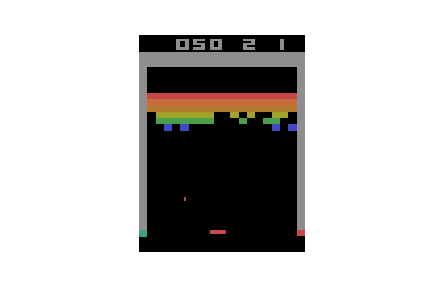
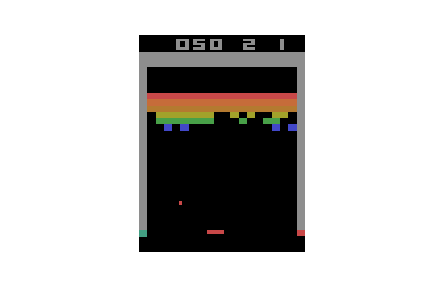
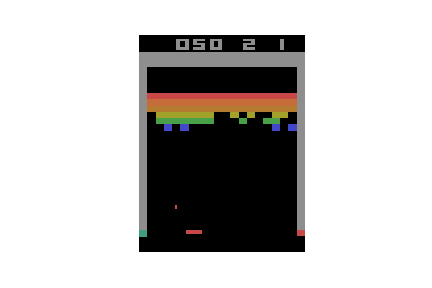
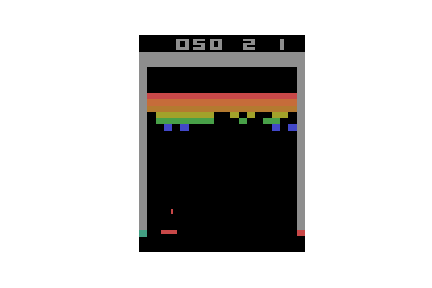
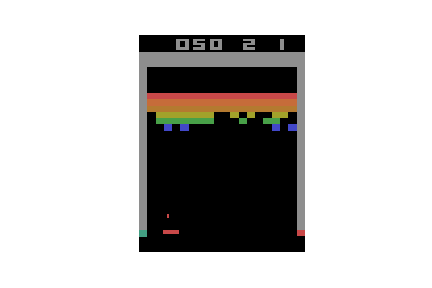
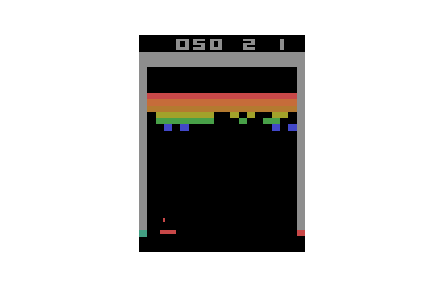
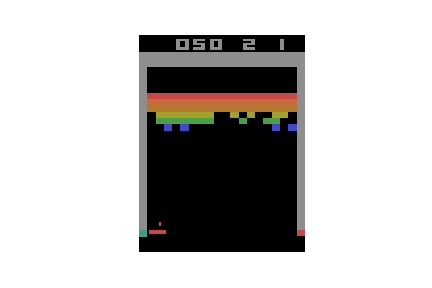
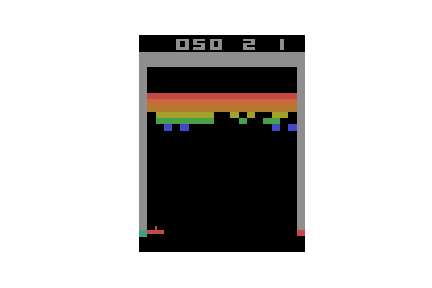
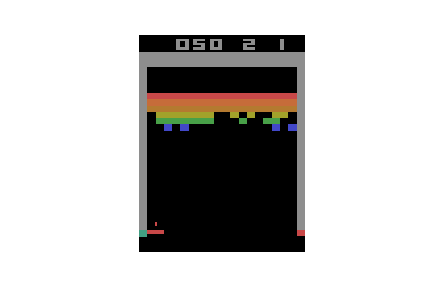
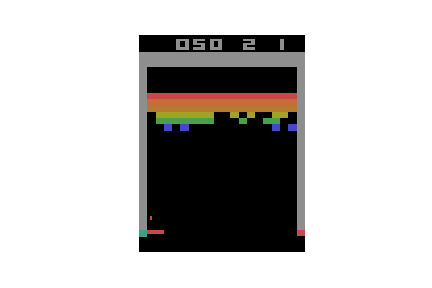
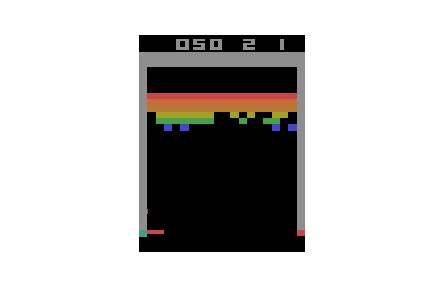
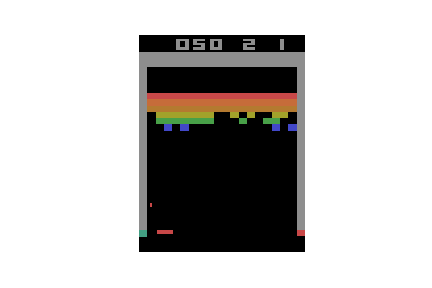
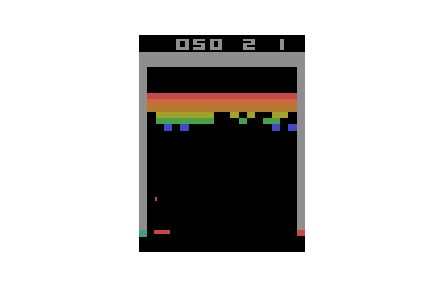
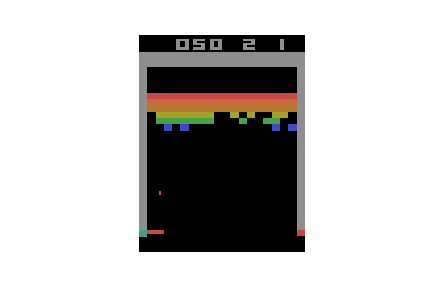
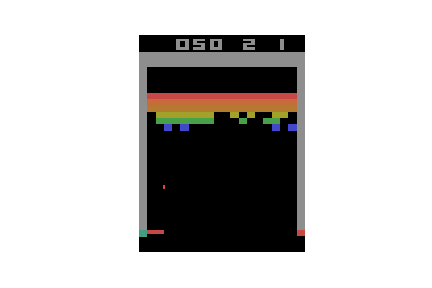
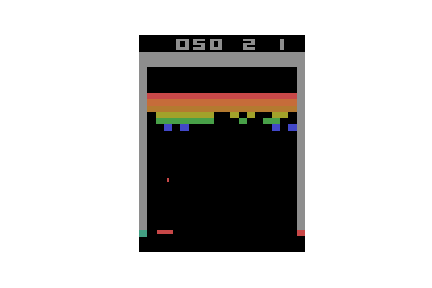
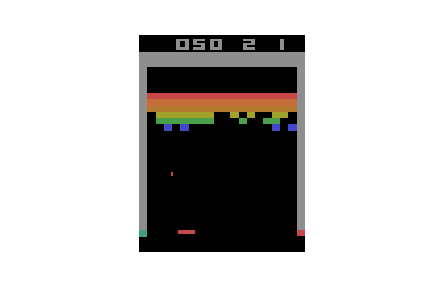
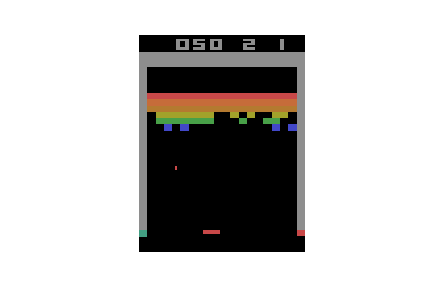
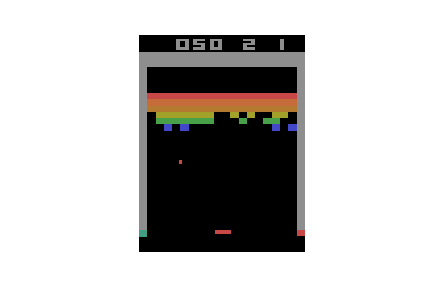
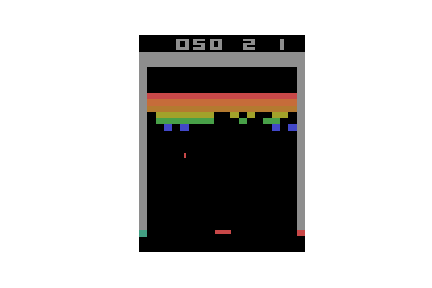
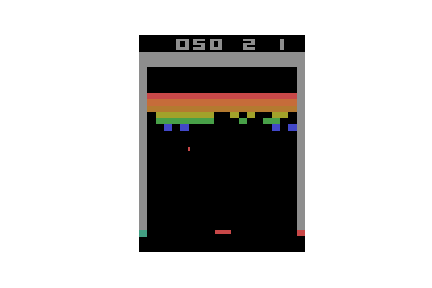
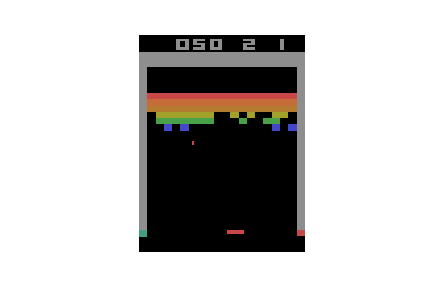
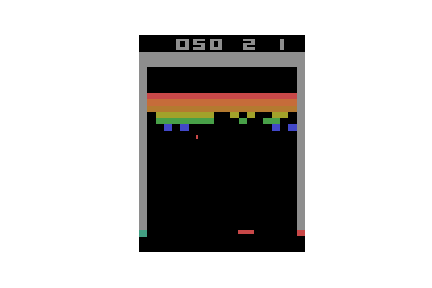
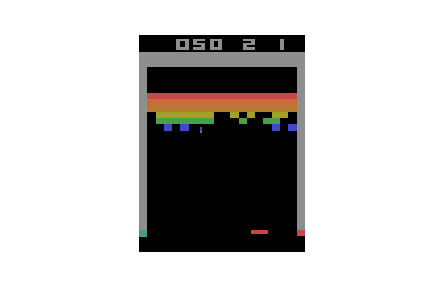
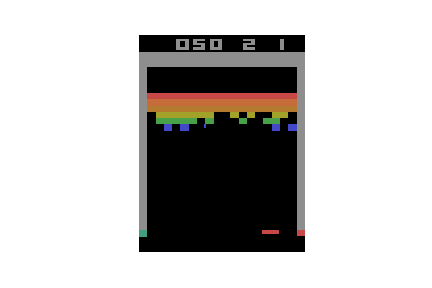
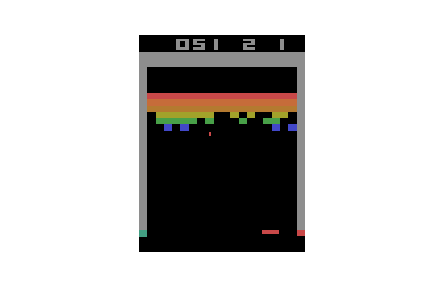
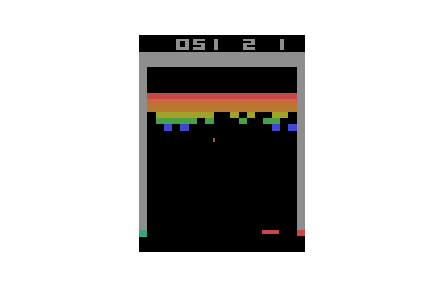
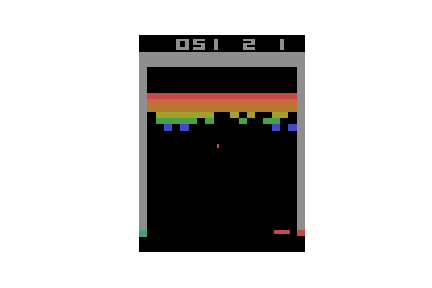
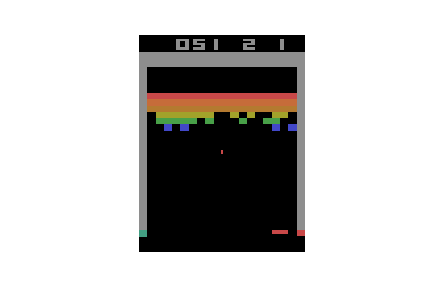
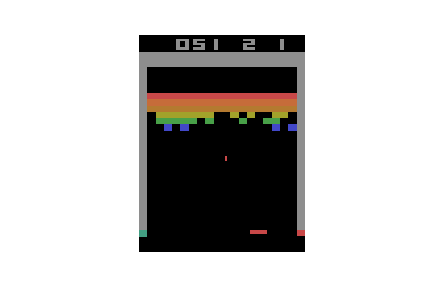
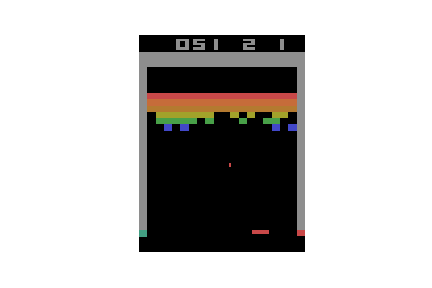
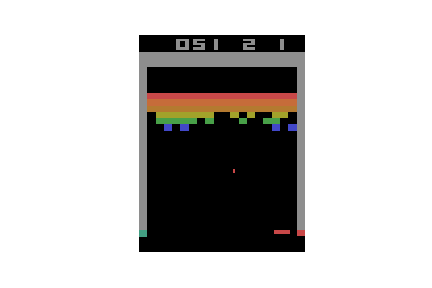
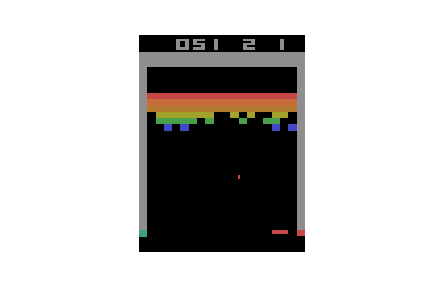
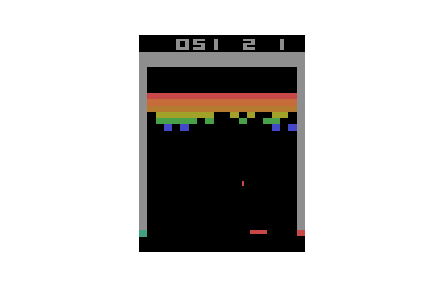
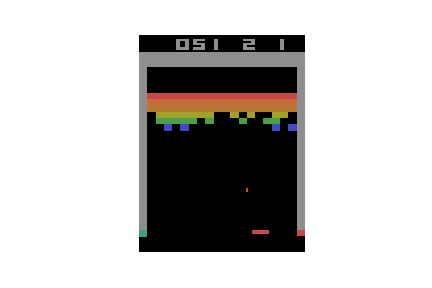
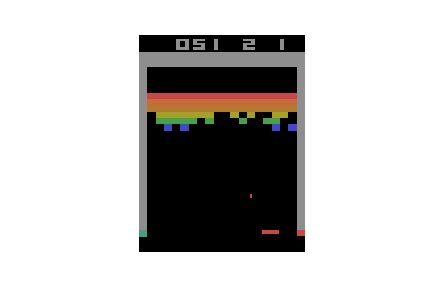
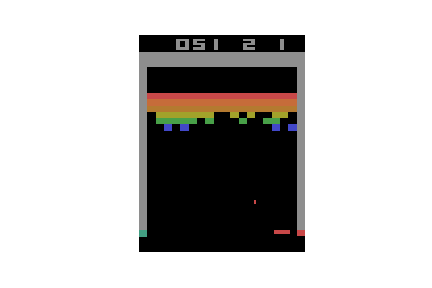
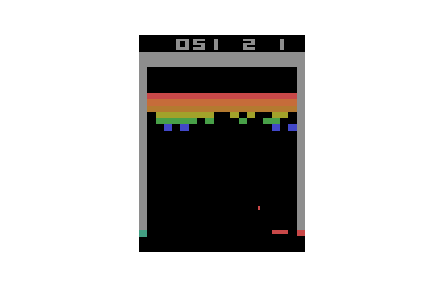
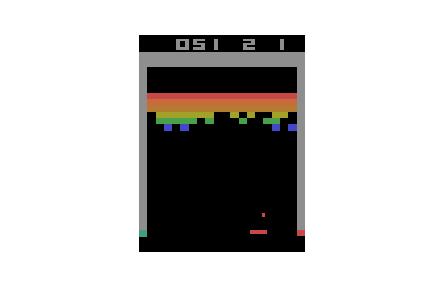
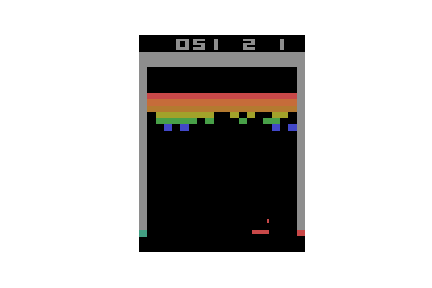
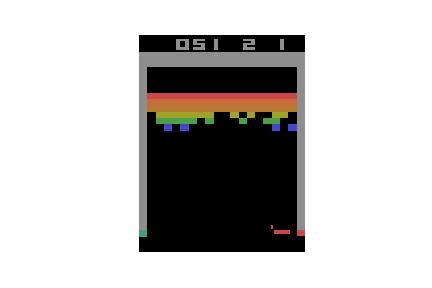
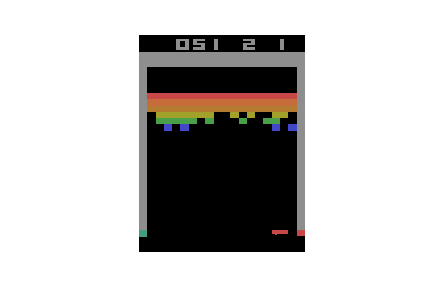
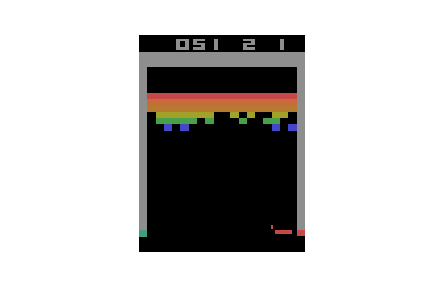
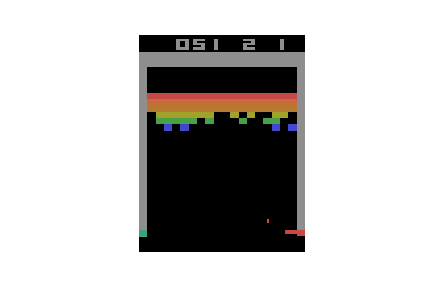
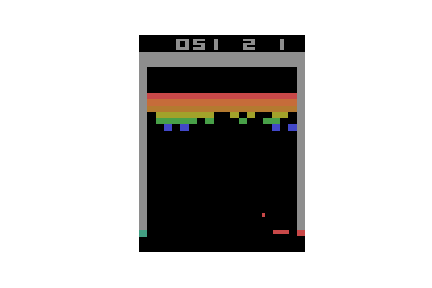
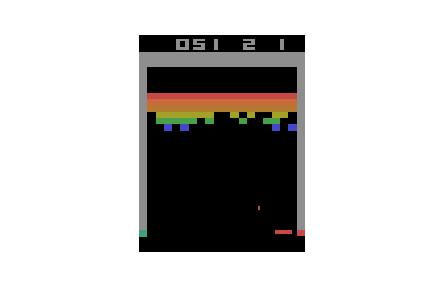
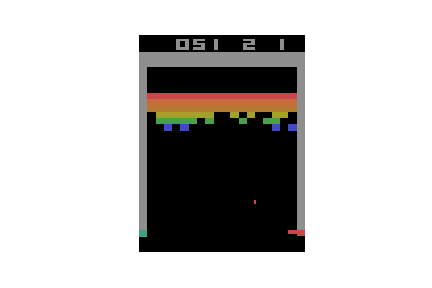
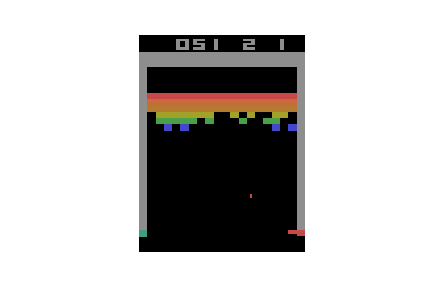
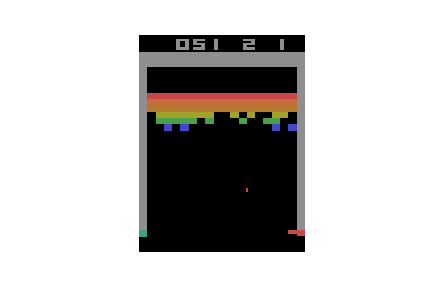
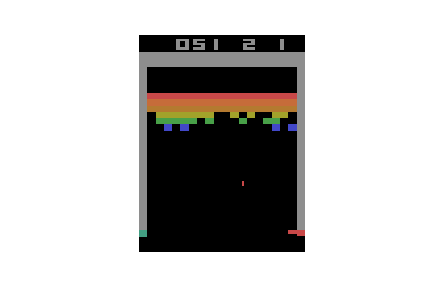
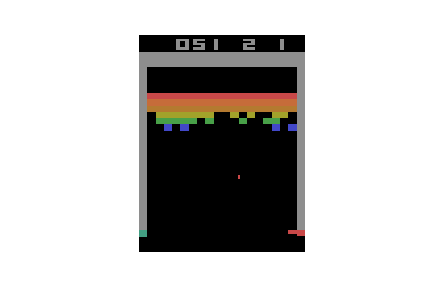
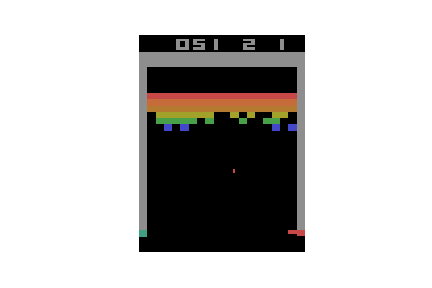
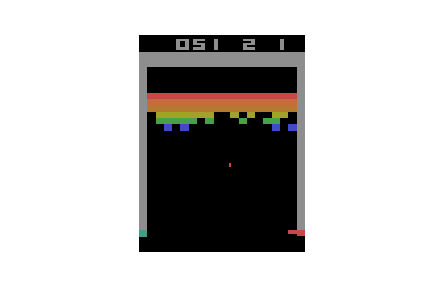
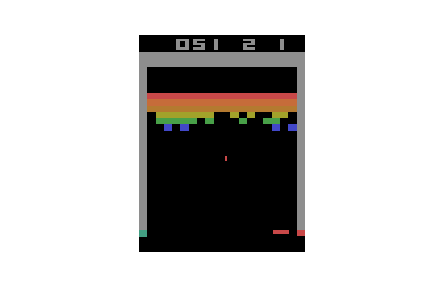
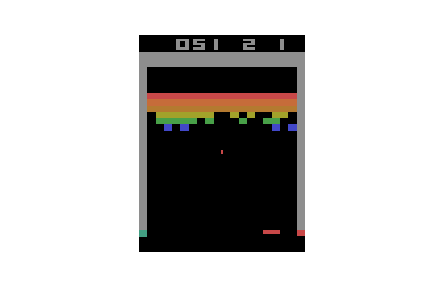
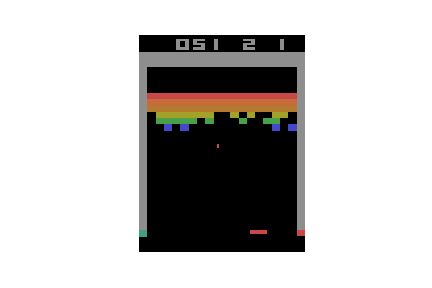
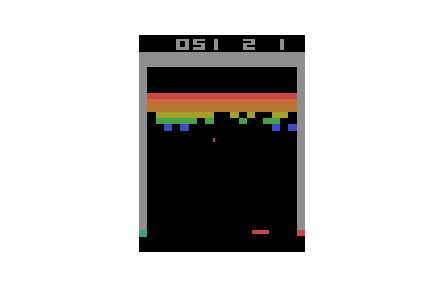
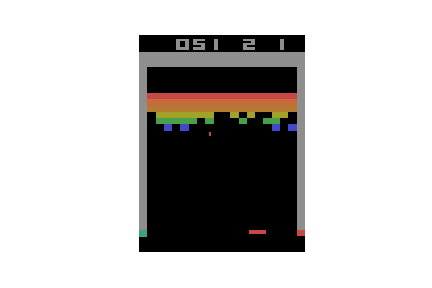
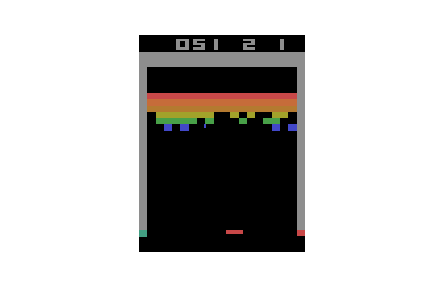
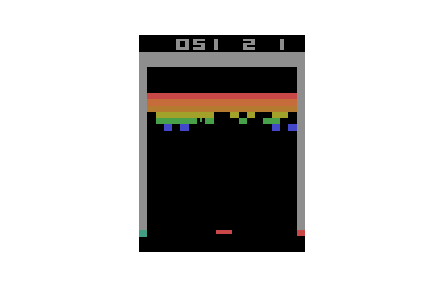
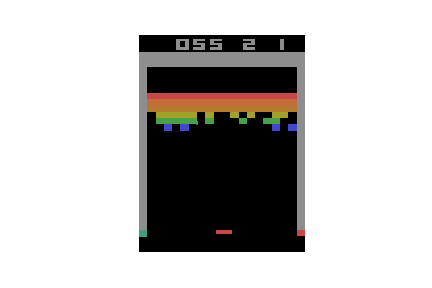
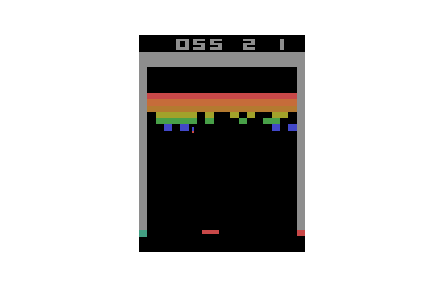
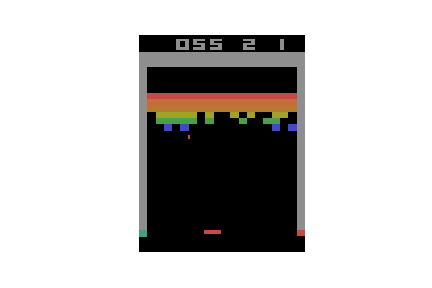
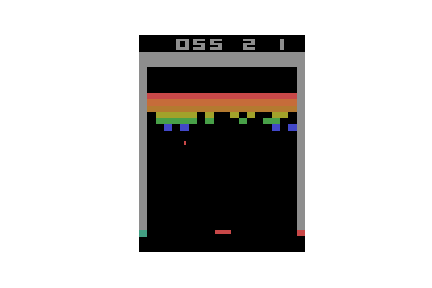
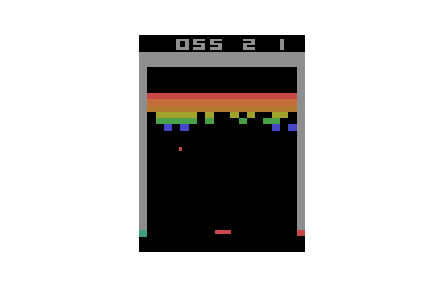
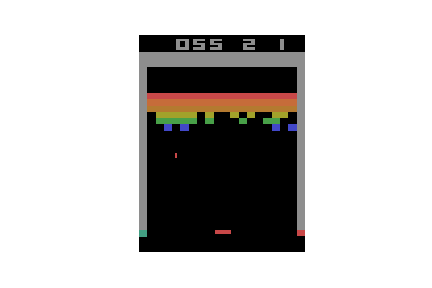
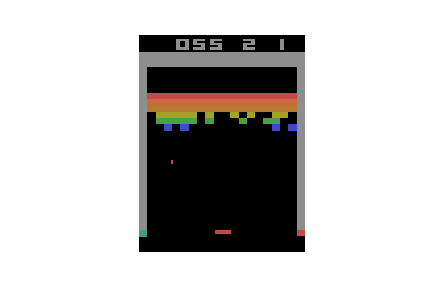
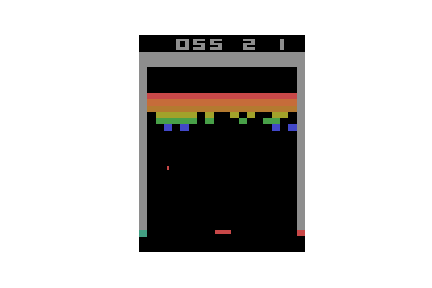
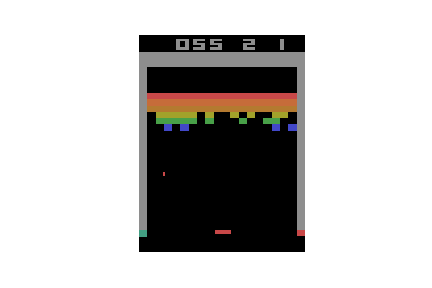
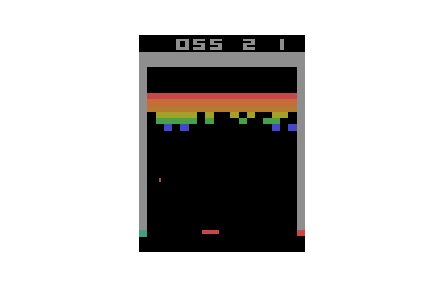
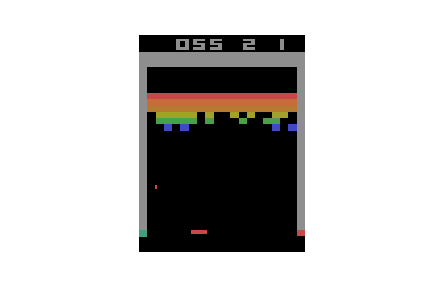
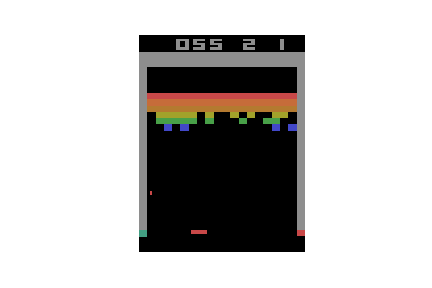
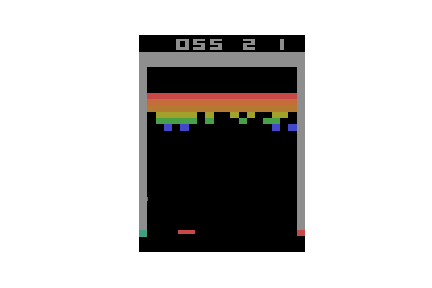
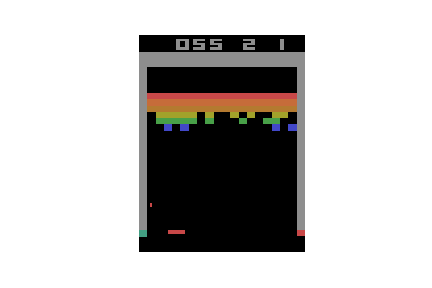
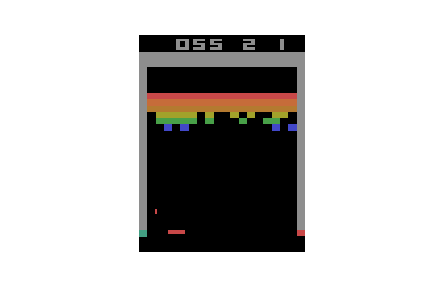
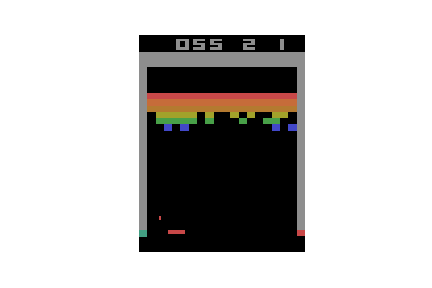
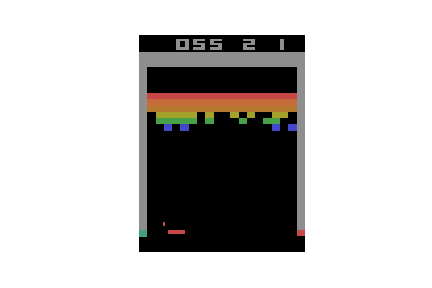
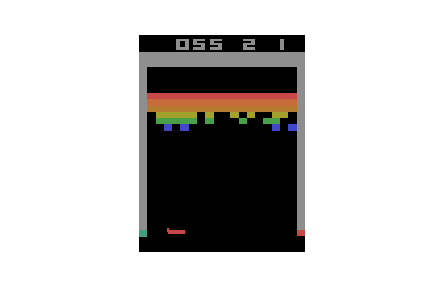
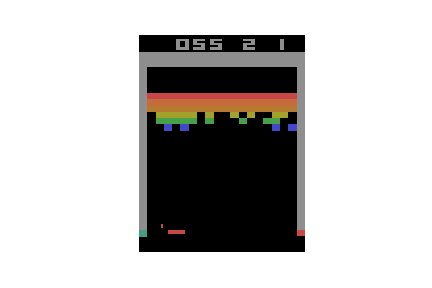
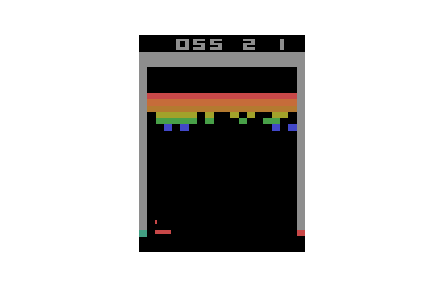
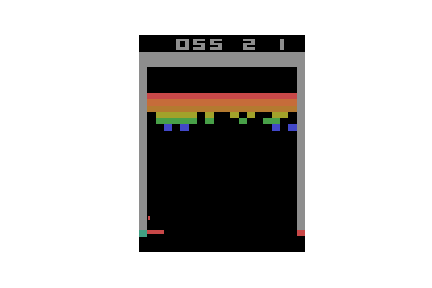
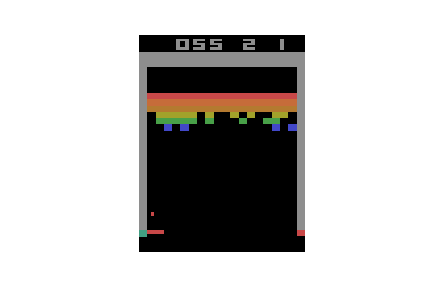
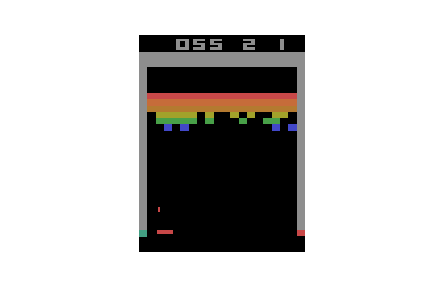
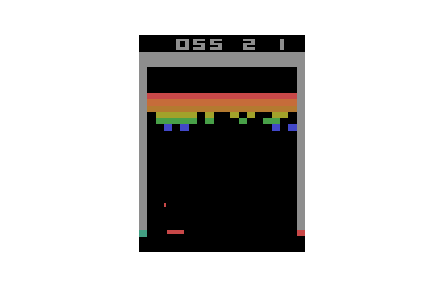
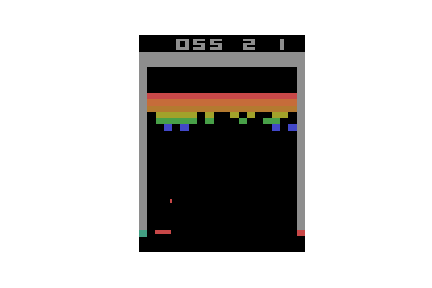
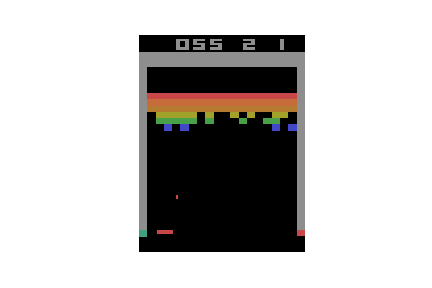
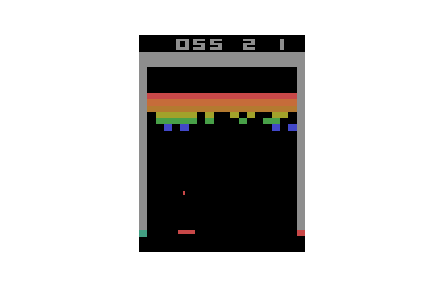
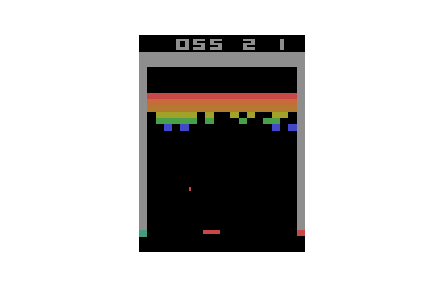
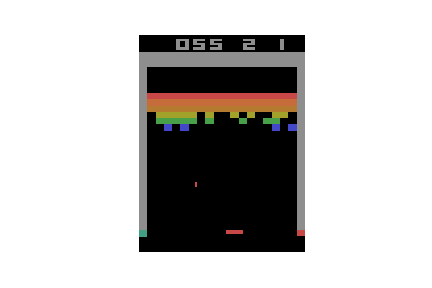
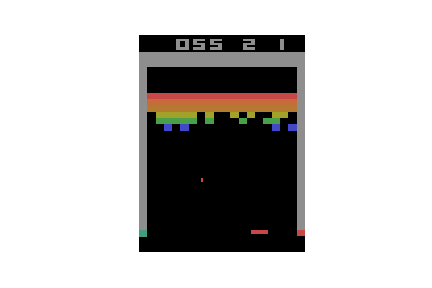
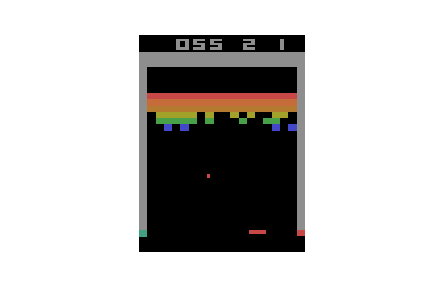
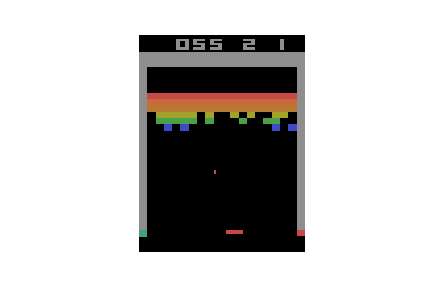
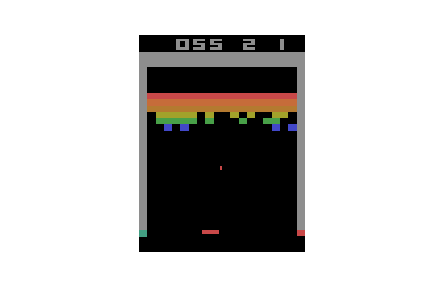
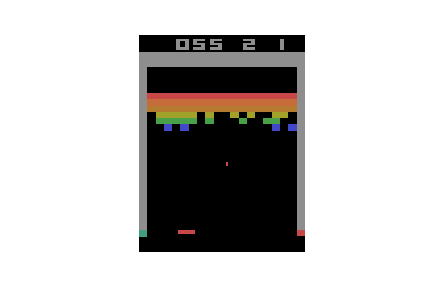
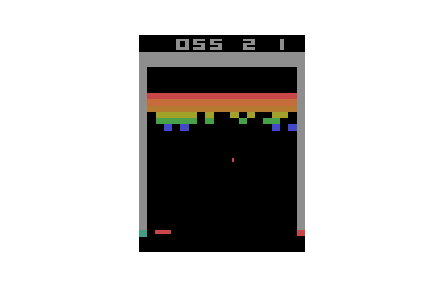
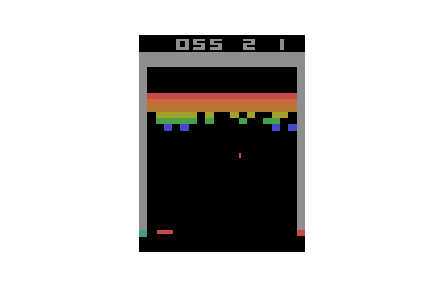
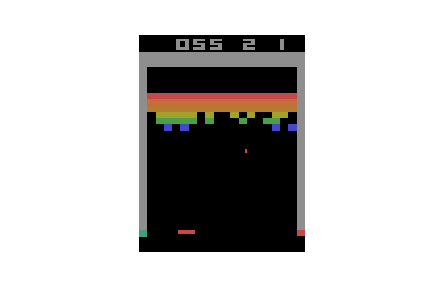
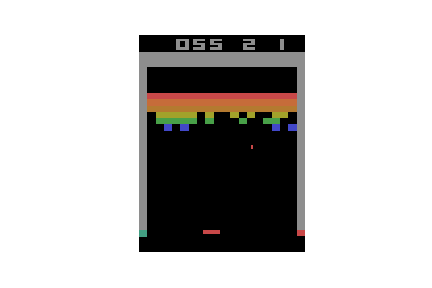
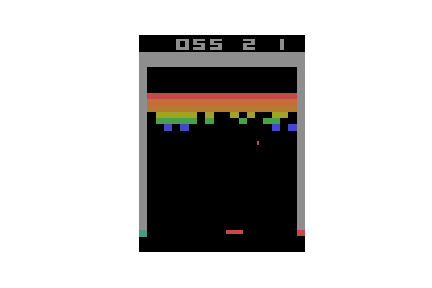
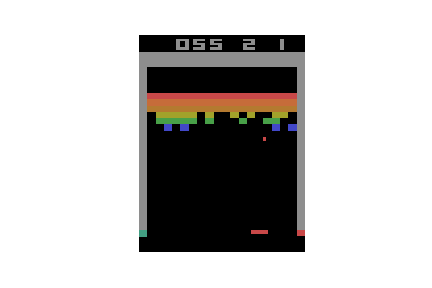
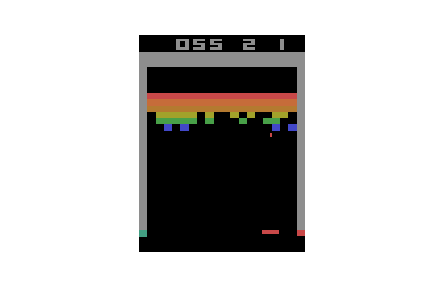
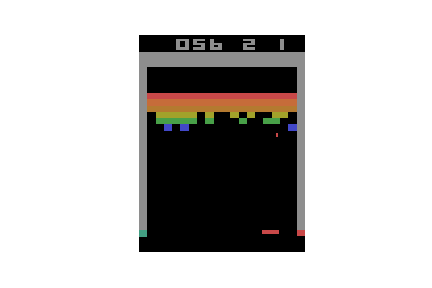
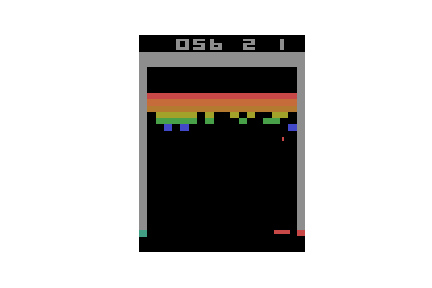
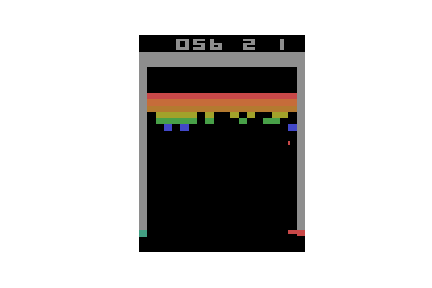
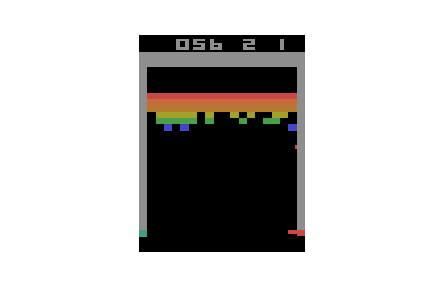
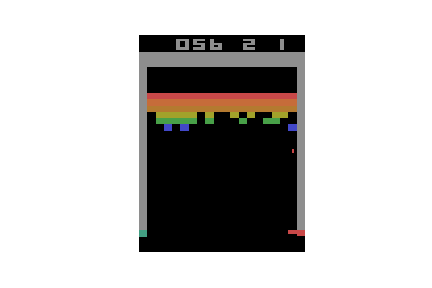
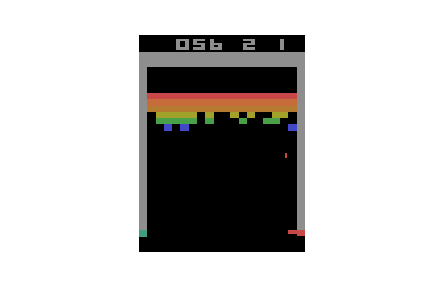
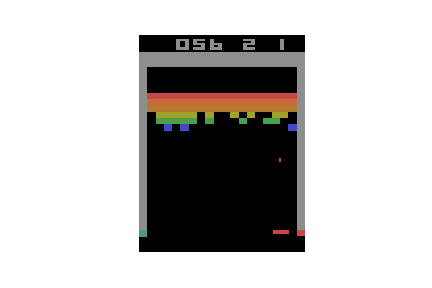
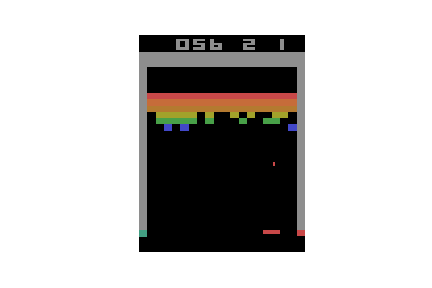
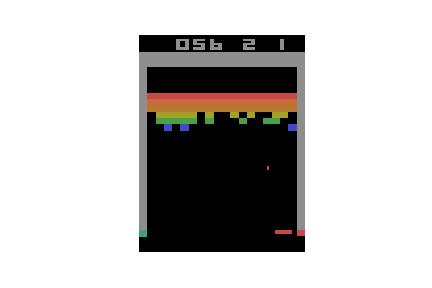
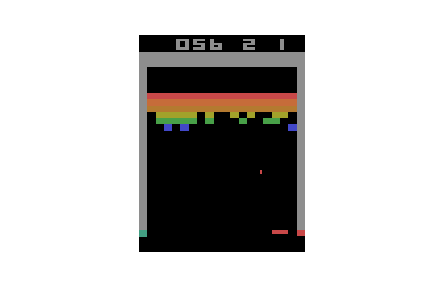
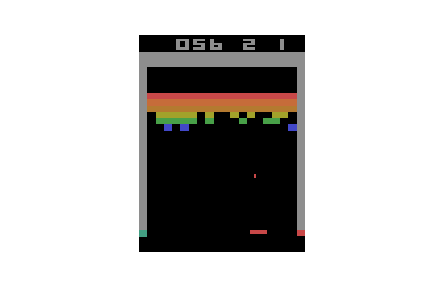
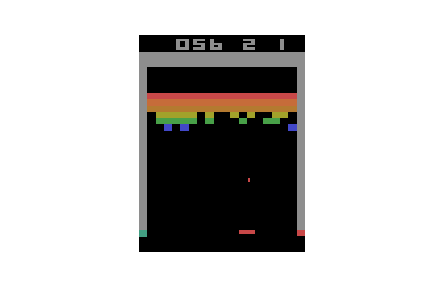
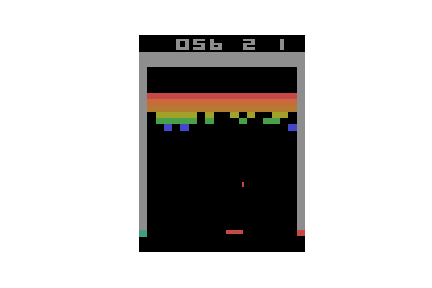
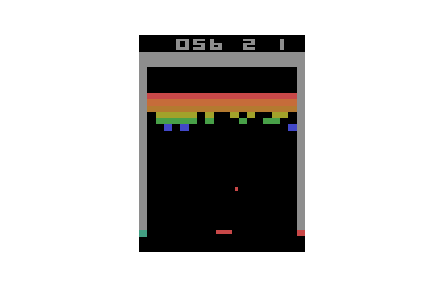
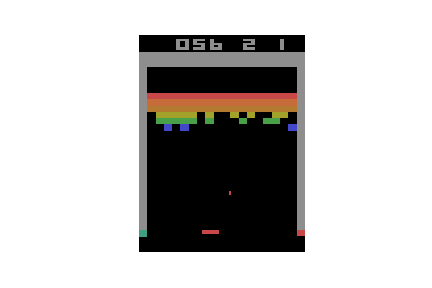
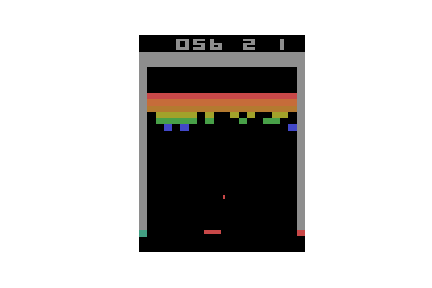
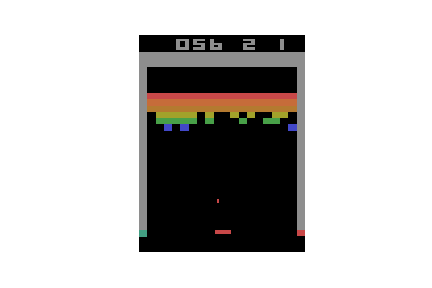
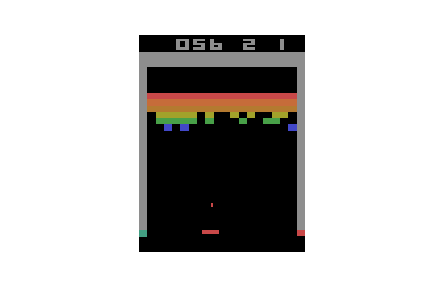
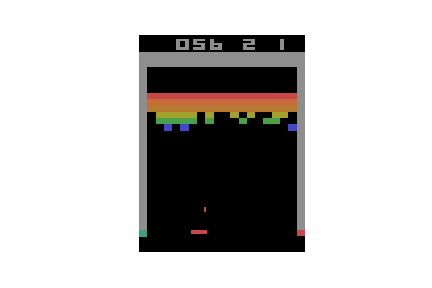
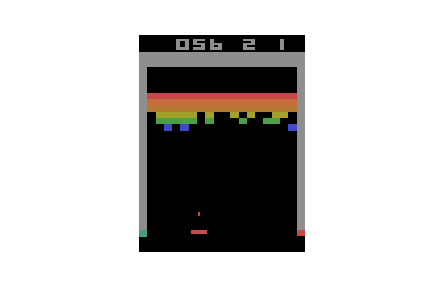
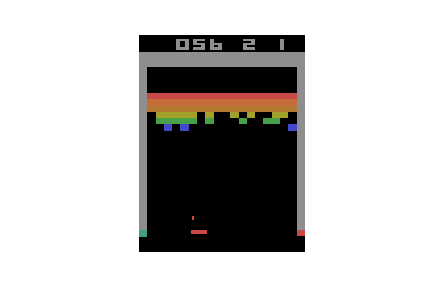
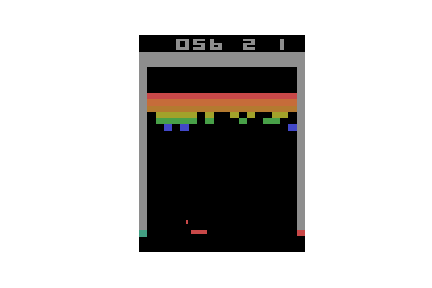
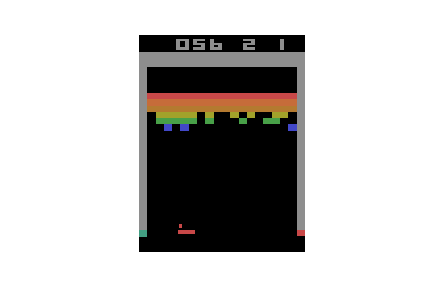
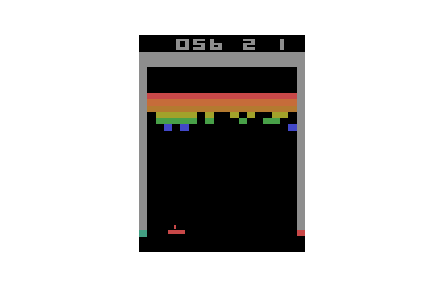
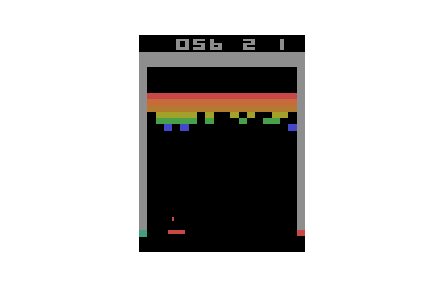
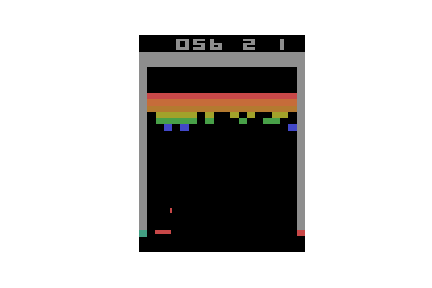
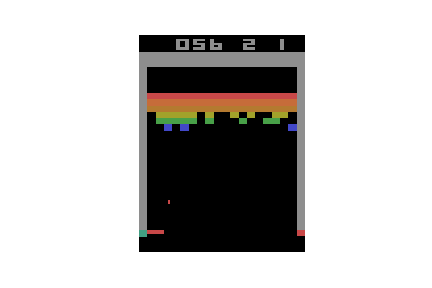
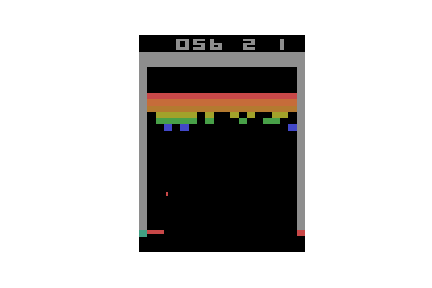
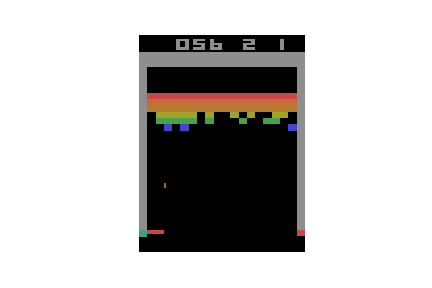
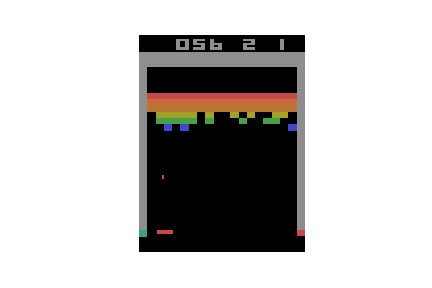
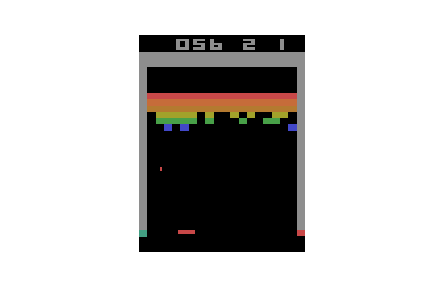
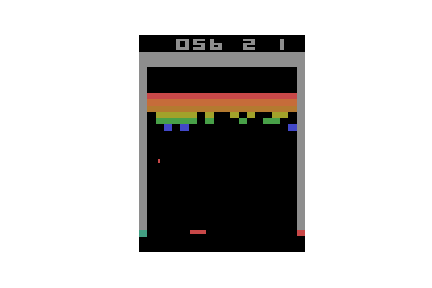
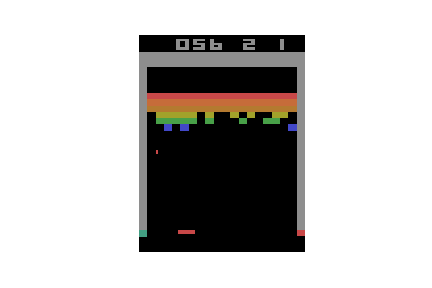
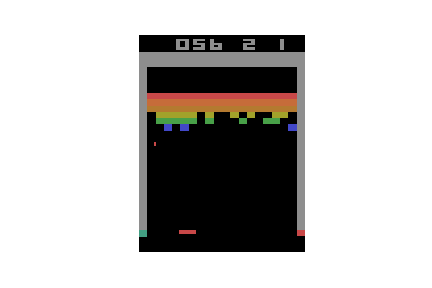
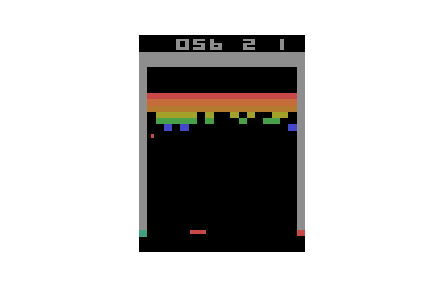
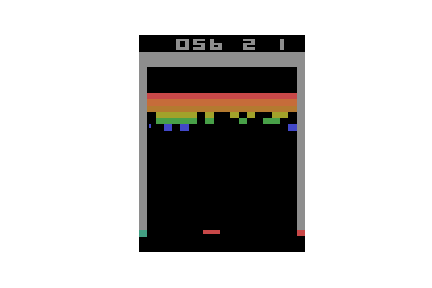
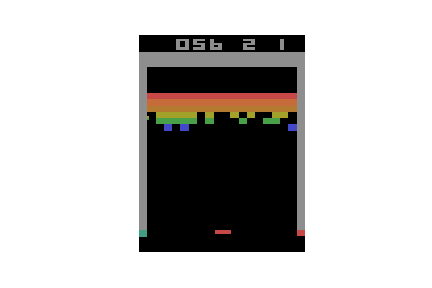
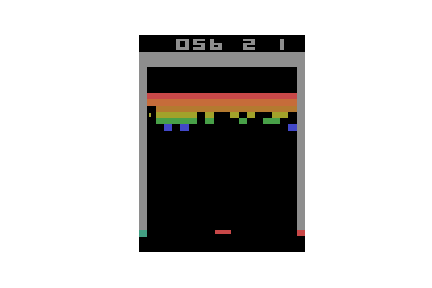
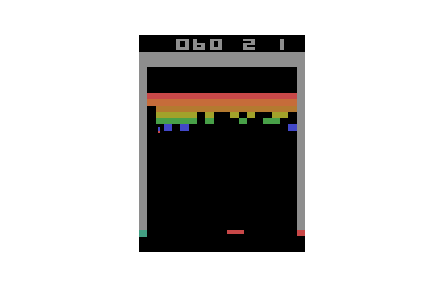
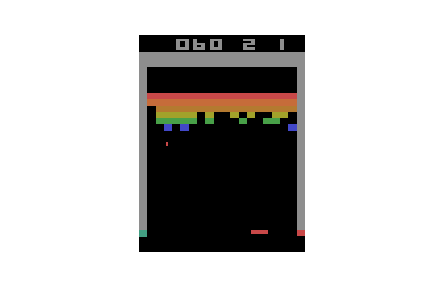
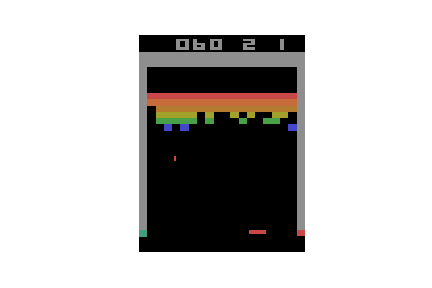
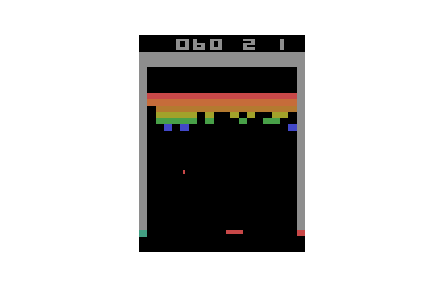
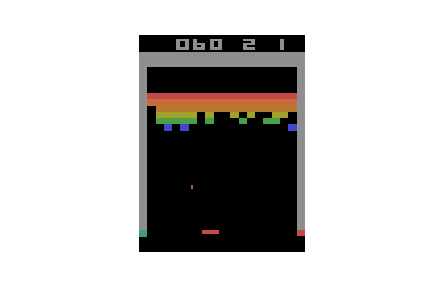
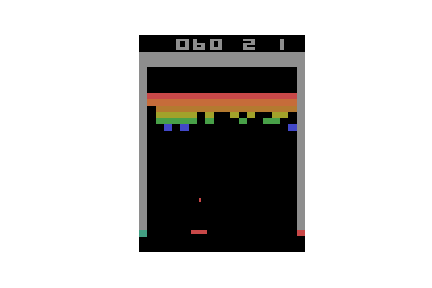
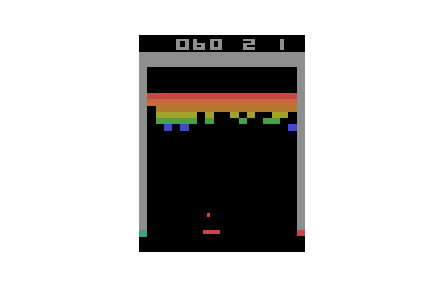
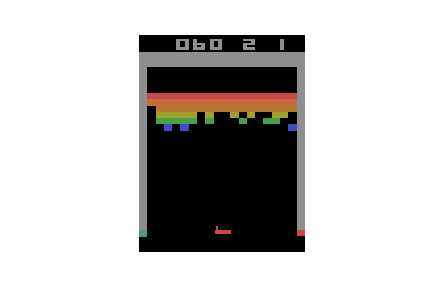
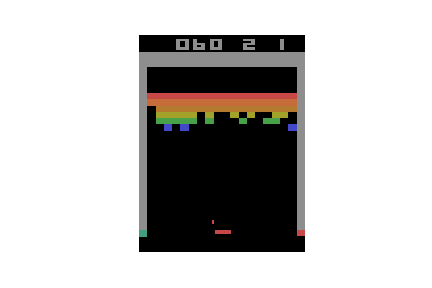
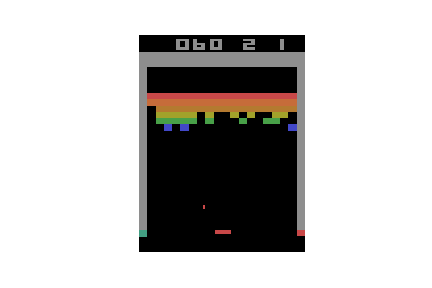
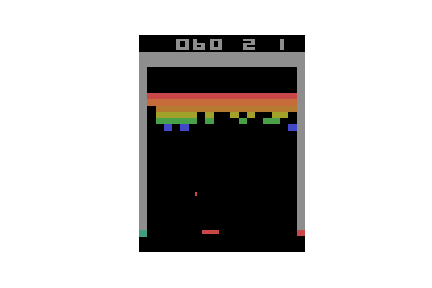
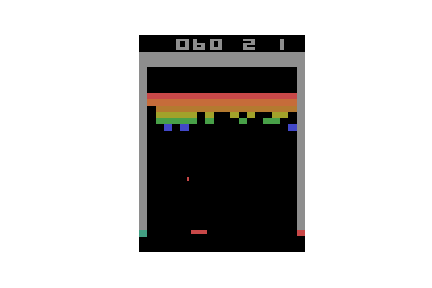
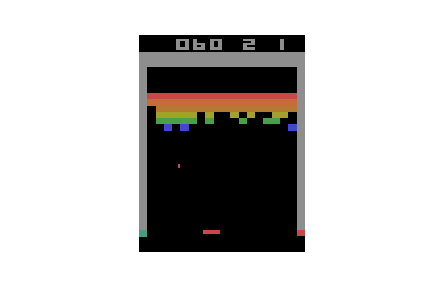
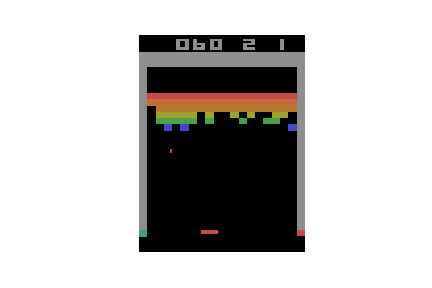
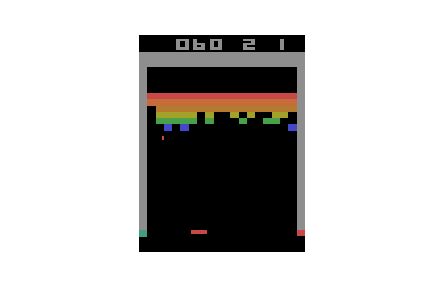
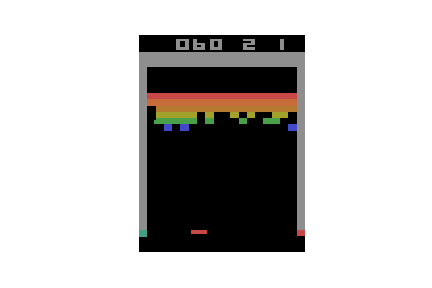
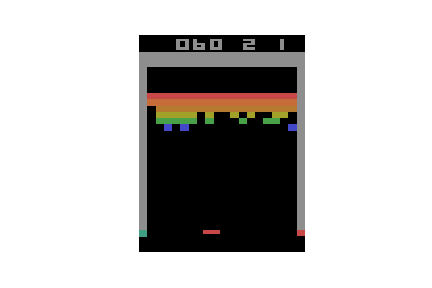
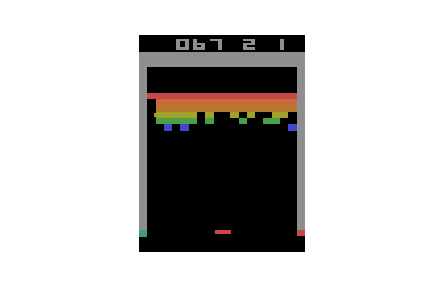
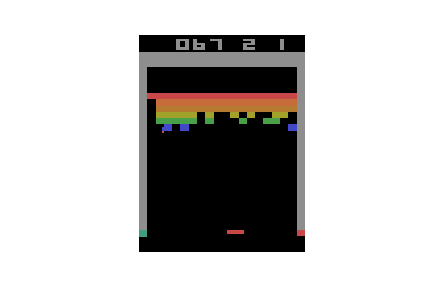
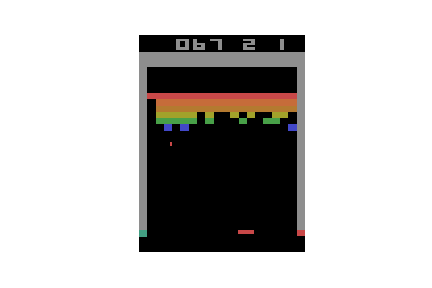
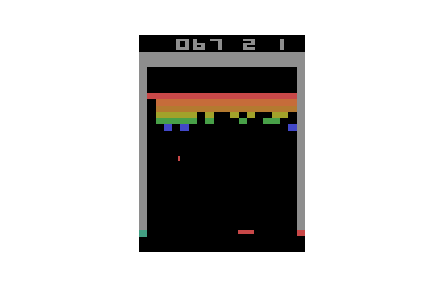
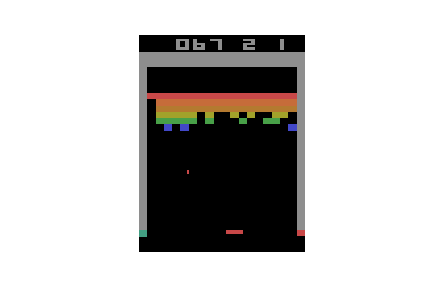
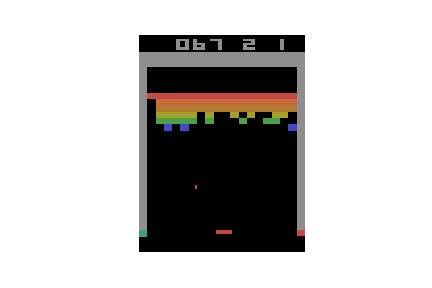
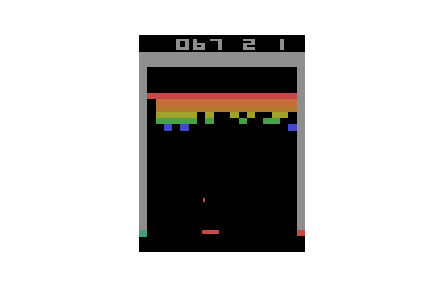
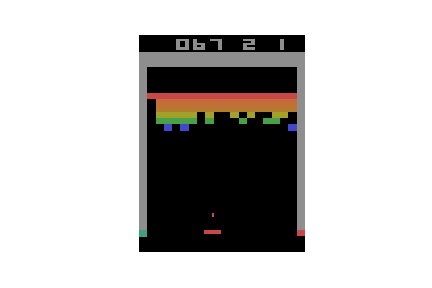
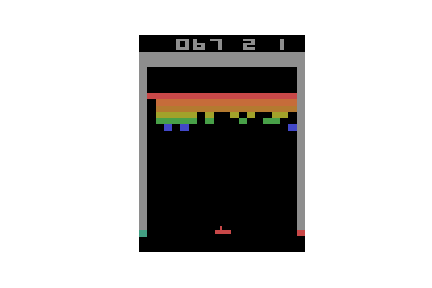
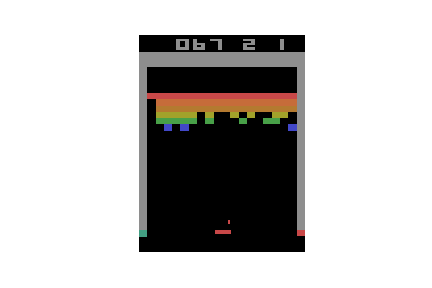
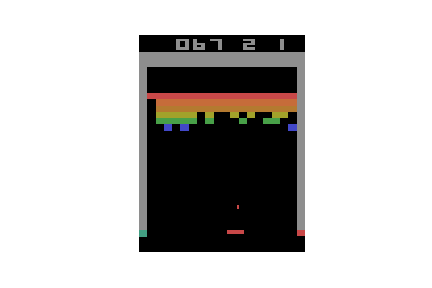
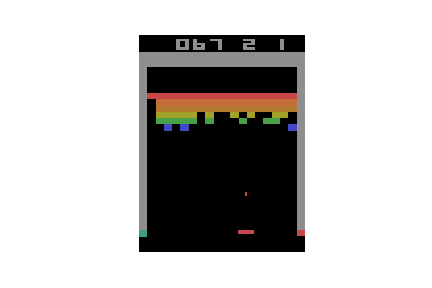
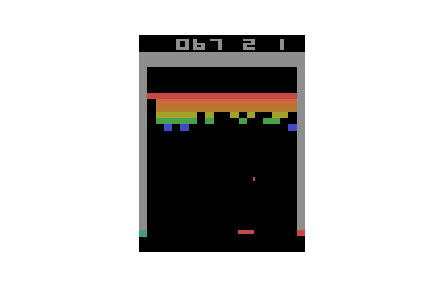
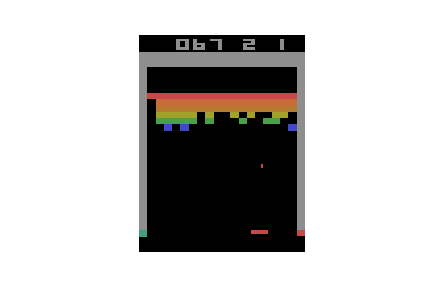
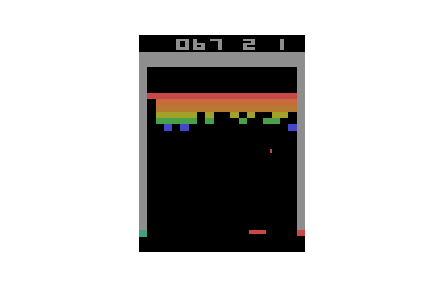
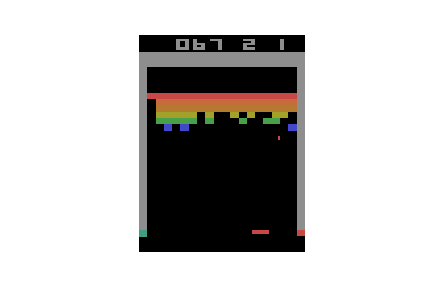
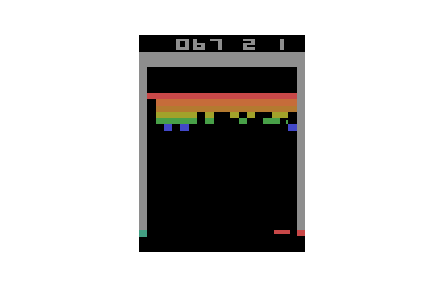
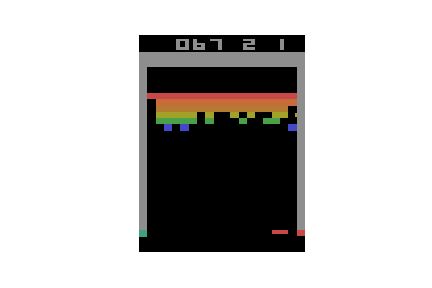
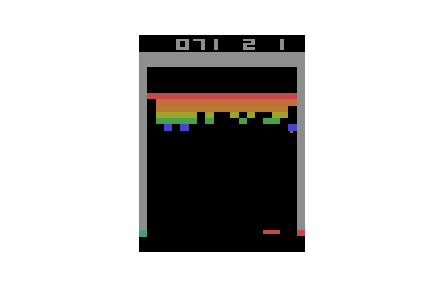
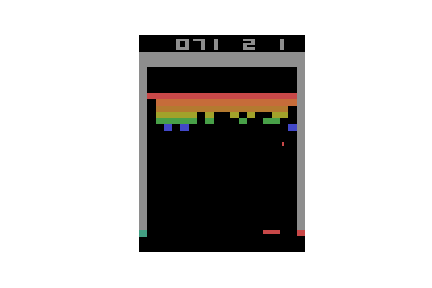
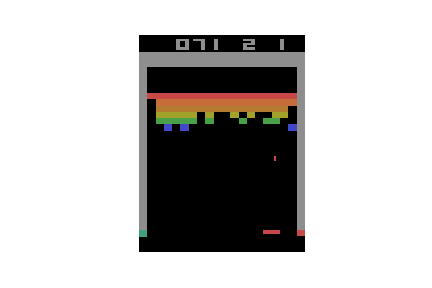
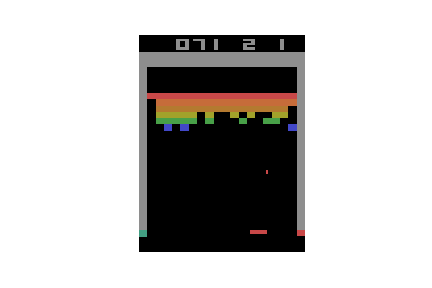
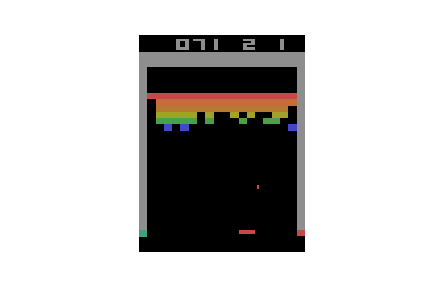
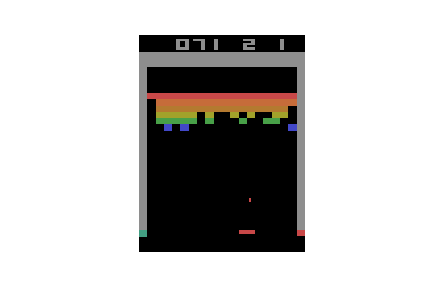
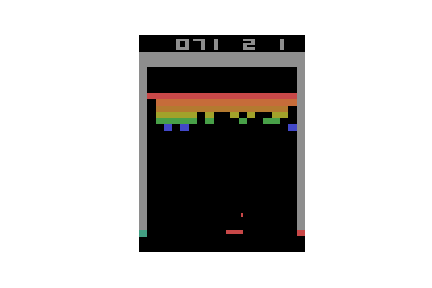
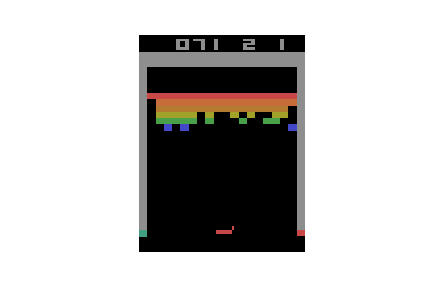
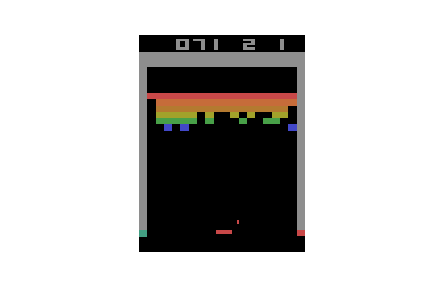
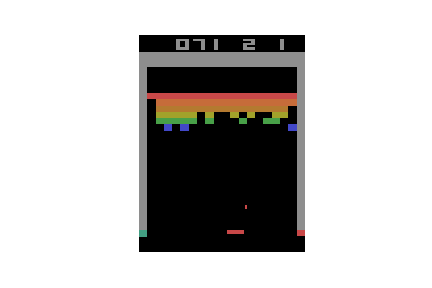
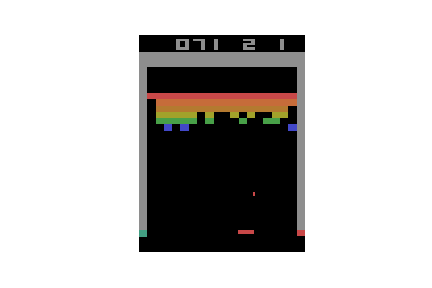
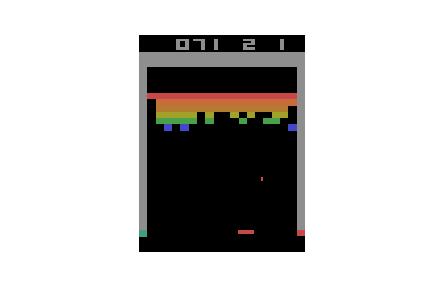
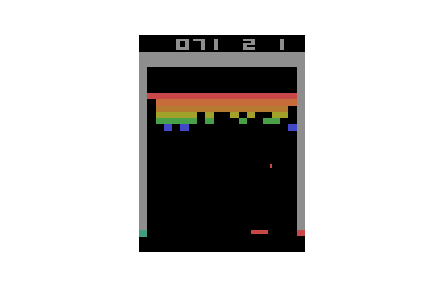
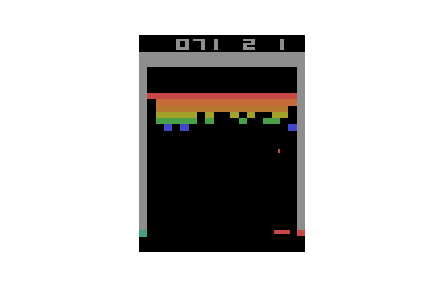
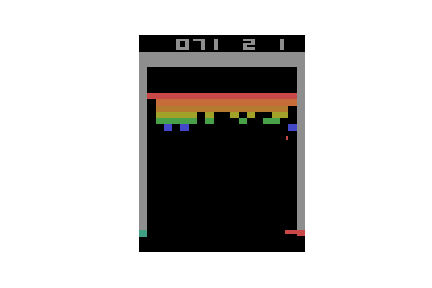
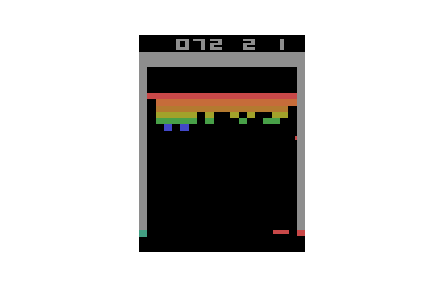
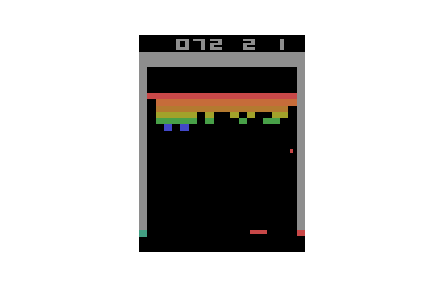
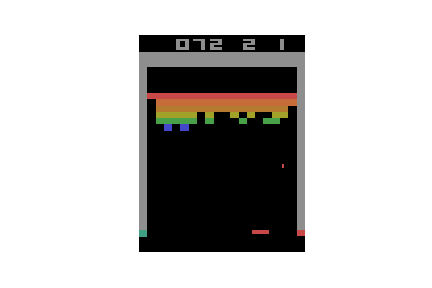
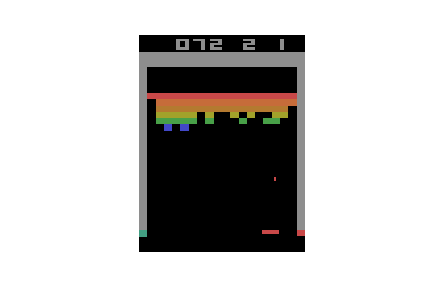
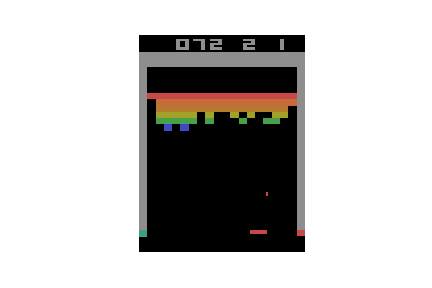
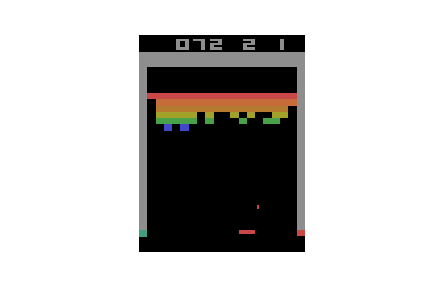
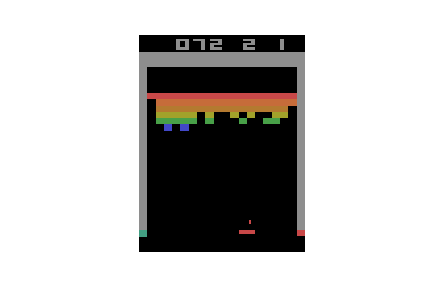
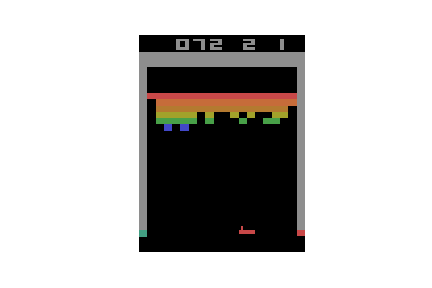
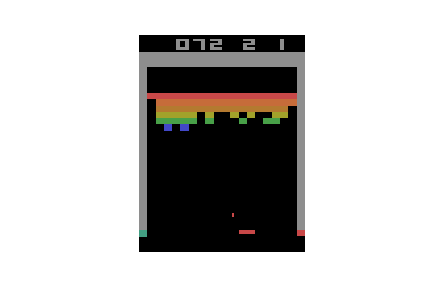
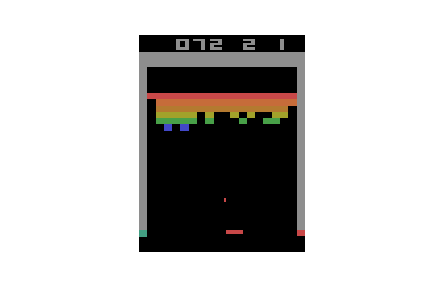
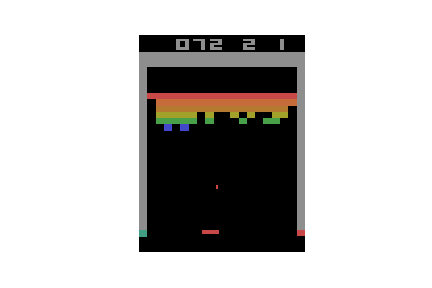
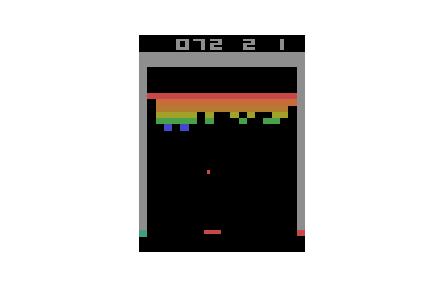
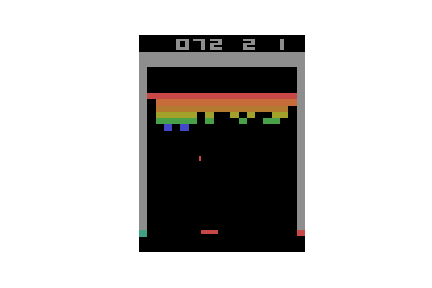
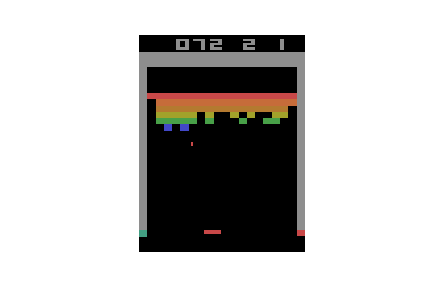
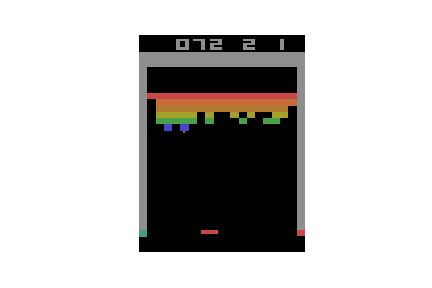
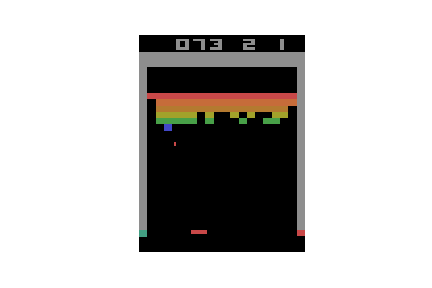
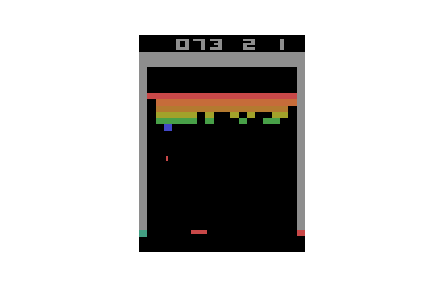
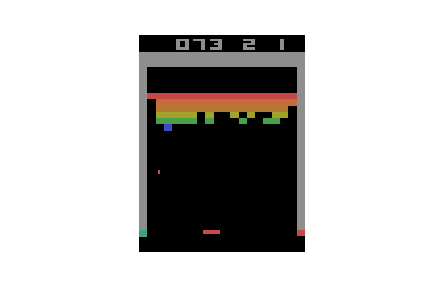
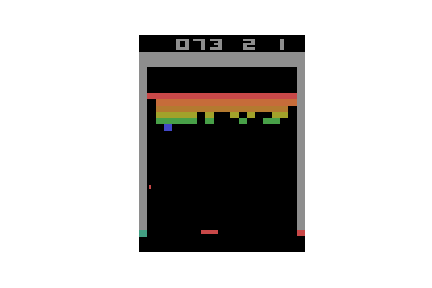
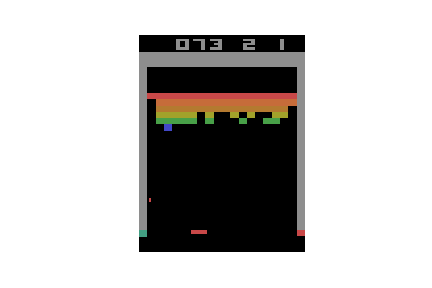
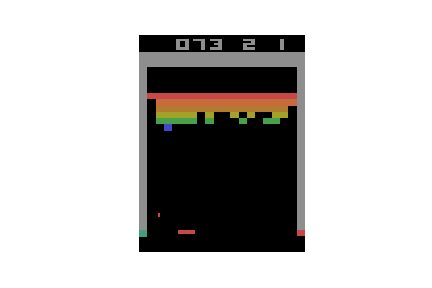
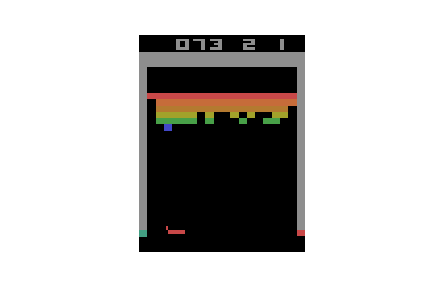
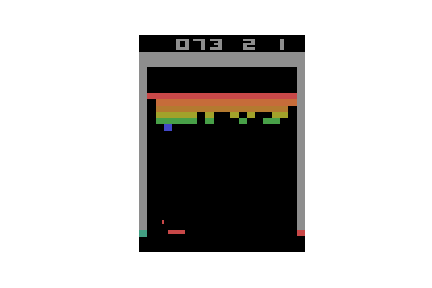
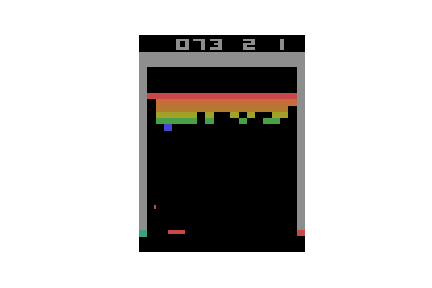
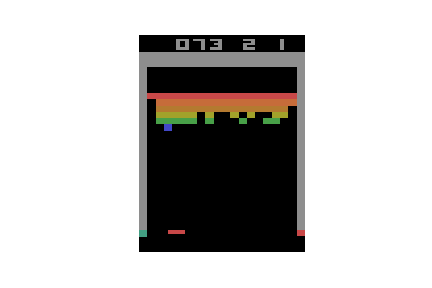
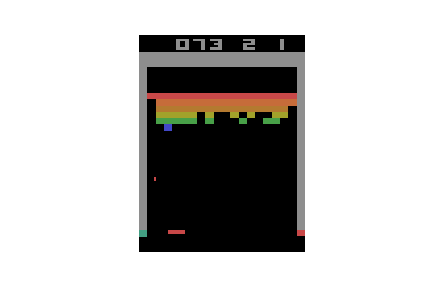
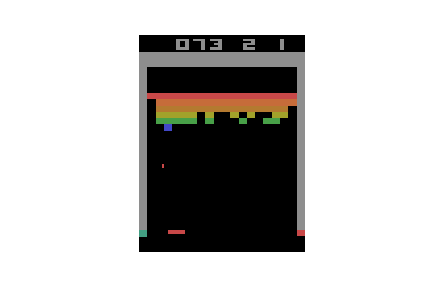
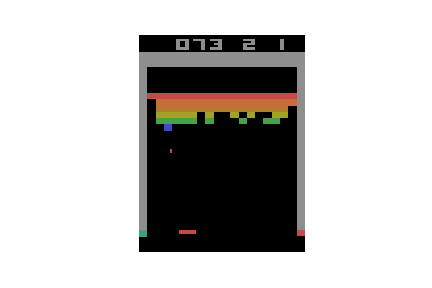
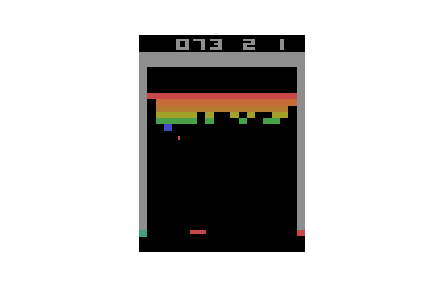
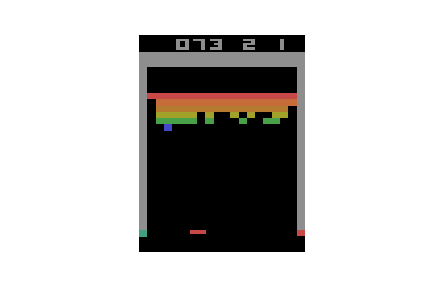
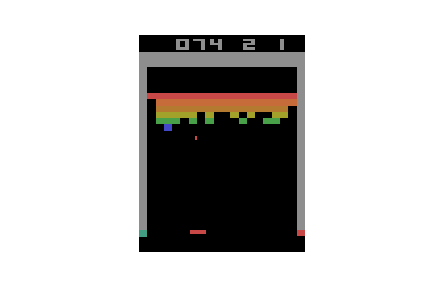
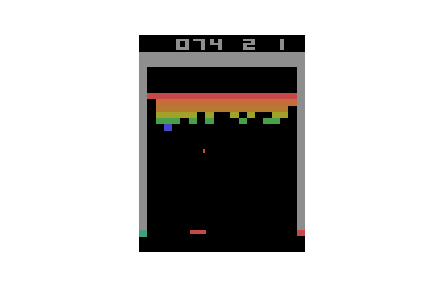
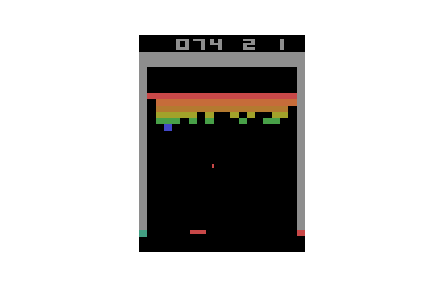
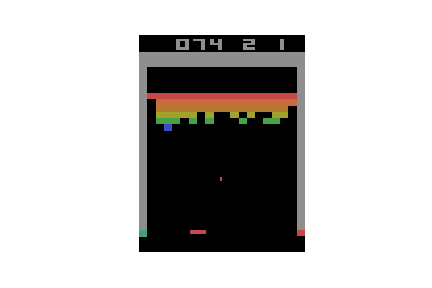
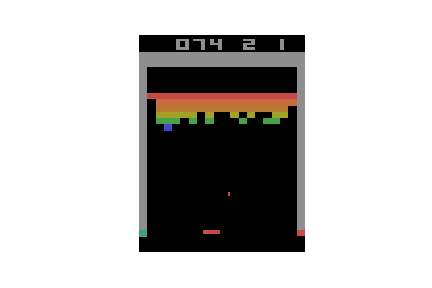
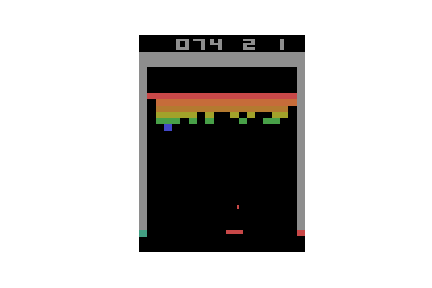
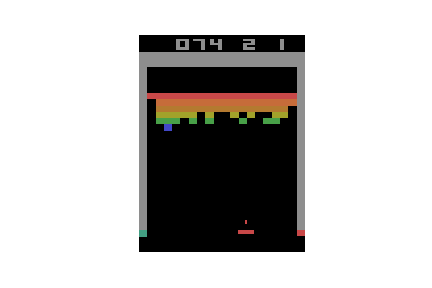
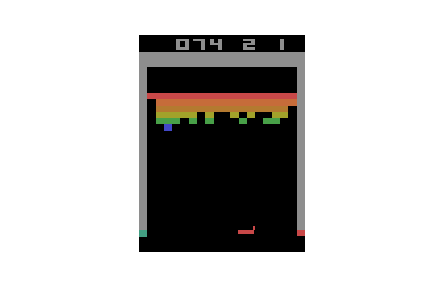
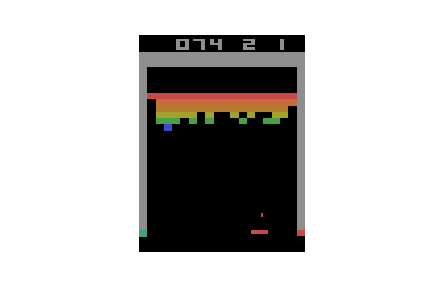
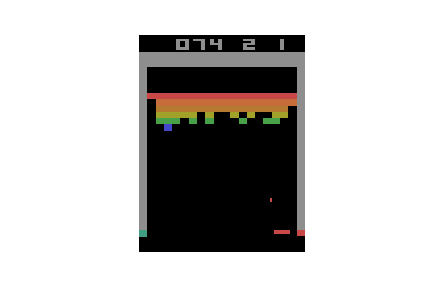
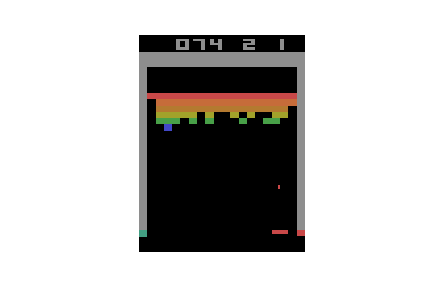
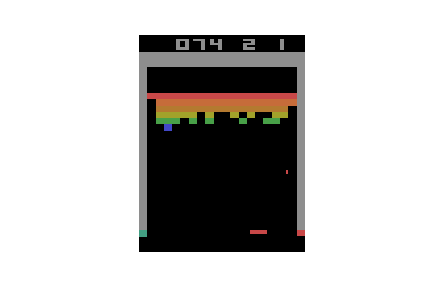
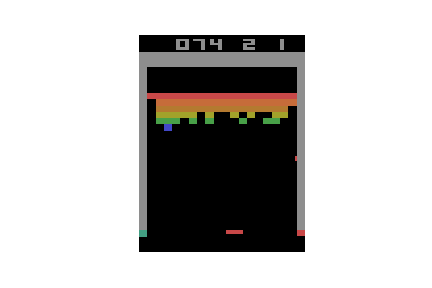
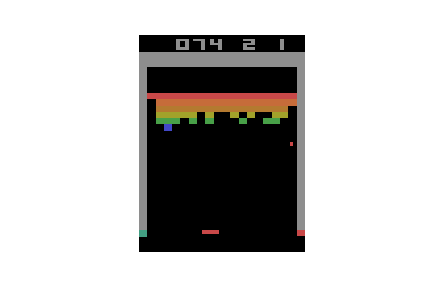
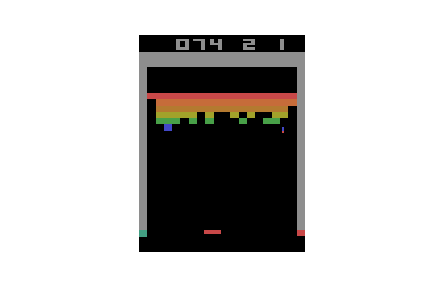
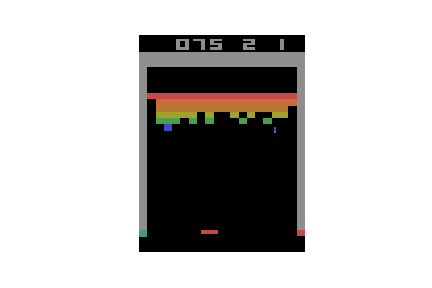
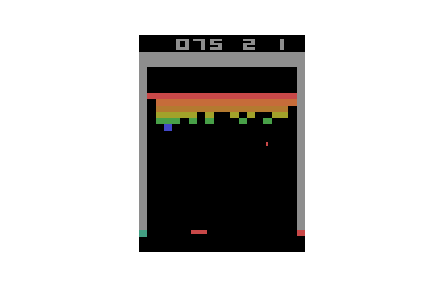
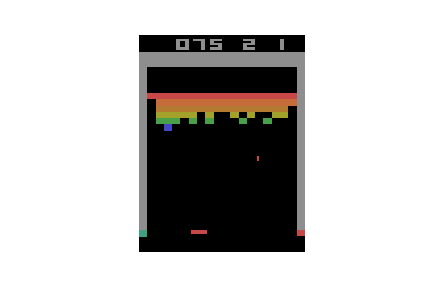
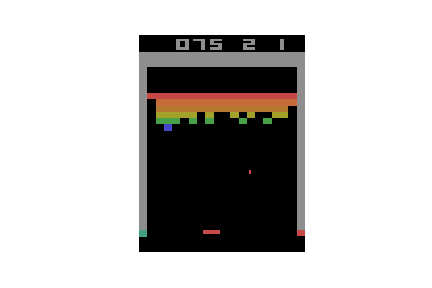
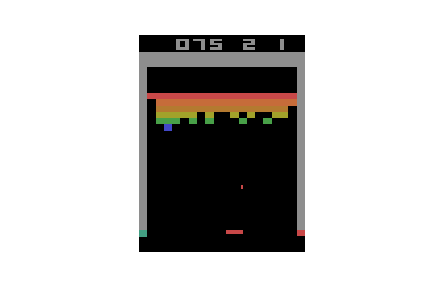
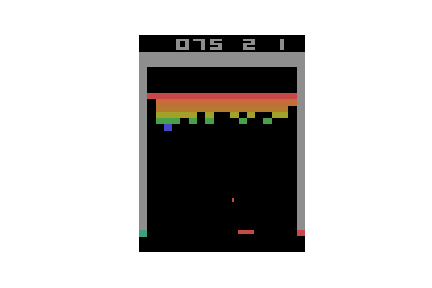
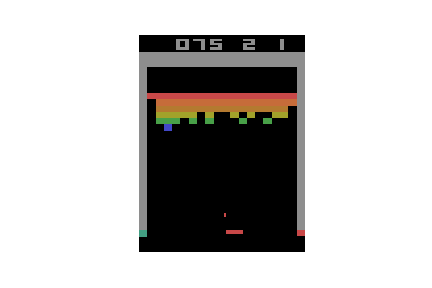
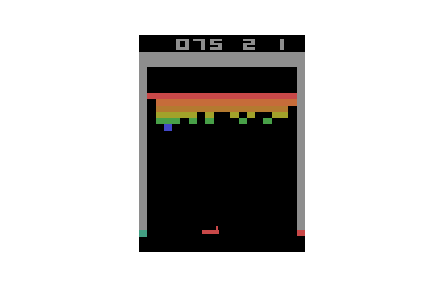
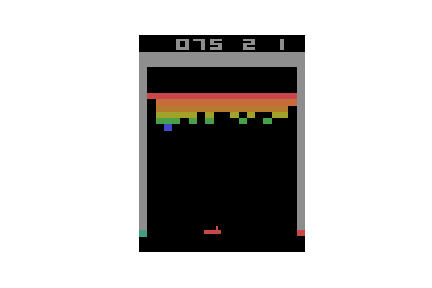
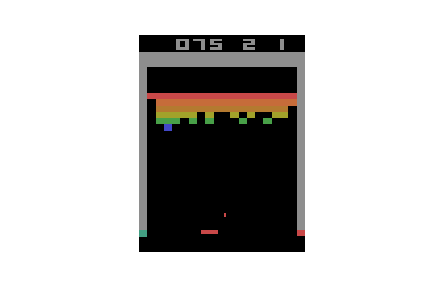
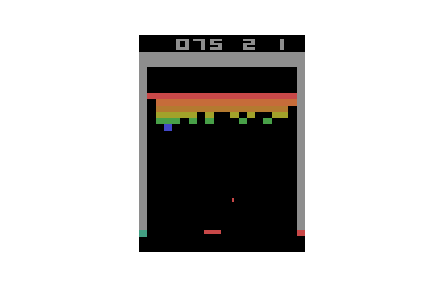
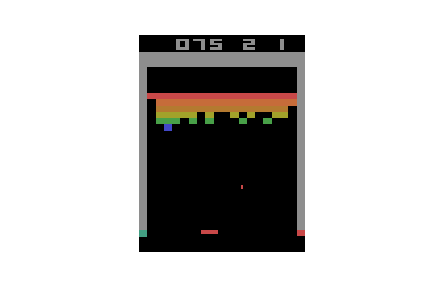
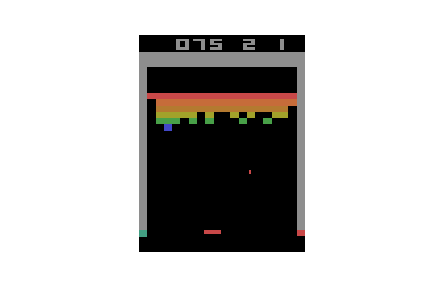
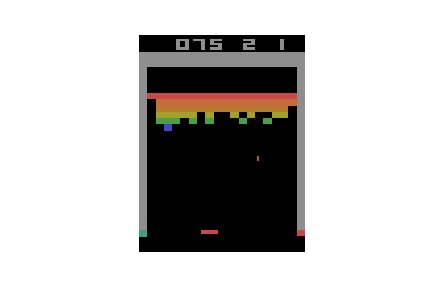
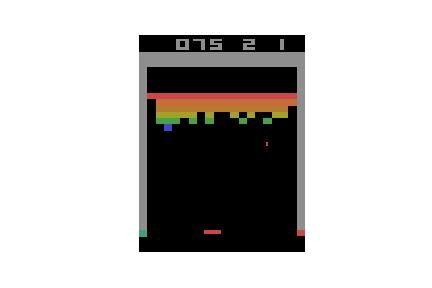
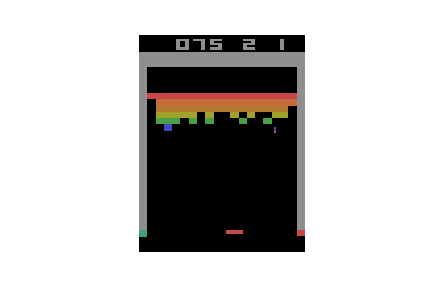
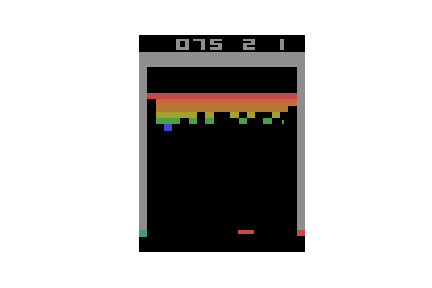
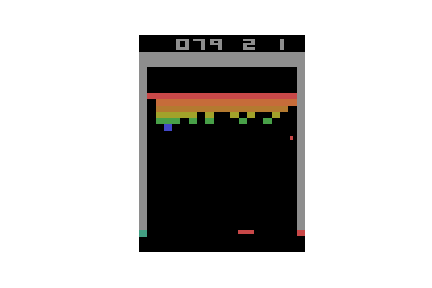
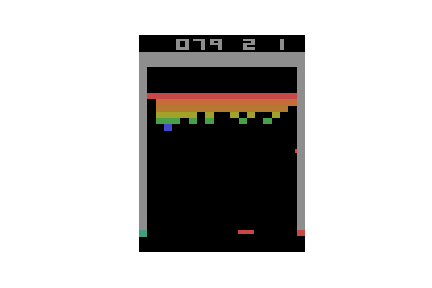
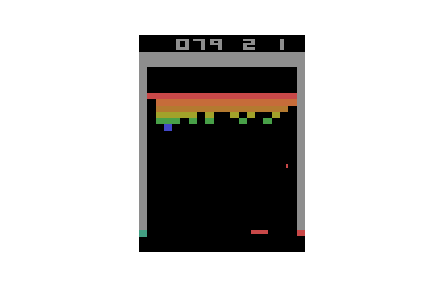
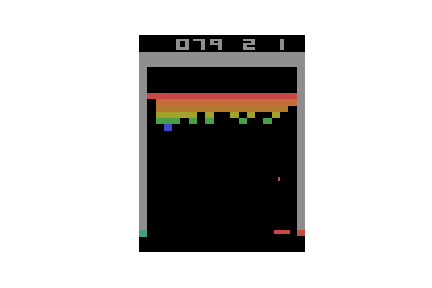
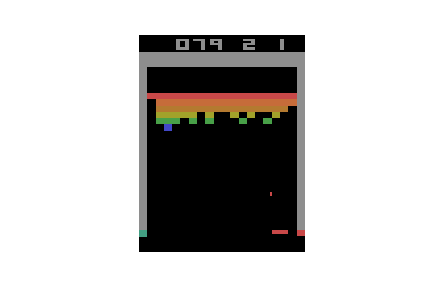
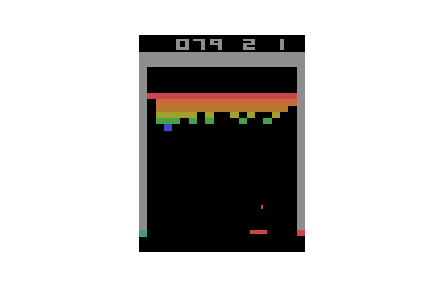
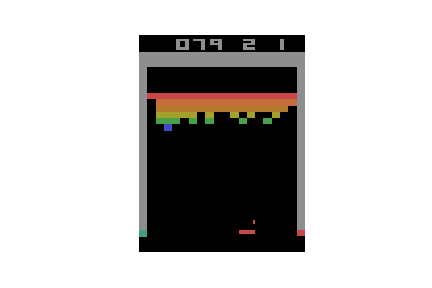
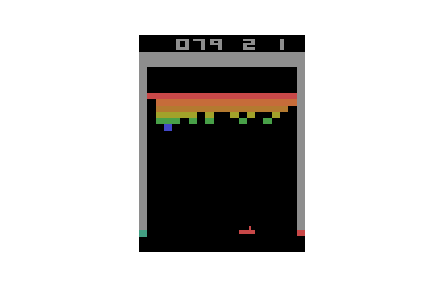
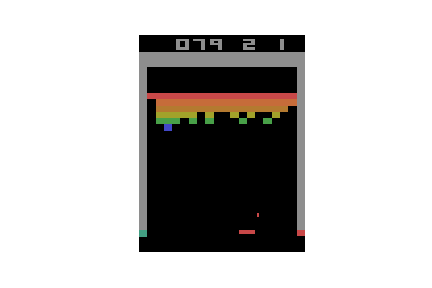
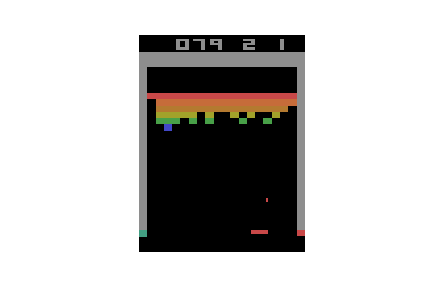
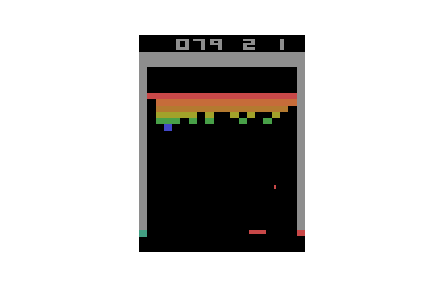
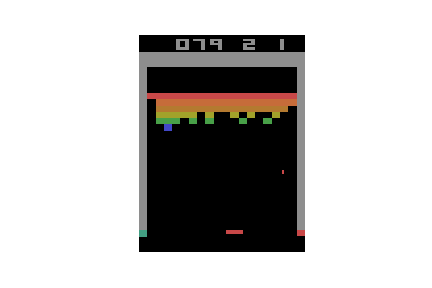
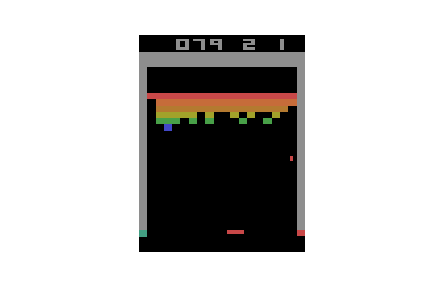
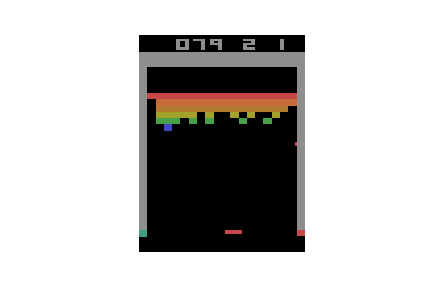
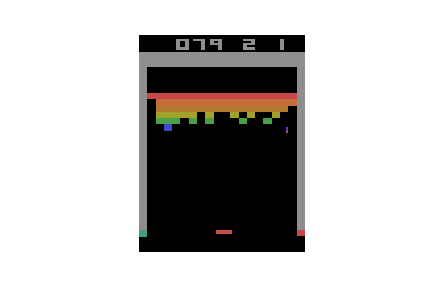
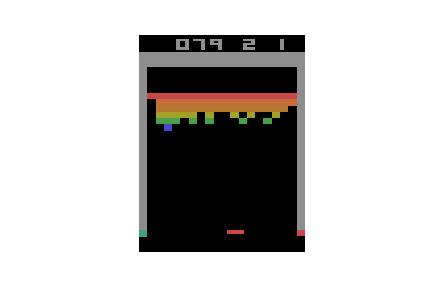
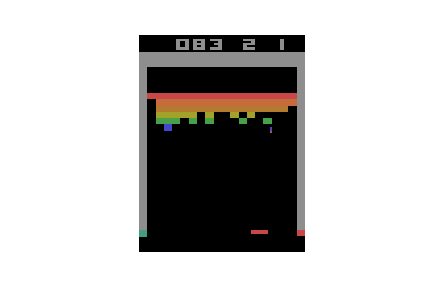
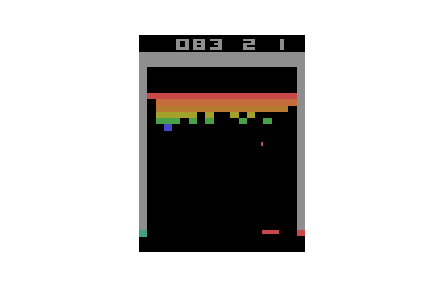
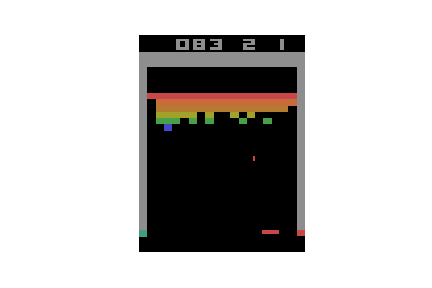
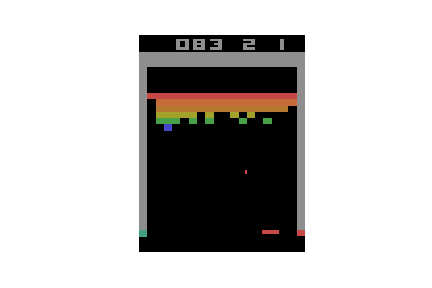
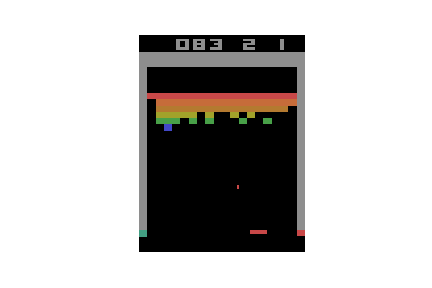
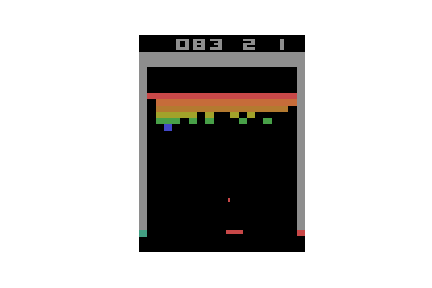
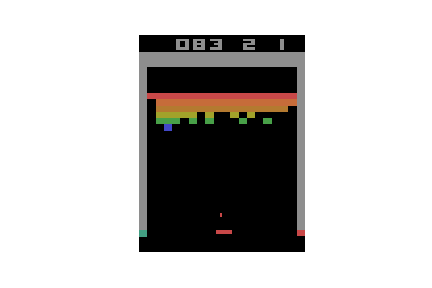
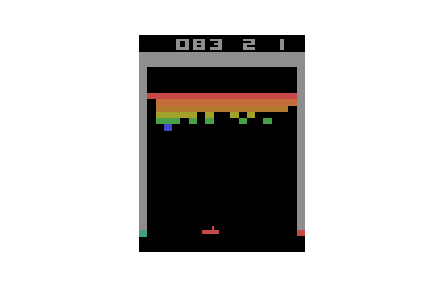
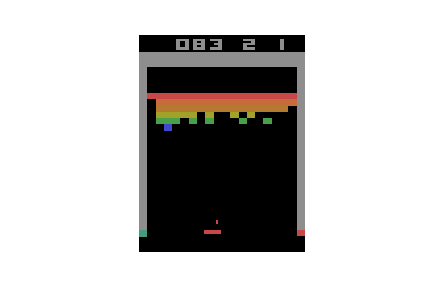
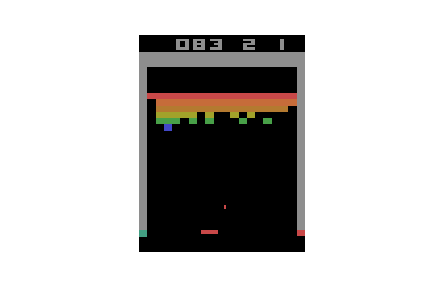
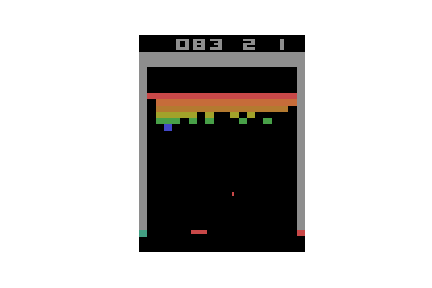
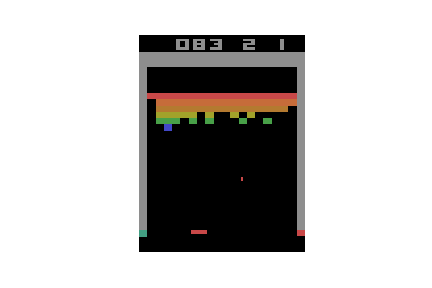
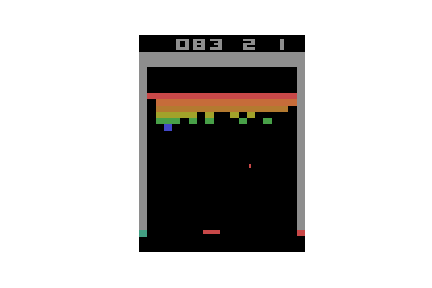
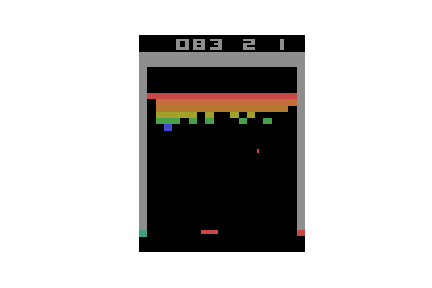
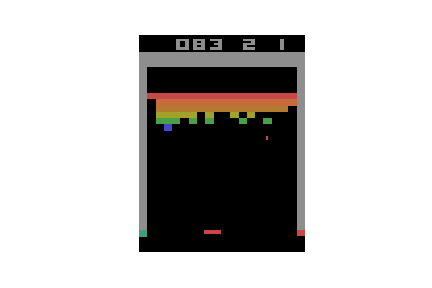
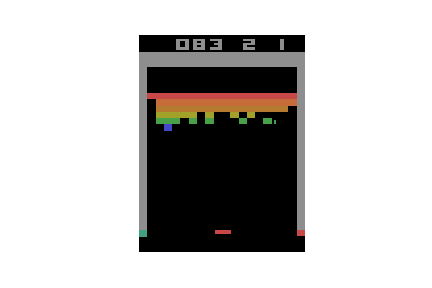
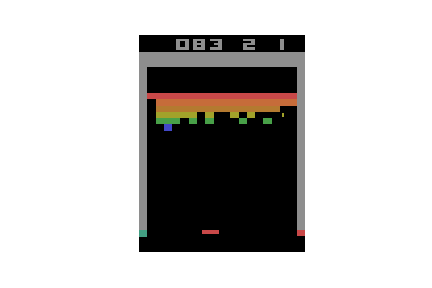
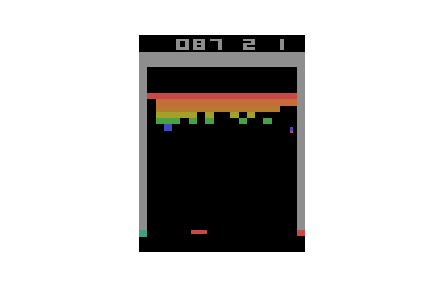
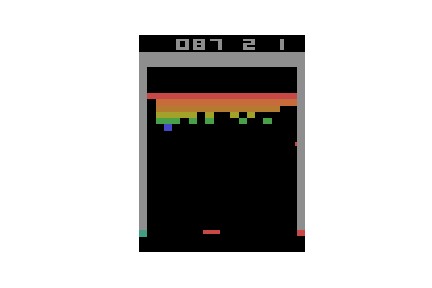
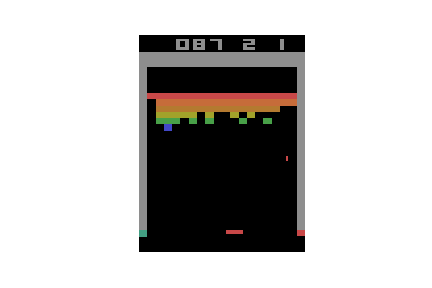
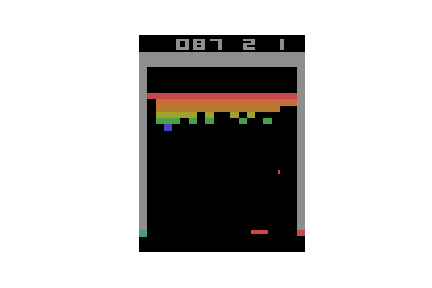
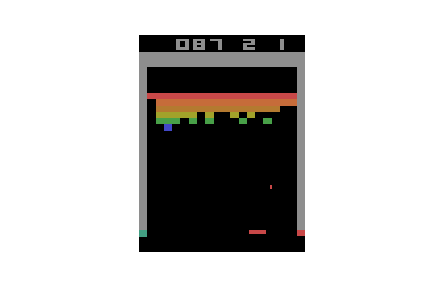
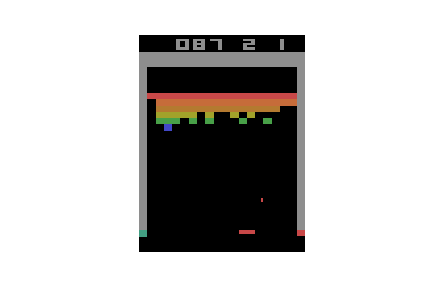
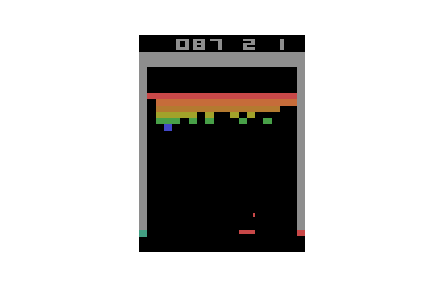
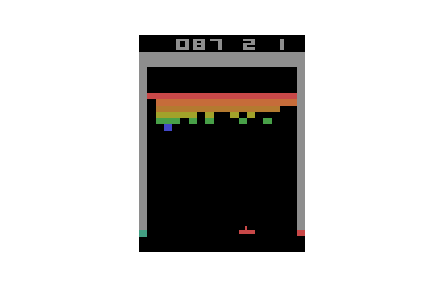
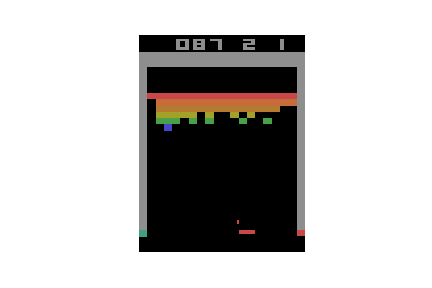
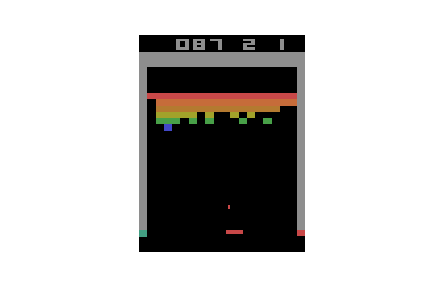
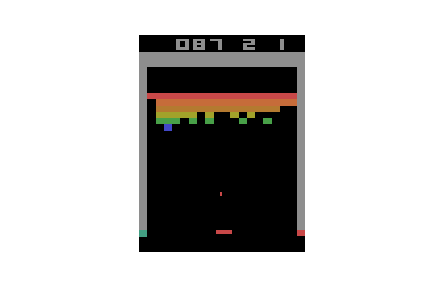
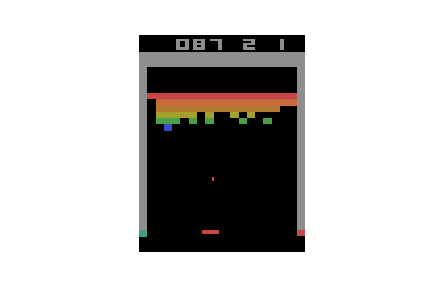
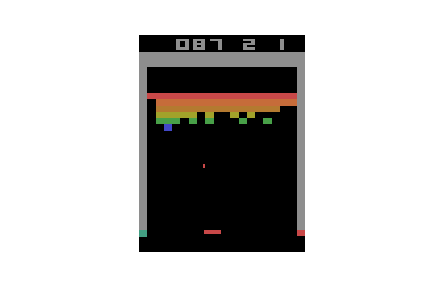
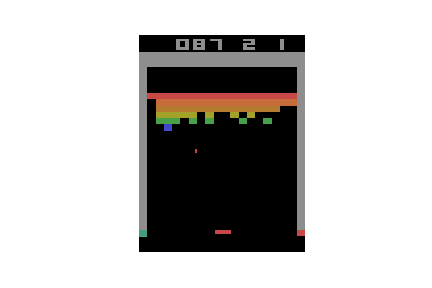
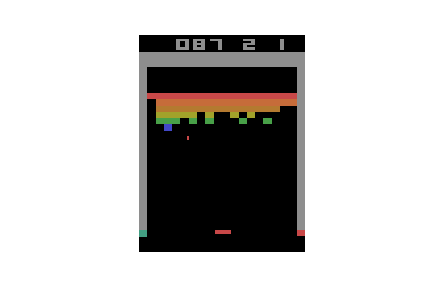
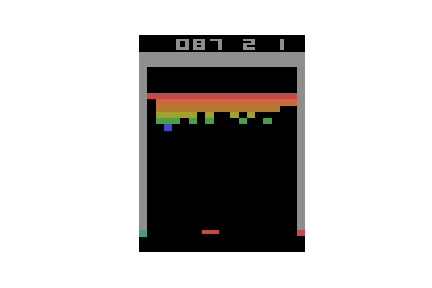
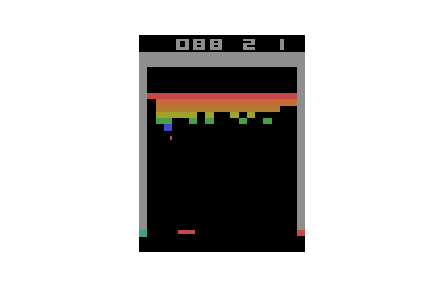
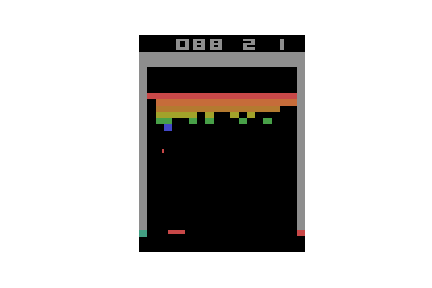
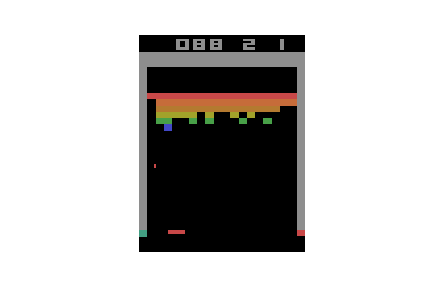
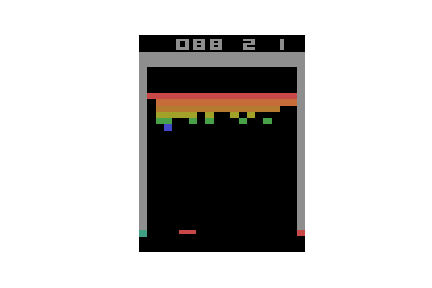
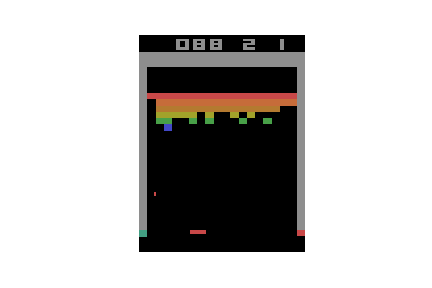
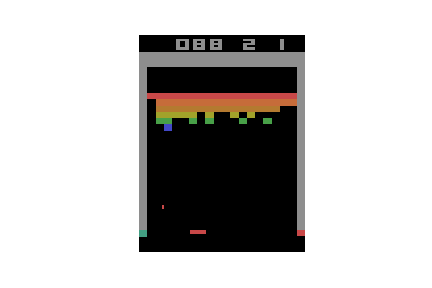
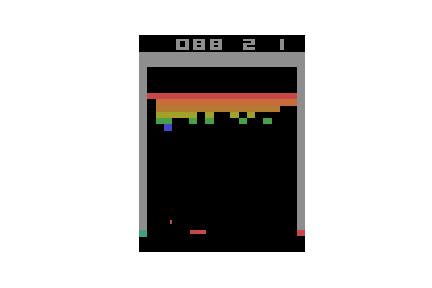
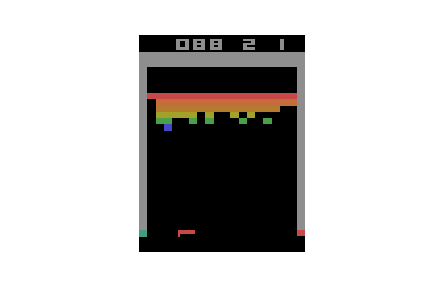
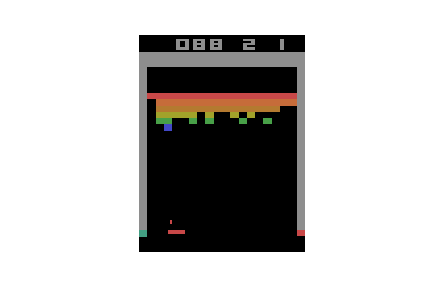
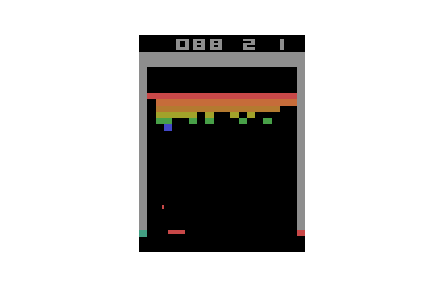
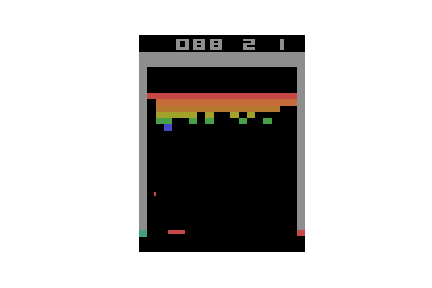
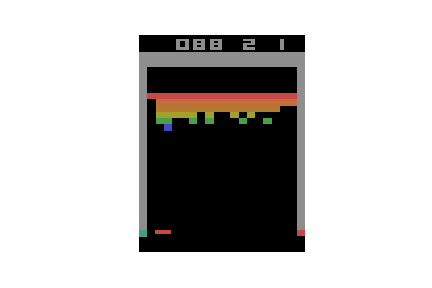
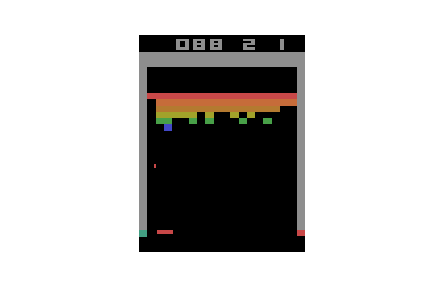
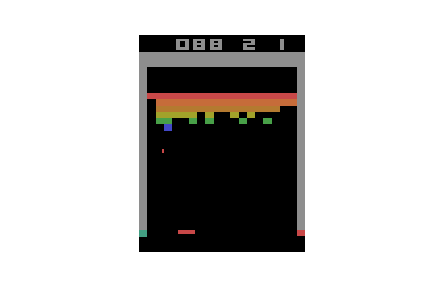
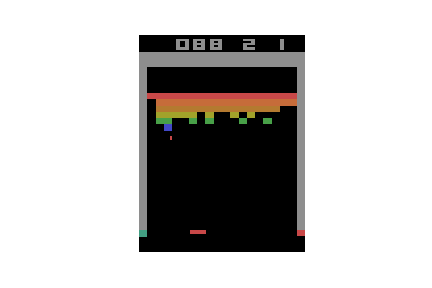
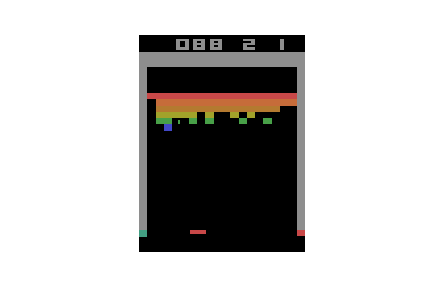
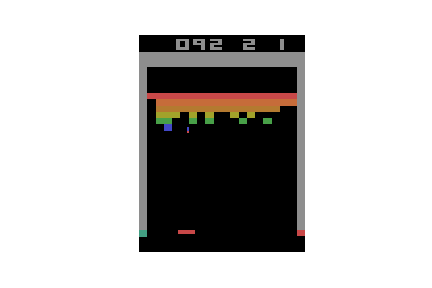
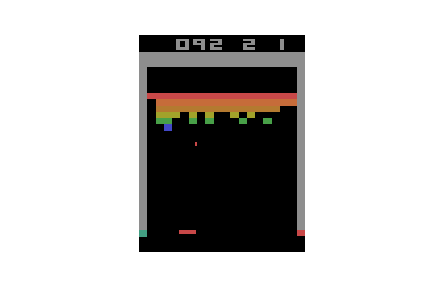
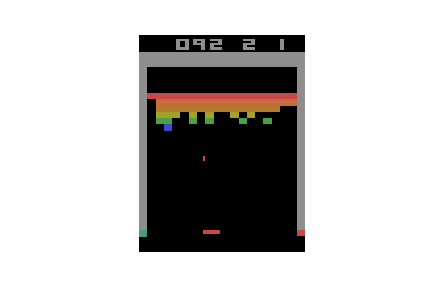
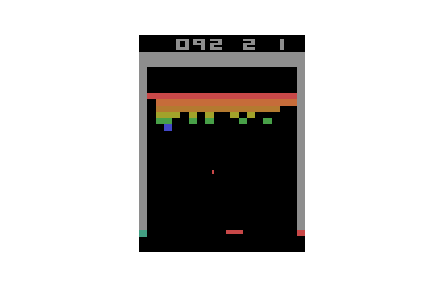
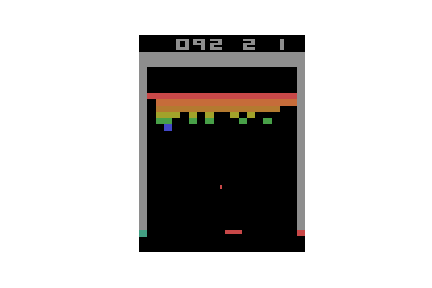
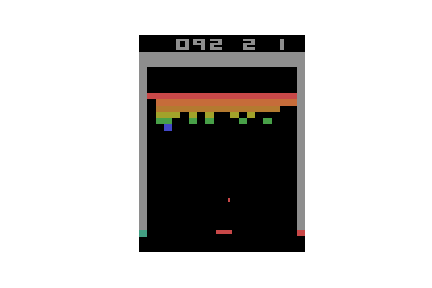
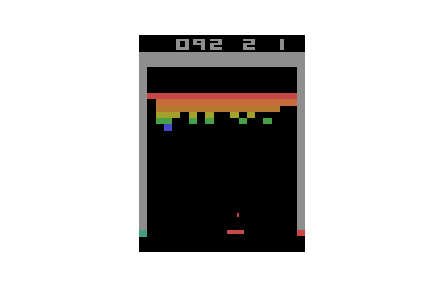
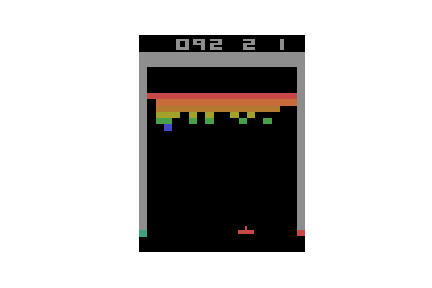
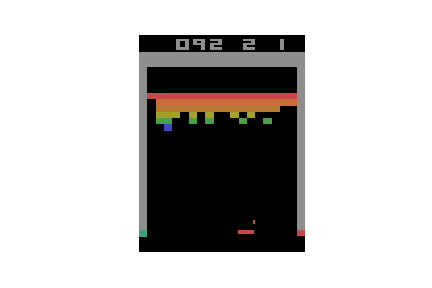
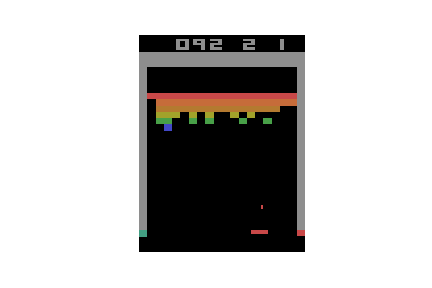
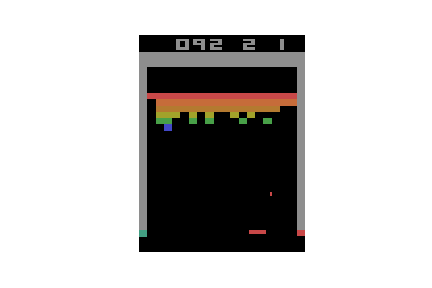
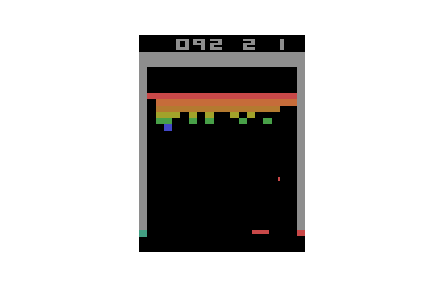
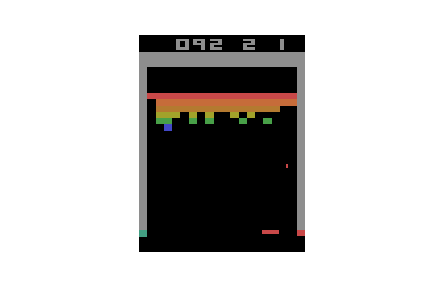
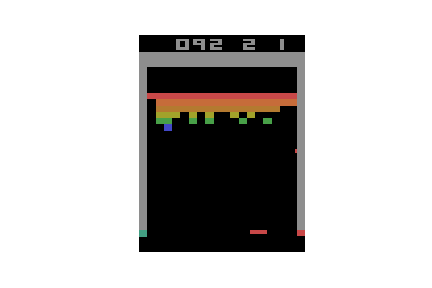
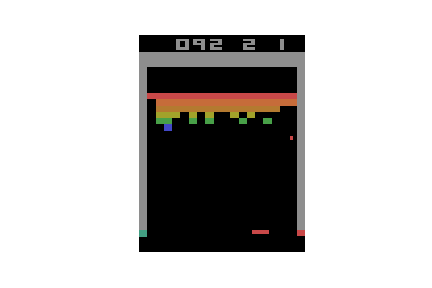
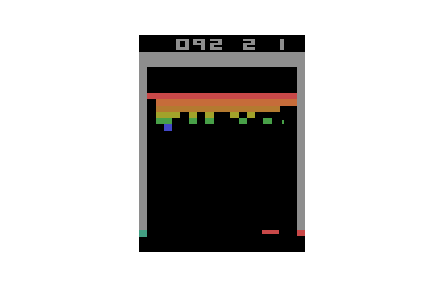
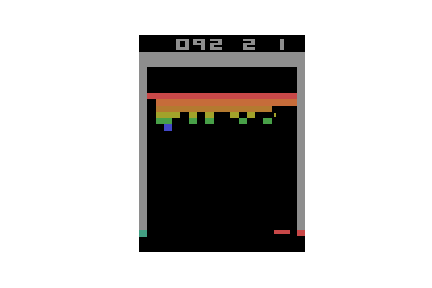
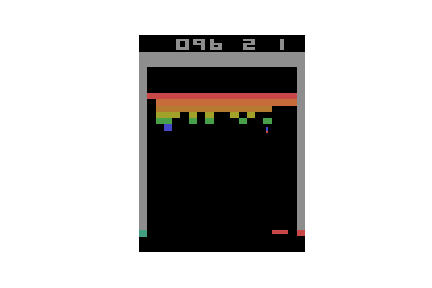
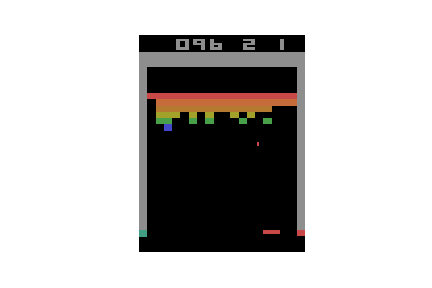
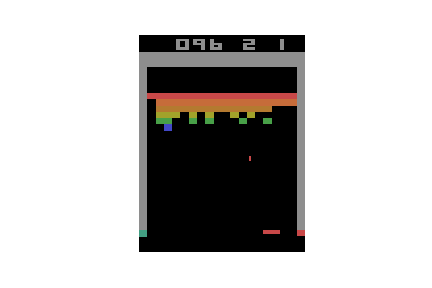
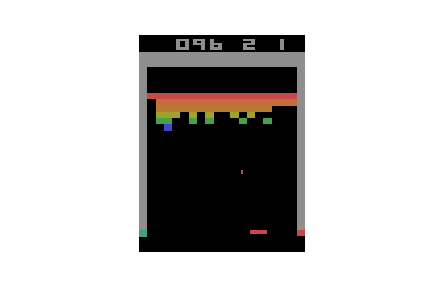
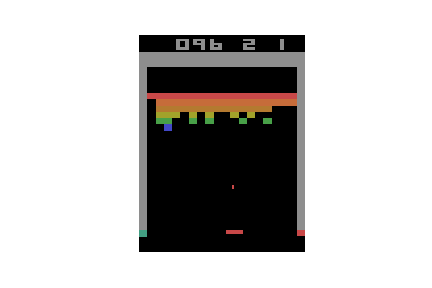
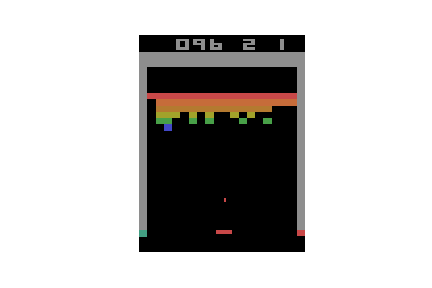
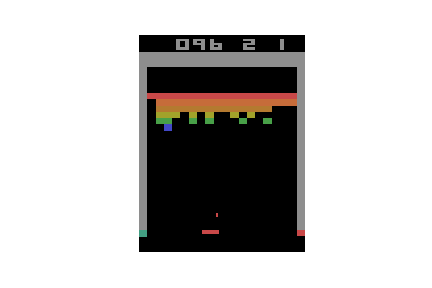
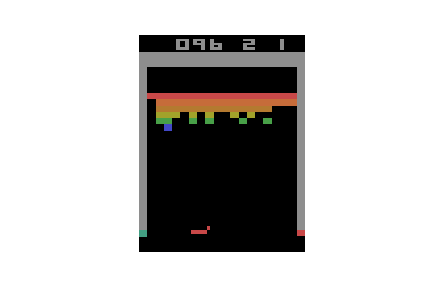
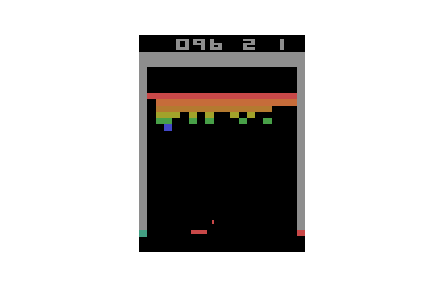
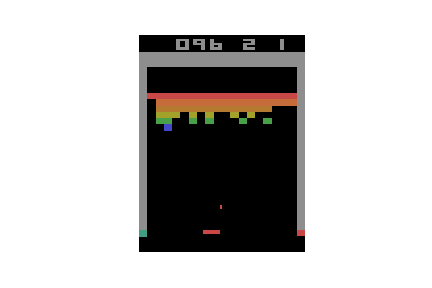
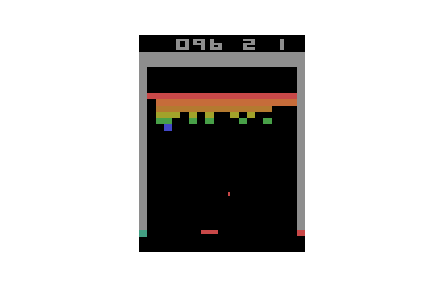
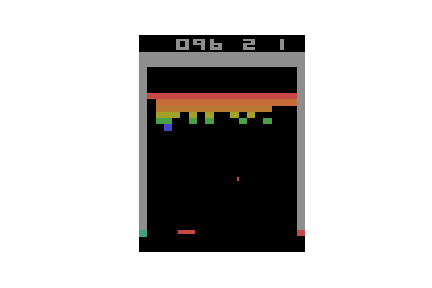
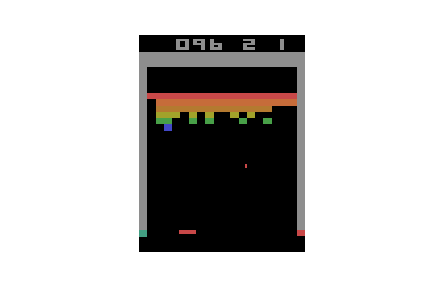
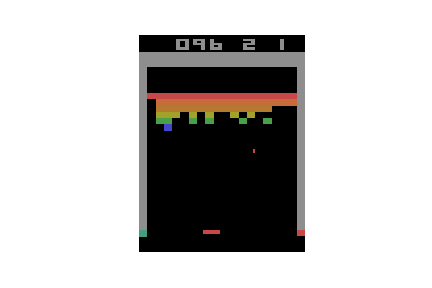
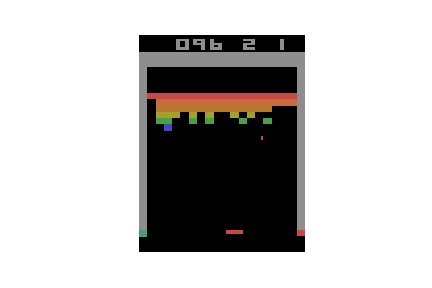
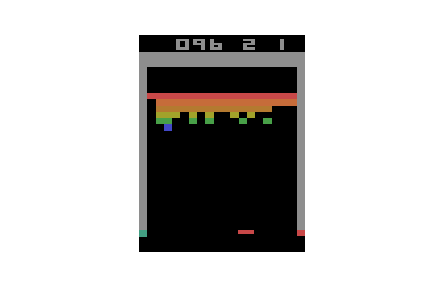
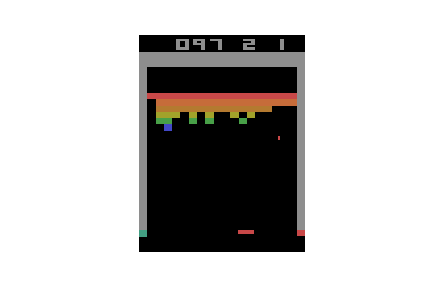
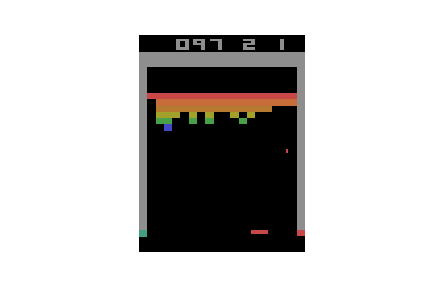
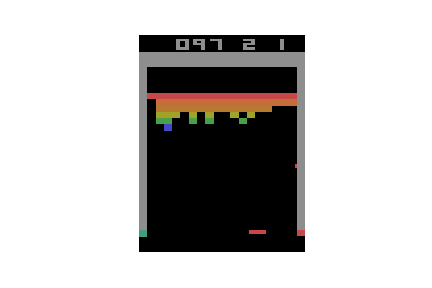
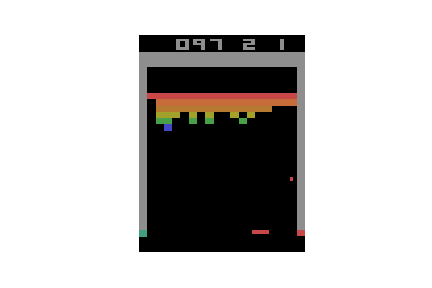
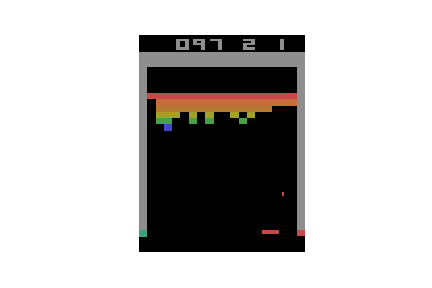
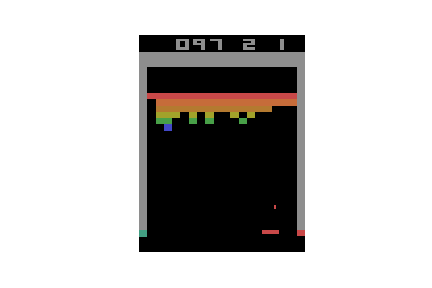
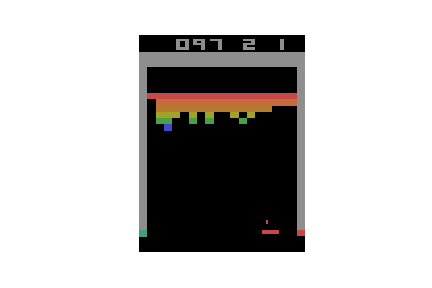
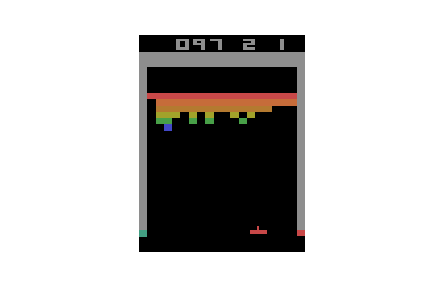
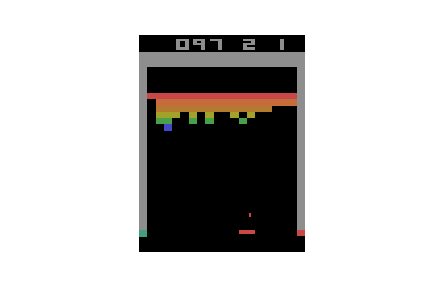
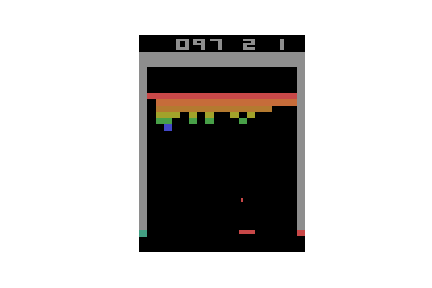
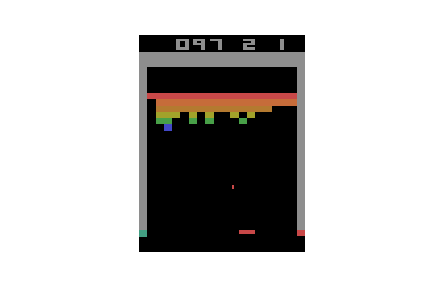
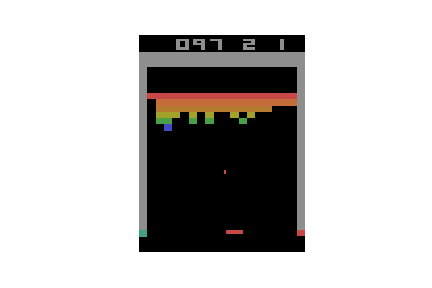
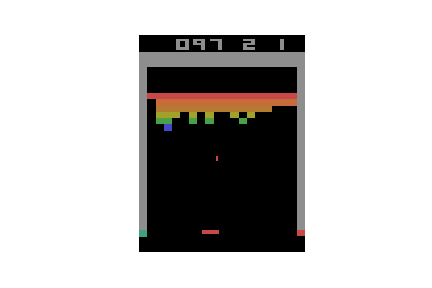
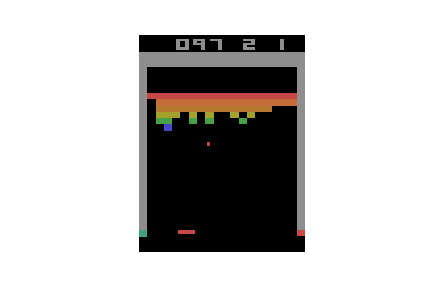
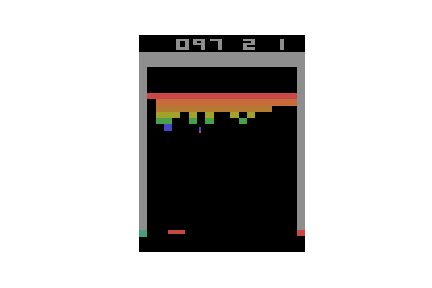
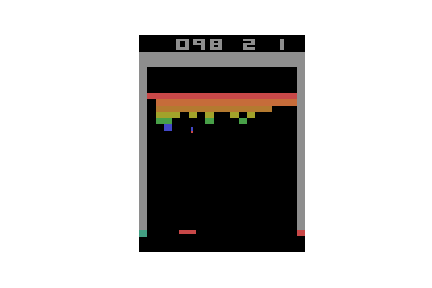
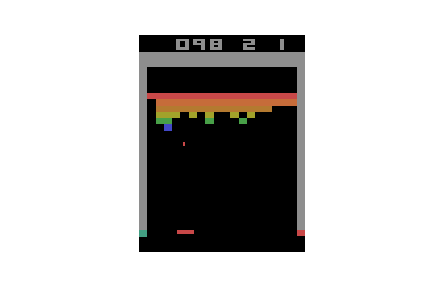
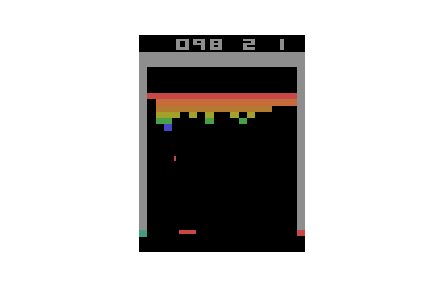
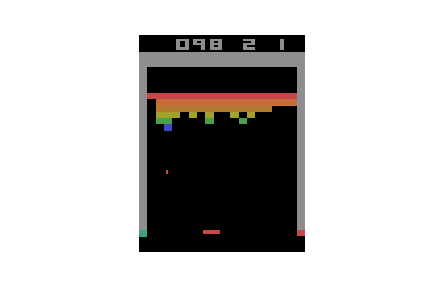
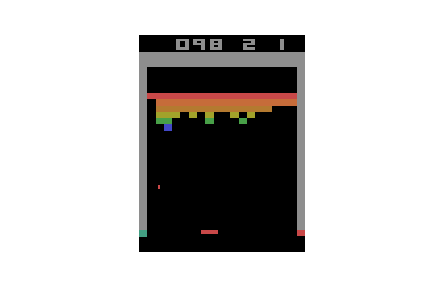
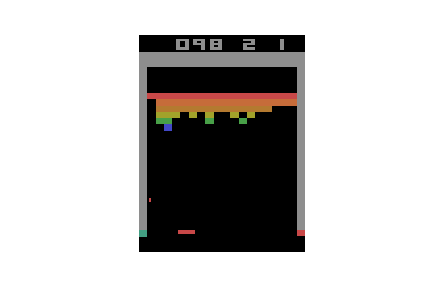
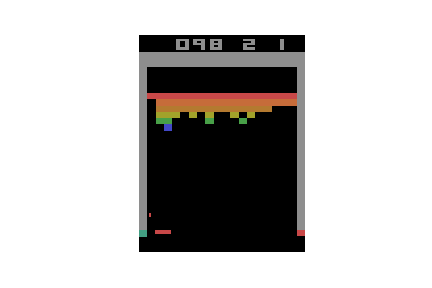
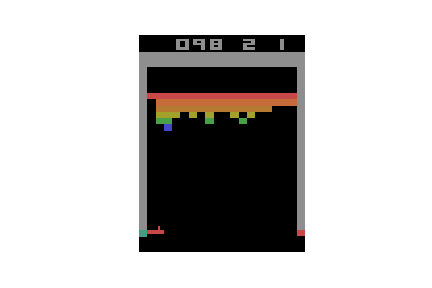
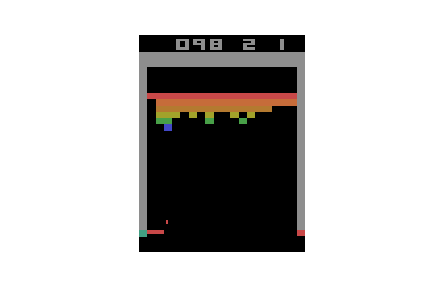
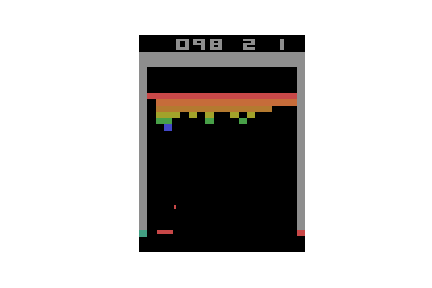
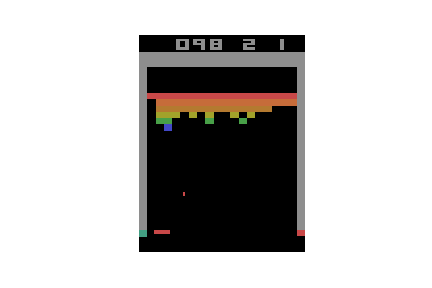
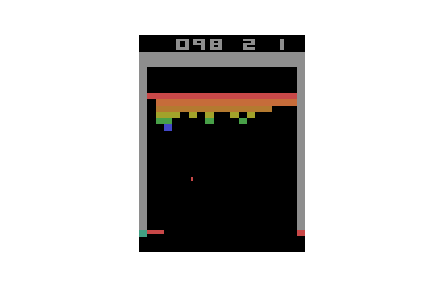
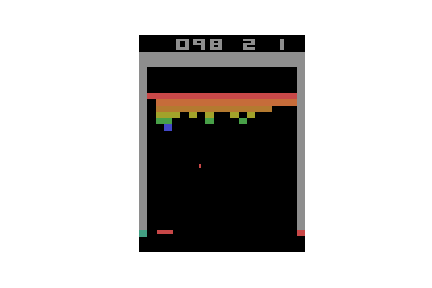
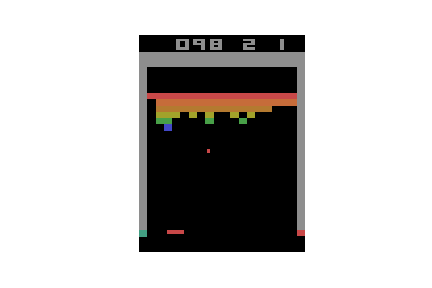
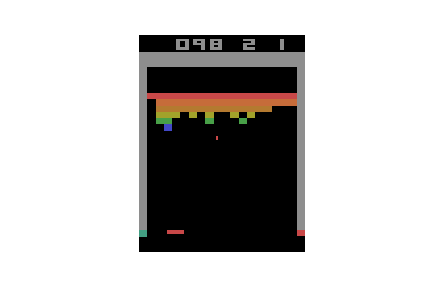
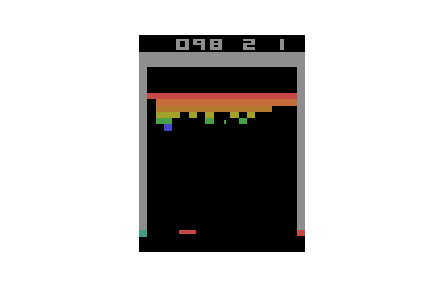
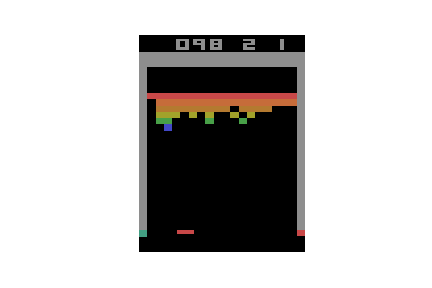
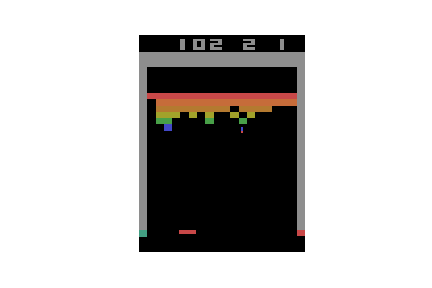
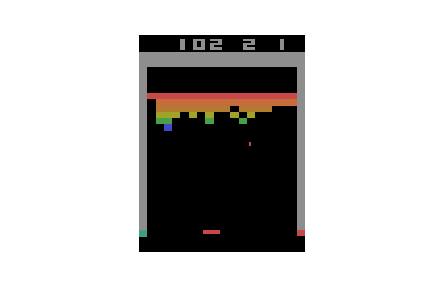
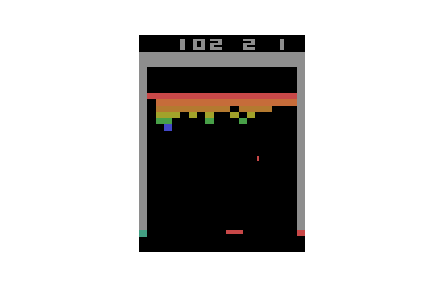
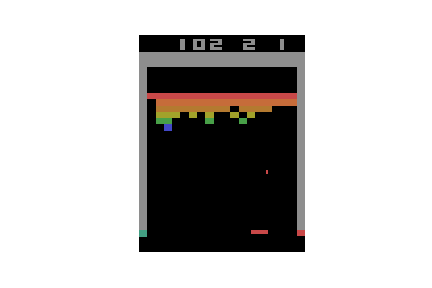
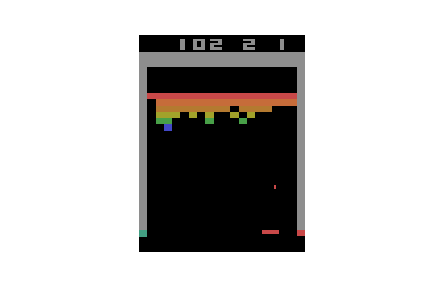
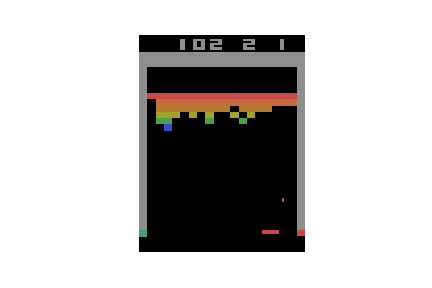
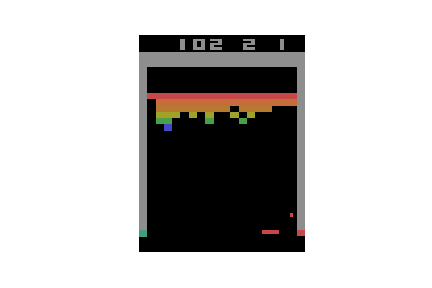
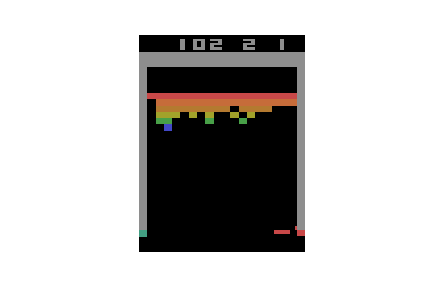
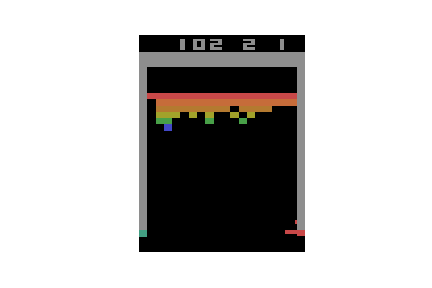
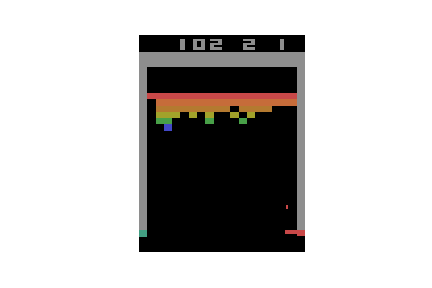
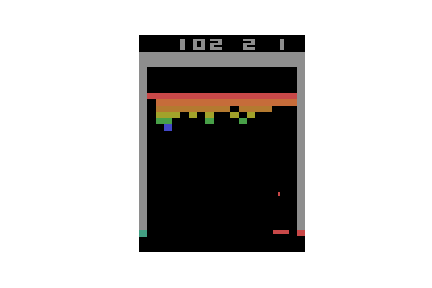
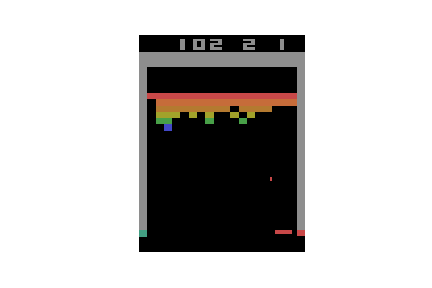
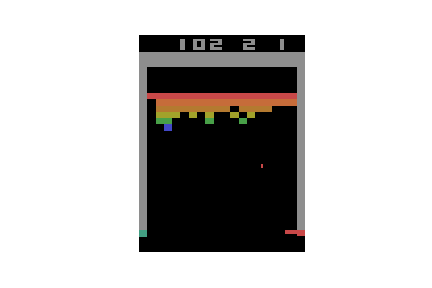
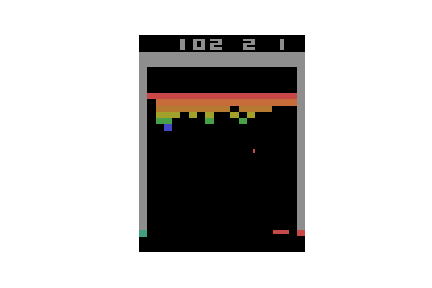
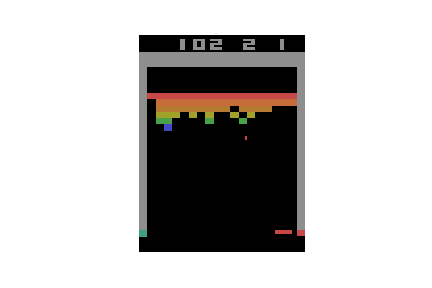
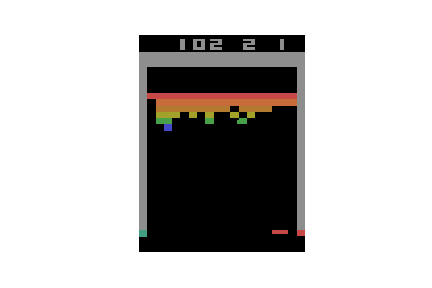
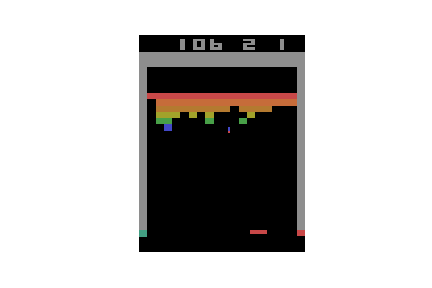
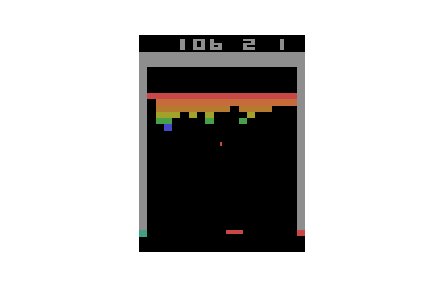
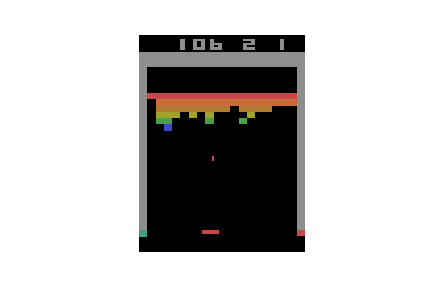
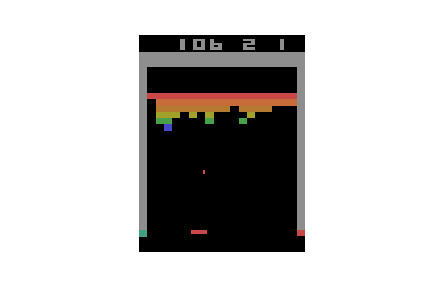
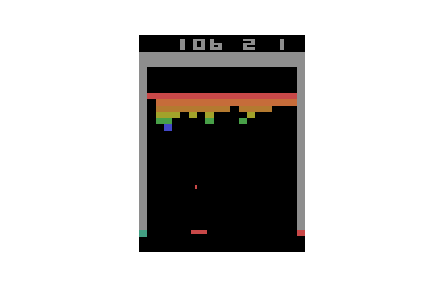
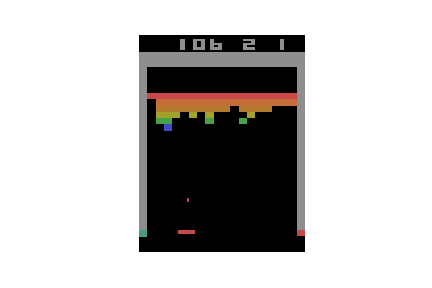
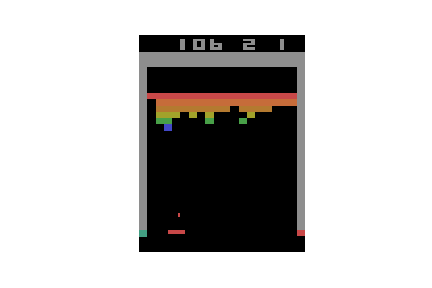
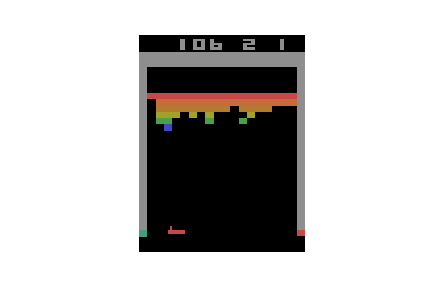
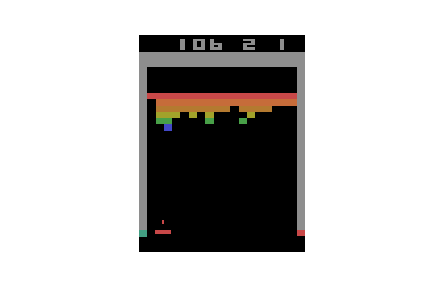
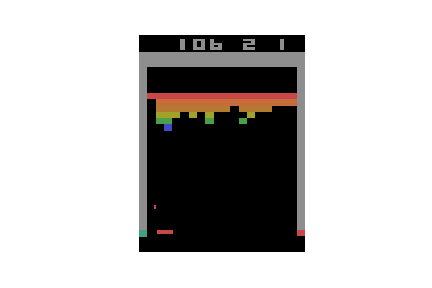
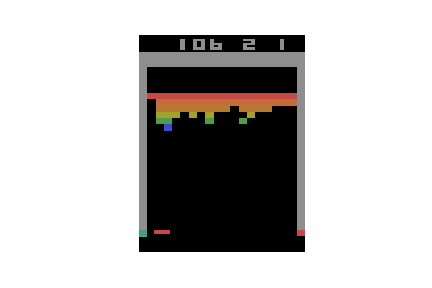
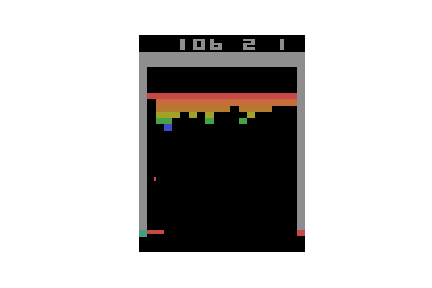
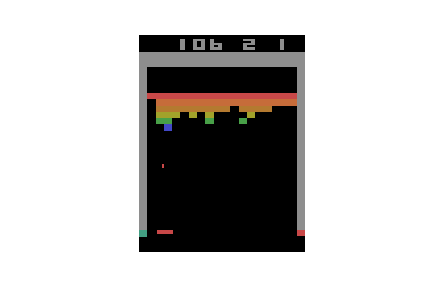
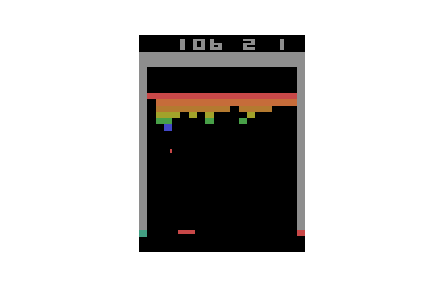
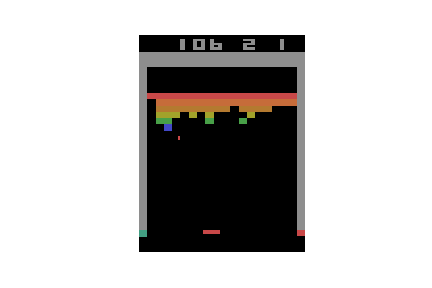
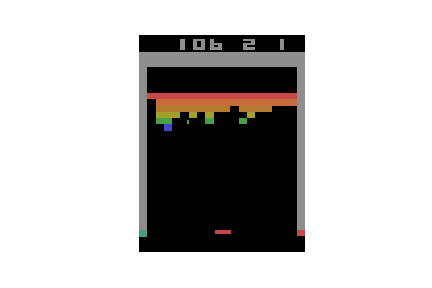
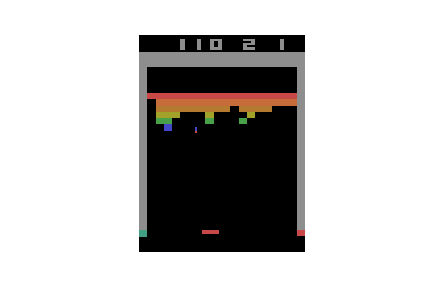
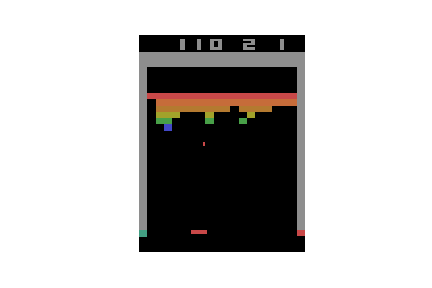
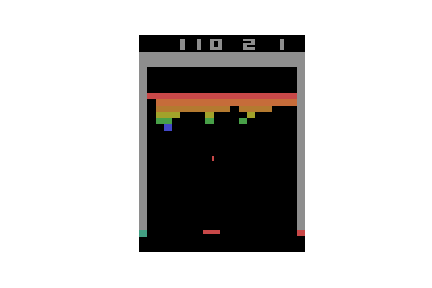
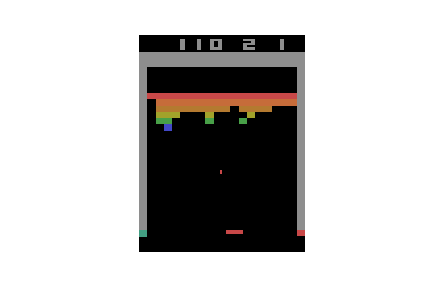
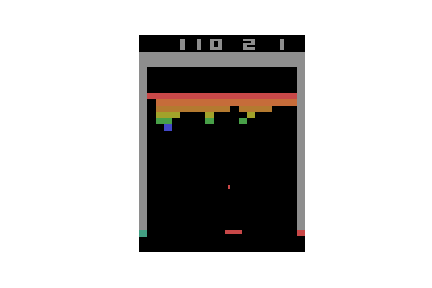
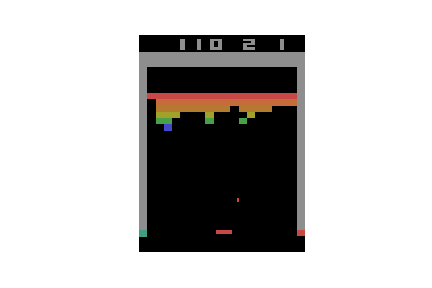
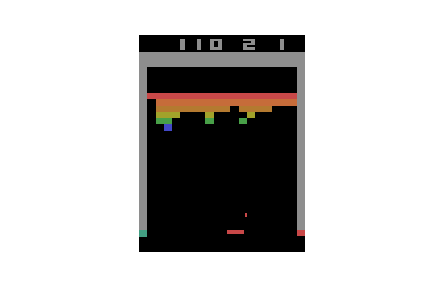
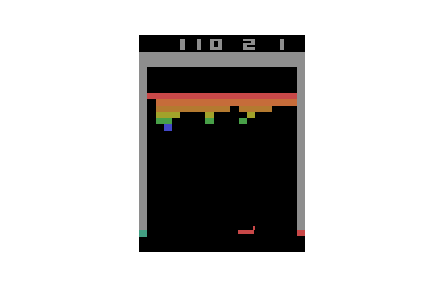
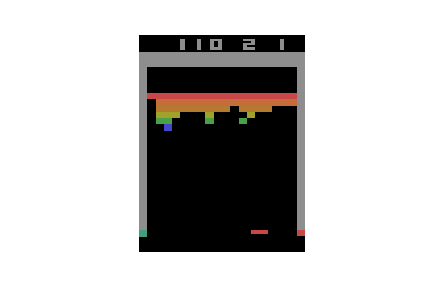
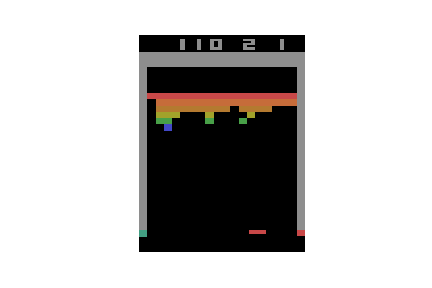
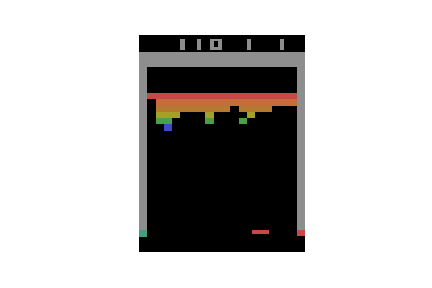
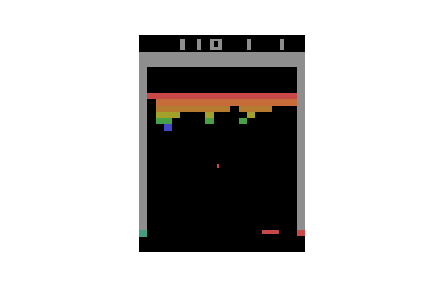
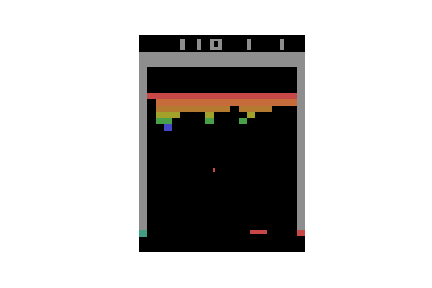
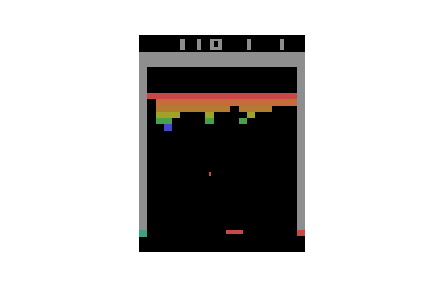
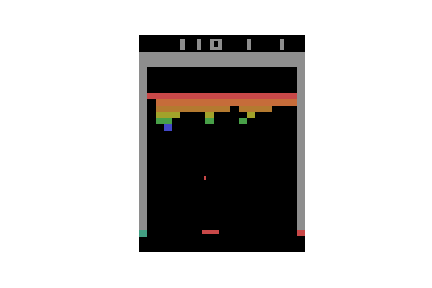
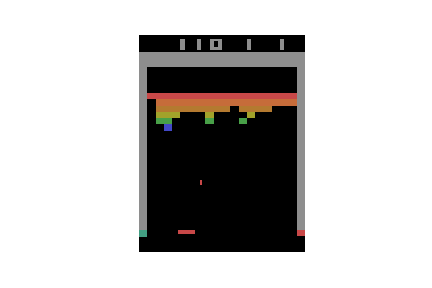
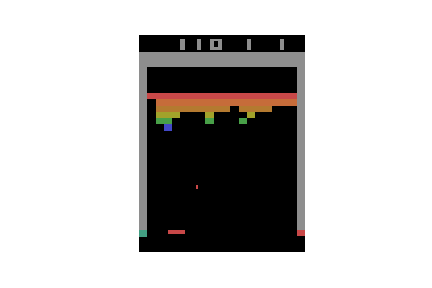
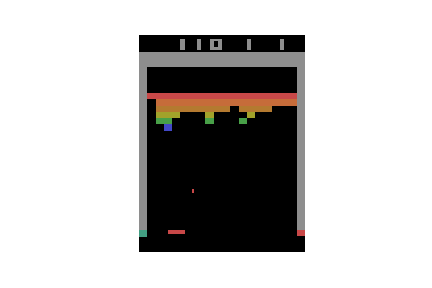
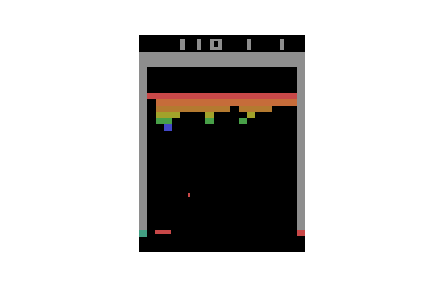
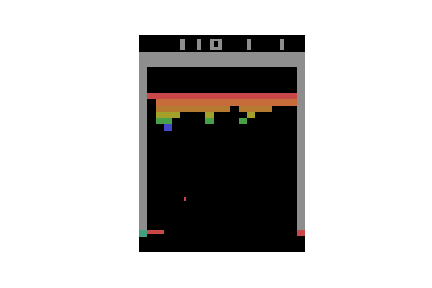
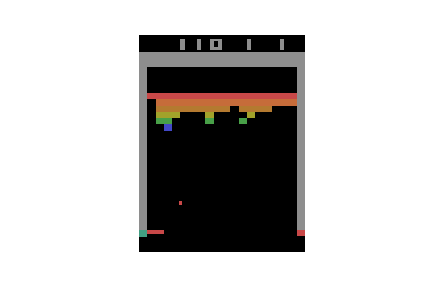
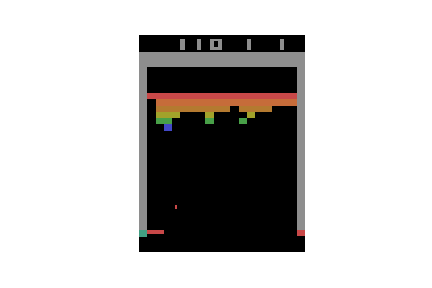
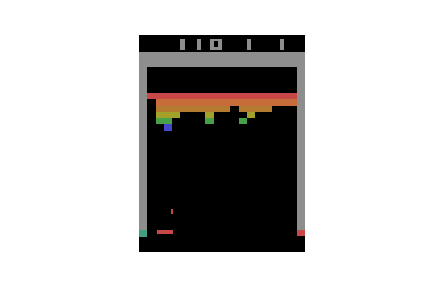
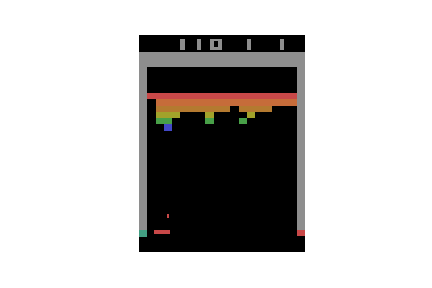
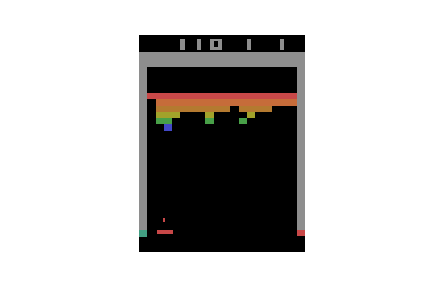
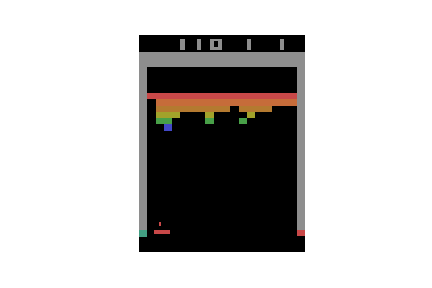
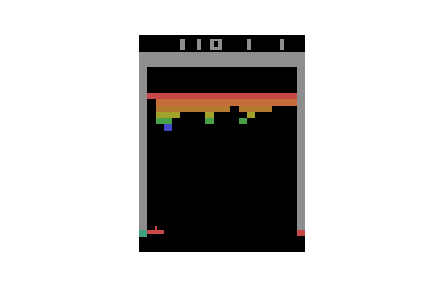
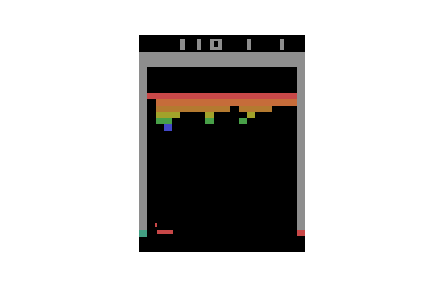
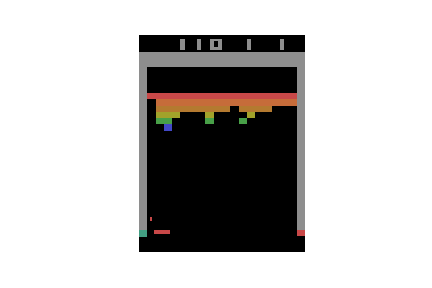
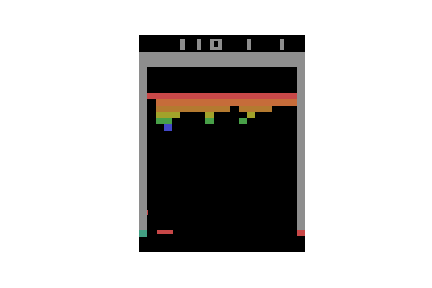
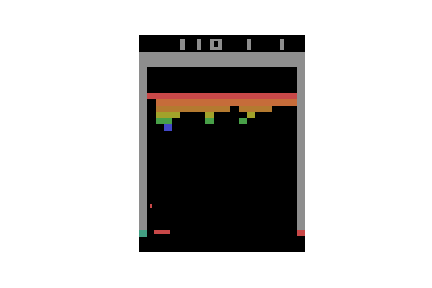
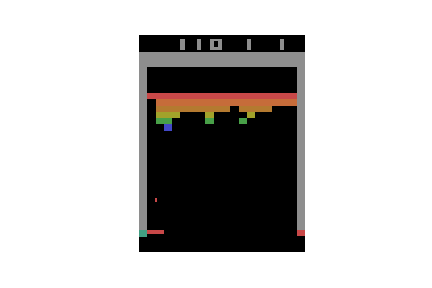
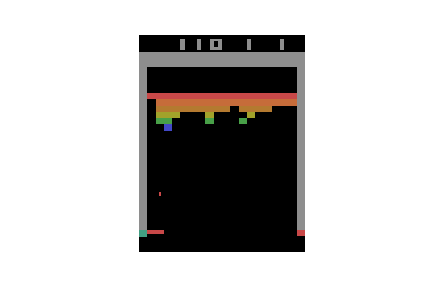
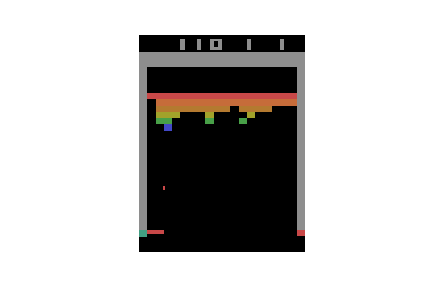
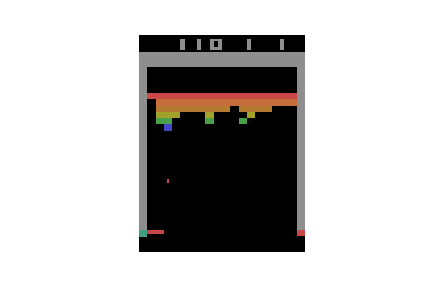
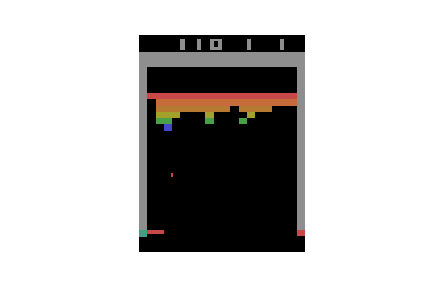
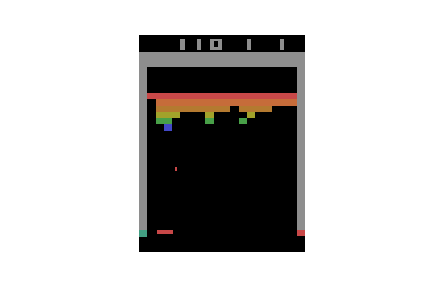
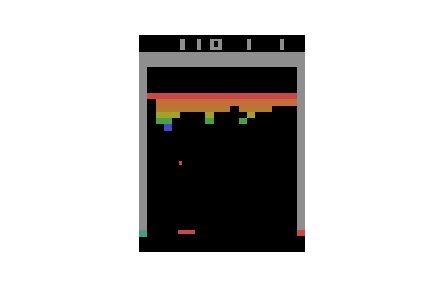
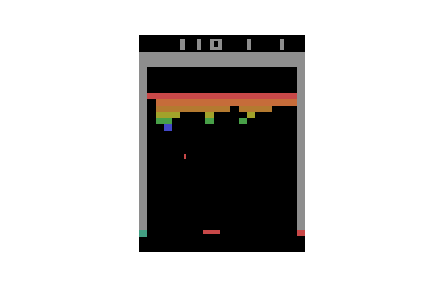
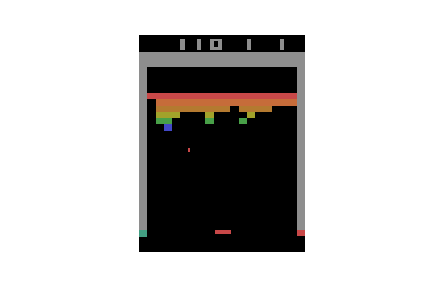
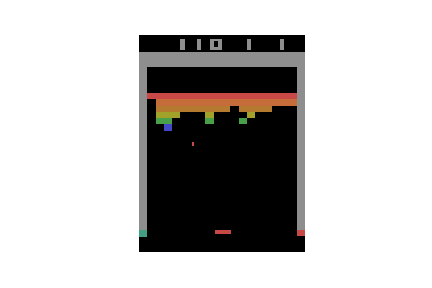
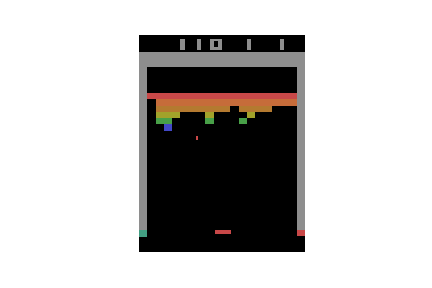
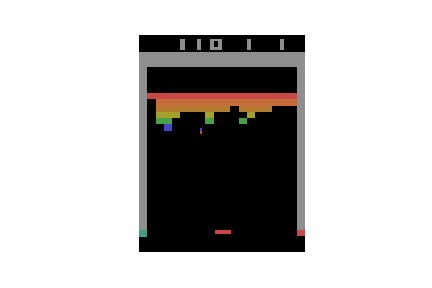
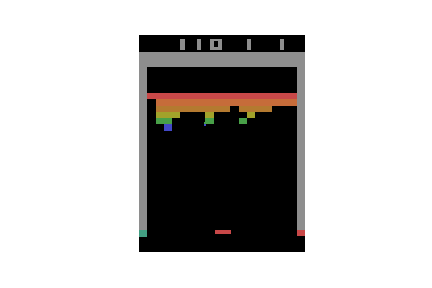
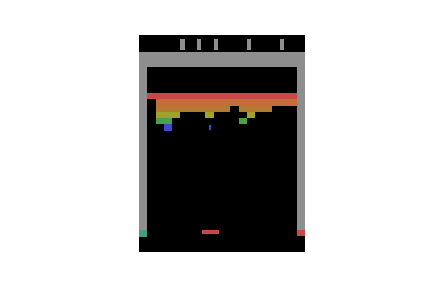
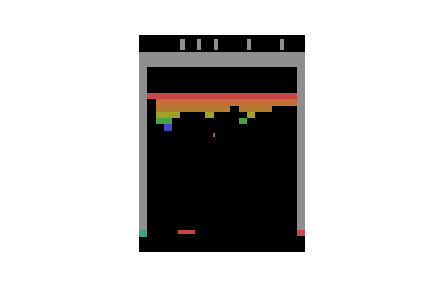
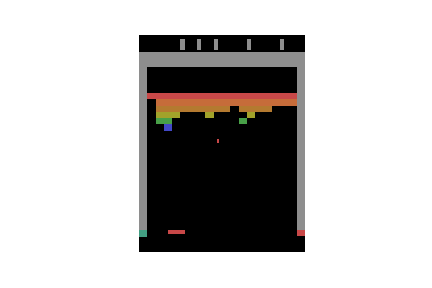
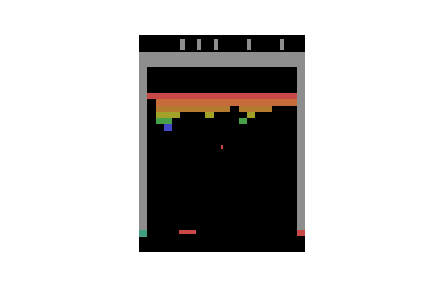
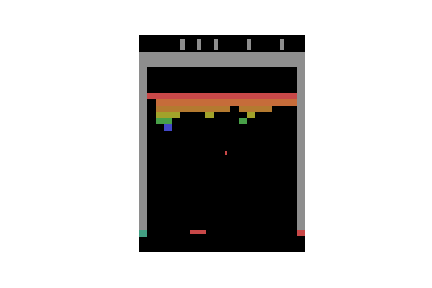
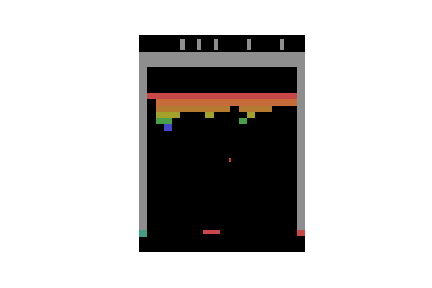
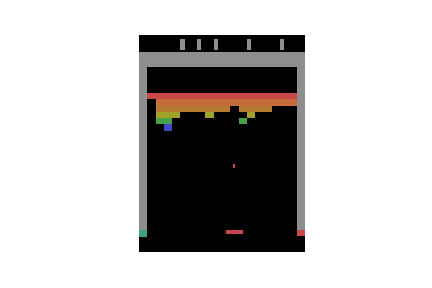
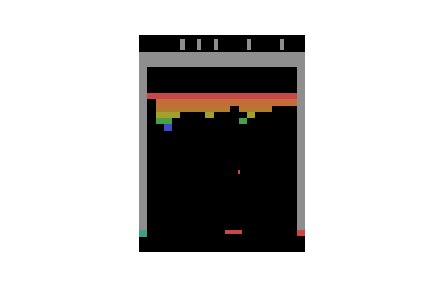
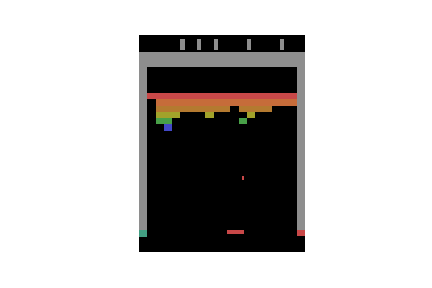
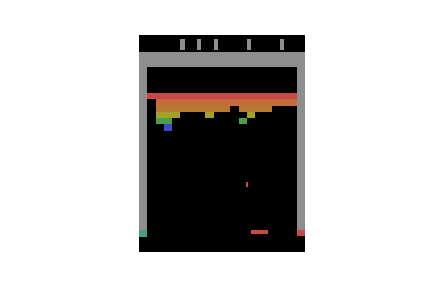
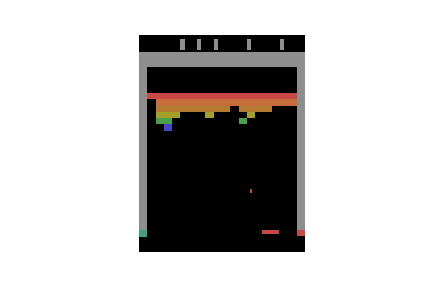
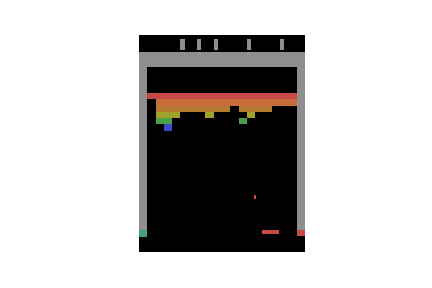
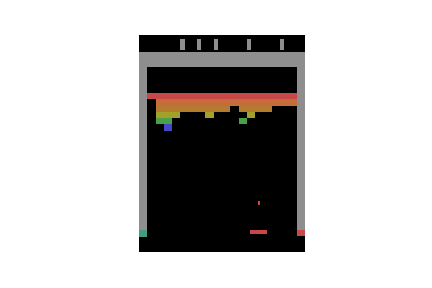
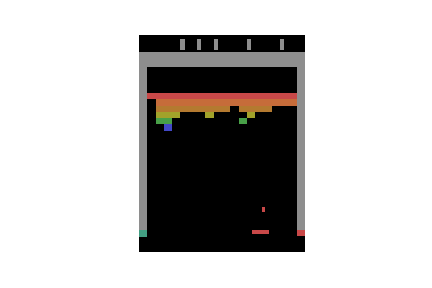
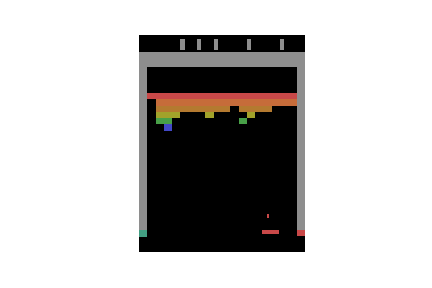
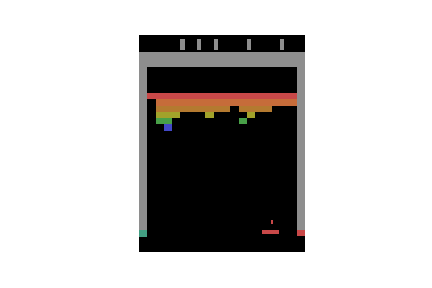
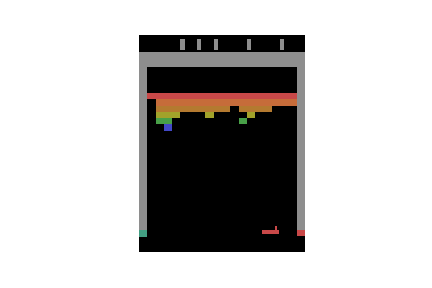
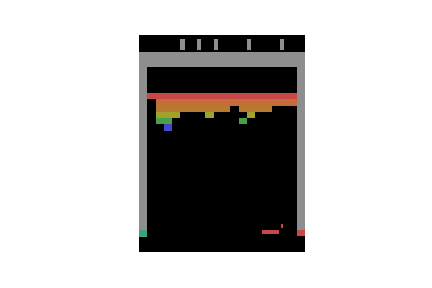
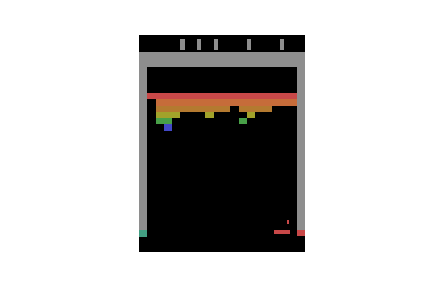
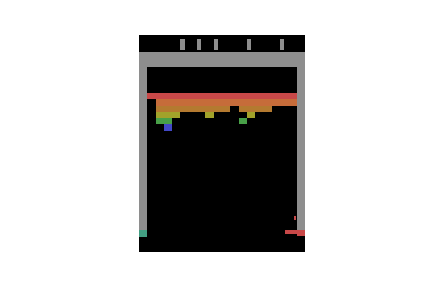
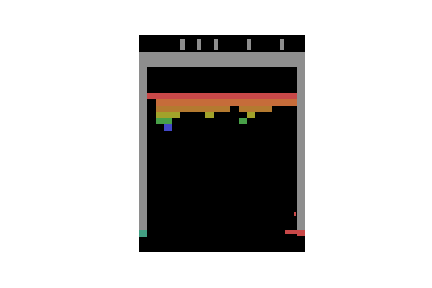
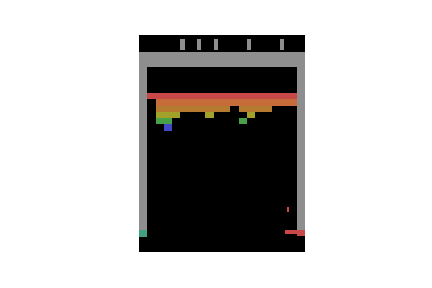
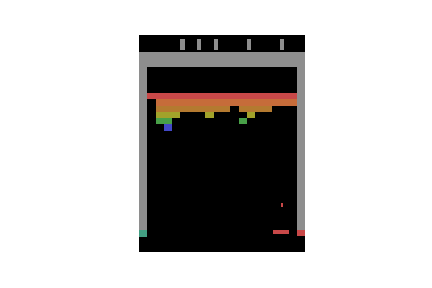
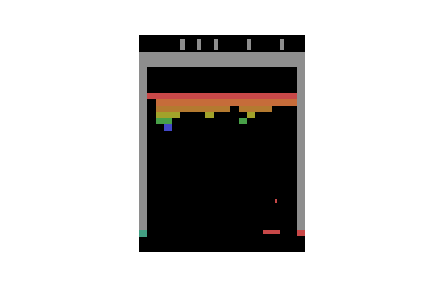
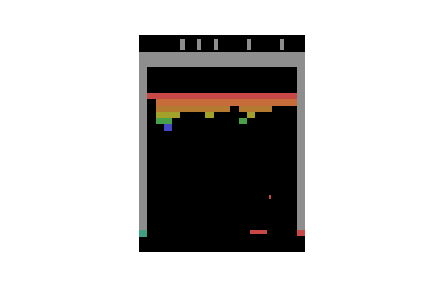
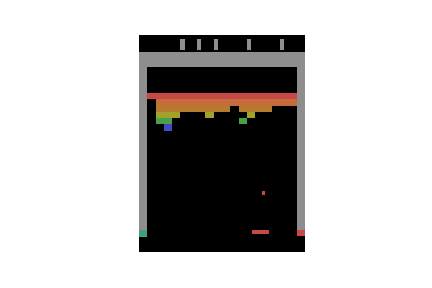
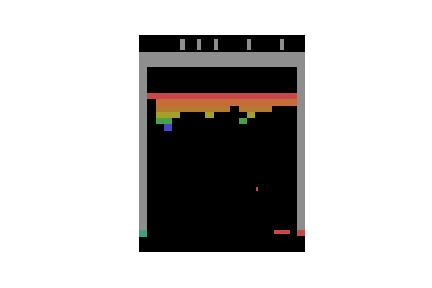
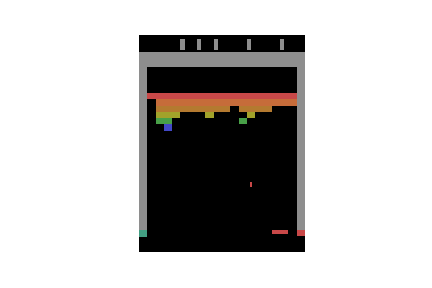
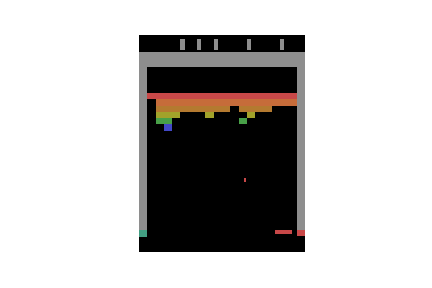
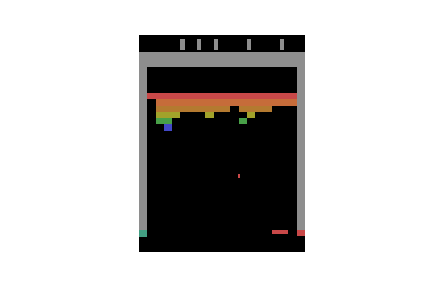
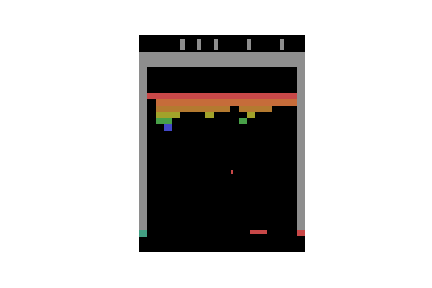
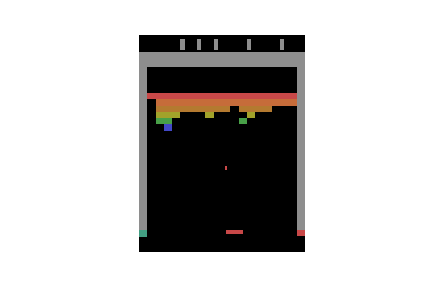
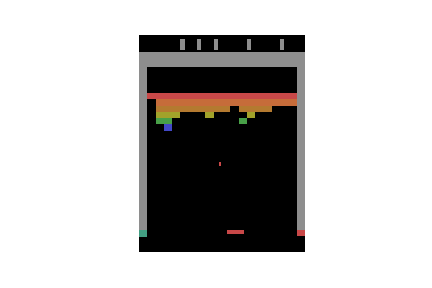
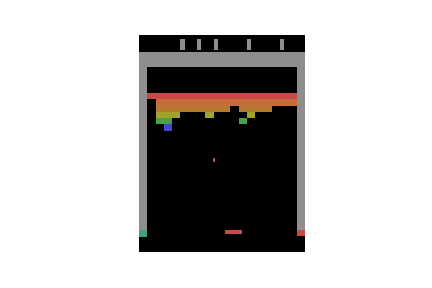
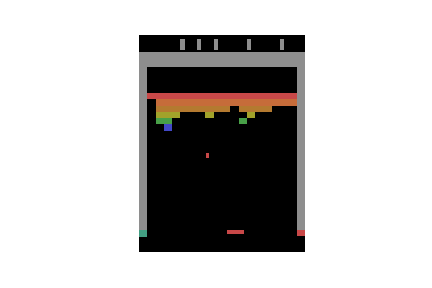
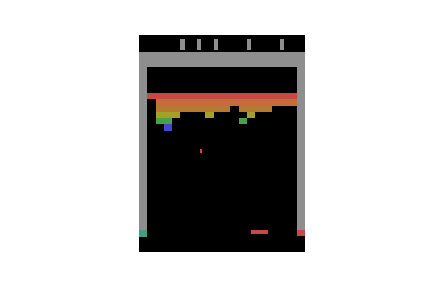
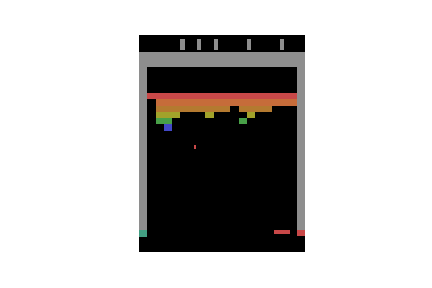
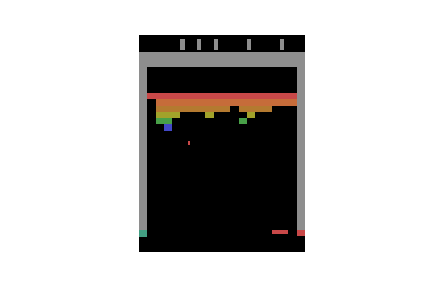
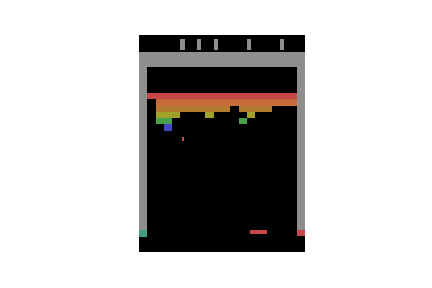
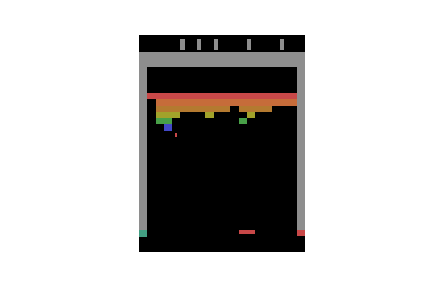
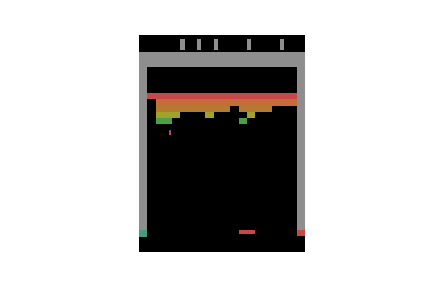
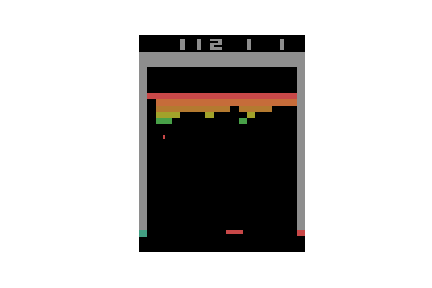
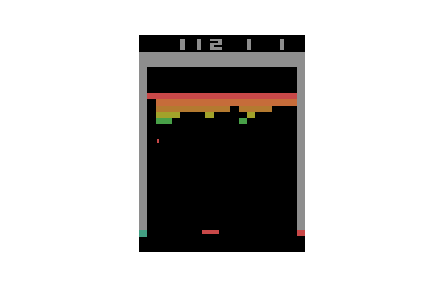
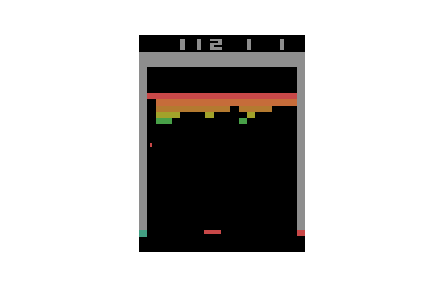
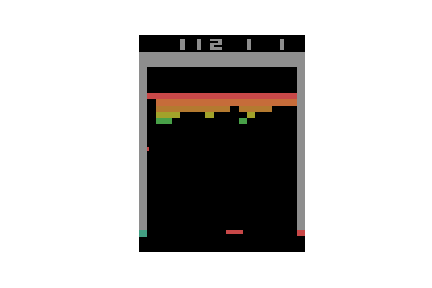
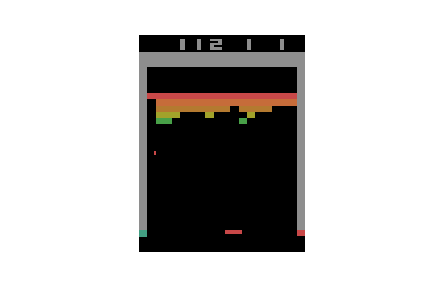
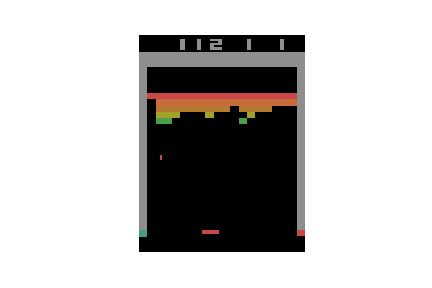
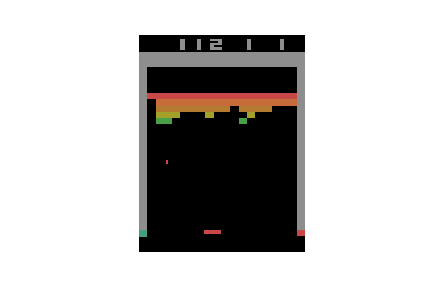
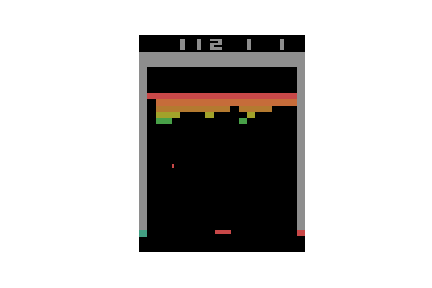
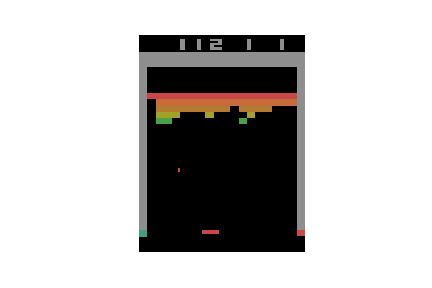
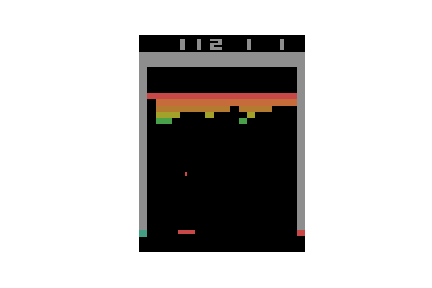
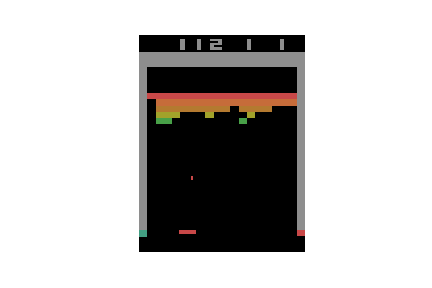
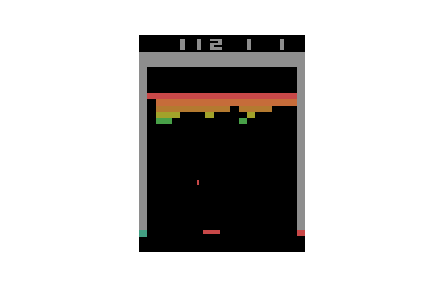
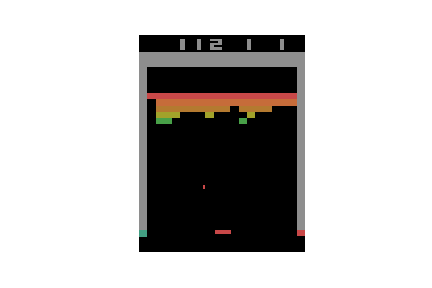
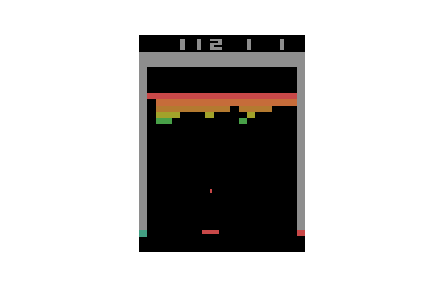
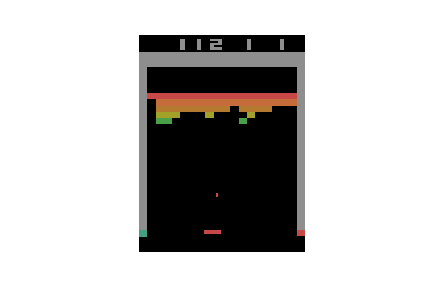
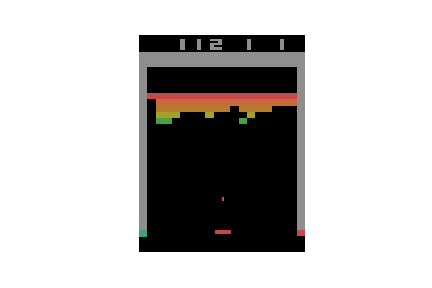
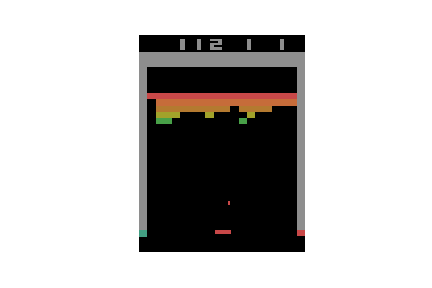
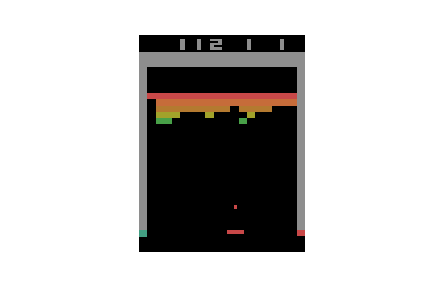
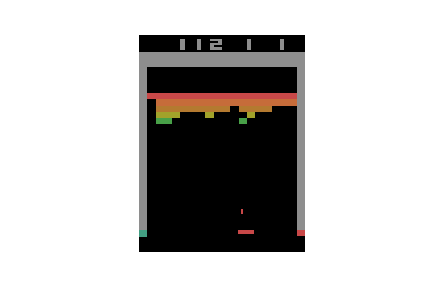
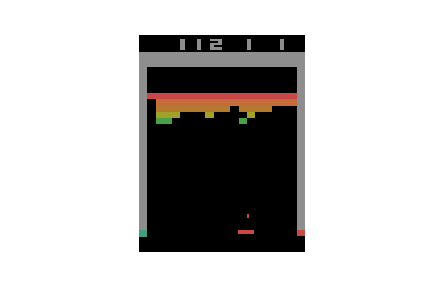
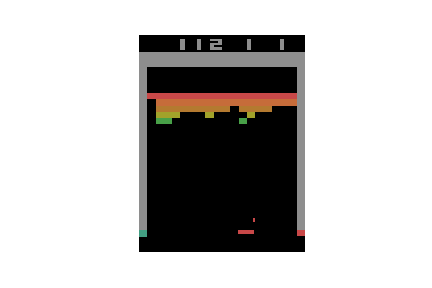
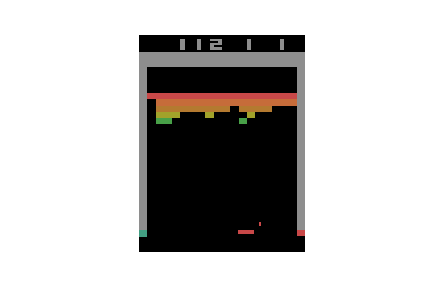
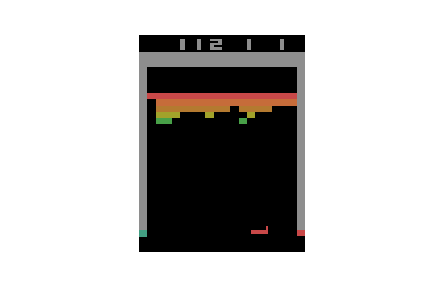
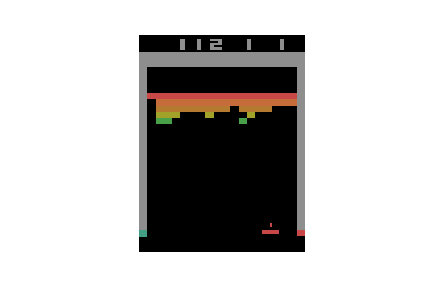
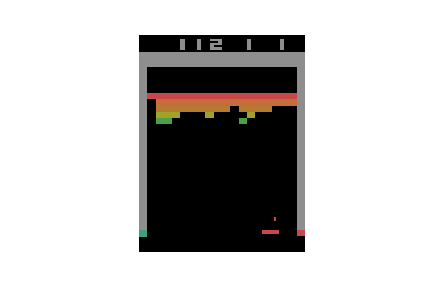
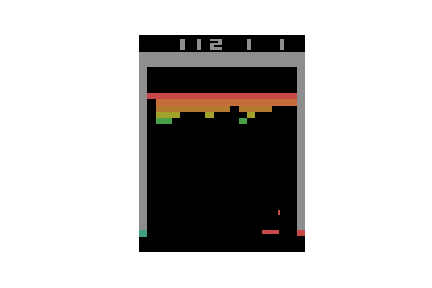
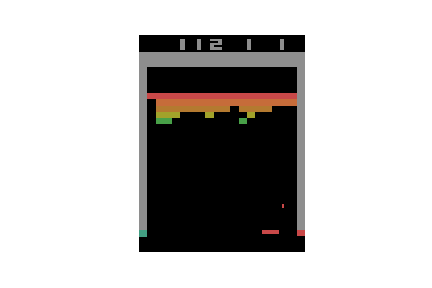
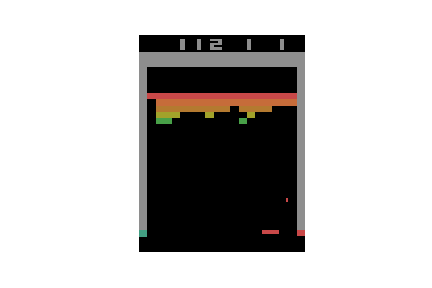
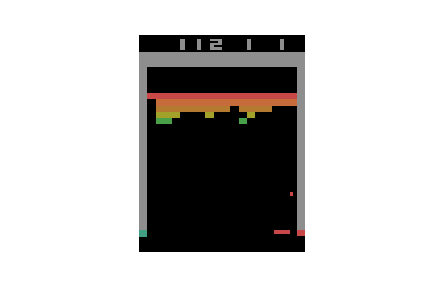
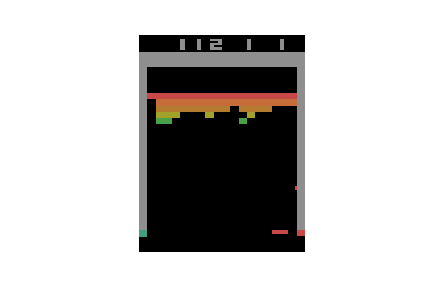
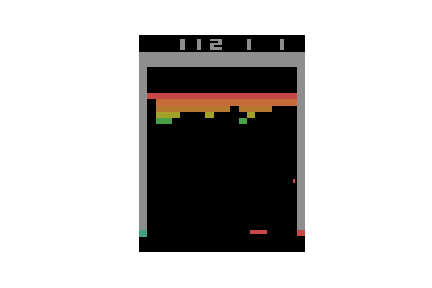
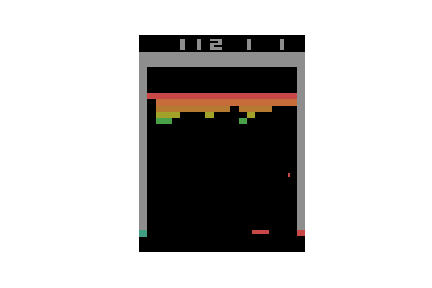
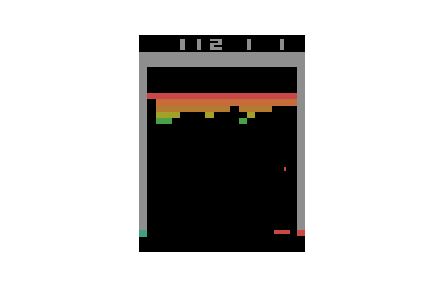
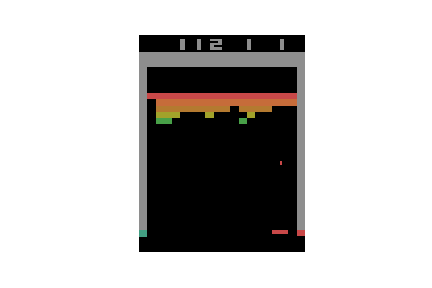
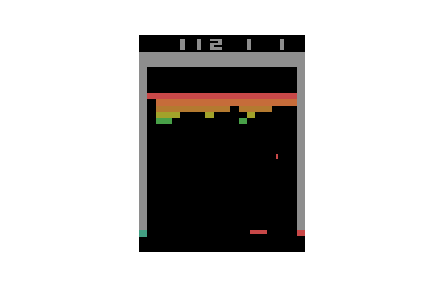
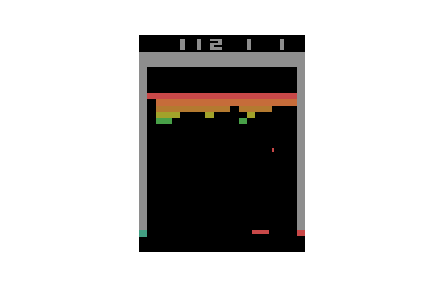
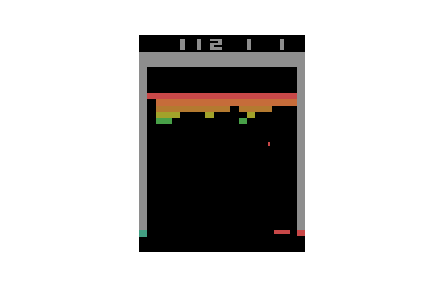
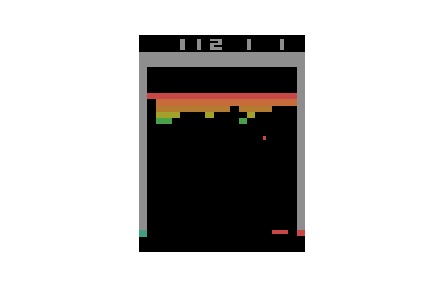
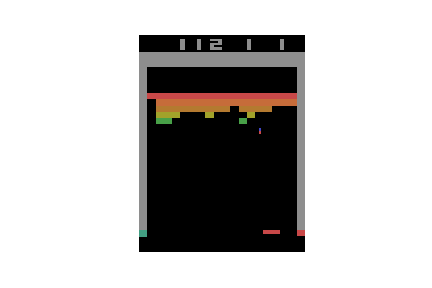
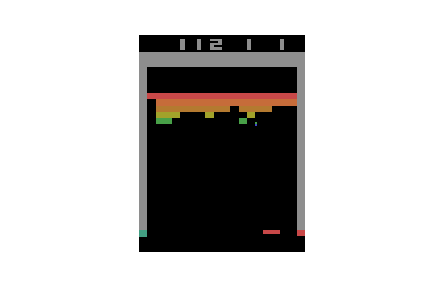
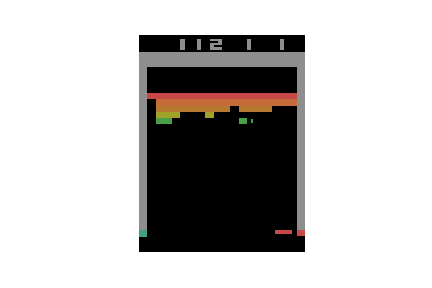
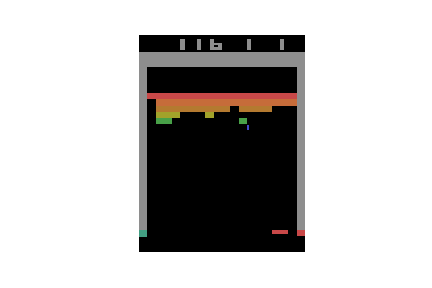
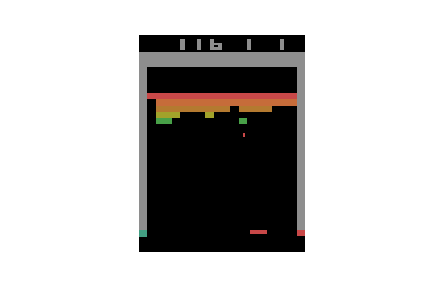
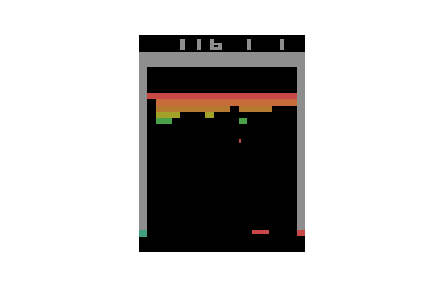
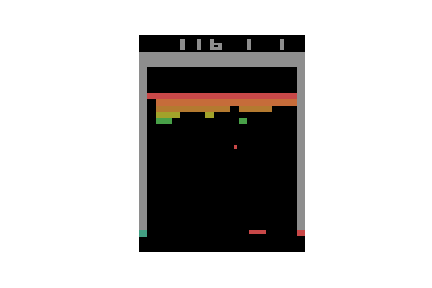
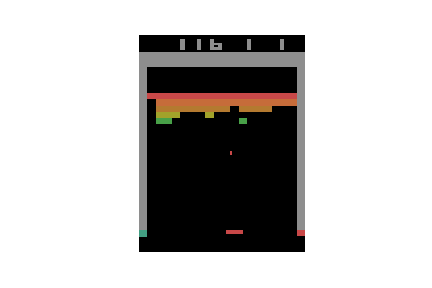
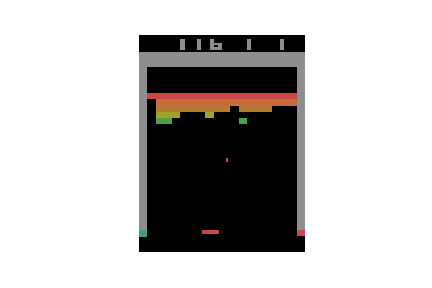
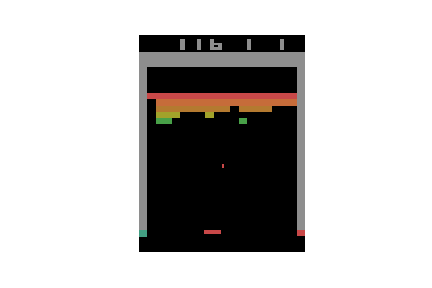
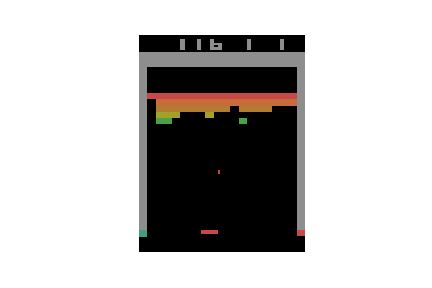
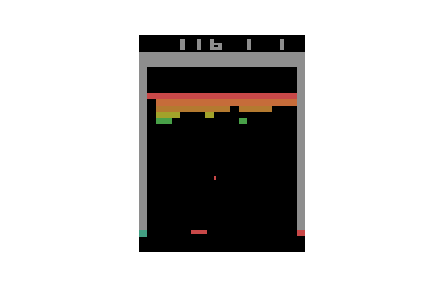
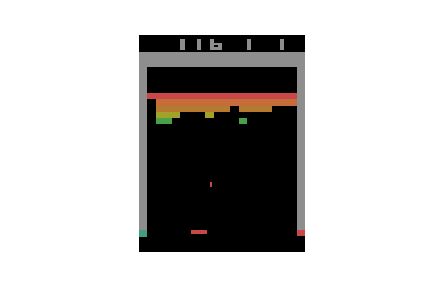
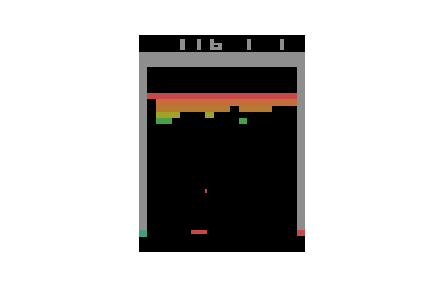
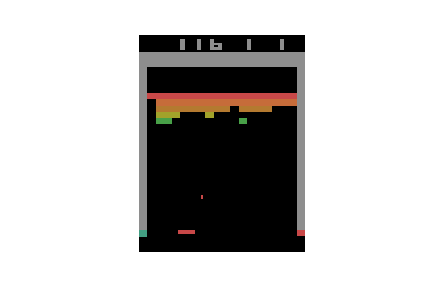
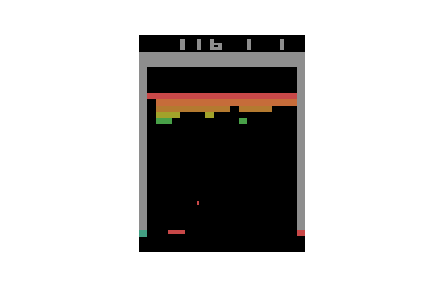
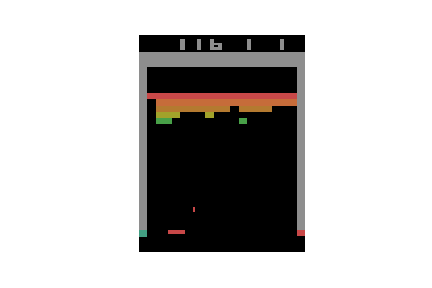
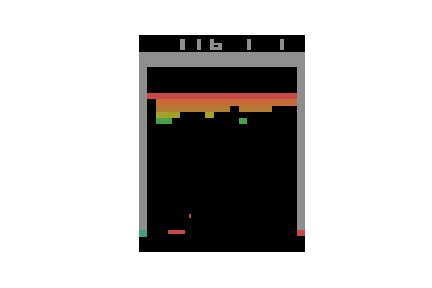
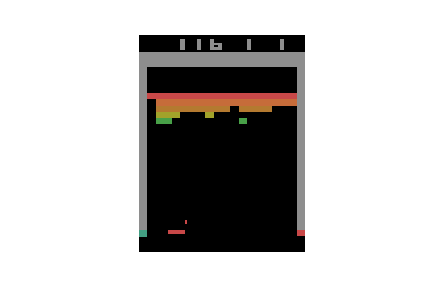
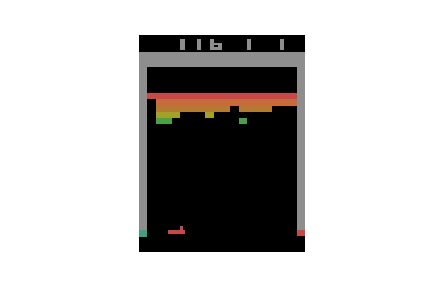
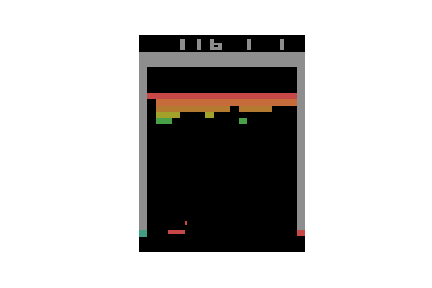
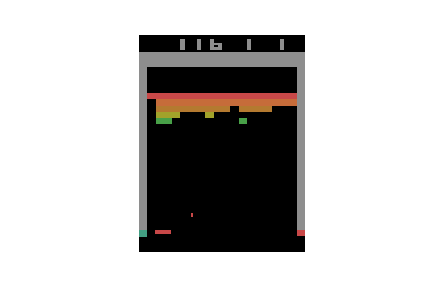
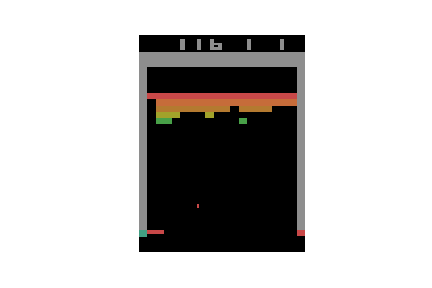
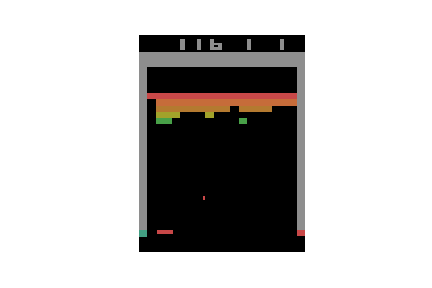
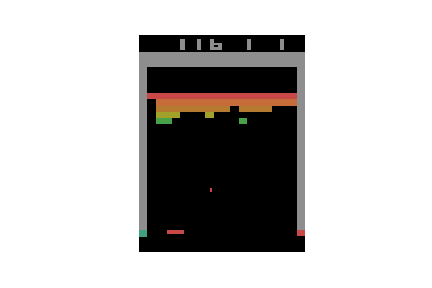
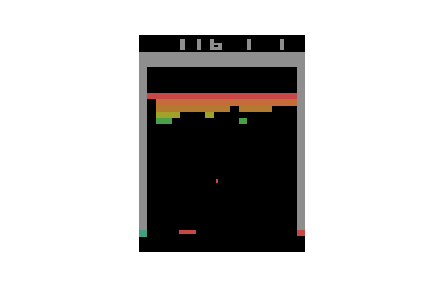
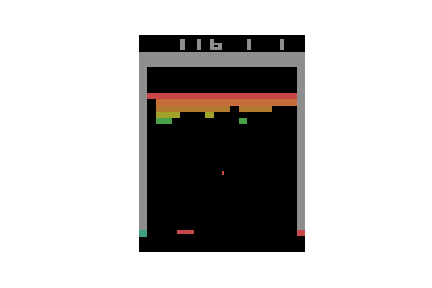
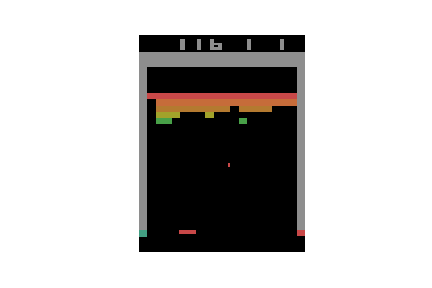
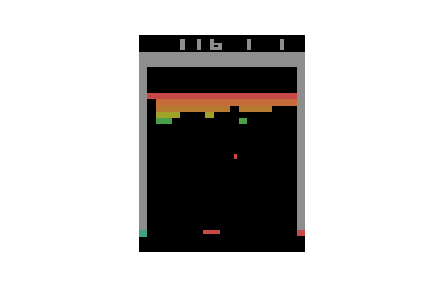
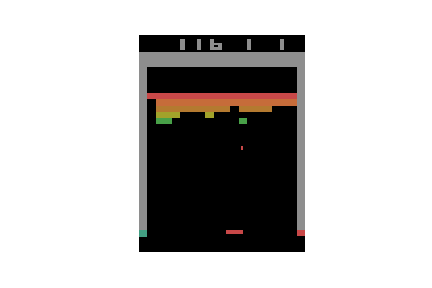
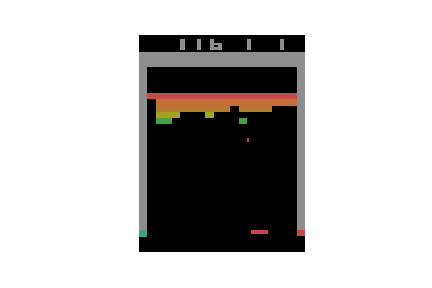
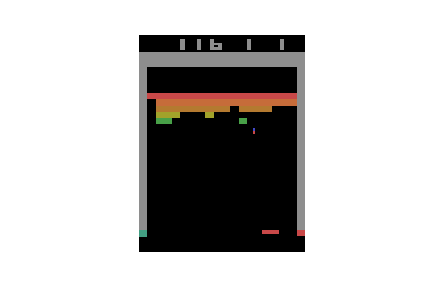
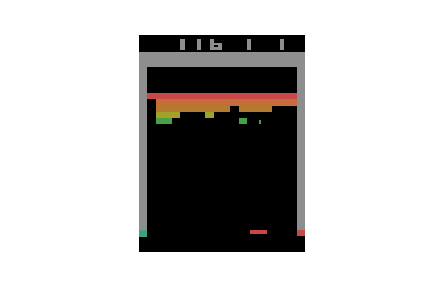
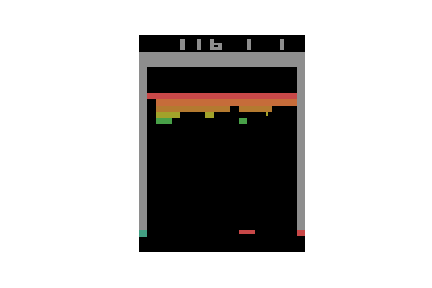
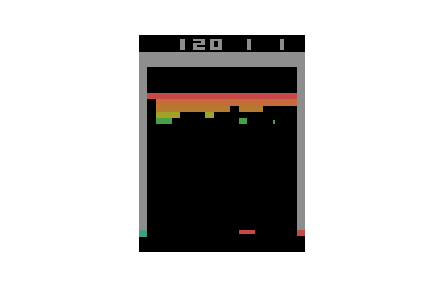
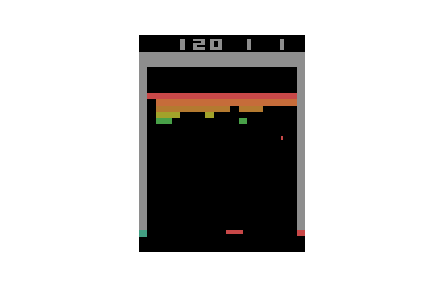
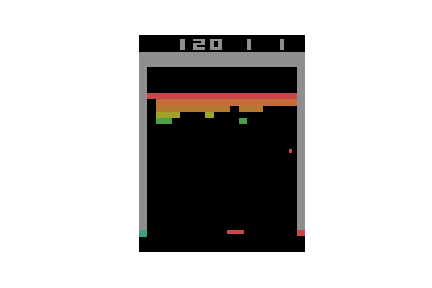
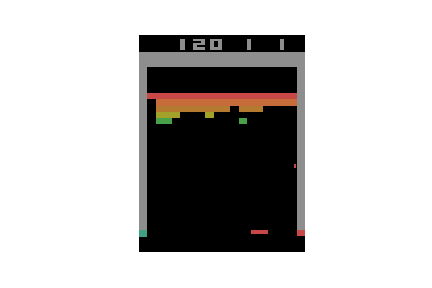
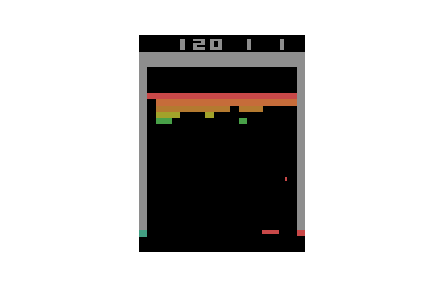
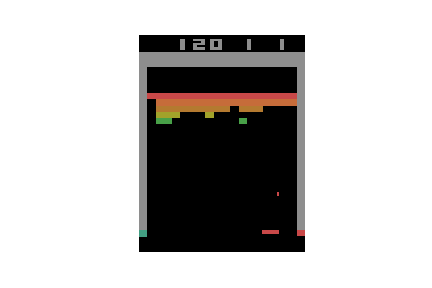
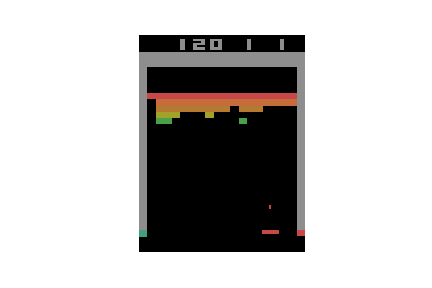
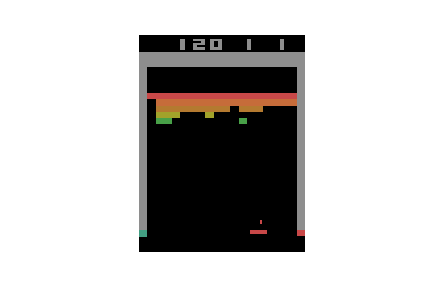
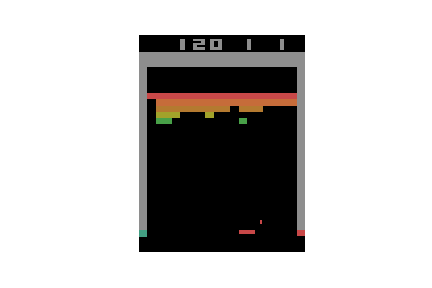
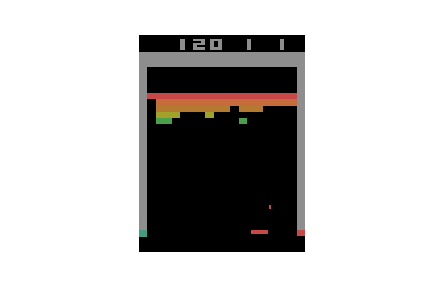
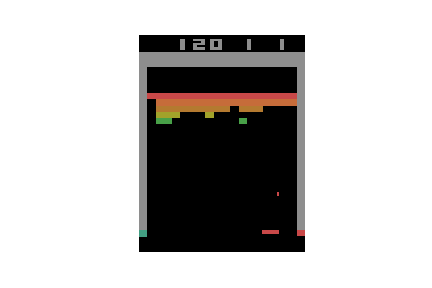
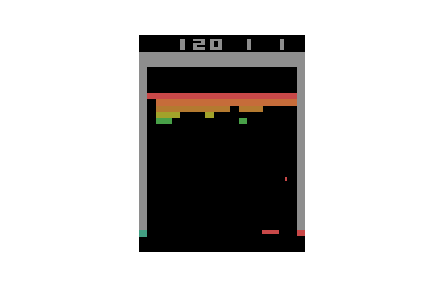
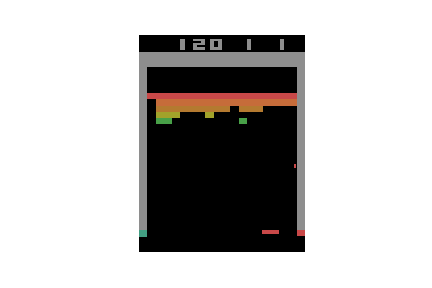
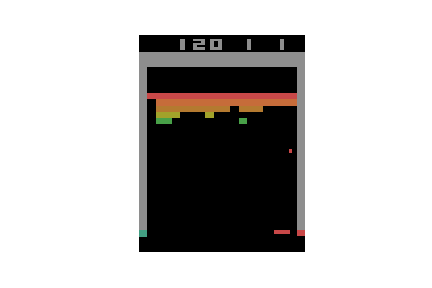
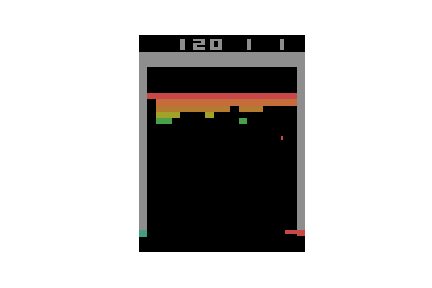
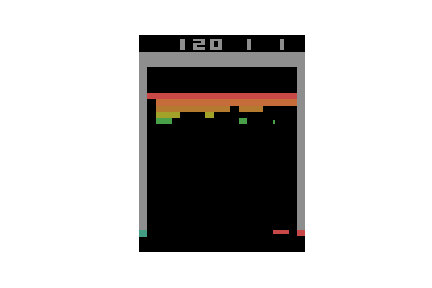
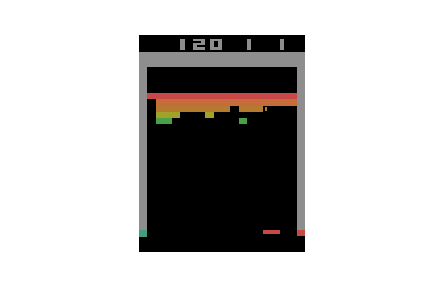
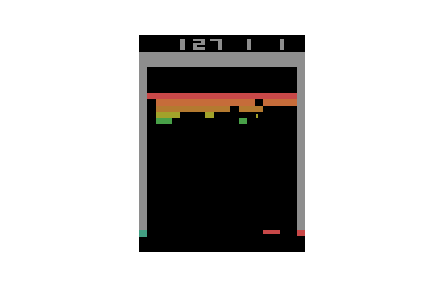
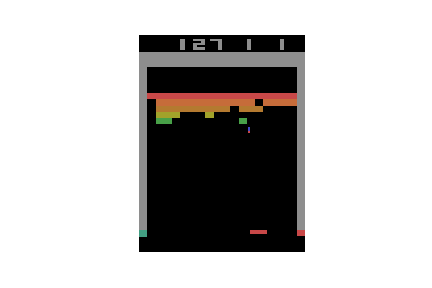
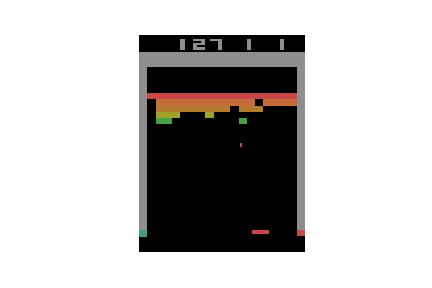
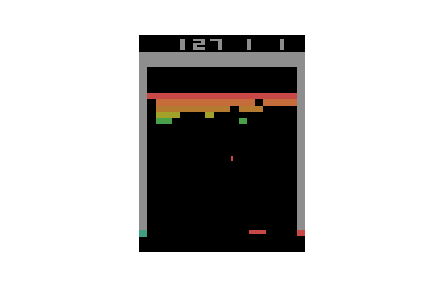
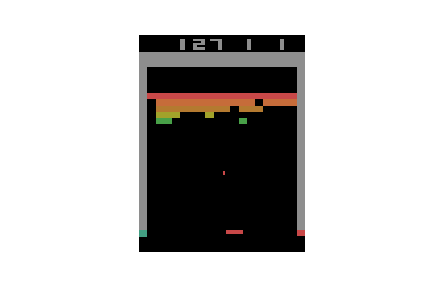
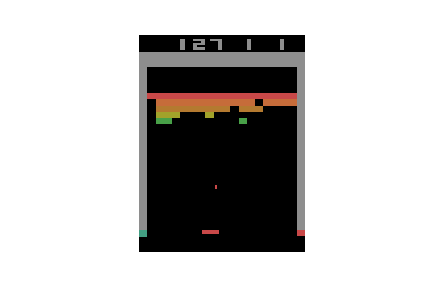
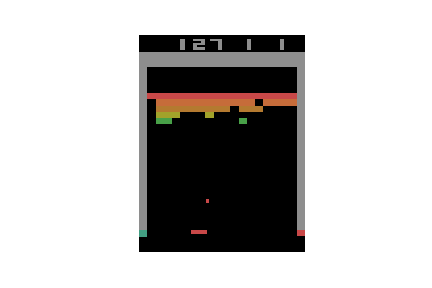
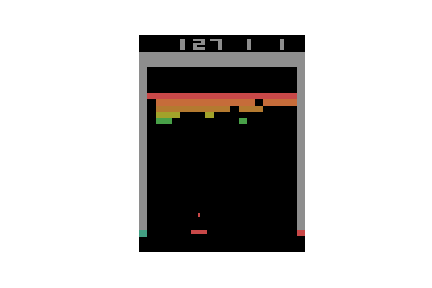
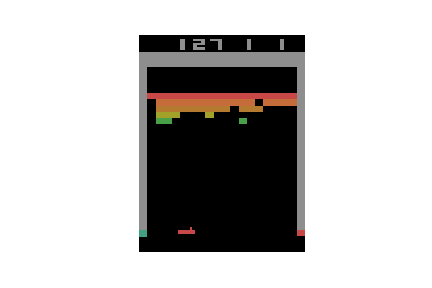
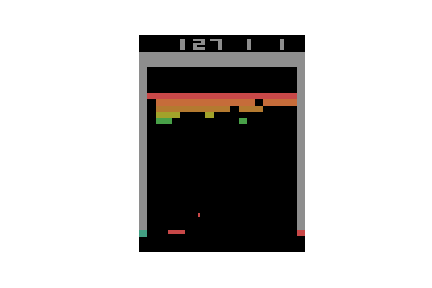
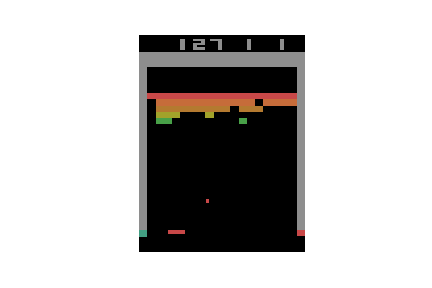
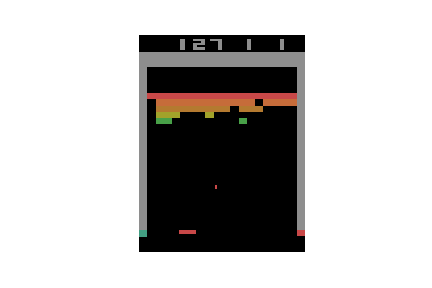
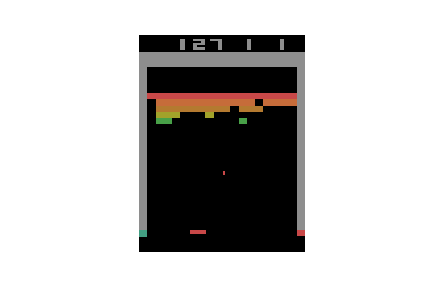
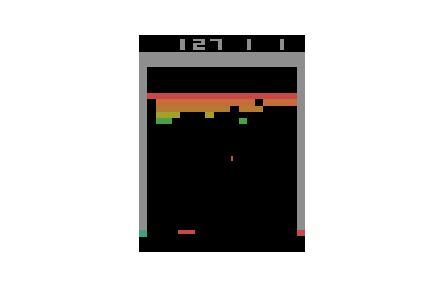
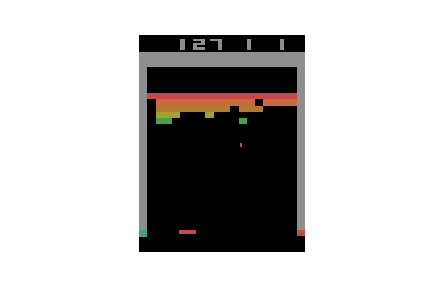
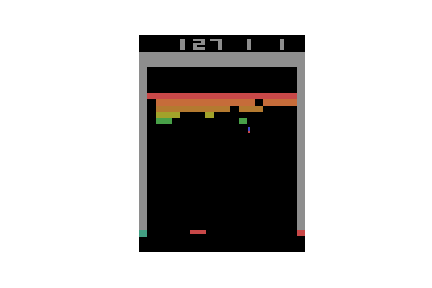
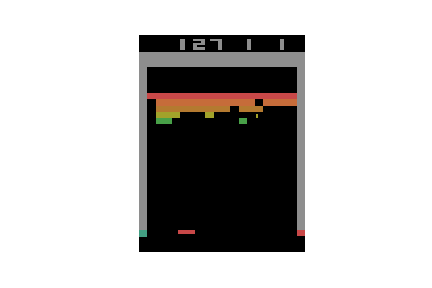
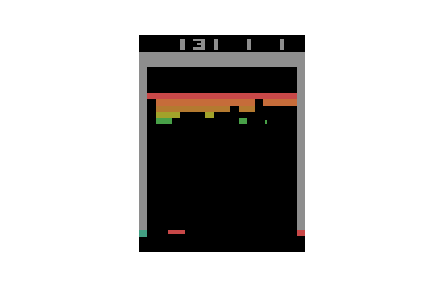
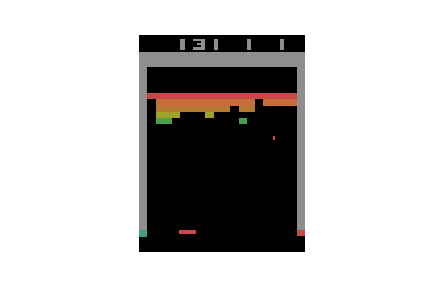
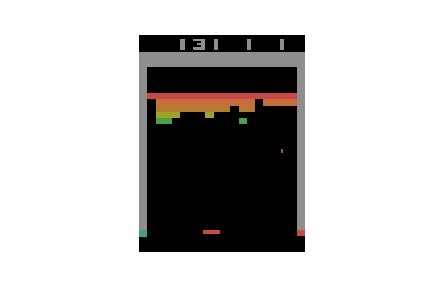
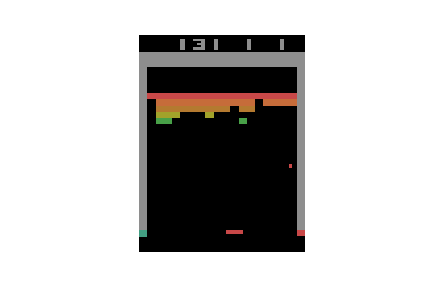
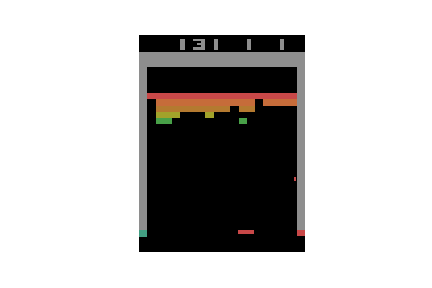
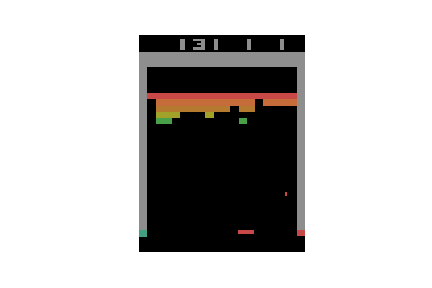
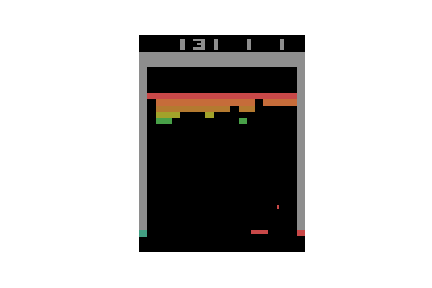
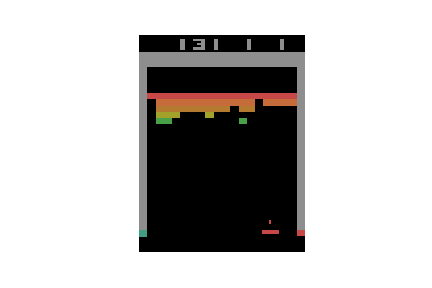
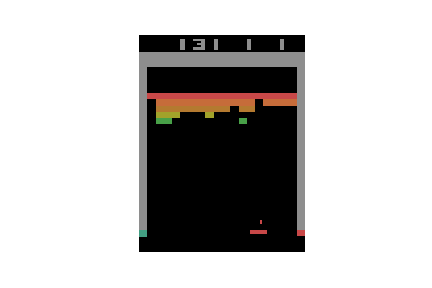
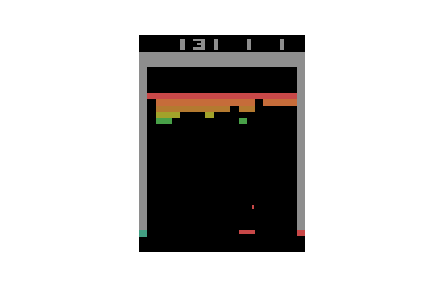
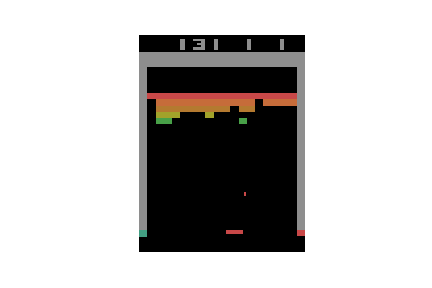
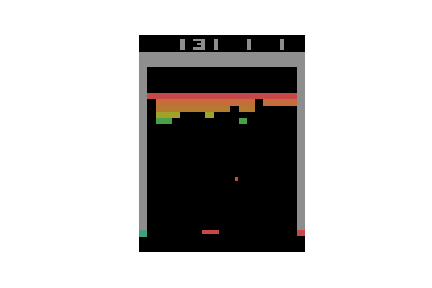
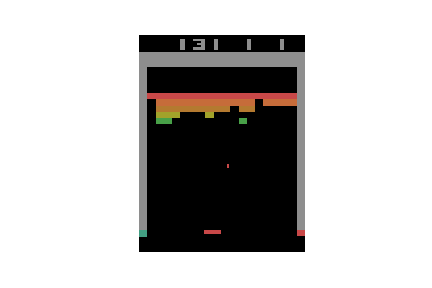
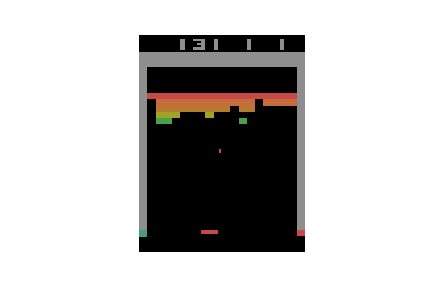
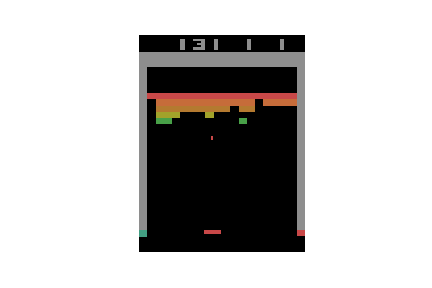
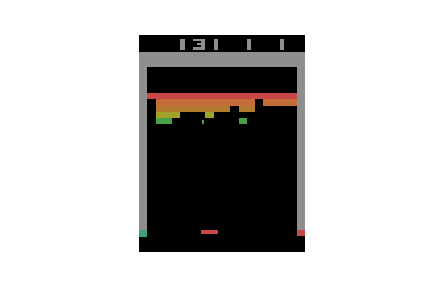
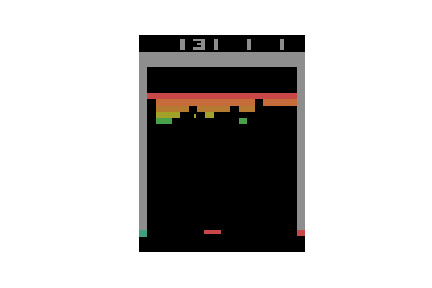
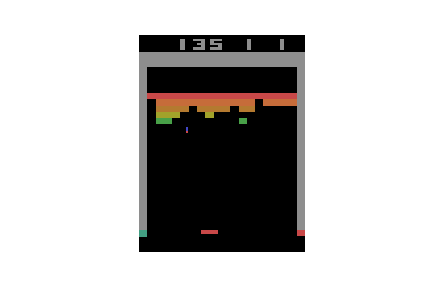
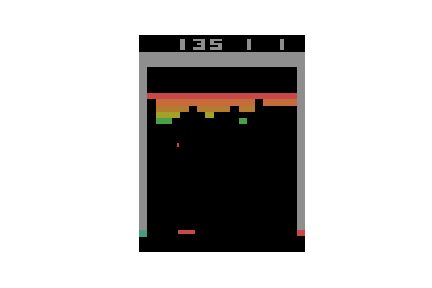
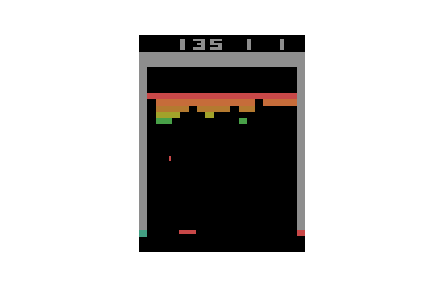
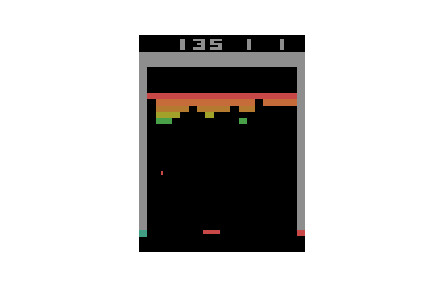
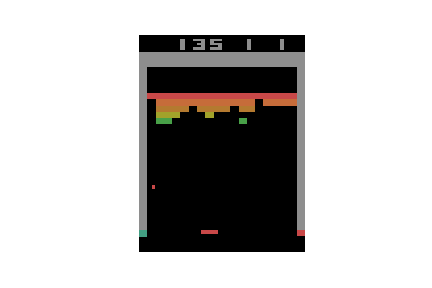
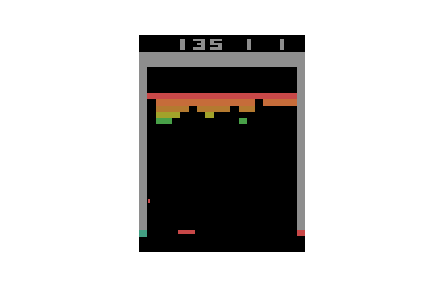
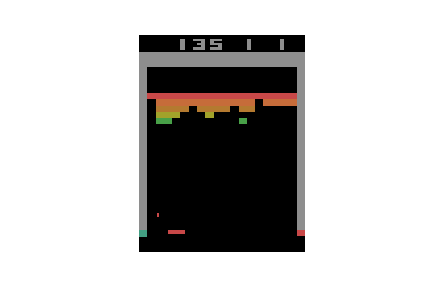
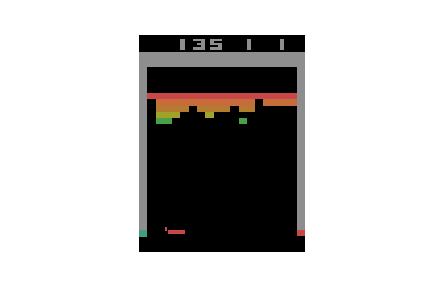
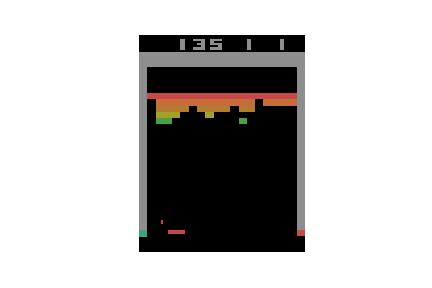
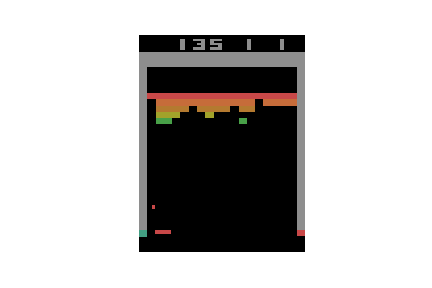
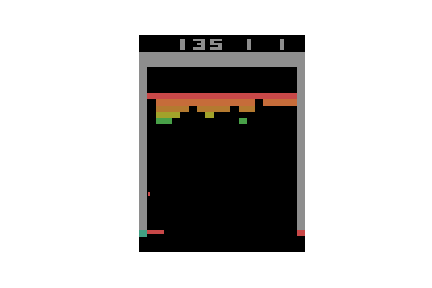
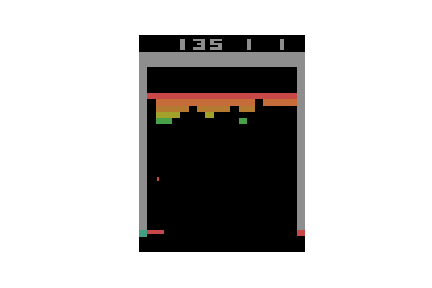
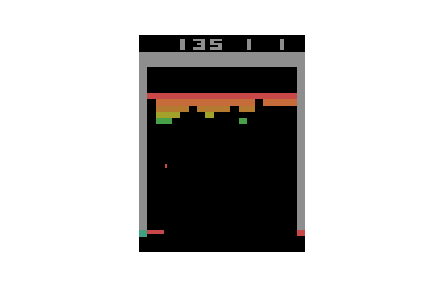
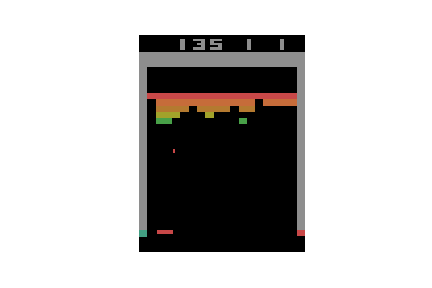
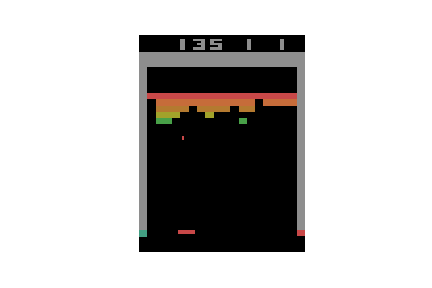
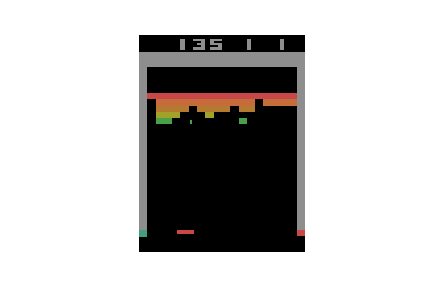
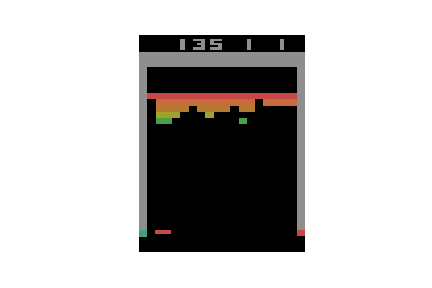
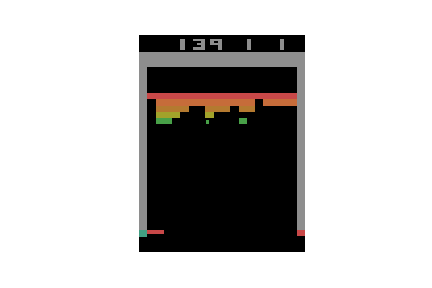
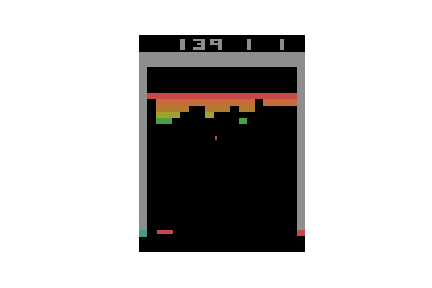
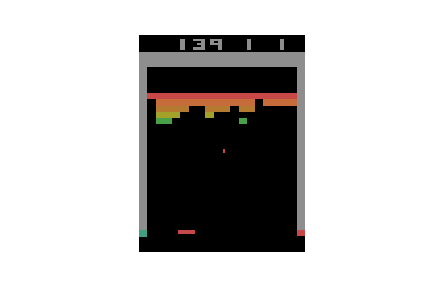
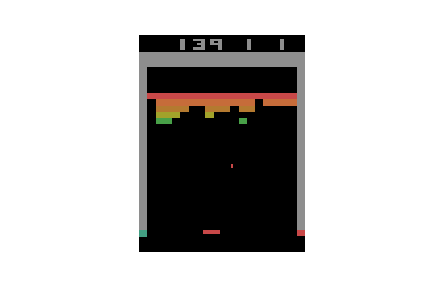
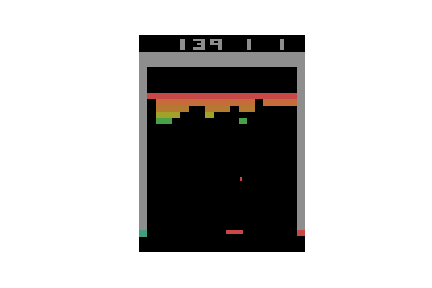
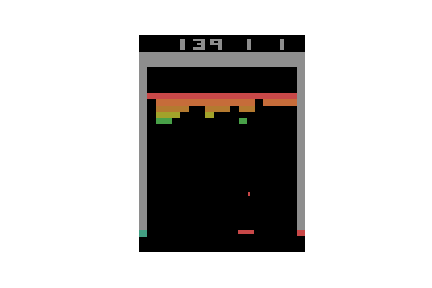
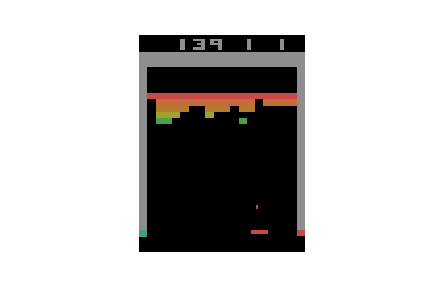
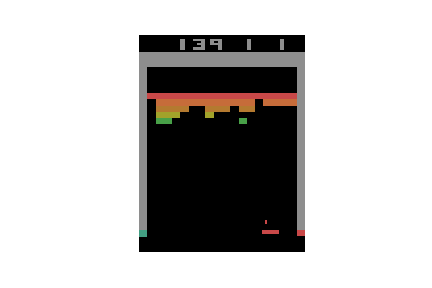
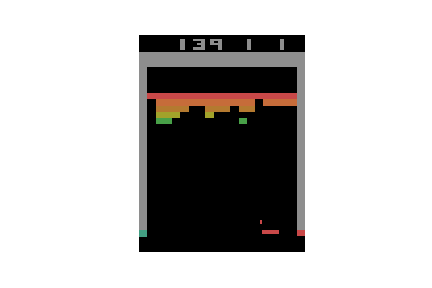
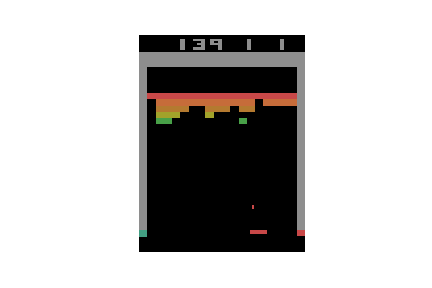
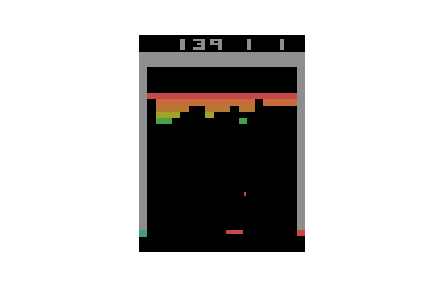
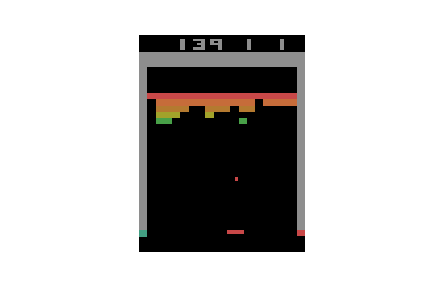
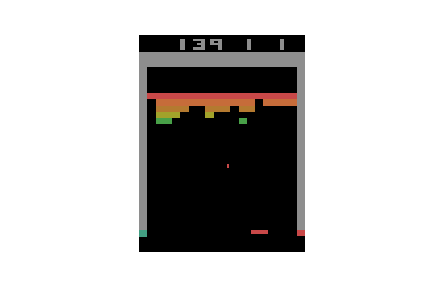
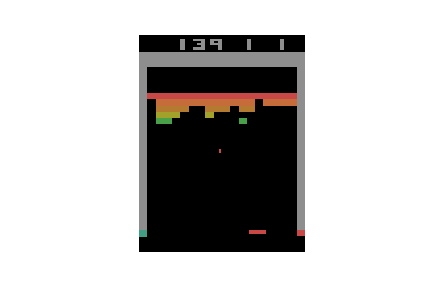
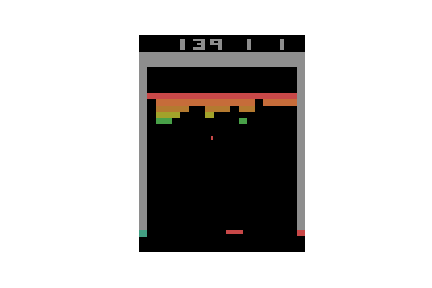
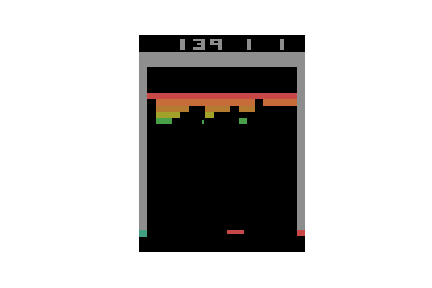
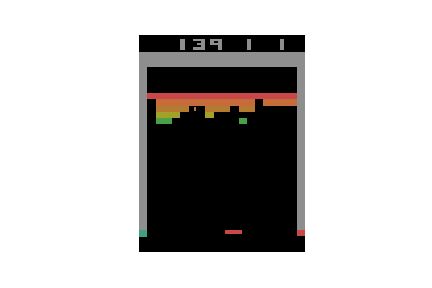
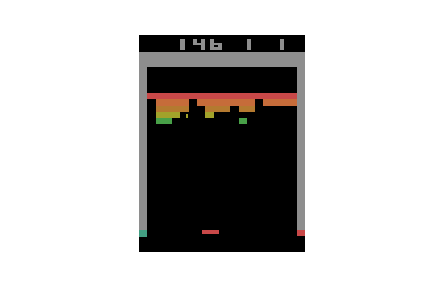
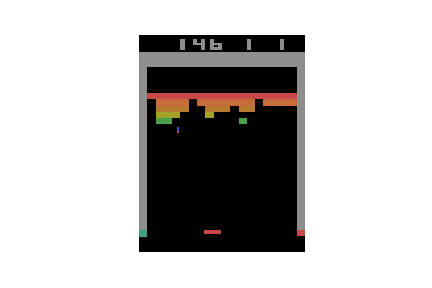
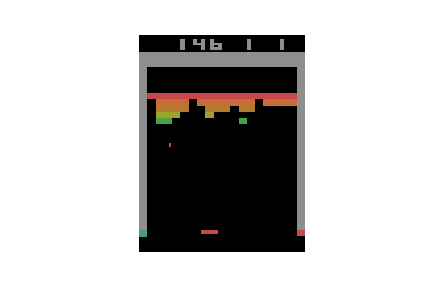
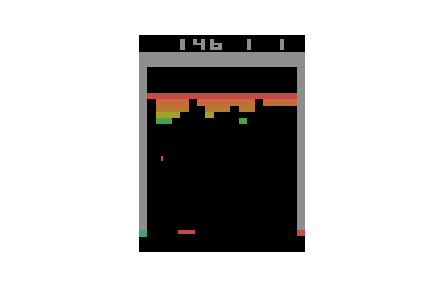
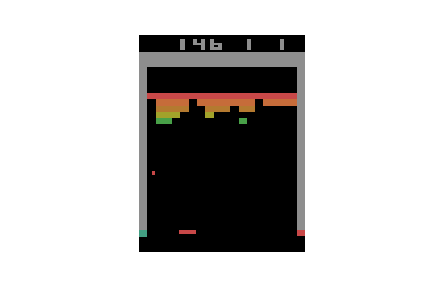
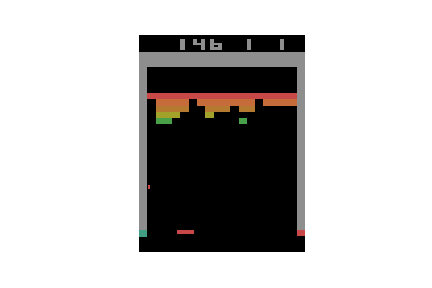
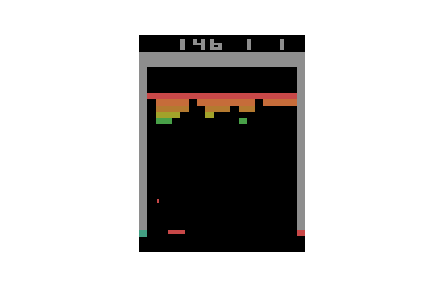
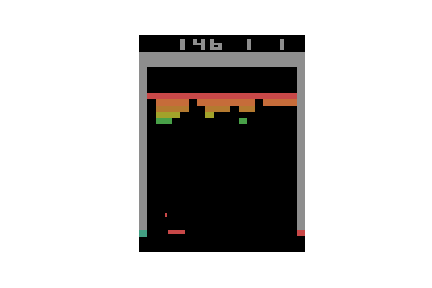
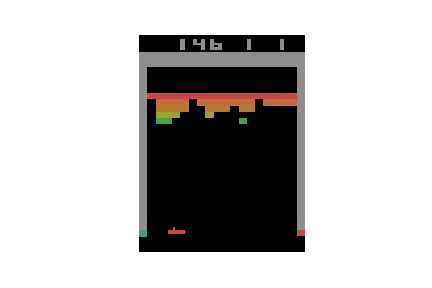
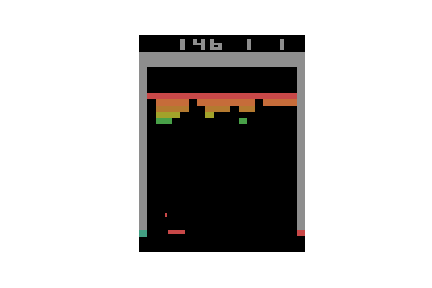
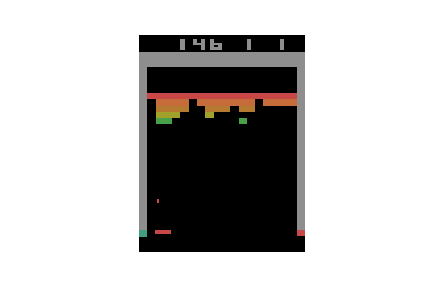
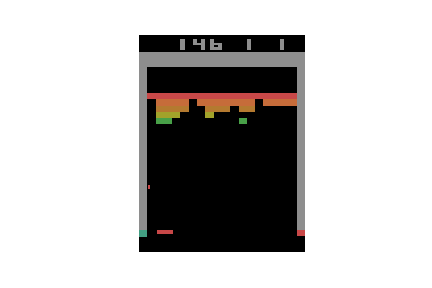
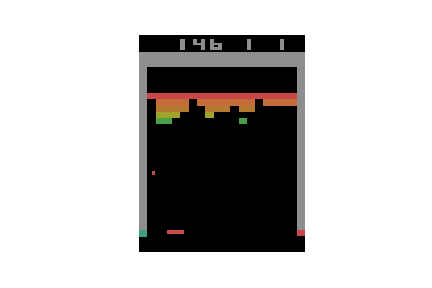
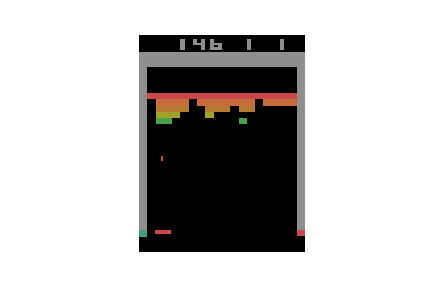
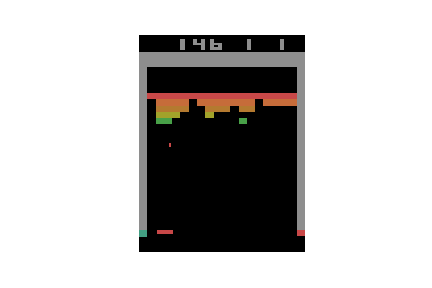
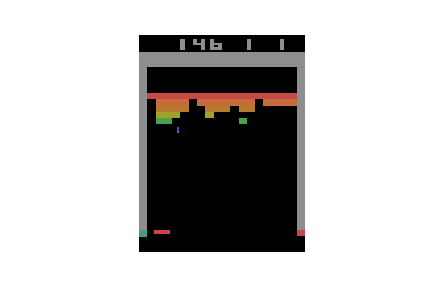
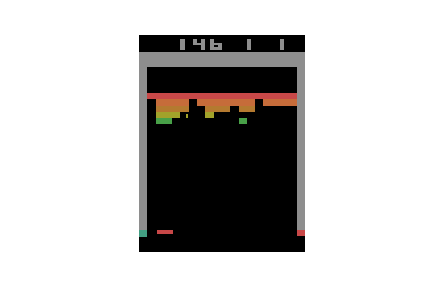
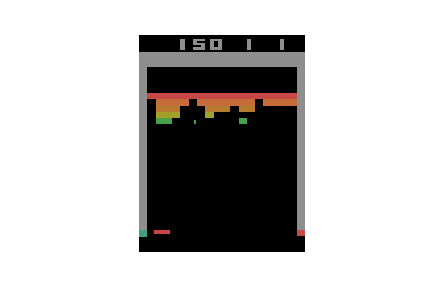
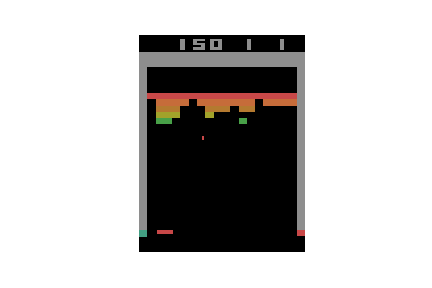
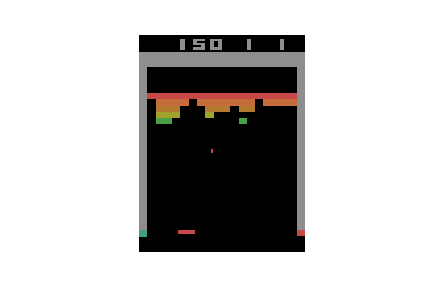
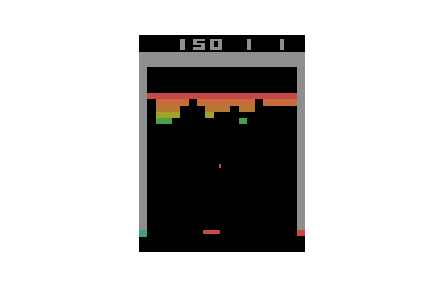
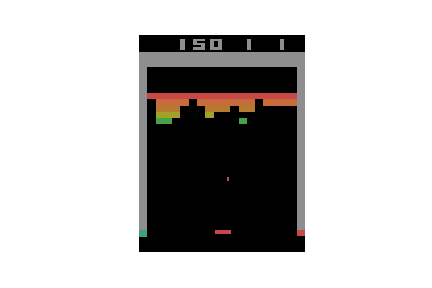
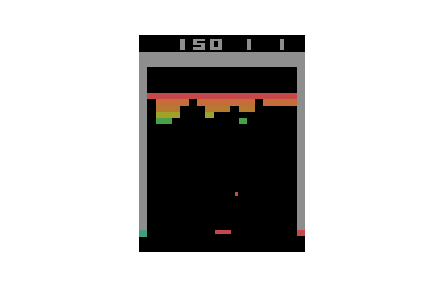
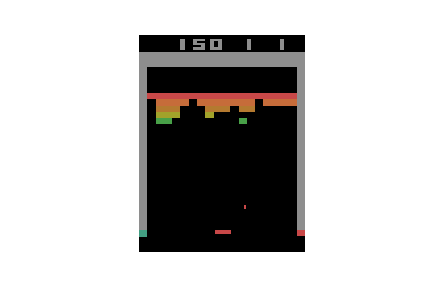
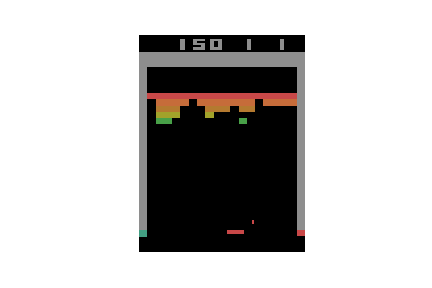
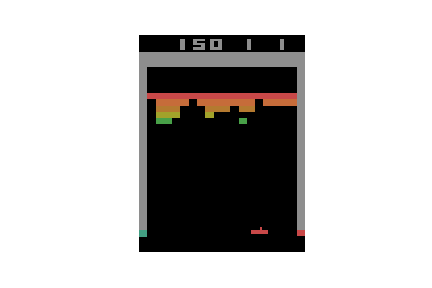
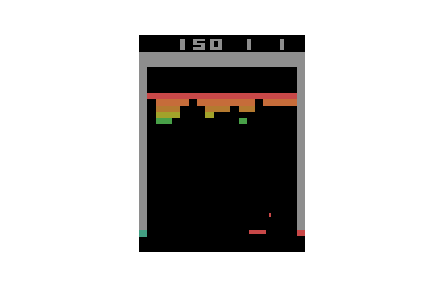
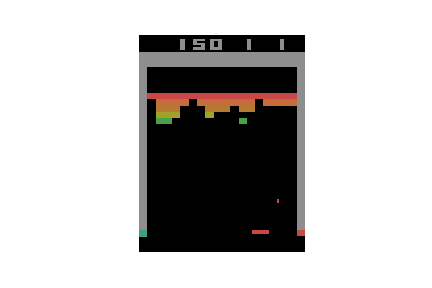
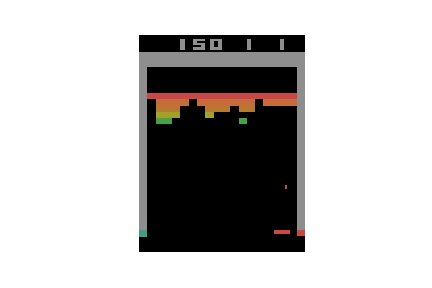
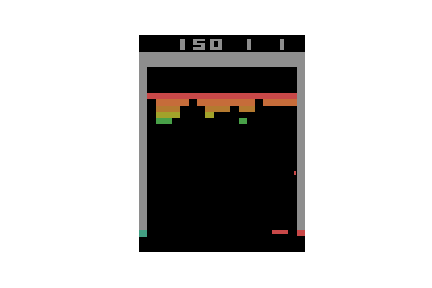
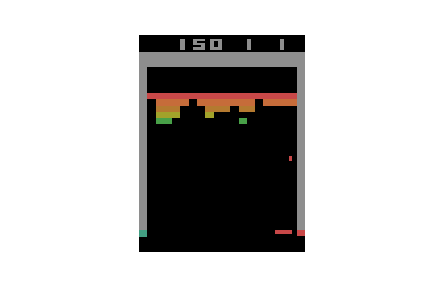
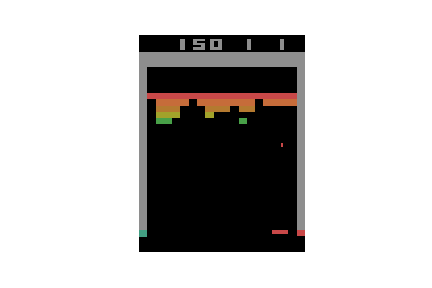
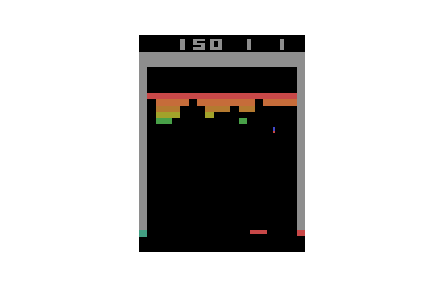
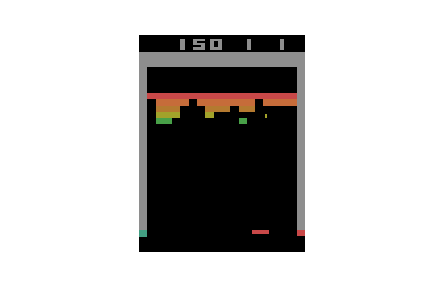
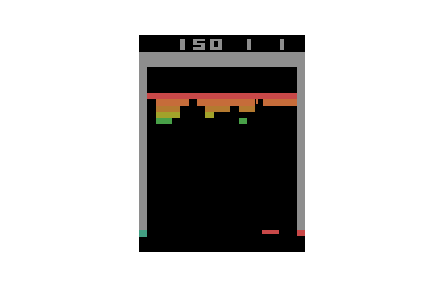
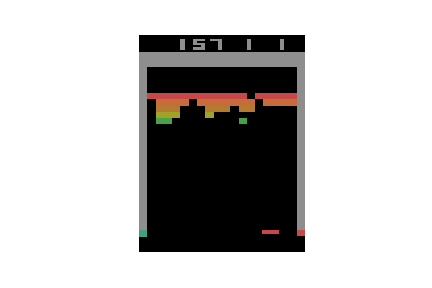
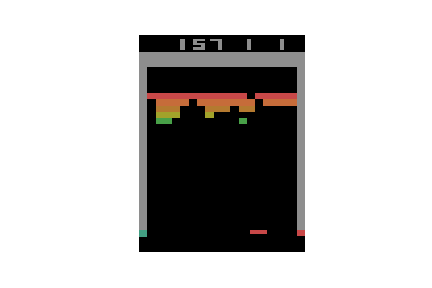
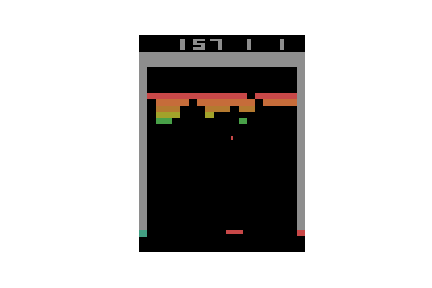
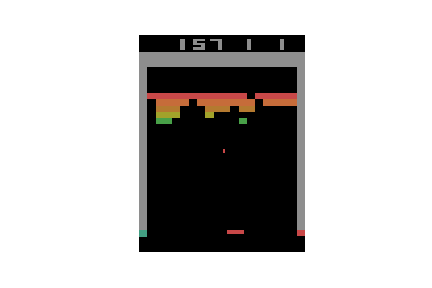
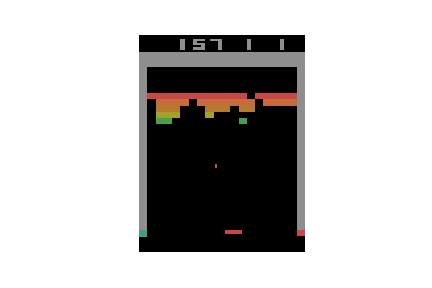
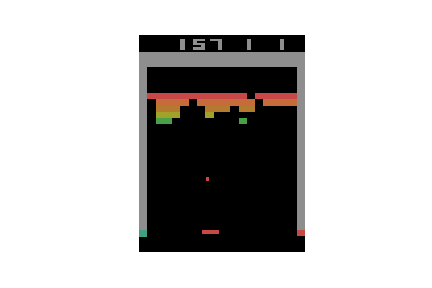
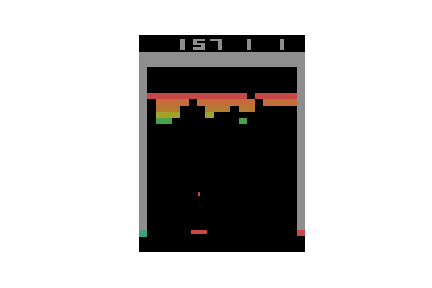
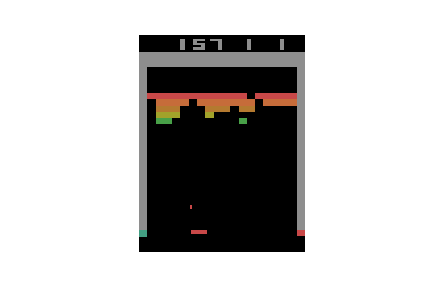
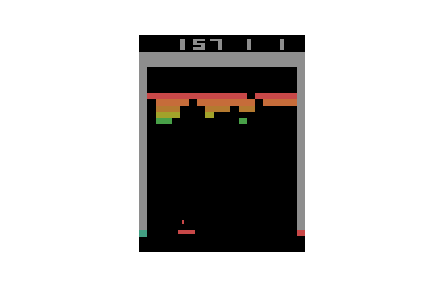
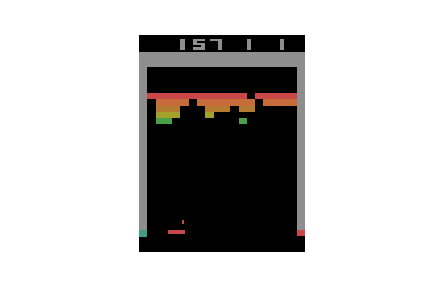
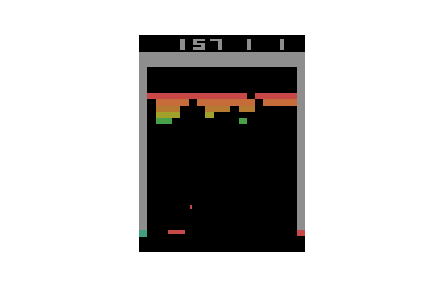
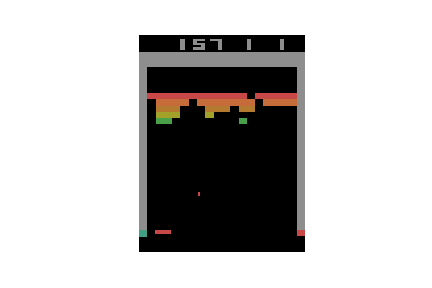
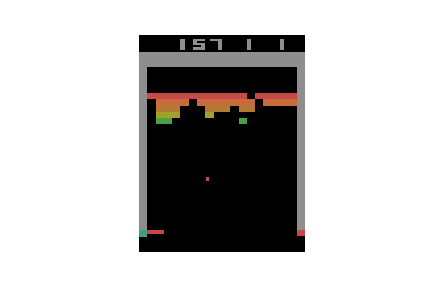
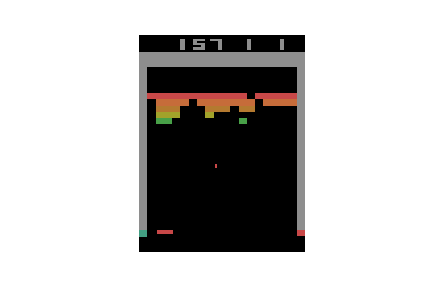
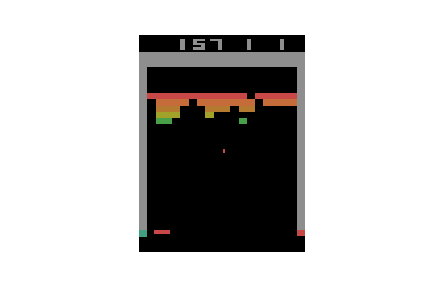
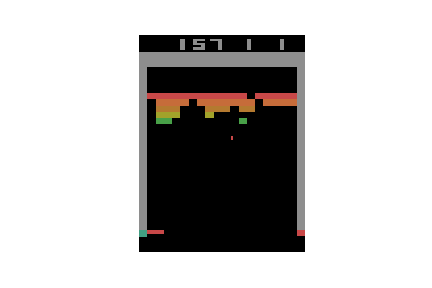
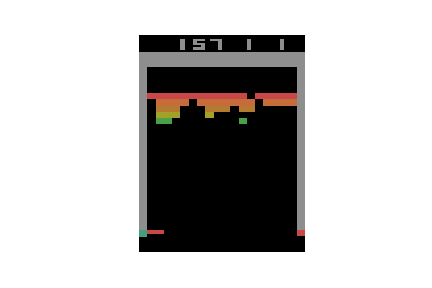
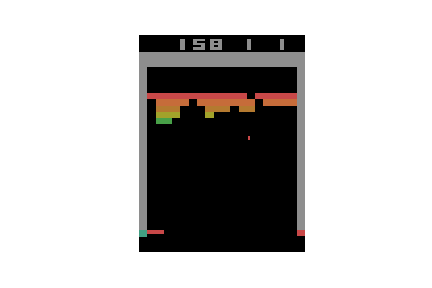
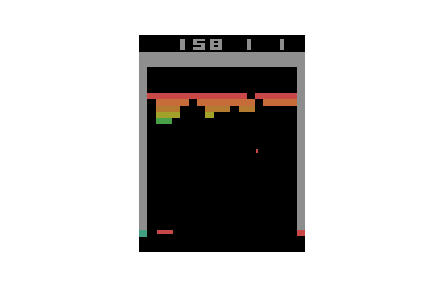
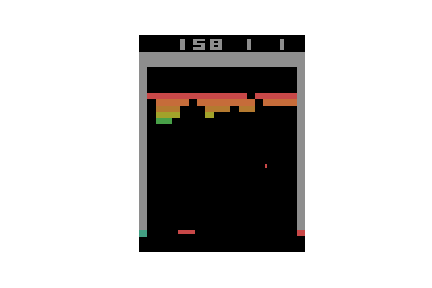
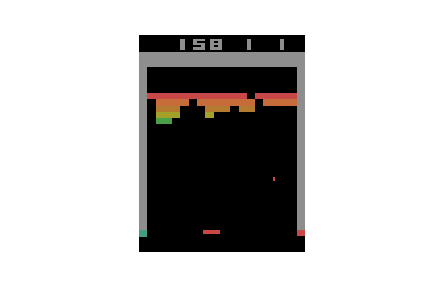
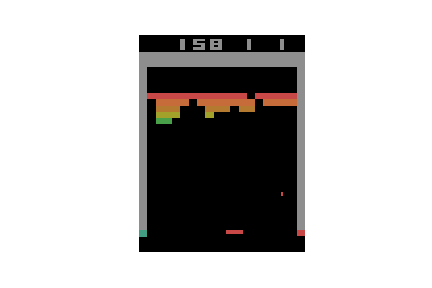
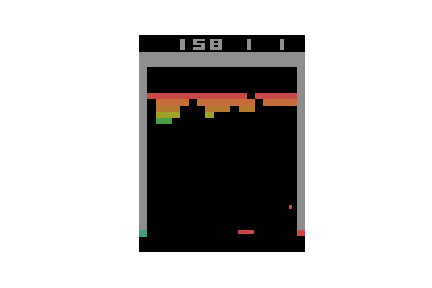
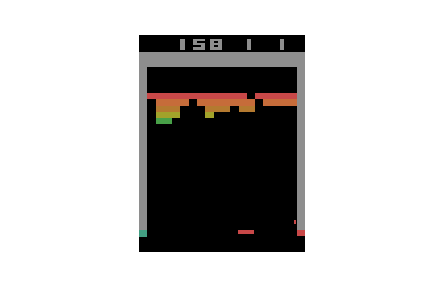
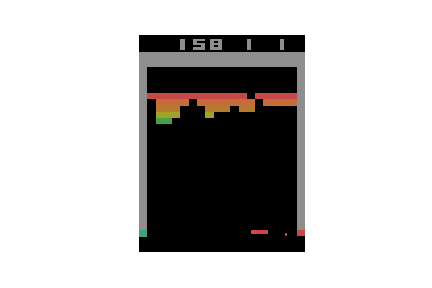
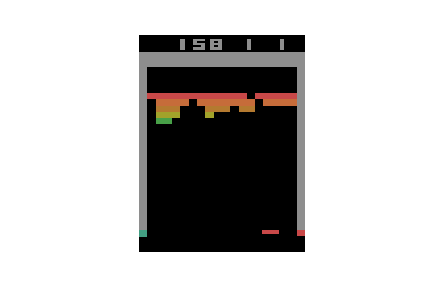
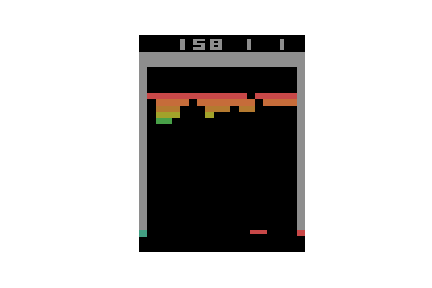

In [11]:
# del agent
env = gym.make('BreakoutDeterministic-v4')
dqn_agent = DQNAgent(n_action=3)
dqn_agent.restore_model()
dqn_agent.epsilon = 0 # Don't explore, choose the best action

done = False
dead = False

frames = []
total_reward, start_life = 0, 5
observe = env.reset()

for _ in range(random.randint(1, 30)):
    observe, _, _, _ = env.step(1)

state = pre_processing(observe)
history = np.stack((state, state, state, state), axis=2)
history = np.reshape([history], (1, 84, 84, 4))

while not done:
    frames.append(env.render(mode = 'rgb_array'))

    dqn_action = dqn_agent.get_action(np.float32(history / 255.0))

    if dqn_action == 0:
        real_action = 1
    elif dqn_action == 1:
        real_action = 2
    else:
        real_action = 3

    if dead:
        real_action = 1
        dead = False

    observe, reward, done, info = env.step(real_action)

    next_state = pre_processing(observe)
    next_state = np.reshape([next_state], (1, 84, 84, 1))
    next_history = np.append(next_state, history[:, :, :, :3], axis=3)

    if start_life > info['ale.lives']:
        dead = True
        start_life = info['ale.lives']

    total_reward += reward

    history = next_history

    if done:
        print("score:", total_reward)

display_frames_as_gif(frames)